In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m']
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m']
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m']

def merton_path(r0, days, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], columns=['index'])
    merton = merton.values.flatten()
    return merton

def m_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated Merton Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(merton_path(data[0], len(data), opt[0], opt[1]),
                 lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()


In [2]:
data = mosprime3m_short

In [92]:
p0 = np.array([ 0.45,  0.4 ])

In [261]:
def merton_ml_diff(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    dx = np.diff(data.values)
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(dx))
    sigma = vol * np.sqrt(dt)
    mu =  a * dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [283]:
 def merton_ml_len1(p0):
    a, vol = p0
    if a<0.0 or vol < 0.0:
        return np.inf
    x = data[1:].values
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(x))
    sigma = vol * np.sqrt(dt)
    mu = data[:-1].values + a * dt
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [95]:
 def merton_ml(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [113]:
 def merton_ml_last40(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    x = x[-40:]
    t = t[-40:]
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [140]:
def merton_ml_random40(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    subset_ids = np.sort(np.random.permutation(data.shape[0])[:40])
    x = data[subset_ids].values
    t = (np.array(list(range(len(data)))) + 1)/252
    t = t[subset_ids]
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

Optimization terminated successfully.
         Current function value: -205.020651
         Iterations: 45
         Function evaluations: 87
[ 1.017719    0.53495622]


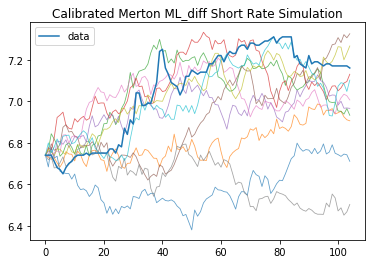

In [263]:
opt_ML1 = sop.fmin(merton_ml_diff, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML1)

m_p(data, opt_ML1, num_paths=10, title='Calibrated Merton ML_diff Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -205.020651
         Iterations: 45
         Function evaluations: 87
[ 1.017719    0.53495622]


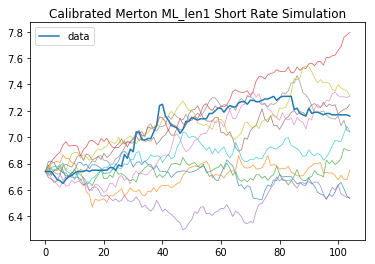

In [97]:
opt_ML2 = sop.fmin(merton_ml_len1, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML2)

m_p(data, opt_ML2, num_paths=10, title='Calibrated Merton ML_len1 Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -78.440199
         Iterations: 45
         Function evaluations: 85
[ 1.92814267  0.28830034]


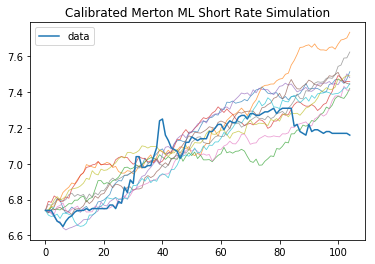

In [98]:
opt_ML3 = sop.fmin(merton_ml, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML3)

m_p(data, opt_ML3, num_paths=10, title='Calibrated Merton ML Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -26.207512
         Iterations: 46
         Function evaluations: 87
[ 1.71536928  0.21677507]


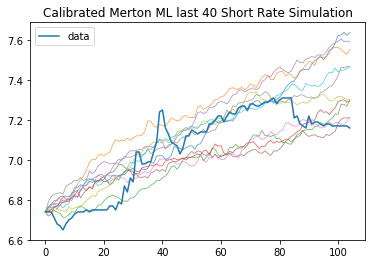

In [121]:
opt_ML4 = sop.fmin(merton_ml_last40, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML4)

m_p(data, opt_ML4, num_paths=10, title='Calibrated Merton ML last 40 Short Rate Simulation')

[ 0.48375  0.495  ]


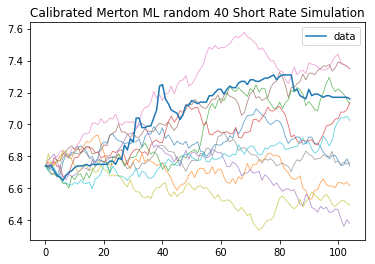

In [141]:
opt_ML5 = sop.fmin(merton_ml_random40, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML5)

m_p(data, opt_ML5, num_paths=10, title='Calibrated Merton ML random 40 Short Rate Simulation')

In [257]:
from tqdm import tqdm

In [271]:
def rolling_merton(db=mosprime3m, periods=21, p0=np.array([ 0.45,  0.4 ])):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    df_cal = pd.DataFrame(columns=["a", "vol"], index=end_dates)
    for i in tqdm(end_dates):
        x = pd.date_range(end = i, periods=periods, freq='d').strftime('%Y-%m-%d') # добавить ошибку на неправильный формат
        global data
        data = db.loc[x].dropna() # ошибку на формат датафрейма
        opt_ML_merton = sop.fmin(merton_ml_diff, p0, maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)
        df_cal.loc[i] = opt_ML_merton
    return df_cal

In [272]:
db21 = rolling_merton(periods=21)

  0%|          | 0/3981 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -23.382863
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -23.452084
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.222849
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.175273
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.069714
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.069714
         Iterations: 44
         Function evaluations: 85


  0%|          | 6/3981 [00:00<01:30, 44.16it/s]

Optimization terminated successfully.
         Current function value: -29.069714
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -24.962109
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.254644
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -24.590228
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -24.590228
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.334348
         Iterations: 51
         Function evaluations: 96


  0%|          | 12/3981 [00:00<01:28, 45.08it/s]

Optimization terminated successfully.
         Current function value: -25.334348
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.334348
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.507140
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.812261
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.863615
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.863615
         Iterations: 53
         Function evaluations: 102


  0%|          | 18/3981 [00:00<01:24, 46.69it/s]

Optimization terminated successfully.
         Current function value: -26.338330
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.338330
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.338330
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.521956
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.671855
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.597867
         Iterations: 56
         Function evaluations: 107


  1%|          | 24/3981 [00:00<01:22, 48.16it/s]

Optimization terminated successfully.
         Current function value: -25.593981
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -30.356838
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.356838
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.356838
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.680503
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.626563
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.680503
         Iterations: 40
         Function evaluations: 79
Optimization termin

  1%|          | 32/3981 [00:00<01:15, 52.36it/s]

Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -24.573878
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.459044
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.516730
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.626123
         Iterations: 54
         Function evaluations: 105
Optimization ter

  1%|          | 40/3981 [00:00<01:10, 55.72it/s]

Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.392479
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.758133
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.668299
         Iterations: 61
         Function evaluations: 114


  1%|          | 46/3981 [00:00<01:22, 47.52it/s]

Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.976085
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.058005
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.369753
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.177644
         Iterations: 68
         Function evaluations: 130


  1%|▏         | 53/3981 [00:01<01:19, 49.35it/s]

Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -17.630583
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -15.982102
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -15.806333
         Iterations: 54
         Function evaluations: 106


  1%|▏         | 59/3981 [00:01<01:23, 46.83it/s]

Optimization terminated successfully.
         Current function value: -17.532686
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -17.818409
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.117635
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.627796
         Iterations: 48
         Function evaluations: 93


  2%|▏         | 66/3981 [00:01<01:21, 47.85it/s]

Optimization terminated successfully.
         Current function value: -22.763602
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.138253
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -22.138253
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -22.138253
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -22.621615
         Iterations: 69
         Function evaluations: 128


  2%|▏         | 71/3981 [00:01<01:27, 44.93it/s]

Optimization terminated successfully.
         Current function value: -22.987826
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.893211
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -23.107655
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.614826
         Iterations: 48
         Function evaluations: 95


  2%|▏         | 78/3981 [00:01<01:24, 45.96it/s]

Optimization terminated successfully.
         Current function value: -25.593981
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.488504
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.518812
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -25.553947
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.553947
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.553947
         Iterations: 52
         Function evaluations: 102


  2%|▏         | 84/3981 [00:01<01:24, 46.32it/s]

Optimization terminated successfully.
         Current function value: -25.350296
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.802522
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -25.880817
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.619708
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.372560
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -27.706389
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.706389
         Iterations: 53
         Function evaluations: 103


  2%|▏         | 91/3981 [00:01<01:22, 47.22it/s]

Optimization terminated successfully.
         Current function value: -25.488504
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.613197
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -26.713144
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -25.256310
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -27.982023
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -27.982023
         Iterations: 53
         Function evaluations: 100


  2%|▏         | 97/3981 [00:02<01:21, 47.67it/s]

Optimization terminated successfully.
         Current function value: -27.982023
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -28.342115
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.134780
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.134780
         Iterations: 55
         Function evaluations: 104


  3%|▎         | 103/3981 [00:02<01:23, 46.18it/s]

Optimization terminated successfully.
         Current function value: -27.134780
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.134780
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.856741
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.885439
         Iterations: 65
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -27.847204
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.102367
         Iterations: 55
         Function evaluations: 105


  3%|▎         | 109/3981 [00:02<01:23, 46.48it/s]

Optimization terminated successfully.
         Current function value: -22.917483
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -21.157577
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -21.157577
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.237745
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -22.782542
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -22.493059
         Iterations: 63
         Function evaluations: 117


  3%|▎         | 115/3981 [00:02<01:22, 47.02it/s]

Optimization terminated successfully.
         Current function value: -22.509760
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -21.815694
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -21.815694
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -21.815694
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -21.848810
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -21.848810
         Iterations: 61
         Function evaluations: 116


  3%|▎         | 121/3981 [00:02<01:24, 45.91it/s]

Optimization terminated successfully.
         Current function value: -22.219447
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.206335
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -22.171487
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -22.171487
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -22.171487
         Iterations: 56
         Function evaluations: 106


  3%|▎         | 126/3981 [00:02<01:24, 45.89it/s]

Optimization terminated successfully.
         Current function value: -21.977229
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.136812
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -22.651024
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -23.749820
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -23.629167
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -25.734725
         Iterations: 55
         Function evaluations: 104


  3%|▎         | 132/3981 [00:02<01:23, 46.28it/s]

Optimization terminated successfully.
         Current function value: -25.734725
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -30.951977
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -30.718202
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -31.279358
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -32.412632
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.687243
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -32.687243
         Iterations: 48
         Function evaluations: 94


  3%|▎         | 139/3981 [00:02<01:21, 46.91it/s]

Optimization terminated successfully.
         Current function value: -32.687243
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -32.180345
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.826434
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.601583
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -31.698920
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -31.698920
         Iterations: 49
         Function evaluations: 93


  4%|▎         | 145/3981 [00:03<01:22, 46.51it/s]

Optimization terminated successfully.
         Current function value: -31.698920
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -31.698920
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.874995
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.162850
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -28.006291
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -31.364311
         Iterations: 39
         Function evaluations: 77


  4%|▍         | 152/3981 [00:03<01:21, 46.96it/s]

Optimization terminated successfully.
         Current function value: -28.487179
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.487179
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.364311
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.094592
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -33.968463
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -33.171815
         Iterations: 49
         Function evaluations: 94


  4%|▍         | 158/3981 [00:03<01:20, 47.21it/s]

Optimization terminated successfully.
         Current function value: -33.305554
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.305554
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.305554
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 45
         Function evaluations: 83


  4%|▍         | 164/3981 [00:03<01:21, 46.98it/s]

Optimization terminated successfully.
         Current function value: -31.320264
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.918486
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.918486
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.918486
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.301006
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -33.248931
         Iterations: 41
         Function evaluations: 79


  4%|▍         | 170/3981 [00:03<01:20, 47.17it/s]

Optimization terminated successfully.
         Current function value: -33.783430
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -34.190704
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.150497
         Iterations: 31
         Function evaluations: 57


  4%|▍         | 176/3981 [00:03<01:20, 47.29it/s]

Optimization terminated successfully.
         Current function value: -34.478810
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99


  5%|▍         | 182/3981 [00:03<01:20, 47.04it/s]

Optimization terminated successfully.
         Current function value: -33.813931
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -33.836895
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.207508
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.207508
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86


  5%|▍         | 187/3981 [00:03<01:21, 46.81it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.723604
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.110073
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -33.655263
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 43
         Function evaluations: 83


  5%|▍         | 194/3981 [00:04<01:20, 47.28it/s]

Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -34.279980
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.279980
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -27.501503
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -6.282017
         Iterations: 65
         Function evaluations: 127


  5%|▌         | 200/3981 [00:04<01:19, 47.56it/s]

Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.854908
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -5.761904
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -5.759821
         Iterations: 68
         Function evaluations: 131


  5%|▌         | 206/3981 [00:04<01:18, 47.84it/s]

Optimization terminated successfully.
         Current function value: -5.759821
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.517400
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -6.099019
         Iterations: 70
         Function evaluations: 137


  5%|▌         | 212/3981 [00:04<01:18, 47.87it/s]

Optimization terminated successfully.
         Current function value: -6.297748
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -6.245003
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -5.345128
         Iterations: 75
         Function evaluations: 142


  5%|▌         | 218/3981 [00:04<01:19, 47.28it/s]

Optimization terminated successfully.
         Current function value: -5.100735
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -11.706478
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -12.336850
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135


  6%|▌         | 223/3981 [00:04<01:19, 47.33it/s]

Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -13.233493
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -13.980988
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -13.421415
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -13.518355
         Iterations: 62
         Function evaluations: 121


  6%|▌         | 228/3981 [00:04<01:20, 46.43it/s]

Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.691293
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.582389
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -19.475153
         Iterations: 58
         Function evaluations: 111


  6%|▌         | 234/3981 [00:05<01:20, 46.63it/s]

Optimization terminated successfully.
         Current function value: -22.803119
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117


  6%|▌         | 239/3981 [00:05<01:20, 46.49it/s]

Optimization terminated successfully.
         Current function value: -18.664700
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.075835
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -17.963781
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120


  6%|▌         | 244/3981 [00:05<01:20, 46.44it/s]

Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.307973
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.769925
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.767253
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.035032
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125


  6%|▋         | 250/3981 [00:05<01:19, 46.67it/s]

Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -16.069325
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -14.636931
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -13.114928
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -15.492272
         Iterations: 43
         Function evaluations: 81


  6%|▋         | 256/3981 [00:05<01:19, 46.87it/s]

Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -15.316010
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -16.211288
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.211288
         Iterations: 57
         Function evaluations: 110


  7%|▋         | 262/3981 [00:05<01:19, 47.01it/s]

Optimization terminated successfully.
         Current function value: -16.411947
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -16.552665
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.552665
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.552665
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -19.053563
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.843339
         Iterations: 58
         Function evaluations: 112


  7%|▋         | 268/3981 [00:05<01:19, 46.86it/s]

Optimization terminated successfully.
         Current function value: -20.904415
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -20.578555
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.594829
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.594829
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.594829
         Iterations: 57
         Function evaluations: 108


  7%|▋         | 273/3981 [00:05<01:19, 46.62it/s]

Optimization terminated successfully.
         Current function value: -22.931093
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.779895
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -31.336338
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81


  7%|▋         | 279/3981 [00:05<01:19, 46.72it/s]

Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.033760
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.223024
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.230930
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81


  7%|▋         | 285/3981 [00:06<01:19, 46.78it/s]

Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.501718
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -32.201929
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.364311
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -31.139041
         Iterations: 44
         Function evaluations: 83


  7%|▋         | 291/3981 [00:06<01:18, 46.81it/s]

Optimization terminated successfully.
         Current function value: -31.734877
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.734877
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.734877
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.839718
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.804583
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.964209
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.964209
         Iterations: 43
         Function evaluations: 80
Optimization termina

  8%|▊         | 299/3981 [00:06<01:18, 47.17it/s]

Optimization terminated successfully.
         Current function value: -32.565794
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -32.565794
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -33.220790
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -33.255984
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.813931
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.732693
         Iterations: 44
         Function evaluations: 84


  8%|▊         | 305/3981 [00:06<01:17, 47.33it/s]

Optimization terminated successfully.
         Current function value: -32.035228
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.035228
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.035228
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.838256
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.875335
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.412265
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -24.146264
         Iterations: 56
         Function evaluations: 105
Optimization termi

  8%|▊         | 313/3981 [00:06<01:16, 47.73it/s]

Optimization terminated successfully.
         Current function value: -24.239058
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.239058
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.188889
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -22.016785
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -21.195610
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108


  8%|▊         | 319/3981 [00:06<01:16, 47.58it/s]

Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.593496
         Iterations: 54
         Function evaluations: 105


  8%|▊         | 325/3981 [00:06<01:17, 47.29it/s]

Optimization terminated successfully.
         Current function value: -21.546975
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.546975
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.546975
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.546975
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.398856
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -23.431246
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -25.423667
         Iterations: 54
         Function evaluations: 102


  8%|▊         | 332/3981 [00:06<01:16, 47.53it/s]

Optimization terminated successfully.
         Current function value: -22.950493
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.090593
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -25.090593
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -25.090593
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.821250
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -22.090147
         Iterations: 48
         Function evaluations: 95


  8%|▊         | 338/3981 [00:07<01:17, 47.22it/s]

Optimization terminated successfully.
         Current function value: -19.856424
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.960747
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -17.708028
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -17.708028
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -17.708028
         Iterations: 51
         Function evaluations: 98


  9%|▊         | 343/3981 [00:07<01:17, 47.02it/s]

Optimization terminated successfully.
         Current function value: -17.708028
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -15.608103
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -8.868943
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -4.448406
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -4.762008
         Iterations: 69
         Function evaluations: 126


  9%|▊         | 348/3981 [00:07<01:17, 46.86it/s]

Optimization terminated successfully.
         Current function value: -4.762008
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -4.762008
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -4.674290
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -4.894060
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -4.430085
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -4.873836
         Iterations: 68
         Function evaluations: 134


  9%|▉         | 354/3981 [00:07<01:17, 46.85it/s]

Optimization terminated successfully.
         Current function value: -4.671074
         Iterations: 97
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -4.671074
         Iterations: 97
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -4.671074
         Iterations: 97
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -5.298997
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -5.675941
         Iterations: 69
         Function evaluations: 133


  9%|▉         | 359/3981 [00:07<01:18, 46.25it/s]

Optimization terminated successfully.
         Current function value: -6.348159
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -6.424286
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -7.367385
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -7.367385
         Iterations: 64
         Function evaluations: 124


  9%|▉         | 363/3981 [00:07<01:18, 45.88it/s]

Optimization terminated successfully.
         Current function value: -7.367385
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -8.651913
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -9.628447
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -19.772042
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.832274
         Iterations: 39
         Function evaluations: 78


  9%|▉         | 368/3981 [00:08<01:19, 45.67it/s]

Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -22.801534
         Iterations: 53
         Function evaluations: 106


  9%|▉         | 372/3981 [00:08<01:19, 45.27it/s]

Optimization terminated successfully.
         Current function value: -20.170760
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.382898
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -20.435821
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109


  9%|▉         | 378/3981 [00:08<01:19, 45.21it/s]

Optimization terminated successfully.
         Current function value: -19.455473
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.406340
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -15.650229
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -15.768178
         Iterations: 61
         Function evaluations: 117


 10%|▉         | 382/3981 [00:08<01:19, 45.06it/s]

Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.534795
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -15.698319
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -15.835811
         Iterations: 65
         Function evaluations: 125


 10%|▉         | 388/3981 [00:08<01:19, 45.23it/s]

Optimization terminated successfully.
         Current function value: -15.835811
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 65
         Function evaluations: 125


 10%|▉         | 393/3981 [00:08<01:19, 45.20it/s]

Optimization terminated successfully.
         Current function value: -17.569513
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -16.350199
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -16.415543
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133


 10%|▉         | 398/3981 [00:08<01:19, 44.96it/s]

Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -17.573435
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -17.573435
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.797608
         Iterations: 68
         Function evaluations: 130


 10%|█         | 402/3981 [00:08<01:20, 44.70it/s]

Optimization terminated successfully.
         Current function value: -11.893688
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -10.788232
         Iterations: 67
         Function evaluations: 123


 10%|█         | 407/3981 [00:09<01:20, 44.43it/s]

Optimization terminated successfully.
         Current function value: -10.679231
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -10.426406
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -10.317370
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128


 10%|█         | 413/3981 [00:09<01:20, 44.50it/s]

Optimization terminated successfully.
         Current function value: -10.921254
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -12.271290
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -12.496440
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -15.788419
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -17.285608
         Iterations: 69
         Function evaluations: 134


 10%|█         | 418/3981 [00:09<01:20, 44.42it/s]

Optimization terminated successfully.
         Current function value: -17.285608
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -17.285608
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -16.714562
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -16.635959
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.830601
         Iterations: 56
         Function evaluations: 108


 11%|█         | 423/3981 [00:09<01:19, 44.48it/s]

Optimization terminated successfully.
         Current function value: -22.124175
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.350872
         Iterations: 44
         Function evaluations: 84


 11%|█         | 428/3981 [00:09<01:19, 44.51it/s]

Optimization terminated successfully.
         Current function value: -22.098007
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.075693
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.239846
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -25.232685
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -25.232685
         Iterations: 56
         Function evaluations: 106


 11%|█         | 433/3981 [00:09<01:19, 44.51it/s]

Optimization terminated successfully.
         Current function value: -25.232685
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -24.462491
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -23.273512
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.950493
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -22.572363
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 59
         Function evaluations: 115


 11%|█         | 439/3981 [00:09<01:19, 44.29it/s]

Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.064169
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 57
         Function evaluations: 111


 11%|█         | 444/3981 [00:10<01:19, 44.33it/s]

Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -25.537529
         Iterations: 54
         Function evaluations: 104


 11%|█▏        | 449/3981 [00:10<01:19, 44.16it/s]

Optimization terminated successfully.
         Current function value: -27.130055
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -27.857782
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -26.663595
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.150674
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.150674
         Iterations: 55
         Function evaluations: 105


 11%|█▏        | 454/3981 [00:10<01:19, 44.18it/s]

Optimization terminated successfully.
         Current function value: -27.150674
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -30.177282
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -28.083287
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -28.517777
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.124264
         Iterations: 54
         Function evaluations: 102


 12%|█▏        | 459/3981 [00:10<01:19, 44.18it/s]

Optimization terminated successfully.
         Current function value: -23.989223
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.989223
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.406828
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.608004
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -21.733137
         Iterations: 63
         Function evaluations: 123


 12%|█▏        | 464/3981 [00:10<01:19, 44.13it/s]

Optimization terminated successfully.
         Current function value: -22.231747
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.603749
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.633198
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -21.633198
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -21.633198
         Iterations: 62
         Function evaluations: 119


 12%|█▏        | 469/3981 [00:10<01:19, 44.15it/s]

Optimization terminated successfully.
         Current function value: -21.304523
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -21.304523
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -21.455158
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.407047
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.662075
         Iterations: 62
         Function evaluations: 118


 12%|█▏        | 474/3981 [00:10<01:19, 43.98it/s]

Optimization terminated successfully.
         Current function value: -21.662075
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -21.662075
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.022699
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -21.485745
         Iterations: 65
         Function evaluations: 121


 12%|█▏        | 478/3981 [00:10<01:19, 43.86it/s]

Optimization terminated successfully.
         Current function value: -24.575451
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -25.230770
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -25.479205
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -25.479205
         Iterations: 61
         Function evaluations: 119


 12%|█▏        | 482/3981 [00:11<01:19, 43.82it/s]

Optimization terminated successfully.
         Current function value: -23.265944
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -23.795649
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -23.821250
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -23.749820
         Iterations: 53
         Function evaluations: 103


 12%|█▏        | 486/3981 [00:11<01:19, 43.77it/s]

Optimization terminated successfully.
         Current function value: -23.945556
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.103296
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.103296
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.103296
         Iterations: 58
         Function evaluations: 114


 12%|█▏        | 490/3981 [00:11<01:20, 43.47it/s]

Optimization terminated successfully.
         Current function value: -26.234045
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.465558
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -27.115365
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.465558
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.144053
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.729318
         Iterations: 55
         Function evaluations: 108


 12%|█▏        | 496/3981 [00:11<01:19, 43.57it/s]

Optimization terminated successfully.
         Current function value: -27.729318
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.775387
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.943619
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -28.301751
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -29.354821
         Iterations: 58
         Function evaluations: 109


 13%|█▎        | 501/3981 [00:11<01:20, 43.42it/s]

Optimization terminated successfully.
         Current function value: -27.677874
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -27.677874
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -27.677874
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -27.485742
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.124264
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.124264
         Iterations: 54
         Function evaluations: 102


 13%|█▎        | 507/3981 [00:11<01:19, 43.55it/s]

Optimization terminated successfully.
         Current function value: -26.124264
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.015506
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.015506
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.015506
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.915613
         Iterations: 53
         Function evaluations: 102


 13%|█▎        | 512/3981 [00:11<01:19, 43.61it/s]

Optimization terminated successfully.
         Current function value: -25.665583
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.100704
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -27.972300
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.154875
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -31.010943
         Iterations: 45
         Function evaluations: 83


 13%|█▎        | 517/3981 [00:11<01:19, 43.46it/s]

Optimization terminated successfully.
         Current function value: -31.010943
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -30.874995
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -31.601583
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.577019
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -33.610591
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.671318
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.671318
         Iterations: 46
         Function evaluations: 85


 13%|█▎        | 524/3981 [00:12<01:19, 43.51it/s]

Optimization terminated successfully.
         Current function value: -36.671318
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99


 13%|█▎        | 529/3981 [00:12<01:19, 43.32it/s]

Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -45.011555
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -45.011555
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 50
         Function evaluations: 97
Optimization termi

 13%|█▎        | 537/3981 [00:12<01:19, 43.56it/s]

Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.857685
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84


 14%|█▎        | 542/3981 [00:12<01:19, 43.19it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.341178
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -28.347729
         Iterations: 51
         Function evaluations: 97


 14%|█▍        | 548/3981 [00:12<01:19, 43.31it/s]

Optimization terminated successfully.
         Current function value: -26.932859
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.144053
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104


 14%|█▍        | 553/3981 [00:12<01:19, 43.29it/s]

Optimization terminated successfully.
         Current function value: -26.652598
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.752204
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -26.543561
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.760569
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120


 14%|█▍        | 560/3981 [00:12<01:18, 43.46it/s]

Optimization terminated successfully.
         Current function value: -1.026217
         Iterations: 81
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -1.073628
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -1.002526
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -1.002526
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146


 14%|█▍        | 566/3981 [00:13<01:18, 43.53it/s]

Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.879168
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.853212
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.974987
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.454974
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134


 14%|█▍        | 572/3981 [00:13<01:18, 43.28it/s]

Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.347511
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.416480
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.502776
         Iterations: 71
         Function evaluations: 135


 14%|█▍        | 577/3981 [00:13<01:18, 43.32it/s]

Optimization terminated successfully.
         Current function value: -0.439071
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 56
         Function evaluations: 109


 15%|█▍        | 582/3981 [00:13<01:19, 42.84it/s]

Optimization terminated successfully.
         Current function value: -21.751767
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -21.346742
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -21.099093
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108


 15%|█▍        | 586/3981 [00:13<01:19, 42.66it/s]

Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -20.824846
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -20.302827
         Iterations: 60
         Function evaluations: 111


 15%|█▍        | 590/3981 [00:13<01:19, 42.61it/s]

Optimization terminated successfully.
         Current function value: -20.624144
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.717274
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125


 15%|█▍        | 594/3981 [00:13<01:19, 42.56it/s]

Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -21.125409
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -4.009159
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -2.317896
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.695182
         Iterations: 70
         Function evaluations: 132


 15%|█▌        | 599/3981 [00:14<01:19, 42.53it/s]

Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.972924
         Iterations: 70
         Function evaluations: 132


 15%|█▌        | 603/3981 [00:14<01:19, 42.33it/s]

Optimization terminated successfully.
         Current function value: -0.355701
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.296078
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.042625
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134


 15%|█▌        | 608/3981 [00:14<01:19, 42.37it/s]

Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 0.171979
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 0.168704
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 0.226758
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.218781
         Iterations: 71
         Function evaluations: 134


 15%|█▌        | 613/3981 [00:14<01:19, 42.42it/s]

Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -4.769782
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -7.631165
         Iterations: 54
         Function evaluations: 102


 16%|█▌        | 618/3981 [00:14<01:19, 42.22it/s]

Optimization terminated successfully.
         Current function value: -8.230404
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -7.905950
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -10.197682
         Iterations: 67
         Function evaluations: 128


 16%|█▌        | 624/3981 [00:14<01:19, 42.30it/s]

Optimization terminated successfully.
         Current function value: -10.691188
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -11.685722
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -13.054814
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143


 16%|█▌        | 629/3981 [00:14<01:19, 42.13it/s]

Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 26.353636
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 27.611657
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 27.583815
         Iterations: 87
         Function evaluations: 161


 16%|█▌        | 633/3981 [00:15<01:19, 41.98it/s]

Optimization terminated successfully.
         Current function value: 27.543143
         Iterations: 90
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172


 16%|█▌        | 637/3981 [00:15<01:19, 41.92it/s]

Optimization terminated successfully.
         Current function value: 27.518390
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 27.546649
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 27.592428
         Iterations: 86
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 27.616614
         Iterations: 91
         Function evaluations: 170


 16%|█▌        | 641/3981 [00:15<01:19, 41.90it/s]

Optimization terminated successfully.
         Current function value: 27.631492
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 29.133396
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 29.133396
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 27.645690
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 26.138779
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 26.141365
         Iterations: 84
         Function evaluations: 161


 16%|█▋        | 647/3981 [00:15<01:19, 41.97it/s]

Optimization terminated successfully.
         Current function value: 26.168386
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 13.137826
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 13.137826
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 13.137826
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 1.275923
         Iterations: 73
         Function evaluations: 139


 16%|█▋        | 652/3981 [00:15<01:19, 41.86it/s]

Optimization terminated successfully.
         Current function value: 2.602427
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 7.618531
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 6.912852
         Iterations: 84
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137


 17%|█▋        | 657/3981 [00:15<01:19, 41.88it/s]

Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 13.399282
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 13.177325
         Iterations: 92
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 13.857444
         Iterations: 80
         Function evaluations: 153


 17%|█▋        | 661/3981 [00:15<01:19, 41.73it/s]

Optimization terminated successfully.
         Current function value: 13.742791
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 13.869229
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 13.215508
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 13.215508
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 13.815436
         Iterations: 92
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 14.360278
         Iterations: 78
         Function evaluations: 151


 17%|█▋        | 667/3981 [00:16<01:19, 41.66it/s]

Optimization terminated successfully.
         Current function value: 14.287892
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 13.833139
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158


 17%|█▋        | 672/3981 [00:16<01:19, 41.71it/s]

Optimization terminated successfully.
         Current function value: 14.329040
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 13.280845
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 13.288526
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 13.321056
         Iterations: 83
         Function evaluations: 159


 17%|█▋        | 676/3981 [00:16<01:19, 41.67it/s]

Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 1.361724
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -1.062189
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -1.716586
         Iterations: 72
         Function evaluations: 138


 17%|█▋        | 682/3981 [00:16<01:19, 41.70it/s]

Optimization terminated successfully.
         Current function value: -2.198389
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.404046
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.404046
         Iterations: 57
         Function evaluations: 111


 17%|█▋        | 688/3981 [00:16<01:18, 41.80it/s]

Optimization terminated successfully.
         Current function value: -4.093705
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -4.388272
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -4.713581
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -4.713581
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -4.713581
         Iterations: 56
         Function evaluations: 108


 17%|█▋        | 693/3981 [00:16<01:18, 41.83it/s]

Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.755239
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 61
         Function evaluations: 114


 18%|█▊        | 698/3981 [00:16<01:18, 41.73it/s]

Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.979468
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -7.063291
         Iterations: 66
         Function evaluations: 128


 18%|█▊        | 703/3981 [00:16<01:18, 41.57it/s]

Optimization terminated successfully.
         Current function value: -15.620649
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.717501
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.717501
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.717501
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -15.808123
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -13.944722
         Iterations: 60
         Function evaluations: 112


 18%|█▊        | 709/3981 [00:17<01:18, 41.65it/s]

Optimization terminated successfully.
         Current function value: -12.132029
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -10.375887
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -8.683709
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -8.683709
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -9.525823
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -9.525823
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -5.569578
         Iterations: 78
         Function evaluations: 147


 18%|█▊        | 716/3981 [00:17<01:18, 41.72it/s]

Optimization terminated successfully.
         Current function value: -4.050557
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 2.861068
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140


 18%|█▊        | 721/3981 [00:17<01:18, 41.64it/s]

Optimization terminated successfully.
         Current function value: 3.473462
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 13.924890
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 13.771500
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 14.972123
         Iterations: 92
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167


 18%|█▊        | 726/3981 [00:17<01:18, 41.60it/s]

Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 18.122728
         Iterations: 86
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 19.259057
         Iterations: 87
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 20.740842
         Iterations: 88
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 22.058925
         Iterations: 80
         Function evaluations: 153


 18%|█▊        | 732/3981 [00:17<01:17, 41.67it/s]

Optimization terminated successfully.
         Current function value: 23.323375
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 23.323375
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 22.191436
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 22.573919
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 23.427185
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 23.375805
         Iterations: 82
         Function evaluations: 158


 19%|█▊        | 738/3981 [00:17<01:17, 41.71it/s]

Optimization terminated successfully.
         Current function value: 23.421079
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 13.070335
         Iterations: 79
         Function evaluations: 147


 19%|█▊        | 743/3981 [00:17<01:17, 41.65it/s]

Optimization terminated successfully.
         Current function value: 9.205807
         Iterations: 85
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 7.258810
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 7.509762
         Iterations: 78
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 7.384232
         Iterations: 78
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 7.384232
         Iterations: 78
         Function evaluations: 144


 19%|█▉        | 748/3981 [00:18<01:17, 41.46it/s]

Optimization terminated successfully.
         Current function value: 7.384232
         Iterations: 78
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 6.426975
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 6.528522
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 6.609069
         Iterations: 78
         Function evaluations: 148


 19%|█▉        | 752/3981 [00:18<01:18, 41.25it/s]

Optimization terminated successfully.
         Current function value: 6.768338
         Iterations: 79
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 5.158995
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 5.158995
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 5.158995
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -5.148850
         Iterations: 74
         Function evaluations: 137


 19%|█▉        | 757/3981 [00:18<01:18, 41.29it/s]

Optimization terminated successfully.
         Current function value: -5.650443
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -7.062445
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -2.668334
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.407242
         Iterations: 75
         Function evaluations: 141


 19%|█▉        | 761/3981 [00:18<01:18, 41.20it/s]

Optimization terminated successfully.
         Current function value: -0.407242
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.407242
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.407242
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -1.262619
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -1.456954
         Iterations: 74
         Function evaluations: 144


 19%|█▉        | 766/3981 [00:18<01:18, 41.21it/s]

Optimization terminated successfully.
         Current function value: -1.107490
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -2.491895
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -2.491895
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -2.491895
         Iterations: 75
         Function evaluations: 145


 19%|█▉        | 770/3981 [00:18<01:17, 41.20it/s]

Optimization terminated successfully.
         Current function value: -2.390756
         Iterations: 78
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -1.865261
         Iterations: 108
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: -1.300414
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.803205
         Iterations: 191
         Function evaluations: 369


 19%|█▉        | 774/3981 [00:18<01:17, 41.16it/s]

Optimization terminated successfully.
         Current function value: 0.195696
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 0.195696
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 0.195696
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 1.305975
         Iterations: 78
         Function evaluations: 151


 20%|█▉        | 778/3981 [00:18<01:18, 41.03it/s]

Optimization terminated successfully.
         Current function value: 2.211848
         Iterations: 90
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 2.991125
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 2.944521
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 2.335928
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 2.335928
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 2.335928
         Iterations: 85
         Function evaluations: 164


 20%|█▉        | 784/3981 [00:19<01:17, 41.12it/s]

Optimization terminated successfully.
         Current function value: 3.082361
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 3.328821
         Iterations: 83
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 4.349611
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 4.484124
         Iterations: 84
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 4.102689
         Iterations: 80
         Function evaluations: 155


 20%|█▉        | 789/3981 [00:19<01:17, 40.96it/s]

Optimization terminated successfully.
         Current function value: 4.102689
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 4.102689
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 4.845948
         Iterations: 91
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 5.357481
         Iterations: 81
         Function evaluations: 150


 20%|█▉        | 793/3981 [00:19<01:17, 40.94it/s]

Optimization terminated successfully.
         Current function value: 5.730826
         Iterations: 82
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 5.305419
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 4.127683
         Iterations: 113
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 4.127683
         Iterations: 113
         Function evaluations: 217


 20%|██        | 797/3981 [00:19<01:17, 40.84it/s]

Optimization terminated successfully.
         Current function value: 4.127683
         Iterations: 113
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 1.946789
         Iterations: 79
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -1.946775
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -2.089022
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -12.376768
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.443930
         Iterations: 71
         Function evaluations: 135


 20%|██        | 803/3981 [00:19<01:17, 40.90it/s]

Optimization terminated successfully.
         Current function value: -12.443930
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.443930
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.680656
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -10.755538
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -10.780249
         Iterations: 67
         Function evaluations: 126


 20%|██        | 808/3981 [00:19<01:17, 40.91it/s]

Optimization terminated successfully.
         Current function value: -10.775698
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.037890
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.037890
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.037890
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.248865
         Iterations: 63
         Function evaluations: 119


 20%|██        | 813/3981 [00:19<01:17, 40.90it/s]

Optimization terminated successfully.
         Current function value: -7.382329
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.333234
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -6.232659
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -7.570460
         Iterations: 58
         Function evaluations: 110


 21%|██        | 817/3981 [00:20<01:17, 40.80it/s]

Optimization terminated successfully.
         Current function value: -7.570460
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.570460
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.566144
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -7.566144
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -7.566144
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -7.383030
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.411921
         Iterations: 58
         Function evaluations: 111


 21%|██        | 824/3981 [00:20<01:17, 40.92it/s]

Optimization terminated successfully.
         Current function value: -6.411921
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -6.411921
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -7.275397
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.562689
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -3.515693
         Iterations: 75
         Function evaluations: 137


 21%|██        | 829/3981 [00:20<01:17, 40.88it/s]

Optimization terminated successfully.
         Current function value: -3.515693
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -3.042555
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.042555
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.042555
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -4.836174
         Iterations: 67
         Function evaluations: 131


 21%|██        | 834/3981 [00:20<01:17, 40.79it/s]

Optimization terminated successfully.
         Current function value: -6.915574
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -4.032676
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.211466
         Iterations: 82
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.570300
         Iterations: 74
         Function evaluations: 144


 21%|██        | 838/3981 [00:20<01:17, 40.76it/s]

Optimization terminated successfully.
         Current function value: -0.570300
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.570300
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -1.358678
         Iterations: 76
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -1.358678
         Iterations: 76
         Function evaluations: 147


 21%|██        | 842/3981 [00:20<01:17, 40.70it/s]

Optimization terminated successfully.
         Current function value: -0.895107
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.838127
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.885889
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.885889
         Iterations: 81
         Function evaluations: 157


 21%|██▏       | 846/3981 [00:20<01:17, 40.68it/s]

Optimization terminated successfully.
         Current function value: -0.885889
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.456947
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -1.010079
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -1.391854
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -1.205751
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.894477
         Iterations: 75
         Function evaluations: 143


 21%|██▏       | 852/3981 [00:20<01:16, 40.75it/s]

Optimization terminated successfully.
         Current function value: -0.894477
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.894477
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -1.401761
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -3.054580
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -14.362006
         Iterations: 72
         Function evaluations: 131


 22%|██▏       | 857/3981 [00:21<01:16, 40.69it/s]

Optimization terminated successfully.
         Current function value: -18.328854
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -18.152906
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.152906
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.152906
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.152906
         Iterations: 69
         Function evaluations: 130


 22%|██▏       | 862/3981 [00:21<01:16, 40.60it/s]

Optimization terminated successfully.
         Current function value: -17.154844
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.219512
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -17.219512
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -15.851337
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -15.851337
         Iterations: 70
         Function evaluations: 131


 22%|██▏       | 867/3981 [00:21<01:16, 40.62it/s]

Optimization terminated successfully.
         Current function value: -15.851337
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -18.510990
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -20.574144
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -15.428827
         Iterations: 63
         Function evaluations: 119


 22%|██▏       | 871/3981 [00:21<01:16, 40.56it/s]

Optimization terminated successfully.
         Current function value: -13.019114
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -13.032759
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -13.032759
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -13.032759
         Iterations: 61
         Function evaluations: 115


 22%|██▏       | 875/3981 [00:21<01:16, 40.54it/s]

Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -13.271245
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -13.253052
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -13.547266
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 62
         Function evaluations: 114


 22%|██▏       | 880/3981 [00:21<01:16, 40.57it/s]

Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -13.331237
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -12.779213
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.808367
         Iterations: 61
         Function evaluations: 115


 22%|██▏       | 885/3981 [00:21<01:16, 40.59it/s]

Optimization terminated successfully.
         Current function value: -13.358877
         Iterations: 119
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -14.893845
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.893845
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.893845
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.591662
         Iterations: 57
         Function evaluations: 111


 22%|██▏       | 890/3981 [00:21<01:16, 40.63it/s]

Optimization terminated successfully.
         Current function value: -17.115344
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -20.737229
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -20.717197
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -20.477768
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -20.477768
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -20.477768
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -7.702109
         Iterations: 61
         Function evaluations: 118


 23%|██▎       | 897/3981 [00:22<01:15, 40.73it/s]

Optimization terminated successfully.
         Current function value: -7.425365
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -6.731463
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.754319
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116


 23%|██▎       | 902/3981 [00:22<01:15, 40.65it/s]

Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -6.917580
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -6.584927
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -6.462094
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.370112
         Iterations: 62
         Function evaluations: 117


 23%|██▎       | 907/3981 [00:22<01:15, 40.59it/s]

Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.572437
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -6.661444
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -6.661444
         Iterations: 62
         Function evaluations: 119


 23%|██▎       | 913/3981 [00:22<01:15, 40.64it/s]

Optimization terminated successfully.
         Current function value: -6.603547
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -16.368823
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.368823
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.368823
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.468152
         Iterations: 63
         Function evaluations: 120


 23%|██▎       | 918/3981 [00:22<01:15, 40.55it/s]

Optimization terminated successfully.
         Current function value: -18.730833
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.749463
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -18.893058
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.013782
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -19.013782
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -19.013782
         Iterations: 64
         Function evaluations: 118


 23%|██▎       | 924/3981 [00:22<01:15, 40.63it/s]

Optimization terminated successfully.
         Current function value: -19.910126
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.971596
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -24.590228
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -24.239058
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.333098
         Iterations: 60
         Function evaluations: 113


 23%|██▎       | 929/3981 [00:22<01:15, 40.59it/s]

Optimization terminated successfully.
         Current function value: -24.333098
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.333098
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -23.431246
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -23.239687
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -23.214426
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -28.618914
         Iterations: 56
         Function evaluations: 107


 23%|██▎       | 935/3981 [00:22<01:14, 40.66it/s]

Optimization terminated successfully.
         Current function value: -28.347729
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.347729
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.347729
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.151019
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.517028
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.406012
         Iterations: 52
         Function evaluations: 99


 24%|██▎       | 941/3981 [00:23<01:14, 40.74it/s]

Optimization terminated successfully.
         Current function value: -27.308789
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.706782
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -28.706782
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -28.706782
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -29.132075
         Iterations: 50
         Function evaluations: 95


 24%|██▍       | 946/3981 [00:23<01:14, 40.78it/s]

Optimization terminated successfully.
         Current function value: -18.545485
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.699893
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.774381
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.159194
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.159194
         Iterations: 59
         Function evaluations: 114


 24%|██▍       | 951/3981 [00:23<01:14, 40.80it/s]

Optimization terminated successfully.
         Current function value: -19.159194
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.566398
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -19.498841
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -19.287516
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -19.388974
         Iterations: 57
         Function evaluations: 108


 24%|██▍       | 956/3981 [00:23<01:14, 40.74it/s]

Optimization terminated successfully.
         Current function value: -19.494888
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.494888
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.494888
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.621520
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.254020
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.211189
         Iterations: 62
         Function evaluations: 118


 24%|██▍       | 962/3981 [00:23<01:14, 40.79it/s]

Optimization terminated successfully.
         Current function value: -19.427036
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.221767
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -18.221767
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -18.221767
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.279944
         Iterations: 61
         Function evaluations: 116


 24%|██▍       | 967/3981 [00:23<01:14, 40.66it/s]

Optimization terminated successfully.
         Current function value: -25.092791
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.148351
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -22.045176
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.939296
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -21.939296
         Iterations: 57
         Function evaluations: 111


 24%|██▍       | 972/3981 [00:23<01:13, 40.67it/s]

Optimization terminated successfully.
         Current function value: -21.939296
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -18.867716
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.158252
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -16.302752
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.112304
         Iterations: 62
         Function evaluations: 121


 25%|██▍       | 977/3981 [00:24<01:13, 40.67it/s]

Optimization terminated successfully.
         Current function value: -15.129761
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -15.129761
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -15.129761
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -15.035066
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -14.664135
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -14.038762
         Iterations: 75
         Function evaluations: 136


 25%|██▍       | 983/3981 [00:24<01:13, 40.73it/s]

Optimization terminated successfully.
         Current function value: -12.998337
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -9.946700
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -9.946700
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -9.946700
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -10.368358
         Iterations: 71
         Function evaluations: 136


 25%|██▍       | 988/3981 [00:24<01:13, 40.72it/s]

Optimization terminated successfully.
         Current function value: -12.600485
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -13.329076
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -14.678521
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -12.723717
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -12.723717
         Iterations: 73
         Function evaluations: 140


 25%|██▍       | 993/3981 [00:24<01:13, 40.64it/s]

Optimization terminated successfully.
         Current function value: -12.723717
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -13.428473
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -13.306180
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -12.917555
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -12.336850
         Iterations: 69
         Function evaluations: 132


 25%|██▌       | 998/3981 [00:24<01:13, 40.58it/s]

Optimization terminated successfully.
         Current function value: -12.363556
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.363556
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.363556
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.188802
         Iterations: 70
         Function evaluations: 132


 25%|██▌       | 1002/3981 [00:24<01:13, 40.57it/s]

Optimization terminated successfully.
         Current function value: -11.956098
         Iterations: 73
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -12.362486
         Iterations: 120
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -19.200759
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -21.110457
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.110457
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.110457
         Iterations: 69
         Function evaluations: 130


 25%|██▌       | 1008/3981 [00:24<01:13, 40.65it/s]

Optimization terminated successfully.
         Current function value: -24.406459
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -24.396500
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -22.723964
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -23.614242
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.018596
         Iterations: 68
         Function evaluations: 130


 25%|██▌       | 1013/3981 [00:24<01:13, 40.57it/s]

Optimization terminated successfully.
         Current function value: -21.018596
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.018596
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.018596
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -21.018596
         Iterations: 68
         Function evaluations: 130


 26%|██▌       | 1017/3981 [00:25<01:13, 40.52it/s]

Optimization terminated successfully.
         Current function value: -19.973900
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -20.655591
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -18.547354
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.547354
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.547354
         Iterations: 65
         Function evaluations: 123


 26%|██▌       | 1022/3981 [00:25<01:12, 40.55it/s]

Optimization terminated successfully.
         Current function value: -18.812507
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -19.313229
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -19.313229
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -19.313229
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -19.133680
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -19.133680
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -19.133680
         Iterations: 66
         Function evaluations: 127


 26%|██▌       | 1029/3981 [00:25<01:12, 40.64it/s]

Optimization terminated successfully.
         Current function value: -18.888922
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -19.453186
         Iterations: 121
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -20.418887
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -21.695589
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -17.938419
         Iterations: 61
         Function evaluations: 119


 26%|██▌       | 1034/3981 [00:25<01:12, 40.56it/s]

Optimization terminated successfully.
         Current function value: -17.938419
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -17.938419
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -17.978884
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -19.035032
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.565400
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -21.771780
         Iterations: 54
         Function evaluations: 105


 26%|██▌       | 1040/3981 [00:25<01:12, 40.56it/s]

Optimization terminated successfully.
         Current function value: -21.663188
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.663188
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.663188
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.767678
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -21.717274
         Iterations: 55
         Function evaluations: 104


 26%|██▌       | 1045/3981 [00:25<01:12, 40.57it/s]

Optimization terminated successfully.
         Current function value: -21.556255
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -20.341514
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.302591
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.302591
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.302591
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.453930
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -20.609772
         Iterations: 53
         Function evaluations: 104


 26%|██▋       | 1052/3981 [00:25<01:12, 40.67it/s]

Optimization terminated successfully.
         Current function value: -20.609772
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -25.756445
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -22.383223
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.383223
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.383223
         Iterations: 57
         Function evaluations: 108


 27%|██▋       | 1057/3981 [00:26<01:12, 40.59it/s]

Optimization terminated successfully.
         Current function value: -22.479424
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -22.671217
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.184779
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.852909
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -19.264530
         Iterations: 60
         Function evaluations: 113


 27%|██▋       | 1062/3981 [00:26<01:11, 40.60it/s]

Optimization terminated successfully.
         Current function value: -19.264530
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.264530
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.914854
         Iterations: 65
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -18.601794
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -18.601794
         Iterations: 71
         Function evaluations: 138


 27%|██▋       | 1067/3981 [00:26<01:11, 40.61it/s]

Optimization terminated successfully.
         Current function value: -18.385970
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.625777
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.625777
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -16.625777
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -14.904301
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -13.224822
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -11.577373
         Iterations: 56
         Function evaluations: 108


 27%|██▋       | 1074/3981 [00:26<01:11, 40.67it/s]

Optimization terminated successfully.
         Current function value: -11.136892
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -9.443511
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.443511
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.443511
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -2.719136
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -2.731795
         Iterations: 73
         Function evaluations: 137


 27%|██▋       | 1080/3981 [00:26<01:11, 40.73it/s]

Optimization terminated successfully.
         Current function value: -3.083454
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -2.834541
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.212660
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -3.212660
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -3.212660
         Iterations: 75
         Function evaluations: 137


 27%|██▋       | 1085/3981 [00:26<01:11, 40.57it/s]

Optimization terminated successfully.
         Current function value: -3.759608
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.759608
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.505537
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -11.443671
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -11.885767
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -11.885767
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -11.885767
         Iterations: 60
         Function evaluations: 117


 27%|██▋       | 1092/3981 [00:26<01:11, 40.55it/s]

Optimization terminated successfully.
         Current function value: -13.348405
         Iterations: 95
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -14.435374
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -16.267315
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -17.994898
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -19.763822
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -19.763822
         Iterations: 67
         Function evaluations: 127


 28%|██▊       | 1098/3981 [00:27<01:11, 40.60it/s]

Optimization terminated successfully.
         Current function value: -19.763822
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -21.520530
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -21.513934
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.616204
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.266734
         Iterations: 56
         Function evaluations: 107


 28%|██▊       | 1103/3981 [00:27<01:11, 40.53it/s]

Optimization terminated successfully.
         Current function value: -24.009341
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.009341
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.009341
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -26.319968
         Iterations: 61
         Function evaluations: 115


 28%|██▊       | 1107/3981 [00:27<01:10, 40.53it/s]

Optimization terminated successfully.
         Current function value: -25.462961
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.288601
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -26.446860
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.543561
         Iterations: 55
         Function evaluations: 104


 28%|██▊       | 1111/3981 [00:27<01:10, 40.50it/s]

Optimization terminated successfully.
         Current function value: -26.543561
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.543561
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.345089
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.366352
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.342057
         Iterations: 59
         Function evaluations: 111


 28%|██▊       | 1117/3981 [00:27<01:10, 40.56it/s]

Optimization terminated successfully.
         Current function value: -27.489108
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.489108
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.489108
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.320604
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.210446
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.908322
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.408316
         Iterations: 59
         Function evaluations: 112


 28%|██▊       | 1124/3981 [00:27<01:10, 40.66it/s]

Optimization terminated successfully.
         Current function value: -28.036671
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -30.830194
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -30.830194
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -28.756133
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -28.911430
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -21.484932
         Iterations: 60
         Function evaluations: 117


 28%|██▊       | 1130/3981 [00:27<01:10, 40.68it/s]

Optimization terminated successfully.
         Current function value: -21.263139
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -22.092640
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -22.092640
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -22.092640
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -20.287531
         Iterations: 60
         Function evaluations: 115


 29%|██▊       | 1135/3981 [00:27<01:10, 40.59it/s]

Optimization terminated successfully.
         Current function value: -19.780130
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -20.194087
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -18.123671
         Iterations: 103
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -18.194122
         Iterations: 131
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -18.194122
         Iterations: 131
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -18.194122
         Iterations: 131
         Function evaluations: 250


 29%|██▊       | 1141/3981 [00:28<01:09, 40.63it/s]

Optimization terminated successfully.
         Current function value: -19.996648
         Iterations: 133
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: -18.998117
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -18.640169
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -18.640169
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -18.640169
         Iterations: 62
         Function evaluations: 122


 29%|██▉       | 1146/3981 [00:28<01:09, 40.56it/s]

Optimization terminated successfully.
         Current function value: -16.869393
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -16.869393
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -16.575101
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -17.688237
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -17.452918
         Iterations: 70
         Function evaluations: 131


 29%|██▉       | 1151/3981 [00:28<01:09, 40.52it/s]

Optimization terminated successfully.
         Current function value: -17.557759
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -18.369753
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.369753
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.369753
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -20.248460
         Iterations: 56
         Function evaluations: 107


 29%|██▉       | 1156/3981 [00:28<01:09, 40.54it/s]

Optimization terminated successfully.
         Current function value: -20.453930
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.226671
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -30.154591
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.154591
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.154591
         Iterations: 42
         Function evaluations: 82


 29%|██▉       | 1162/3981 [00:28<01:09, 40.61it/s]

Optimization terminated successfully.
         Current function value: -33.783430
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.655263
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.223036
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 46
         Function evaluations: 86


 29%|██▉       | 1169/3981 [00:28<01:09, 40.71it/s]

Optimization terminated successfully.
         Current function value: -33.662737
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.406458
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.305554
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.171815
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.171815
         Iterations: 46
         Function evaluations: 90


 30%|██▉       | 1175/3981 [00:28<01:09, 40.66it/s]

Optimization terminated successfully.
         Current function value: -33.171815
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.308668
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90


 30%|██▉       | 1181/3981 [00:29<01:08, 40.72it/s]

Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -37.996012
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.554852
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115


 30%|██▉       | 1187/3981 [00:29<01:08, 40.74it/s]

Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.036432
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 36
         Function evaluations: 72


 30%|██▉       | 1192/3981 [00:29<01:08, 40.75it/s]

Optimization terminated successfully.
         Current function value: -32.972177
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -31.347958
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80


 30%|███       | 1197/3981 [00:29<01:08, 40.67it/s]

Optimization terminated successfully.
         Current function value: -28.687476
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -27.681888
         Iterations: 31
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -27.319829
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.245961
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -26.218022
         Iterations: 41
         Function evaluations: 79


 30%|███       | 1202/3981 [00:29<01:08, 40.68it/s]

Optimization terminated successfully.
         Current function value: -26.218022
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.218022
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.218022
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -28.781562
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.783701
         Iterations: 46
         Function evaluations: 87


 30%|███       | 1207/3981 [00:29<01:08, 40.67it/s]

Optimization terminated successfully.
         Current function value: -27.805155
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -28.636664
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -28.561766
         Iterations: 39
         Function evaluations: 74


 30%|███       | 1213/3981 [00:29<01:07, 40.72it/s]

Optimization terminated successfully.
         Current function value: -29.352671
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -29.547808
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.547808
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.547808
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.547808
         Iterations: 43
         Function evaluations: 82


 31%|███       | 1218/3981 [00:29<01:07, 40.74it/s]

Optimization terminated successfully.
         Current function value: -32.112709
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -29.514244
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.452497
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.028866
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -28.855723
         Iterations: 48
         Function evaluations: 92


 31%|███       | 1223/3981 [00:30<01:07, 40.71it/s]

Optimization terminated successfully.
         Current function value: -28.855723
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.855723
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.644429
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.853088
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.749702
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -31.946880
         Iterations: 55
         Function evaluations: 105


 31%|███       | 1229/3981 [00:30<01:07, 40.77it/s]

Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -32.276423
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -32.282561
         Iterations: 54
         Function evaluations: 105


 31%|███       | 1234/3981 [00:30<01:07, 40.67it/s]

Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -31.964461
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -33.449149
         Iterations: 51
         Function evaluations: 95


 31%|███       | 1241/3981 [00:30<01:07, 40.75it/s]

Optimization terminated successfully.
         Current function value: -33.171815
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -34.974978
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.776944
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.776944
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.776944
         Iterations: 47
         Function evaluations: 89


 31%|███▏      | 1246/3981 [00:30<01:07, 40.68it/s]

Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -33.420193
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 44
         Function evaluations: 83


 31%|███▏      | 1251/3981 [00:30<01:07, 40.70it/s]

Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.331857
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.811716
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82


 32%|███▏      | 1257/3981 [00:30<01:06, 40.76it/s]

Optimization terminated successfully.
         Current function value: -32.811716
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.811716
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.811716
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -33.305554
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.687006
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82


 32%|███▏      | 1264/3981 [00:30<01:06, 40.84it/s]

Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.012849
         Iterations: 52
         Function evaluations: 98


 32%|███▏      | 1270/3981 [00:31<01:06, 40.89it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.996012
         Iterations: 46
         Function evaluations: 89


 32%|███▏      | 1276/3981 [00:31<01:06, 40.90it/s]

Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.499287
         Iterations: 45
         Function evaluations: 87


 32%|███▏      | 1282/3981 [00:31<01:06, 40.87it/s]

Optimization terminated successfully.
         Current function value: -35.528515
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.528515
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -36.097769
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.323769
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.323769
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.323769
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.097769
         Iterations: 49
         Function evaluations: 94


 32%|███▏      | 1289/3981 [00:31<01:05, 40.96it/s]

Optimization terminated successfully.
         Current function value: -36.456265
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 50
         Function evaluations: 95


 33%|███▎      | 1295/3981 [00:31<01:05, 41.00it/s]

Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -39.526836
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -39.526836
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -39.666492
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 48
         Function evaluations: 92


 33%|███▎      | 1301/3981 [00:31<01:05, 40.98it/s]

Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -52.777929
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 50
         Function evaluations: 94


 33%|███▎      | 1307/3981 [00:31<01:05, 41.03it/s]

Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109


 33%|███▎      | 1313/3981 [00:31<01:04, 41.06it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization 

 33%|███▎      | 1321/3981 [00:32<01:04, 41.16it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102


 33%|███▎      | 1327/3981 [00:32<01:04, 41.14it/s]

Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization ter

 34%|███▎      | 1335/3981 [00:32<01:04, 41.20it/s]

Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100


 34%|███▎      | 1341/3981 [00:32<01:04, 41.21it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


 34%|███▍      | 1346/3981 [00:32<01:03, 41.18it/s]

Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135


 34%|███▍      | 1351/3981 [00:32<01:03, 41.19it/s]

Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90


 34%|███▍      | 1356/3981 [00:32<01:03, 41.17it/s]

Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90


 34%|███▍      | 1362/3981 [00:33<01:03, 41.22it/s]

Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84


 34%|███▍      | 1369/3981 [00:33<01:03, 41.29it/s]

Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92


 35%|███▍      | 1375/3981 [00:33<01:03, 41.25it/s]

Optimization terminated successfully.
         Current function value: -45.516590
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83


 35%|███▍      | 1380/3981 [00:33<01:03, 41.26it/s]

Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.826454
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112


 35%|███▍      | 1386/3981 [00:33<01:02, 41.28it/s]

Optimization terminated successfully.
         Current function value: -47.732613
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -47.732613
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112


 35%|███▍      | 1391/3981 [00:33<01:02, 41.18it/s]

Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 57
         Function evaluations: 112


 35%|███▌      | 1396/3981 [00:33<01:02, 41.17it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 52
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 52
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 52
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -49.221128
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -19.726113
         Iterations: 55
         Function evaluations: 105


 35%|███▌      | 1402/3981 [00:34<01:02, 41.21it/s]

Optimization terminated successfully.
         Current function value: -19.575952
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.054749
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.555869
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119


 35%|███▌      | 1408/3981 [00:34<01:02, 41.25it/s]

Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.968293
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.847539
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115


 36%|███▌      | 1414/3981 [00:34<01:02, 41.30it/s]

Optimization terminated successfully.
         Current function value: -15.782118
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.742116
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -15.765858
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.602466
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112


 36%|███▌      | 1419/3981 [00:34<01:02, 41.31it/s]

Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.608668
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -31.130207
         Iterations: 38
         Function evaluations: 71


 36%|███▌      | 1424/3981 [00:34<01:01, 41.30it/s]

Optimization terminated successfully.
         Current function value: -34.718150
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.718150
         Iterations: 47
         Function evaluations: 91


 36%|███▌      | 1429/3981 [00:34<01:01, 41.23it/s]

Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87


 36%|███▌      | 1434/3981 [00:34<01:01, 41.25it/s]

Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.013720
         Iterations: 30
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -34.246363
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.746599
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95


 36%|███▌      | 1440/3981 [00:34<01:01, 41.24it/s]

Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.867993
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -24.802452
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.748637
         Iterations: 44
         Function evaluations: 85


 36%|███▋      | 1445/3981 [00:35<01:01, 41.26it/s]

Optimization terminated successfully.
         Current function value: -22.717264
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -22.358816
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -22.274007
         Iterations: 51
         Function evaluations: 98


 36%|███▋      | 1451/3981 [00:35<01:01, 41.29it/s]

Optimization terminated successfully.
         Current function value: -22.274007
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -22.358816
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.008892
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.008892
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.008892
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.213715
         Iterations: 63
         Function evaluations: 121


 37%|███▋      | 1457/3981 [00:35<01:01, 41.33it/s]

Optimization terminated successfully.
         Current function value: -29.481146
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -32.803359
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -36.174424
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 51
         Function evaluations: 95


 37%|███▋      | 1464/3981 [00:35<01:00, 41.41it/s]

Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -44.898952
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -50.133591
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -52.017492
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -52.017492
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -52.017492
         Iterations: 55
         Function evaluations: 105


 37%|███▋      | 1470/3981 [00:35<01:00, 41.45it/s]

Optimization terminated successfully.
         Current function value: -59.307669
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1476/3981 [00:37<01:04, 38.84it/s]

Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1480/3981 [00:40<01:08, 36.50it/s]

Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1483/3981 [00:42<01:11, 35.12it/s]

Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1485/3981 [00:43<01:13, 34.09it/s]

Optimization terminated successfully.
         Current function value: -10398.036251
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -9655.319376
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1487/3981 [00:44<01:14, 33.27it/s]

Optimization terminated successfully.
         Current function value: -9655.319376
         Iterations: 3964
         Function evaluations: 7448
Optimization terminated successfully.
         Current function value: -9655.319376
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1489/3981 [00:46<01:17, 32.28it/s]

Optimization terminated successfully.
         Current function value: -9655.319376
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1490/3981 [00:46<01:18, 31.79it/s]

Optimization terminated successfully.
         Current function value: -9655.319376
         Iterations: 3964
         Function evaluations: 7448


 37%|███▋      | 1491/3981 [00:47<01:19, 31.39it/s]

Optimization terminated successfully.
         Current function value: -58.613460
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -51.121043
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -51.121043
         Iterations: 49
         Function evaluations: 94


 38%|███▊      | 1497/3981 [00:47<01:19, 31.44it/s]

Optimization terminated successfully.
         Current function value: -51.121043
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -49.602547
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -45.348522
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -45.348522
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -44.462706
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -44.462706
         Iterations: 50
         Function evaluations: 97


 38%|███▊      | 1503/3981 [00:47<01:18, 31.50it/s]

Optimization terminated successfully.
         Current function value: -44.462706
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -44.462706
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -40.016687
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -39.532118
         Iterations: 48
         Function evaluations: 93


 38%|███▊      | 1507/3981 [00:47<01:18, 31.51it/s]

Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93


 38%|███▊      | 1514/3981 [00:47<01:18, 31.58it/s]

Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 50
         Function evaluations: 95


 38%|███▊      | 1519/3981 [00:48<01:17, 31.60it/s]

Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112


 38%|███▊      | 1524/3981 [00:48<01:17, 31.63it/s]

Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 51
         Function evaluations: 94


 38%|███▊      | 1530/3981 [00:48<01:17, 31.68it/s]

Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.646661
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 50
         Function evaluations: 94


 39%|███▊      | 1537/3981 [00:48<01:16, 31.75it/s]

Optimization terminated successfully.
         Current function value: -33.625444
         Iterations: 48
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.625444
         Iterations: 48
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.625444
         Iterations: 48
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.489572
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.753019
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.753019
         Iterations: 47
         Function evaluations: 90


 39%|███▉      | 1544/3981 [00:48<01:16, 31.82it/s]

Optimization terminated successfully.
         Current function value: -34.753019
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.753019
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.753019
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.223036
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.223036
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.682822
         Iterations: 46
         Function evaluations: 90


 39%|███▉      | 1550/3981 [00:48<01:16, 31.88it/s]

Optimization terminated successfully.
         Current function value: -37.723604
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -28.240072
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -17.378237
         Iterations: 56
         Function evaluations: 109


 39%|███▉      | 1556/3981 [00:48<01:15, 31.92it/s]

Optimization terminated successfully.
         Current function value: -17.403035
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.820419
         Iterations: 61
         Function evaluations: 120


 39%|███▉      | 1562/3981 [00:48<01:15, 31.97it/s]

Optimization terminated successfully.
         Current function value: -14.836427
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -14.760142
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117


 39%|███▉      | 1568/3981 [00:48<01:15, 32.01it/s]

Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.755979
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.860943
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.039778
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93


 40%|███▉      | 1574/3981 [00:49<01:15, 32.04it/s]

Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.991174
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.991174
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.322690
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -30.036180
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -28.933922
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -28.933922
         Iterations: 49
         Function evaluations: 91
Optimization termina

 40%|███▉      | 1582/3981 [00:49<01:14, 32.13it/s]

Optimization terminated successfully.
         Current function value: -31.643356
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.635153
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.208771
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88


 40%|███▉      | 1588/3981 [00:49<01:14, 32.16it/s]

Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.710935
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -34.378689
         Iterations: 27
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69


 40%|████      | 1594/3981 [00:49<01:14, 32.21it/s]

Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -32.164786
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.450653
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -33.680359
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -38.980698
         Iterations: 44
         Function evaluations: 84


 40%|████      | 1600/3981 [00:49<01:13, 32.24it/s]

Optimization terminated successfully.
         Current function value: -40.798000
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -40.798000
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -40.798000
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -39.417838
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -43.867017
         Iterations: 48
         Function evaluations: 92


 40%|████      | 1605/3981 [00:49<01:13, 32.26it/s]

Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -42.644677
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.755903
         Iterations: 42
         Function evaluations: 82


 40%|████      | 1612/3981 [00:49<01:13, 32.33it/s]

Optimization terminated successfully.
         Current function value: -43.755903
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71


 41%|████      | 1618/3981 [00:49<01:13, 32.36it/s]

Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89


 41%|████      | 1625/3981 [00:50<01:12, 32.44it/s]

Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization termina

 41%|████      | 1634/3981 [00:50<01:12, 32.55it/s]

Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -50.133591
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92


 41%|████      | 1641/3981 [00:50<01:11, 32.58it/s]

Optimization terminated successfully.
         Current function value: -39.389913
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96


 41%|████▏     | 1647/3981 [00:50<01:11, 32.63it/s]

Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -12.788999
         Iterations: 61
         Function evaluations: 119


 42%|████▏     | 1654/3981 [00:50<01:11, 32.70it/s]

Optimization terminated successfully.
         Current function value: -12.628218
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -12.597534
         Iterations: 59
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.588318
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization 

 42%|████▏     | 1662/3981 [00:50<01:10, 32.79it/s]

Optimization terminated successfully.
         Current function value: -12.553407
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.670211
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.629701
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.629701
         Iterations: 59
         Function evaluations: 116


 42%|████▏     | 1669/3981 [00:50<01:10, 32.85it/s]

Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -36.682822
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 45
         Function evaluations: 89


 42%|████▏     | 1676/3981 [00:50<01:10, 32.90it/s]

Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.247384
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.255519
         Iterations: 42
         Function evaluations: 79


 42%|████▏     | 1682/3981 [00:51<01:09, 32.93it/s]

Optimization terminated successfully.
         Current function value: -34.094592
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.487219
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115


 42%|████▏     | 1688/3981 [00:51<01:09, 32.95it/s]

Optimization terminated successfully.
         Current function value: -30.245798
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -18.766362
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -11.684103
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132


 43%|████▎     | 1693/3981 [00:51<01:09, 32.96it/s]

Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -10.819340
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -10.759792
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -10.842269
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -11.041433
         Iterations: 77
         Function evaluations: 149


 43%|████▎     | 1698/3981 [00:51<01:09, 32.98it/s]

Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -4.417677
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -4.472352
         Iterations: 74
         Function evaluations: 142


 43%|████▎     | 1703/3981 [00:51<01:09, 33.01it/s]

Optimization terminated successfully.
         Current function value: -3.597529
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.107499
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141


 43%|████▎     | 1708/3981 [00:51<01:08, 33.03it/s]

Optimization terminated successfully.
         Current function value: -3.121288
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -3.010743
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -3.810427
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -3.792507
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131


 43%|████▎     | 1713/3981 [00:51<01:08, 33.06it/s]

Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -2.927762
         Iterations: 82
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -3.009073
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -3.005317
         Iterations: 68
         Function evaluations: 128


 43%|████▎     | 1718/3981 [00:51<01:08, 33.08it/s]

Optimization terminated successfully.
         Current function value: -2.984905
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -13.655886
         Iterations: 51
         Function evaluations: 97


 43%|████▎     | 1723/3981 [00:52<01:08, 33.10it/s]

Optimization terminated successfully.
         Current function value: -15.310019
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.337779
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -16.006610
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107


 43%|████▎     | 1728/3981 [00:52<01:08, 33.10it/s]

Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.240402
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.351143
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -16.188454
         Iterations: 75
         Function evaluations: 144


 44%|████▎     | 1733/3981 [00:52<01:07, 33.12it/s]

Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 61
         Function evaluations: 116


 44%|████▎     | 1738/3981 [00:52<01:07, 33.12it/s]

Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.389577
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -23.275372
         Iterations: 53
         Function evaluations: 99


 44%|████▍     | 1745/3981 [00:52<01:07, 33.19it/s]

Optimization terminated successfully.
         Current function value: -29.221834
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -28.844419
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -29.774575
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -28.679854
         Iterations: 33
         Function evaluations: 64


 44%|████▍     | 1752/3981 [00:52<01:07, 33.25it/s]

Optimization terminated successfully.
         Current function value: -29.510771
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.316726
         Iterations: 28
         Function evaluations: 56


 44%|████▍     | 1758/3981 [00:52<01:06, 33.29it/s]

Optimization terminated successfully.
         Current function value: -29.425163
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -31.597669
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.364671
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83


 44%|████▍     | 1764/3981 [00:52<01:06, 33.32it/s]

Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.190704
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.450345
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79


 44%|████▍     | 1771/3981 [00:53<01:06, 33.39it/s]

Optimization terminated successfully.
         Current function value: -33.507422
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -33.255984
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -29.286449
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99


 45%|████▍     | 1778/3981 [00:53<01:05, 33.45it/s]

Optimization terminated successfully.
         Current function value: -25.802522
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.804956
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.154280
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101


 45%|████▍     | 1784/3981 [00:53<01:05, 33.46it/s]

Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.019977
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.079370
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -25.298032
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -25.298032
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112


 45%|████▍     | 1790/3981 [00:53<01:05, 33.50it/s]

Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.970745
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -25.572758
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.898629
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92


 45%|████▌     | 1796/3981 [00:53<01:05, 33.51it/s]

Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.400584
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.020331
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.685248
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.237675
         Iterations: 62
         Function evaluations: 122


 45%|████▌     | 1803/3981 [00:53<01:04, 33.58it/s]

Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -20.550875
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -12.055302
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -12.290335
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -12.290335
         Iterations: 58
         Function evaluations: 112
Optimization term

 45%|████▌     | 1811/3981 [00:53<01:04, 33.66it/s]

Optimization terminated successfully.
         Current function value: -12.614350
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.614350
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.915400
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -13.171398
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -12.830063
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.440675
         Iterations: 55
         Function evaluations: 106


 46%|████▌     | 1817/3981 [00:53<01:04, 33.68it/s]

Optimization terminated successfully.
         Current function value: -21.095404
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -21.095404
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -21.095404
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -24.098699
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.696394
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -29.803735
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -33.009810
         Iterations: 52
         Function evaluations: 98
Optimization termina

 46%|████▌     | 1825/3981 [00:54<01:03, 33.76it/s]

Optimization terminated successfully.
         Current function value: -36.257690
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.257690
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -34.478810
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.603163
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.813931
         Iterations: 43
         Function evaluations: 85


 46%|████▌     | 1831/3981 [00:54<01:03, 33.73it/s]

Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.818341
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -32.450345
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.870469
         Iterations: 50
         Function evaluations: 96


 46%|████▌     | 1837/3981 [00:54<01:03, 33.78it/s]

Optimization terminated successfully.
         Current function value: -30.122948
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.227461
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.227461
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.227461
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -29.874821
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.270459
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -29.290453
         Iterations: 53
         Function evaluations: 101


 46%|████▋     | 1844/3981 [00:54<01:03, 33.83it/s]

Optimization terminated successfully.
         Current function value: -27.766998
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -29.290453
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.290453
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.290453
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.270459
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.206858
         Iterations: 49
         Function evaluations: 92


 46%|████▋     | 1850/3981 [00:54<01:03, 33.82it/s]

Optimization terminated successfully.
         Current function value: -29.175273
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -27.151885
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -27.016287
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -27.016287
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -27.016287
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -27.405107
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.322690
         Iterations: 41
         Function evaluations: 80


 47%|████▋     | 1857/3981 [00:54<01:02, 33.85it/s]

Optimization terminated successfully.
         Current function value: -30.322690
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 41
         Function evaluations: 80


 47%|████▋     | 1863/3981 [00:54<01:02, 33.89it/s]

Optimization terminated successfully.
         Current function value: -30.322690
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -32.036432
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -29.136695
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -26.428742
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -26.428742
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -28.755755
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.803511
         Iterations: 45
         Function evaluations: 89
Optimization termina

 47%|████▋     | 1871/3981 [00:55<01:02, 33.96it/s]

Optimization terminated successfully.
         Current function value: -30.348855
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -33.383295
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -33.056593
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.056593
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.056593
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.056593
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.383295
         Iterations: 50
         Function evaluations: 97


 47%|████▋     | 1878/3981 [00:55<01:01, 34.02it/s]

Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -34.318607
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -41.083760
         Iterations: 41
         Function evaluations: 79


 47%|████▋     | 1884/3981 [00:55<01:01, 34.05it/s]

Optimization terminated successfully.
         Current function value: -41.459587
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -51.037178
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -51.037178
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -48.218828
         Iterations: 50
         Function evaluations: 93


 47%|████▋     | 1890/3981 [00:55<01:01, 34.07it/s]

Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 50
         Function evaluations: 98


 48%|████▊     | 1896/3981 [00:55<01:01, 34.11it/s]

Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 55
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -37.831298
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90


 48%|████▊     | 1902/3981 [00:55<01:01, 34.08it/s]

Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -37.552059
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79


 48%|████▊     | 1907/3981 [00:55<01:00, 34.10it/s]

Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.591317
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 45
         Function evaluations: 86


 48%|████▊     | 1913/3981 [00:56<01:00, 34.14it/s]

Optimization terminated successfully.
         Current function value: -38.221838
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -40.981641
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -45.012497
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.012497
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 46
         Function evaluations: 90
Optimization termin

 48%|████▊     | 1921/3981 [00:56<01:00, 34.21it/s]

Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.662664
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.802476
         Iterations: 46
         Function evaluations: 86


 48%|████▊     | 1927/3981 [00:56<00:59, 34.25it/s]

Optimization terminated successfully.
         Current function value: -35.094192
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -27.807665
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -23.313054
         Iterations: 46
         Function evaluations: 88


 49%|████▊     | 1933/3981 [00:56<00:59, 34.29it/s]

Optimization terminated successfully.
         Current function value: -22.503800
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.029441
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -20.671815
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -16.570905
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115


 49%|████▊     | 1939/3981 [00:56<00:59, 34.32it/s]

Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -16.570905
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -15.495433
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -15.495433
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -15.718114
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -13.862075
         Iterations: 60
         Function evaluations: 116


 49%|████▉     | 1945/3981 [00:56<00:59, 34.30it/s]

Optimization terminated successfully.
         Current function value: -13.862075
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -15.718114
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.520322
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.367299
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -17.478003
         Iterations: 219
         Function evaluations: 434


 49%|████▉     | 1950/3981 [00:56<00:59, 34.31it/s]

Optimization terminated successfully.
         Current function value: -19.260707
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.843849
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.843849
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -16.586890
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -16.570055
         Iterations: 53
         Function evaluations: 103


 49%|████▉     | 1955/3981 [00:57<00:59, 34.28it/s]

Optimization terminated successfully.
         Current function value: -16.371364
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.850602
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -18.826767
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -20.522256
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -20.522256
         Iterations: 39
         Function evaluations: 74


 49%|████▉     | 1960/3981 [00:57<00:58, 34.31it/s]

Optimization terminated successfully.
         Current function value: -20.522256
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -19.163680
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -19.066682
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104


 49%|████▉     | 1965/3981 [00:57<00:58, 34.33it/s]

Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.836290
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -19.098854
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -24.646107
         Iterations: 52
         Function evaluations: 99


 49%|████▉     | 1970/3981 [00:57<00:58, 34.34it/s]

Optimization terminated successfully.
         Current function value: -24.646107
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -28.179607
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.179607
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.179607
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.778092
         Iterations: 35
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -29.233620
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.425163
         Iterations: 44
         Function evaluations: 87
Optimization termina

 50%|████▉     | 1978/3981 [00:57<00:58, 34.42it/s]

Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.592610
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.592610
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -32.371750
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -33.449149
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 44
         Function evaluations: 84


 50%|████▉     | 1985/3981 [00:57<00:57, 34.46it/s]

Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89


 50%|█████     | 1991/3981 [00:57<00:57, 34.49it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87


 50%|█████     | 1997/3981 [00:57<00:57, 34.50it/s]

Optimization terminated successfully.
         Current function value: -36.055536
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.400753
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -39.881342
         Iterations: 58
         Function evaluations: 112


 50%|█████     | 2004/3981 [00:57<00:57, 34.55it/s]

Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -41.002950
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75


 50%|█████     | 2010/3981 [00:58<00:57, 34.55it/s]

Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85


 51%|█████     | 2016/3981 [00:58<00:56, 34.59it/s]

Optimization terminated successfully.
         Current function value: -29.835751
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.732618
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.050339
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.206858
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.399420
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.399420
         Iterations: 48
         Function evaluations: 91


 51%|█████     | 2022/3981 [00:58<00:56, 34.63it/s]

Optimization terminated successfully.
         Current function value: -29.399420
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -27.233761
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -26.898629
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.898629
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.080233
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 52
         Function evaluations: 102


 51%|█████     | 2028/3981 [00:58<00:56, 34.65it/s]

Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.554428
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -27.427461
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.427461
         Iterations: 54
         Function evaluations: 102


 51%|█████     | 2033/3981 [00:58<00:56, 34.64it/s]

Optimization terminated successfully.
         Current function value: -27.467470
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -32.871574
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.871574
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.871574
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.026911
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.546362
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 51
         Function evaluations: 97
Optimization termina

 51%|█████▏    | 2042/3981 [00:58<00:55, 34.74it/s]

Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -41.175799
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 59
         Function evaluations: 113


 51%|█████▏    | 2048/3981 [00:58<00:55, 34.76it/s]

Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.514768
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 51
         Function evaluations: 99


 52%|█████▏    | 2055/3981 [00:59<00:55, 34.77it/s]

Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.038409
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.038409
         Iterations: 50
         Function evaluations: 98
Optimization termina

 52%|█████▏    | 2063/3981 [00:59<00:55, 34.82it/s]

Optimization terminated successfully.
         Current function value: -37.461401
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.461401
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 49
         Function evaluations: 94


 52%|█████▏    | 2068/3981 [00:59<00:54, 34.84it/s]

Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.110073
         Iterations: 39
         Function evaluations: 74
Optimization termina

 52%|█████▏    | 2077/3981 [00:59<00:54, 34.93it/s]

Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -40.028329
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -39.272263
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93


 52%|█████▏    | 2084/3981 [00:59<00:54, 34.97it/s]

Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.588628
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 48
         Function evaluations: 92


 52%|█████▏    | 2090/3981 [00:59<00:54, 35.00it/s]

Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.534728
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.534728
         Iterations: 51
         Function evaluations: 97
Optimization termina

 53%|█████▎    | 2099/3981 [00:59<00:53, 35.09it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.982237
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85


 53%|█████▎    | 2106/3981 [00:59<00:53, 35.12it/s]

Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -31.734877
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 50
         Function evaluations: 94
Optimization termina

 53%|█████▎    | 2114/3981 [01:00<00:53, 35.19it/s]

Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -36.052410
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.052410
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.362814
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131


 53%|█████▎    | 2121/3981 [01:00<00:52, 35.20it/s]

Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -38.280020
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -39.033760
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -41.306639
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82


 53%|█████▎    | 2127/3981 [01:00<00:52, 35.21it/s]

Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94


 54%|█████▎    | 2133/3981 [01:00<00:52, 35.23it/s]

Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -39.058882
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.455193
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 48
         Function evaluations: 89
Optimization termina

 54%|█████▍    | 2142/3981 [01:00<00:52, 35.32it/s]

Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.214040
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64


 54%|█████▍    | 2148/3981 [01:00<00:51, 35.35it/s]

Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.510125
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 28
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 28
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 36
         Function evaluations: 68


 54%|█████▍    | 2154/3981 [01:00<00:51, 35.36it/s]

Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -33.061140
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -33.061140
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -33.662737
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.662737
         Iterations: 43
         Function evaluations: 81


 54%|█████▍    | 2160/3981 [01:01<00:51, 35.39it/s]

Optimization terminated successfully.
         Current function value: -31.466272
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -31.466272
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -31.466272
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -28.756133
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -26.084560
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -26.008969
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -23.168765
         Iterations: 34
         Function evaluations: 65
Optimization termina

 54%|█████▍    | 2169/3981 [01:01<00:51, 35.48it/s]

Optimization terminated successfully.
         Current function value: -20.485370
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: -17.742087
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -15.284954
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -15.061474
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.077211
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -12.599561
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.599561
         Iterations: 54
         Function evaluations: 103


 55%|█████▍    | 2176/3981 [01:01<00:50, 35.48it/s]

Optimization terminated successfully.
         Current function value: -12.599561
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.039685
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -11.818559
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -11.898025
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -12.366429
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -12.203230
         Iterations: 55
         Function evaluations: 107


 55%|█████▍    | 2182/3981 [01:01<00:50, 35.48it/s]

Optimization terminated successfully.
         Current function value: -12.203230
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -12.203230
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -14.478396
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -16.659690
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.512306
         Iterations: 60
         Function evaluations: 116


 55%|█████▍    | 2187/3981 [01:01<00:50, 35.49it/s]

Optimization terminated successfully.
         Current function value: -20.199915
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -22.297163
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -22.297163
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -22.297163
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -24.445385
         Iterations: 55
         Function evaluations: 107


 55%|█████▌    | 2192/3981 [01:01<00:50, 35.52it/s]

Optimization terminated successfully.
         Current function value: -26.749418
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.660422
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.094850
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.428695
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -28.428695
         Iterations: 55
         Function evaluations: 105


 55%|█████▌    | 2197/3981 [01:01<00:50, 35.52it/s]

Optimization terminated successfully.
         Current function value: -28.428695
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -29.132075
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -28.961901
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -30.681368
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.681368
         Iterations: 52
         Function evaluations: 96


 55%|█████▌    | 2202/3981 [01:01<00:50, 35.54it/s]

Optimization terminated successfully.
         Current function value: -29.840081
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -29.840081
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -29.840081
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -28.882117
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -29.485361
         Iterations: 45
         Function evaluations: 87


 55%|█████▌    | 2207/3981 [01:02<00:49, 35.54it/s]

Optimization terminated successfully.
         Current function value: -30.884568
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.122948
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -29.719833
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.719833
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.719833
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 45
         Function evaluations: 84


 56%|█████▌    | 2213/3981 [01:02<00:49, 35.58it/s]

Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.507686
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.455464
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -28.618914
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.618914
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.618914
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.059735
         Iterations: 59
         Function evaluations: 111


 56%|█████▌    | 2220/3981 [01:02<00:49, 35.61it/s]

Optimization terminated successfully.
         Current function value: -27.757340
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -27.308788
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -28.123847
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.751132
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -28.751132
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -28.751132
         Iterations: 48
         Function evaluations: 93


 56%|█████▌    | 2226/3981 [01:02<00:49, 35.65it/s]

Optimization terminated successfully.
         Current function value: -29.354821
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.282616
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.622994
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -30.884568
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 43
         Function evaluations: 83


 56%|█████▌    | 2232/3981 [01:02<00:49, 35.67it/s]

Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -27.640837
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -23.247131
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.247131
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.684189
         Iterations: 49
         Function evaluations: 93


 56%|█████▌    | 2237/3981 [01:02<00:48, 35.66it/s]

Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -20.414249
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -19.996648
         Iterations: 48
         Function evaluations: 90


 56%|█████▋    | 2242/3981 [01:02<00:48, 35.65it/s]

Optimization terminated successfully.
         Current function value: -19.783697
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -19.668940
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108


 56%|█████▋    | 2248/3981 [01:03<00:48, 35.67it/s]

Optimization terminated successfully.
         Current function value: -19.614998
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -19.495240
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -19.395802
         Iterations: 80
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125


 57%|█████▋    | 2253/3981 [01:03<00:48, 35.67it/s]

Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -20.126281
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -20.126281
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.341444
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -20.875470
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99


 57%|█████▋    | 2259/3981 [01:03<00:48, 35.68it/s]

Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -22.456758
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.509760
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.694589
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.858820
         Iterations: 51
         Function evaluations: 99


 57%|█████▋    | 2265/3981 [01:03<00:48, 35.72it/s]

Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.253070
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -21.773149
         Iterations: 47
         Function evaluations: 90


 57%|█████▋    | 2270/3981 [01:03<00:47, 35.73it/s]

Optimization terminated successfully.
         Current function value: -21.224648
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.114192
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -26.918576
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.918576
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.918576
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.830668
         Iterations: 49
         Function evaluations: 92


 57%|█████▋    | 2276/3981 [01:03<00:47, 35.77it/s]

Optimization terminated successfully.
         Current function value: -28.673702
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.342861
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.342861
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -30.086958
         Iterations: 44
         Function evaluations: 86


 57%|█████▋    | 2283/3981 [01:03<00:47, 35.80it/s]

Optimization terminated successfully.
         Current function value: -30.086958
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -27.467737
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -24.891545
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -25.651811
         Iterations: 40
         Function evaluations: 79
Optimization termina

 58%|█████▊    | 2291/3981 [01:03<00:47, 35.86it/s]

Optimization terminated successfully.
         Current function value: -35.572754
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.444986
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85


 58%|█████▊    | 2297/3981 [01:04<00:46, 35.88it/s]

Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.337023
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.337023
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.337023
         Iterations: 53
         Function evaluations: 98


 58%|█████▊    | 2303/3981 [01:04<00:46, 35.92it/s]

Optimization terminated successfully.
         Current function value: -27.551347
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -24.887117
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.176496
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.515960
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.348855
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.348855
         Iterations: 51
         Function evaluations: 97


 58%|█████▊    | 2309/3981 [01:04<00:46, 35.95it/s]

Optimization terminated successfully.
         Current function value: -30.348855
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.348855
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.043334
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -29.109318
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -31.964209
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.938988
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.938988
         Iterations: 44
         Function evaluations: 86
Optimization termina

 58%|█████▊    | 2317/3981 [01:04<00:46, 36.00it/s]

Optimization terminated successfully.
         Current function value: -34.858682
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -33.391357
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 44
         Function evaluations: 86


 58%|█████▊    | 2323/3981 [01:04<00:46, 36.02it/s]

Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.577500
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.655263
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.890800
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.625155
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.314649
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.314649
         Iterations: 46
         Function evaluations: 89
Optimization termina

 59%|█████▊    | 2331/3981 [01:04<00:45, 36.09it/s]

Optimization terminated successfully.
         Current function value: -31.892780
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.450653
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -31.091768
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -31.029267
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.029267
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.029267
         Iterations: 46
         Function evaluations: 88


 59%|█████▊    | 2338/3981 [01:04<00:45, 36.14it/s]

Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.506970
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.506970
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -31.839718
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -31.839718
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -31.839718
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -31.839718
         Iterations: 45
         Function evaluations: 84


 59%|█████▉    | 2345/3981 [01:04<00:45, 36.17it/s]

Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -34.635743
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -37.670372
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.926910
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -38.883274
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.883274
         Iterations: 46
         Function evaluations: 90


 59%|█████▉    | 2351/3981 [01:04<00:45, 36.20it/s]

Optimization terminated successfully.
         Current function value: -38.883274
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.277625
         Iterations: 50
         Function evaluations: 94


 59%|█████▉    | 2357/3981 [01:05<00:44, 36.22it/s]

Optimization terminated successfully.
         Current function value: -43.277625
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -43.277625
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 95
Optimization termina

 59%|█████▉    | 2366/3981 [01:05<00:44, 36.30it/s]

Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85


 60%|█████▉    | 2373/3981 [01:05<00:44, 36.32it/s]

Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 50
         Function evaluations: 96


 60%|█████▉    | 2379/3981 [01:05<00:44, 36.34it/s]

Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.307223
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.140258
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.140258
         Iterations: 47
         Function evaluations: 91


 60%|█████▉    | 2385/3981 [01:05<00:43, 36.37it/s]

Optimization terminated successfully.
         Current function value: -36.140258
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.140258
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 46
         Function evaluations: 89
Optimization termina

 60%|██████    | 2393/3981 [01:05<00:43, 36.43it/s]

Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.929509
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -35.222873
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.858682
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -34.858682
         Iterations: 58
         Function evaluations: 114


 60%|██████    | 2400/3981 [01:05<00:43, 36.46it/s]

Optimization terminated successfully.
         Current function value: -34.858682
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -38.742801
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.514768
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 56
         Function evaluations: 106


 60%|██████    | 2406/3981 [01:05<00:43, 36.49it/s]

Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96


 61%|██████    | 2412/3981 [01:06<00:42, 36.52it/s]

Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -44.751578
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.607243
         Iterations: 48
         Function evaluations: 92


 61%|██████    | 2419/3981 [01:06<00:42, 36.57it/s]

Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -42.960045
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -42.960045
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.046922
         Iterations: 49
         Function evaluations: 93
Optimization termi

 61%|██████    | 2427/3981 [01:06<00:42, 36.63it/s]

Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -39.544142
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88


 61%|██████    | 2434/3981 [01:06<00:42, 36.66it/s]

Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -40.351318
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.544142
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -38.742801
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 45
         Function evaluations: 86


 61%|██████▏   | 2440/3981 [01:06<00:42, 36.68it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.097769
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.591317
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 45
         Function evaluations: 86
Optimization termina

 61%|██████▏   | 2448/3981 [01:06<00:41, 36.74it/s]

Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.308668
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -37.308668
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.670372
         Iterations: 44
         Function evaluations: 86


 62%|██████▏   | 2455/3981 [01:06<00:41, 36.76it/s]

Optimization terminated successfully.
         Current function value: -37.670372
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.670372
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -39.058882
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -45.011555
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85


 62%|██████▏   | 2462/3981 [01:06<00:41, 36.81it/s]

Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -51.238912
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -54.455639
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109


 62%|██████▏   | 2469/3981 [01:07<00:41, 36.82it/s]

Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.647950
         Iterations: 46
         Function evaluations: 86


 62%|██████▏   | 2475/3981 [01:07<00:40, 36.84it/s]

Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -38.092957
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83
Optimization termina

 62%|██████▏   | 2485/3981 [01:07<00:40, 36.93it/s]

Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81


 63%|██████▎   | 2492/3981 [01:07<00:40, 36.94it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -51.238912
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108


 63%|██████▎   | 2498/3981 [01:07<00:40, 36.97it/s]

Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.628701
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -34.165659
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113
Optimization ter

 63%|██████▎   | 2506/3981 [01:07<00:39, 37.03it/s]

Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93


 63%|██████▎   | 2513/3981 [01:07<00:39, 37.06it/s]

Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.750884
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -31.397139
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -33.035386
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization termina

 63%|██████▎   | 2521/3981 [01:07<00:39, 37.12it/s]

Optimization terminated successfully.
         Current function value: -34.965963
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.255519
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.031244
         Iterations: 46
         Function evaluations: 88


 64%|██████▎   | 2528/3981 [01:08<00:39, 37.12it/s]

Optimization terminated successfully.
         Current function value: -28.901031
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.408218
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.954417
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -19.115091
         Iterations: 56
         Function evaluations: 111


 64%|██████▎   | 2535/3981 [01:08<00:38, 37.14it/s]

Optimization terminated successfully.
         Current function value: -17.830341
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.990230
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -15.391942
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -14.113124
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.113124
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.113124
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.526493
         Iterations: 55
         Function evaluations: 104
Optimization ter

 64%|██████▍   | 2543/3981 [01:08<00:38, 37.16it/s]

Optimization terminated successfully.
         Current function value: -16.813638
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -17.203460
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -16.591359
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.591359
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.591359
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -17.860953
         Iterations: 48
         Function evaluations: 92


 64%|██████▍   | 2549/3981 [01:08<00:38, 37.15it/s]

Optimization terminated successfully.
         Current function value: -18.250555
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -20.959492
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -23.725927
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -26.505132
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -26.505132
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -26.505132
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -29.331910
         Iterations: 45
         Function evaluations: 84
Optimization termina

 64%|██████▍   | 2557/3981 [01:08<00:38, 37.21it/s]

Optimization terminated successfully.
         Current function value: -34.279980
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.783123
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.161959
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.161959
         Iterations: 53
         Function evaluations: 102


 64%|██████▍   | 2564/3981 [01:08<00:38, 37.25it/s]

Optimization terminated successfully.
         Current function value: -25.572758
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -24.783158
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.493059
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.335614
         Iterations: 51
         Function evaluations: 99
Optimization termina

 65%|██████▍   | 2572/3981 [01:08<00:37, 37.28it/s]

Optimization terminated successfully.
         Current function value: -22.455250
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.455250
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 46
         Function evaluations: 89
Optimization termina

 65%|██████▍   | 2580/3981 [01:09<00:37, 37.34it/s]

Optimization terminated successfully.
         Current function value: -28.942822
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.942822
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.942822
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.961901
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.497725
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.324269
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.981641
         Iterations: 44
         Function evaluations: 86


 65%|██████▍   | 2587/3981 [01:09<00:37, 37.33it/s]

Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 5.925753
         Iterations: 108
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: 5.911192
         Iterations: 109
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 6.124356
         Iterations: 76
         Function evaluations: 145


 65%|██████▌   | 2593/3981 [01:09<00:37, 37.34it/s]

Optimization terminated successfully.
         Current function value: 6.179499
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.176729
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 6.183786
         Iterations: 83
         Function evaluations: 155


 65%|██████▌   | 2599/3981 [01:09<00:36, 37.36it/s]

Optimization terminated successfully.
         Current function value: 6.188807
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 6.941906
         Iterations: 74
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.481679
         Iterations: 76
         Function evaluations: 148


 65%|██████▌   | 2605/3981 [01:09<00:36, 37.36it/s]

Optimization terminated successfully.
         Current function value: 7.503667
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 7.756625
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 7.851928
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130


 66%|██████▌   | 2610/3981 [01:09<00:36, 37.37it/s]

Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.168127
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.191131
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.191131
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.173565
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126


 66%|██████▌   | 2617/3981 [01:09<00:36, 37.41it/s]

Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.674969
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.586659
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.171884
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -21.546975
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.564698
         Iterations: 60
         Function evaluations: 111


 66%|██████▌   | 2623/3981 [01:10<00:36, 37.40it/s]

Optimization terminated successfully.
         Current function value: -22.564698
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.564698
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.083158
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.890666
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -27.260678
         Iterations: 55
         Function evaluations: 105


 66%|██████▌   | 2628/3981 [01:10<00:36, 37.41it/s]

Optimization terminated successfully.
         Current function value: -27.260678
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.260678
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.260678
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.260678
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.245711
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -27.690109
         Iterations: 42
         Function evaluations: 79


 66%|██████▌   | 2634/3981 [01:10<00:35, 37.43it/s]

Optimization terminated successfully.
         Current function value: -27.513920
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -27.513920
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -26.174778
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -26.174778
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -26.174778
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72


 66%|██████▋   | 2640/3981 [01:10<00:35, 37.44it/s]

Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -5.975326
         Iterations: 63
         Function evaluations: 123


 66%|██████▋   | 2647/3981 [01:10<00:35, 37.48it/s]

Optimization terminated successfully.
         Current function value: -6.084310
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.084310
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -5.243529
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130


 67%|██████▋   | 2653/3981 [01:10<00:35, 37.51it/s]

Optimization terminated successfully.
         Current function value: -4.383928
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -4.365191
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -4.406580
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.183788
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120


 67%|██████▋   | 2659/3981 [01:10<00:35, 37.52it/s]

Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -2.489258
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -2.286028
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -2.320014
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -2.616200
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -12.028913
         Iterations: 59
         Function evaluations: 113


 67%|██████▋   | 2665/3981 [01:11<00:35, 37.53it/s]

Optimization terminated successfully.
         Current function value: -12.028913
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -12.028913
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -11.854641
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -11.822571
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -11.834575
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -13.426448
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -14.855382
         Iterations: 60
         Function evaluations: 116
Optimization 

 67%|██████▋   | 2673/3981 [01:11<00:34, 37.59it/s]

Optimization terminated successfully.
         Current function value: -14.855382
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -14.902042
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -15.052049
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -22.073009
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -22.073009
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -24.280045
         Iterations: 55
         Function evaluations: 108


 67%|██████▋   | 2679/3981 [01:11<00:34, 37.61it/s]

Optimization terminated successfully.
         Current function value: -24.280045
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -24.280045
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.350296
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -28.246957
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.246957
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.246957
         Iterations: 50
         Function evaluations: 96


 67%|██████▋   | 2685/3981 [01:11<00:34, 37.62it/s]

Optimization terminated successfully.
         Current function value: -30.342861
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -30.342861
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -30.342861
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.988699
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -29.116433
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -29.065835
         Iterations: 51
         Function evaluations: 95


 68%|██████▊   | 2691/3981 [01:11<00:34, 37.61it/s]

Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -26.212402
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -26.212402
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -26.212402
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -25.498217
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -25.701111
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 56
         Function evaluations: 106


 68%|██████▊   | 2698/3981 [01:11<00:34, 37.65it/s]

Optimization terminated successfully.
         Current function value: -25.513199
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.101081
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.101081
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.101081
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.927717
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.400719
         Iterations: 44
         Function evaluations: 84


 68%|██████▊   | 2704/3981 [01:11<00:33, 37.68it/s]

Optimization terminated successfully.
         Current function value: -26.400719
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.414023
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -27.408316
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.408316
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.408316
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.596376
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.746831
         Iterations: 52
         Function evaluations: 99
Optimization termina

 68%|██████▊   | 2712/3981 [01:11<00:33, 37.72it/s]

Optimization terminated successfully.
         Current function value: -30.982783
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -33.875335
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -33.875335
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -33.875335
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -33.625444
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -34.796851
         Iterations: 47
         Function evaluations: 87


 68%|██████▊   | 2718/3981 [01:11<00:33, 37.75it/s]

Optimization terminated successfully.
         Current function value: -36.916957
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.323769
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 48
         Function evaluations: 94


 68%|██████▊   | 2724/3981 [01:12<00:33, 37.78it/s]

Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -40.568542
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.066071
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -29.366956
         Iterations: 42
         Function evaluations: 81
Optimization termin

 69%|██████▊   | 2732/3981 [01:12<00:33, 37.84it/s]

Optimization terminated successfully.
         Current function value: -27.501503
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.042960
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -9.240645
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.375528
         Iterations: 87
         Function evaluations: 166


 69%|██████▉   | 2739/3981 [01:12<00:32, 37.84it/s]

Optimization terminated successfully.
         Current function value: -9.483447
         Iterations: 90
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -9.169982
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -9.223311
         Iterations: 75
         Function evaluations: 144


 69%|██████▉   | 2745/3981 [01:12<00:32, 37.85it/s]

Optimization terminated successfully.
         Current function value: -9.188998
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -9.127385
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -9.081026
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128


 69%|██████▉   | 2751/3981 [01:12<00:32, 37.86it/s]

Optimization terminated successfully.
         Current function value: -8.997597
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -8.945735
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -8.848330
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -8.685073
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -29.997785
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -29.997785
         Iterations: 43
         Function evaluations: 81


 69%|██████▉   | 2757/3981 [01:12<00:32, 37.87it/s]

Optimization terminated successfully.
         Current function value: -29.997785
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.455193
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.322975
         Iterations: 45
         Function evaluations: 88


 69%|██████▉   | 2762/3981 [01:12<00:32, 37.89it/s]

Optimization terminated successfully.
         Current function value: -38.051789
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.051789
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.051789
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -37.258488
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.258488
         Iterations: 44
         Function evaluations: 86


 70%|██████▉   | 2767/3981 [01:13<00:32, 37.90it/s]

Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.528515
         Iterations: 57
         Function evaluations: 110
Optimization termin

 70%|██████▉   | 2775/3981 [01:13<00:31, 37.96it/s]

Optimization terminated successfully.
         Current function value: -36.857685
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.307494
         Iterations: 37
         Function evaluations: 72


 70%|██████▉   | 2782/3981 [01:13<00:31, 38.00it/s]

Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -31.401003
         Iterations: 28
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -30.960408
         Iterations: 31
         Function evaluations: 61
Optimization termin

 70%|███████   | 2792/3981 [01:13<00:31, 38.08it/s]

Optimization terminated successfully.
         Current function value: -26.749418
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.050160
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.319968
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.306881
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.080233
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -26.215954
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -26.215954
         Iterations: 57
         Function evaluations: 107
Optimization te

 70%|███████   | 2800/3981 [01:13<00:31, 38.08it/s]

Optimization terminated successfully.
         Current function value: -25.863615
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -24.910512
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.867802
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization 

 71%|███████   | 2808/3981 [01:13<00:30, 38.14it/s]

Optimization terminated successfully.
         Current function value: -24.747492
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.942601
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.317349
         Iterations: 52
         Function evaluations: 98


 71%|███████   | 2815/3981 [01:13<00:30, 38.14it/s]

Optimization terminated successfully.
         Current function value: -26.278177
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.537529
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -26.002430
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 52
         Function evaluations: 99
Optimization term

 71%|███████   | 2823/3981 [01:13<00:30, 38.19it/s]

Optimization terminated successfully.
         Current function value: -26.511179
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.910021
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.839127
         Iterations: 51
         Function evaluations: 98


 71%|███████   | 2830/3981 [01:14<00:30, 38.22it/s]

Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.544561
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -21.143115
         Iterations: 77
         Function evaluations: 143


 71%|███████   | 2836/3981 [01:14<00:29, 38.24it/s]

Optimization terminated successfully.
         Current function value: -19.561100
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -2.199124
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -2.315754
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144


 71%|███████▏  | 2842/3981 [01:14<00:29, 38.23it/s]

Optimization terminated successfully.
         Current function value: -2.577109
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.644404
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -2.658686
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.712127
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141


 72%|███████▏  | 2849/3981 [01:14<00:29, 38.23it/s]

Optimization terminated successfully.
         Current function value: -2.701401
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -2.745322
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -2.680339
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.589916
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113


 72%|███████▏  | 2856/3981 [01:14<00:29, 38.27it/s]

Optimization terminated successfully.
         Current function value: -22.448229
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -23.382863
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.995968
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.186710
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124


 72%|███████▏  | 2862/3981 [01:14<00:29, 38.26it/s]

Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -25.154621
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -24.631272
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -24.430418
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 57
         Function evaluations: 110


 72%|███████▏  | 2867/3981 [01:14<00:29, 38.26it/s]

Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -6.804446
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -6.696922
         Iterations: 69
         Function evaluations: 133


 72%|███████▏  | 2872/3981 [01:15<00:28, 38.27it/s]

Optimization terminated successfully.
         Current function value: -6.895493
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -6.736411
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.535607
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 25.475146
         Iterations: 97
         Function evaluations: 181


 72%|███████▏  | 2879/3981 [01:15<00:28, 38.30it/s]

Optimization terminated successfully.
         Current function value: 25.592123
         Iterations: 91
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 29.663695
         Iterations: 92
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181


 72%|███████▏  | 2884/3981 [01:15<00:28, 38.29it/s]

Optimization terminated successfully.
         Current function value: 29.835553
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 29.889341
         Iterations: 89
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 30.115559
         Iterations: 88
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 30.429517
         Iterations: 98
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175


 73%|███████▎  | 2889/3981 [01:15<00:28, 38.28it/s]

Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 31.277593
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 31.592290
         Iterations: 88
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: 31.659748
         Iterations: 86
         Function evaluations: 164


 73%|███████▎  | 2894/3981 [01:15<00:28, 38.28it/s]

Optimization terminated successfully.
         Current function value: 29.880039
         Iterations: 103
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 23.501797
         Iterations: 83
         Function evaluations: 159


 73%|███████▎  | 2899/3981 [01:15<00:28, 38.29it/s]

Optimization terminated successfully.
         Current function value: 21.634728
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 11.296636
         Iterations: 83
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 4.405263
         Iterations: 84
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 4.321681
         Iterations: 89
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 4.321681
         Iterations: 89
         Function evaluations: 165


 73%|███████▎  | 2904/3981 [01:15<00:28, 38.28it/s]

Optimization terminated successfully.
         Current function value: 4.321681
         Iterations: 89
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 4.088668
         Iterations: 81
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 5.043429
         Iterations: 85
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 5.927903
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 3.059328
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 3.196679
         Iterations: 81
         Function evaluations: 152


 73%|███████▎  | 2910/3981 [01:15<00:27, 38.30it/s]

Optimization terminated successfully.
         Current function value: 3.196679
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 3.196679
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.312885
         Iterations: 82
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 0.128699
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 0.141376
         Iterations: 78
         Function evaluations: 150


 73%|███████▎  | 2915/3981 [01:16<00:27, 38.29it/s]

Optimization terminated successfully.
         Current function value: -0.134704
         Iterations: 81
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.608618
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.608618
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.608618
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 0.211204
         Iterations: 80
         Function evaluations: 148


 73%|███████▎  | 2920/3981 [01:16<00:27, 38.29it/s]

Optimization terminated successfully.
         Current function value: 1.034227
         Iterations: 78
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 0.782648
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 0.382579
         Iterations: 95
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 0.120126
         Iterations: 119
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 0.120126
         Iterations: 119
         Function evaluations: 229


 73%|███████▎  | 2925/3981 [01:16<00:27, 38.30it/s]

Optimization terminated successfully.
         Current function value: 0.120126
         Iterations: 119
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 12.002199
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 11.782409
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 11.782862
         Iterations: 89
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 11.616911
         Iterations: 76
         Function evaluations: 142


 74%|███████▎  | 2930/3981 [01:16<00:27, 38.31it/s]

Optimization terminated successfully.
         Current function value: 11.654267
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 11.654267
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 11.654267
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 11.681739
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 11.801105
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 11.902090
         Iterations: 78
         Function evaluations: 151


 74%|███████▍  | 2936/3981 [01:16<00:27, 38.33it/s]

Optimization terminated successfully.
         Current function value: 11.922724
         Iterations: 86
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 11.822849
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 11.822849
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 11.822849
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 11.565062
         Iterations: 77
         Function evaluations: 146


 74%|███████▍  | 2941/3981 [01:16<00:27, 38.33it/s]

Optimization terminated successfully.
         Current function value: 11.600566
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 11.673042
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 11.666352
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -9.378323
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -9.378323
         Iterations: 69
         Function evaluations: 129


 74%|███████▍  | 2946/3981 [01:16<00:27, 38.33it/s]

Optimization terminated successfully.
         Current function value: -9.378323
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -8.243798
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -10.420042
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -12.565988
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -12.742720
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -12.651913
         Iterations: 72
         Function evaluations: 136


 74%|███████▍  | 2952/3981 [01:16<00:26, 38.35it/s]

Optimization terminated successfully.
         Current function value: -12.651913
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -12.651913
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -12.651913
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -13.138996
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 64
         Function evaluations: 121


 74%|███████▍  | 2957/3981 [01:17<00:26, 38.34it/s]

Optimization terminated successfully.
         Current function value: -13.056218
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -20.365832
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.365832
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.365832
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -18.345120
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -17.552075
         Iterations: 61
         Function evaluations: 114


 74%|███████▍  | 2963/3981 [01:17<00:26, 38.36it/s]

Optimization terminated successfully.
         Current function value: -17.061929
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -16.155916
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -16.397214
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.397214
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.397214
         Iterations: 68
         Function evaluations: 131


 75%|███████▍  | 2968/3981 [01:17<00:26, 38.36it/s]

Optimization terminated successfully.
         Current function value: -7.686051
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -7.638222
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -7.314545
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -7.260928
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -7.304029
         Iterations: 67
         Function evaluations: 131


 75%|███████▍  | 2973/3981 [01:17<00:26, 38.35it/s]

Optimization terminated successfully.
         Current function value: -7.304029
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -7.304029
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -7.387004
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -7.432188
         Iterations: 67
         Function evaluations: 132


 75%|███████▍  | 2977/3981 [01:17<00:26, 38.35it/s]

Optimization terminated successfully.
         Current function value: -7.472710
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -7.435487
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -7.238884
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -7.238884
         Iterations: 72
         Function evaluations: 139


 75%|███████▍  | 2981/3981 [01:17<00:26, 38.35it/s]

Optimization terminated successfully.
         Current function value: -7.238884
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -8.085439
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -7.915014
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -8.066876
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -8.380655
         Iterations: 77
         Function evaluations: 146


 75%|███████▌  | 2986/3981 [01:17<00:25, 38.36it/s]

Optimization terminated successfully.
         Current function value: -25.610532
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -25.610532
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -25.610532
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -25.187970
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.674629
         Iterations: 60
         Function evaluations: 116


 75%|███████▌  | 2992/3981 [01:17<00:25, 38.38it/s]

Optimization terminated successfully.
         Current function value: -24.551459
         Iterations: 57
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.309325
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.309325
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.309325
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.540903
         Iterations: 63
         Function evaluations: 121


 75%|███████▌  | 2997/3981 [01:18<00:25, 38.37it/s]

Optimization terminated successfully.
         Current function value: -17.540903
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -17.637997
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -18.013983
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.911216
         Iterations: 104
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -18.911216
         Iterations: 104
         Function evaluations: 199


 75%|███████▌  | 3002/3981 [01:18<00:25, 38.32it/s]

Optimization terminated successfully.
         Current function value: -18.911216
         Iterations: 104
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -19.817423
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -19.353054
         Iterations: 100
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -19.346279
         Iterations: 68
         Function evaluations: 129


 76%|███████▌  | 3006/3981 [01:18<00:25, 38.32it/s]

Optimization terminated successfully.
         Current function value: -19.530552
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.280804
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -19.280804
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -19.280804
         Iterations: 70
         Function evaluations: 130


 76%|███████▌  | 3010/3981 [01:18<00:25, 38.32it/s]

Optimization terminated successfully.
         Current function value: -19.207395
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -19.207395
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -19.027634
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -33.813931
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -31.665911
         Iterations: 62
         Function evaluations: 119


 76%|███████▌  | 3015/3981 [01:18<00:25, 38.33it/s]

Optimization terminated successfully.
         Current function value: -31.665911
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -31.665911
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -28.921103
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -14.588526
         Iterations: 68
         Function evaluations: 128


 76%|███████▌  | 3019/3981 [01:18<00:25, 38.31it/s]

Optimization terminated successfully.
         Current function value: -14.080438
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -14.110263
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -13.968437
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -13.968437
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -13.968437
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -12.461890
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -12.506973
         Iterations: 80
         Function evaluations: 152


 76%|███████▌  | 3026/3981 [01:18<00:24, 38.34it/s]

Optimization terminated successfully.
         Current function value: -12.363991
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -12.230370
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -12.230370
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -12.230370
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -12.230370
         Iterations: 66
         Function evaluations: 123


 76%|███████▌  | 3031/3981 [01:19<00:24, 38.34it/s]

Optimization terminated successfully.
         Current function value: -11.984825
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -11.854641
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -11.790687
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -21.806666
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -18.745790
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.745790
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.745790
         Iterations: 61
         Function evaluations: 119
Optimization 

 76%|███████▋  | 3039/3981 [01:19<00:24, 38.39it/s]

Optimization terminated successfully.
         Current function value: -20.577258
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -20.225657
         Iterations: 103
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -20.867043
         Iterations: 88
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -20.456912
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.456912
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.456912
         Iterations: 64
         Function evaluations: 120


 76%|███████▋  | 3045/3981 [01:19<00:24, 38.37it/s]

Optimization terminated successfully.
         Current function value: -22.294220
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -22.289800
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.212160
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.706423
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.134145
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -21.134145
         Iterations: 61
         Function evaluations: 115


 77%|███████▋  | 3051/3981 [01:19<00:24, 38.37it/s]

Optimization terminated successfully.
         Current function value: -21.134145
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -20.418887
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.387386
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -20.485733
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -25.031502
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.710492
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.710492
         Iterations: 60
         Function evaluations: 116


 77%|███████▋  | 3058/3981 [01:19<00:24, 38.40it/s]

Optimization terminated successfully.
         Current function value: -24.710492
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -18.720574
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -8.205150
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -8.232599
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -8.285026
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -8.326045
         Iterations: 73
         Function evaluations: 142


 77%|███████▋  | 3064/3981 [01:19<00:23, 38.41it/s]

Optimization terminated successfully.
         Current function value: -8.326045
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -8.326045
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -8.275164
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -8.397380
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -8.505386
         Iterations: 72
         Function evaluations: 137


 77%|███████▋  | 3069/3981 [01:19<00:23, 38.42it/s]

Optimization terminated successfully.
         Current function value: -8.630069
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -8.581679
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -8.581679
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -8.581679
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -8.511223
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -8.448266
         Iterations: 67
         Function evaluations: 128


 77%|███████▋  | 3075/3981 [01:19<00:23, 38.45it/s]

Optimization terminated successfully.
         Current function value: -8.404078
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -8.922003
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -10.088573
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -10.088573
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -10.088573
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.903183
         Iterations: 45
         Function evaluations: 84


 77%|███████▋  | 3082/3981 [01:20<00:23, 38.45it/s]

Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 51
         Function evaluations: 96
Optimization termina

 78%|███████▊  | 3091/3981 [01:20<00:23, 38.51it/s]

Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -45.011555
         Iterations: 51
         Function evaluations: 101


 78%|███████▊  | 3097/3981 [01:20<00:22, 38.49it/s]

Optimization terminated successfully.
         Current function value: -40.918101
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -40.568542
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -40.568542
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -40.568542
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -41.067269
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -41.604274
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -40.046922
         Iterations: 52
         Function evaluations: 101


 78%|███████▊  | 3104/3981 [01:20<00:22, 38.52it/s]

Optimization terminated successfully.
         Current function value: -30.740233
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.622994
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.622994
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.622994
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -19.245433
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.154486
         Iterations: 60
         Function evaluations: 117


 78%|███████▊  | 3110/3981 [01:20<00:22, 38.51it/s]

Optimization terminated successfully.
         Current function value: -19.334680
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -19.427036
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.593404
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.593404
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.593404
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.695360
         Iterations: 60
         Function evaluations: 116


 78%|███████▊  | 3116/3981 [01:20<00:22, 38.54it/s]

Optimization terminated successfully.
         Current function value: -19.695360
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.634613
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.049853
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -18.766362
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.766362
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.766362
         Iterations: 63
         Function evaluations: 120


 78%|███████▊  | 3122/3981 [01:20<00:22, 38.56it/s]

Optimization terminated successfully.
         Current function value: -18.895779
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.646294
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -18.529111
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -17.973316
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 38
         Function evaluations: 74


 79%|███████▊  | 3128/3981 [01:21<00:22, 38.56it/s]

Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -30.324269
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -28.059735
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.274612
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -27.874118
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102


 79%|███████▊  | 3135/3981 [01:21<00:21, 38.57it/s]

Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -23.644264
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -22.758875
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -22.664998
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 46
         Function evaluations: 90


 79%|███████▉  | 3141/3981 [01:21<00:21, 38.59it/s]

Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.405285
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.714909
         Iterations: 51
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -22.815811
         Iterations: 57
         Function evaluations: 111


 79%|███████▉  | 3147/3981 [01:21<00:21, 38.60it/s]

Optimization terminated successfully.
         Current function value: -23.737838
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.737838
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.737838
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.921224
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.143938
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.195454
         Iterations: 65
         Function evaluations: 123


 79%|███████▉  | 3153/3981 [01:21<00:21, 38.62it/s]

Optimization terminated successfully.
         Current function value: -18.332201
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.105712
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -19.105712
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -19.105712
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -19.530552
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.706554
         Iterations: 57
         Function evaluations: 106


 79%|███████▉  | 3159/3981 [01:21<00:21, 38.63it/s]

Optimization terminated successfully.
         Current function value: -19.284638
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.365653
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99


 80%|███████▉  | 3165/3981 [01:21<00:21, 38.65it/s]

Optimization terminated successfully.
         Current function value: -20.943196
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.185538
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.149148
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -32.654553
         Iterations: 43
         Function evaluations: 82


 80%|███████▉  | 3172/3981 [01:21<00:20, 38.69it/s]

Optimization terminated successfully.
         Current function value: -29.944821
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.905360
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.195487
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 46
         Function evaluations: 91


 80%|███████▉  | 3178/3981 [01:22<00:20, 38.70it/s]

Optimization terminated successfully.
         Current function value: -30.507686
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.006310
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -31.208771
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.277581
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.277581
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.277581
         Iterations: 48
         Function evaluations: 91


 80%|████████  | 3185/3981 [01:22<00:20, 38.73it/s]

Optimization terminated successfully.
         Current function value: -31.510125
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -31.428124
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.428124
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -32.791876
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.791876
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.791876
         Iterations: 46
         Function evaluations: 89
Optimization termin

 80%|████████  | 3193/3981 [01:22<00:20, 38.77it/s]

Optimization terminated successfully.
         Current function value: -38.742801
         Iterations: 47
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.389913
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -43.517992
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -43.517992
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -43.517992
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -43.517992
         Iterations: 55
         Function evaluations: 103


 80%|████████  | 3200/3981 [01:22<00:20, 38.80it/s]

Optimization terminated successfully.
         Current function value: -51.147408
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121


 81%|████████  | 3207/3981 [01:22<00:19, 38.82it/s]

Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -48.600567
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -47.732613
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -45.516590
         Iterations: 44
         Function evaluations: 84


 81%|████████  | 3214/3981 [01:22<00:19, 38.85it/s]

Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.532597
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91


 81%|████████  | 3220/3981 [01:22<00:19, 38.85it/s]

Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98


 81%|████████  | 3226/3981 [01:23<00:19, 38.86it/s]

Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.455639
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -54.907408
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization termina

 81%|████████▏ | 3235/3981 [01:23<00:19, 38.92it/s]

Optimization terminated successfully.
         Current function value: -44.751578
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -39.881342
         Iterations: 58
         Function evaluations: 112


 81%|████████▏ | 3242/3981 [01:23<00:18, 38.93it/s]

Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85


 82%|████████▏ | 3249/3981 [01:23<00:18, 38.96it/s]

Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 45
         Function evaluations: 86


 82%|████████▏ | 3256/3981 [01:23<00:18, 39.00it/s]

Optimization terminated successfully.
         Current function value: -35.047518
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.957711
         Iterations: 52
         Function evaluations: 97


 82%|████████▏ | 3263/3981 [01:23<00:18, 39.02it/s]

Optimization terminated successfully.
         Current function value: -29.909847
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.914611
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -23.979749
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.116292
         Iterations: 54
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -21.116292
         Iterations: 54
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -21.116292
         Iterations: 54
         Function evaluations: 96


 82%|████████▏ | 3269/3981 [01:23<00:18, 39.03it/s]

Optimization terminated successfully.
         Current function value: -20.550875
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -20.087832
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -17.644196
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -17.372329
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization termina

 82%|████████▏ | 3278/3981 [01:23<00:17, 39.07it/s]

Optimization terminated successfully.
         Current function value: -22.358816
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.849769
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -27.464183
         Iterations: 53
         Function evaluations: 100


 82%|████████▏ | 3284/3981 [01:23<00:17, 39.10it/s]

Optimization terminated successfully.
         Current function value: -30.165707
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -33.387746
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.257690
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -38.883274
         Iterations: 48
         Function evaluations: 94


 83%|████████▎ | 3291/3981 [01:24<00:17, 39.13it/s]

Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101


 83%|████████▎ | 3297/3981 [01:24<00:17, 39.15it/s]

Optimization terminated successfully.
         Current function value: -46.160325
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69


 83%|████████▎ | 3303/3981 [01:24<00:17, 39.15it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -52.762301
         Iterations: 48
         Function evaluations: 89
Optimization termina

 83%|████████▎ | 3312/3981 [01:24<00:17, 39.17it/s]

Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 52
         Function evaluations: 100
Optimization te

 83%|████████▎ | 3321/3981 [01:24<00:16, 39.22it/s]

Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 100


 84%|████████▎ | 3327/3981 [01:24<00:16, 39.22it/s]

Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -33.114177
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -32.068937
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.035747
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -29.035747
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -32.068937
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -35.169826
         Iterations: 51
         Function evaluations: 98
Optimization t

 84%|████████▍ | 3335/3981 [01:24<00:16, 39.27it/s]

Optimization terminated successfully.
         Current function value: -35.503960
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.719229
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.719229
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.719229
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.719229
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.503960
         Iterations: 52
         Function evaluations: 97


 84%|████████▍ | 3341/3981 [01:25<00:16, 39.26it/s]

Optimization terminated successfully.
         Current function value: -35.503960
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.503960
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.169826
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.169826
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.169826
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -37.519705
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 46
         Function evaluations: 90
Optimization termina

 84%|████████▍ | 3349/3981 [01:25<00:16, 39.30it/s]

Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.588628
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 46
         Function evaluations: 89
Optimization termina

 84%|████████▍ | 3357/3981 [01:25<00:15, 39.34it/s]

Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85


 85%|████████▍ | 3364/3981 [01:25<00:15, 39.38it/s]

Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.097769
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -29.853088
         Iterations: 51
         Function evaluations: 94


 85%|████████▍ | 3371/3981 [01:25<00:15, 39.38it/s]

Optimization terminated successfully.
         Current function value: -29.159534
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.159534
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.159534
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.132075
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.430531
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.910021
         Iterations: 56
         Function evaluations: 103
Optimization ter

 85%|████████▍ | 3379/3981 [01:25<00:15, 39.43it/s]

Optimization terminated successfully.
         Current function value: -26.910021
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.910021
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -24.605463
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.341205
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -22.341205
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -22.511578
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.511578
         Iterations: 51
         Function evaluations: 97


 85%|████████▌ | 3386/3981 [01:25<00:15, 39.42it/s]

Optimization terminated successfully.
         Current function value: -22.511578
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.511578
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -20.292355
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -20.230556
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -22.339062
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -22.664051
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.122650
         Iterations: 54
         Function evaluations: 101
Optimization ter

 85%|████████▌ | 3394/3981 [01:26<00:14, 39.45it/s]

Optimization terminated successfully.
         Current function value: -23.122650
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.489558
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.842174
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -26.079710
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.079710
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.079710
         Iterations: 52
         Function evaluations: 98


 85%|████████▌ | 3401/3981 [01:26<00:14, 39.48it/s]

Optimization terminated successfully.
         Current function value: -26.079710
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.921103
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.139041
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.139041
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.139041
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 42
         Function evaluations: 83


 86%|████████▌ | 3408/3981 [01:26<00:14, 39.52it/s]

Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -43.927097
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82


 86%|████████▌ | 3415/3981 [01:26<00:14, 39.54it/s]

Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -49.603608
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -43.277625
         Iterations: 49
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.792837
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -41.792837
         Iterations: 46
         Function evaluations: 90


 86%|████████▌ | 3422/3981 [01:26<00:14, 39.58it/s]

Optimization terminated successfully.
         Current function value: -41.792837
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -39.947542
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -17.776701
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.656365
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -17.676267
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -17.776701
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -17.776701
         Iterations: 63
         Function evaluations: 117


 86%|████████▌ | 3429/3981 [01:26<00:13, 39.59it/s]

Optimization terminated successfully.
         Current function value: -17.776701
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -17.870492
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -17.967741
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -17.967741
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -18.113198
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.307953
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.307953
         Iterations: 58
         Function evaluations: 112


 86%|████████▋ | 3436/3981 [01:26<00:13, 39.62it/s]

Optimization terminated successfully.
         Current function value: -18.307953
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.113198
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.113198
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -17.967741
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -17.924109
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 47
         Function evaluations: 88


 86%|████████▋ | 3442/3981 [01:26<00:13, 39.63it/s]

Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -39.058882
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.894764
         Iterations: 51
         Function evaluations: 94


 87%|████████▋ | 3448/3981 [01:27<00:13, 39.63it/s]

Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.981641
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -43.307223
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -43.517992
         Iterations: 52
         Function evaluations: 101


 87%|████████▋ | 3455/3981 [01:27<00:13, 39.66it/s]

Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 53
         Function evaluations: 103


 87%|████████▋ | 3461/3981 [01:27<00:13, 39.66it/s]

Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 48
         Function evaluations: 92


 87%|████████▋ | 3468/3981 [01:27<00:12, 39.69it/s]

Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 49
         Function evaluations: 93


 87%|████████▋ | 3474/3981 [01:27<00:12, 39.70it/s]

Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112


 87%|████████▋ | 3480/3981 [01:27<00:12, 39.71it/s]

Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -44.898952
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization t

 88%|████████▊ | 3488/3981 [01:27<00:12, 39.75it/s]

Optimization terminated successfully.
         Current function value: -52.017492
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -59.307669
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -59.307669
         Iterations: 50
         Function evaluations: 95
Optimization termin

 88%|████████▊ | 3496/3981 [01:27<00:12, 39.78it/s]

Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -49.603608
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -44.861817
         Iterations: 53
         Function evaluations: 100


 88%|████████▊ | 3502/3981 [01:27<00:12, 39.80it/s]

Optimization terminated successfully.
         Current function value: -44.898952
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -44.898952
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.730868
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.151072
         Iterations: 45
         Function evaluations: 89


 88%|████████▊ | 3508/3981 [01:28<00:11, 39.80it/s]

Optimization terminated successfully.
         Current function value: -30.919858
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -29.597430
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -29.732618
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 53
         Function evaluations: 103


 88%|████████▊ | 3515/3981 [01:28<00:11, 39.83it/s]

Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.630983
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104


 88%|████████▊ | 3521/3981 [01:28<00:11, 39.82it/s]

Optimization terminated successfully.
         Current function value: -29.822776
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.514244
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.851961
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -30.069032
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -34.023365
         Iterations: 51
         Function evaluations: 95


 89%|████████▊ | 3528/3981 [01:28<00:11, 39.85it/s]

Optimization terminated successfully.
         Current function value: -31.739287
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.715285
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.603163
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.226017
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.226017
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.226017
         Iterations: 45
         Function evaluations: 86
Optimization termina

 89%|████████▉ | 3536/3981 [01:28<00:11, 39.88it/s]

Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.875335
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -34.150497
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 40
         Function evaluations: 78


 89%|████████▉ | 3542/3981 [01:28<00:11, 39.89it/s]

Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -32.551705
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -32.431503
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -33.999783
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.999783
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.999783
         Iterations: 44
         Function evaluations: 83
Optimization termi

 89%|████████▉ | 3550/3981 [01:28<00:10, 39.94it/s]

Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 48
         Function evaluations: 93


 89%|████████▉ | 3557/3981 [01:29<00:10, 39.96it/s]

Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88


 90%|████████▉ | 3563/3981 [01:29<00:10, 39.97it/s]

Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -39.272263
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 43
         Function evaluations: 81


 90%|████████▉ | 3570/3981 [01:29<00:10, 40.00it/s]

Optimization terminated successfully.
         Current function value: -35.230930
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.113280
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -35.113280
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -35.411497
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 57
         Function evaluations: 109


 90%|████████▉ | 3576/3981 [01:29<00:10, 40.02it/s]

Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -35.820834
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.820834
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.820834
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.770147
         Iterations: 36
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -31.597669
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.597669
         Iterations: 41
         Function evaluations: 79


 90%|█████████ | 3583/3981 [01:29<00:09, 40.04it/s]

Optimization terminated successfully.
         Current function value: -31.597669
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.597669
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.700303
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -33.991653
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.940703
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -38.108014
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.108014
         Iterations: 45
         Function evaluations: 86
Optimization termina

 90%|█████████ | 3591/3981 [01:29<00:09, 40.07it/s]

Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79


 90%|█████████ | 3598/3981 [01:29<00:09, 40.11it/s]

Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84


 91%|█████████ | 3605/3981 [01:29<00:09, 40.13it/s]

Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization termina

 91%|█████████ | 3614/3981 [01:29<00:09, 40.19it/s]

Optimization terminated successfully.
         Current function value: -43.798653
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.318541
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -29.286449
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -29.286449
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -29.286449
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.597867
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.530050
         Iterations: 51
         Function evaluations: 95
Optimization termina

 91%|█████████ | 3622/3981 [01:30<00:08, 40.23it/s]

Optimization terminated successfully.
         Current function value: -25.890666
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -26.030024
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.030024
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.030024
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -23.729555
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.467884
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -19.248310
         Iterations: 55
         Function evaluations: 104
Optimization te

 91%|█████████ | 3630/3981 [01:30<00:08, 40.23it/s]

Optimization terminated successfully.
         Current function value: -14.951987
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.951987
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.951987
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -13.056033
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -13.111632
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -15.756672
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -15.989149
         Iterations: 49
         Function evaluations: 94


 91%|█████████▏| 3637/3981 [01:30<00:08, 40.25it/s]

Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -15.775593
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -15.775593
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -16.456648
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.493564
         Iterations: 41
         Function evaluations: 79


 92%|█████████▏| 3644/3981 [01:30<00:08, 40.28it/s]

Optimization terminated successfully.
         Current function value: -21.248582
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -21.248582
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -21.248582
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -24.061078
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -26.924573
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.834254
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.018301
         Iterations: 44
         Function evaluations: 88


 92%|█████████▏| 3651/3981 [01:30<00:08, 40.30it/s]

Optimization terminated successfully.
         Current function value: -34.974978
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -34.974978
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -34.974978
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -35.222873
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 44
         Function evaluations: 85


 92%|█████████▏| 3658/3981 [01:30<00:08, 40.33it/s]

Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -45.481005
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -31.006310
         Iterations: 40
         Function evaluations: 77


 92%|█████████▏| 3665/3981 [01:30<00:07, 40.35it/s]

Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.006310
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -31.006310
         Iterations: 40
         Function evaluations: 77
Optimization termina

 92%|█████████▏| 3674/3981 [01:30<00:07, 40.40it/s]

Optimization terminated successfully.
         Current function value: -31.006310
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -31.062824
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -31.062824
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -31.062824
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -28.636664
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76


 92%|█████████▏| 3681/3981 [01:31<00:07, 40.44it/s]

Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.100221
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.100221
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.532118
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.588435
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -43.487592
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -43.487592
         Iterations: 52
         Function evaluations: 98
Optimization termina

 93%|█████████▎| 3690/3981 [01:31<00:07, 40.49it/s]

Optimization terminated successfully.
         Current function value: -43.487592
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.909270
         Iterations: 50
         Function evaluations: 94
Optimization termina

 93%|█████████▎| 3698/3981 [01:31<00:06, 40.50it/s]

Optimization terminated successfully.
         Current function value: -39.693556
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -43.487592
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -37.778017
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -37.778017
         Iterations: 52
         Function evaluations: 100


 93%|█████████▎| 3705/3981 [01:31<00:06, 40.50it/s]

Optimization terminated successfully.
         Current function value: -37.778017
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.082044
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -29.198326
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -29.198326
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -29.198326
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -29.233620
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -29.425163
         Iterations: 49
         Function evaluations: 94
Optimization termin

 93%|█████████▎| 3714/3981 [01:31<00:06, 40.52it/s]

Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.784890
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.964461
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.964461
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.964461
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.964461
         Iterations: 50
         Function evaluations: 96
Optimization term

 94%|█████████▎| 3723/3981 [01:31<00:06, 40.58it/s]

Optimization terminated successfully.
         Current function value: -32.871574
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.732693
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.112709
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 52
         Function evaluations: 97


 94%|█████████▎| 3730/3981 [01:31<00:06, 40.59it/s]

Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.528544
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -28.330250
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.446421
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.174778
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -25.737135
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.737135
         Iterations: 56
         Function evaluations: 105


 94%|█████████▍| 3737/3981 [01:32<00:06, 40.58it/s]

Optimization terminated successfully.
         Current function value: -25.737135
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.921383
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.912091
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.026310
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -24.146264
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.146264
         Iterations: 59
         Function evaluations: 113


 94%|█████████▍| 3743/3981 [01:32<00:05, 40.58it/s]

Optimization terminated successfully.
         Current function value: -24.146264
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.146264
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.979594
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.746809
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.945344
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -15.445776
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.639563
         Iterations: 58
         Function evaluations: 111


 94%|█████████▍| 3750/3981 [01:32<00:05, 40.59it/s]

Optimization terminated successfully.
         Current function value: -15.639563
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -15.639563
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -13.961870
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -12.361052
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -13.045532
         Iterations: 60
         Function evaluations: 116


 94%|█████████▍| 3755/3981 [01:32<00:05, 40.60it/s]

Optimization terminated successfully.
         Current function value: -13.030575
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -13.372938
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -13.372938
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -13.372938
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -13.408377
         Iterations: 58
         Function evaluations: 112


 94%|█████████▍| 3760/3981 [01:32<00:05, 40.58it/s]

Optimization terminated successfully.
         Current function value: -13.426182
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -13.426182
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -13.496178
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -25.701436
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -25.701436
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -25.701436
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -28.105593
         Iterations: 61
         Function evaluations: 119


 95%|█████████▍| 3767/3981 [01:32<00:05, 40.61it/s]

Optimization terminated successfully.
         Current function value: -29.136695
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.139851
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -32.412632
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -32.412632
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -32.412632
         Iterations: 55
         Function evaluations: 105


 95%|█████████▍| 3773/3981 [01:32<00:05, 40.62it/s]

Optimization terminated successfully.
         Current function value: -35.628701
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.314914
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.314914
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -31.314914
         Iterations: 50
         Function evaluations: 96
Optimization termin

 95%|█████████▌| 3782/3981 [01:32<00:04, 40.67it/s]

Optimization terminated successfully.
         Current function value: -30.844453
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -28.825680
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.961901
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -28.961901
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -28.961901
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -26.415860
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.351901
         Iterations: 54
         Function evaluations: 102


 95%|█████████▌| 3789/3981 [01:33<00:04, 40.69it/s]

Optimization terminated successfully.
         Current function value: -27.351901
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.041497
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.041497
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.041497
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.041497
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.713144
         Iterations: 54
         Function evaluations: 105


 95%|█████████▌| 3795/3981 [01:33<00:04, 40.70it/s]

Optimization terminated successfully.
         Current function value: -26.713144
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -26.454208
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.710786
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -29.748984
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.748984
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.748984
         Iterations: 48
         Function evaluations: 91


 95%|█████████▌| 3801/3981 [01:33<00:04, 40.71it/s]

Optimization terminated successfully.
         Current function value: -30.225776
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.290894
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -31.563815
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 48
         Function evaluations: 94


 96%|█████████▌| 3807/3981 [01:33<00:04, 40.72it/s]

Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -34.487219
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.478810
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -36.140258
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75


 96%|█████████▌| 3813/3981 [01:33<00:04, 40.71it/s]

Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.534852
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108


 96%|█████████▌| 3820/3981 [01:33<00:03, 40.74it/s]

Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135


 96%|█████████▌| 3826/3981 [01:33<00:03, 40.73it/s]

Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109


 96%|█████████▌| 3831/3981 [01:34<00:03, 40.74it/s]

Optimization terminated successfully.
         Current function value: -53.895340
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 51
         Function evaluations: 96


 96%|█████████▋| 3838/3981 [01:34<00:03, 40.76it/s]

Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -46.340980
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -46.340980
         Iterations: 48
         Function evaluations: 94


 97%|█████████▋| 3845/3981 [01:34<00:03, 40.78it/s]

Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94


 97%|█████████▋| 3851/3981 [01:34<00:03, 40.78it/s]

Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -46.716910
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 51
         Function evaluations: 95


 97%|█████████▋| 3858/3981 [01:34<00:03, 40.80it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -46.160325
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98


 97%|█████████▋| 3864/3981 [01:34<00:02, 40.81it/s]

Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 99


 97%|█████████▋| 3870/3981 [01:34<00:02, 40.82it/s]

Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -45.984215
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -51.520830
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 52
         Function evaluations: 97


 97%|█████████▋| 3875/3981 [01:34<00:02, 40.82it/s]

Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -40.918101
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -40.028329
         Iterations: 53
         Function evaluations: 98


 97%|█████████▋| 3880/3981 [01:35<00:02, 40.81it/s]

Optimization terminated successfully.
         Current function value: -36.055536
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.597867
         Iterations: 57
         Function evaluations: 108


 98%|█████████▊| 3886/3981 [01:35<00:02, 40.83it/s]

Optimization terminated successfully.
         Current function value: -26.511179
         Iterations: 63
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 59
         Function evaluations: 110


 98%|█████████▊| 3892/3981 [01:35<00:02, 40.84it/s]

Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.530050
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -26.444193
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.032538
         Iterations: 58
         Function evaluations: 115


 98%|█████████▊| 3897/3981 [01:35<00:02, 40.83it/s]

Optimization terminated successfully.
         Current function value: -26.032538
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -26.032538
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -25.890666
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.393708
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.393708
         Iterations: 57
         Function evaluations: 108


 98%|█████████▊| 3903/3981 [01:35<00:01, 40.85it/s]

Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104


 98%|█████████▊| 3909/3981 [01:35<00:01, 40.86it/s]

Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -47.321602
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 56
         Function evaluations: 104


 98%|█████████▊| 3915/3981 [01:35<00:01, 40.88it/s]

Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -38.322975
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 53
         Function evaluations: 100


 99%|█████████▊| 3922/3981 [01:35<00:01, 40.91it/s]

Optimization terminated successfully.
         Current function value: -36.964739
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.857685
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.567676
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.432035
         Iterations: 51
         Function evaluations: 97


 99%|█████████▊| 3928/3981 [01:36<00:01, 40.90it/s]

Optimization terminated successfully.
         Current function value: -29.630983
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -29.432035
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -29.432035
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.118439
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.118439
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.118439
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.724469
         Iterations: 56
         Function evaluations: 110
Optimization te

 99%|█████████▉| 3936/3981 [01:36<00:01, 40.92it/s]

Optimization terminated successfully.
         Current function value: -28.089950
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.209769
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -28.625911
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.625911
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.625911
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.477212
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 49
         Function evaluations: 92


 99%|█████████▉| 3943/3981 [01:36<00:00, 40.95it/s]

Optimization terminated successfully.
         Current function value: -28.219855
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.424919
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93


 99%|█████████▉| 3949/3981 [01:36<00:00, 40.95it/s]

Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -46.788930
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 71
         Function evaluations: 135


 99%|█████████▉| 3956/3981 [01:36<00:00, 40.97it/s]

Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


100%|█████████▉| 3962/3981 [01:36<00:00, 40.98it/s]

Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -58.228614
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -59.307669
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94


100%|█████████▉| 3969/3981 [01:36<00:00, 41.00it/s]

Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -63.599400
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -52.777929
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -49.248202
         Iterations: 55
         Function evaluations: 104
Optimization term

100%|█████████▉| 3977/3981 [01:36<00:00, 41.04it/s]

Optimization terminated successfully.
         Current function value: -13.849627
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -13.886338
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -13.777215
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -13.730654
         Iterations: 64
         Function evaluations: 121


100%|██████████| 3981/3981 [01:37<00:00, 41.03it/s]


In [280]:
db252 = rolling_merton(periods=252)

  0%|          | 0/3750 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -214.879996
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -214.835416
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -216.204966
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -216.380223
         Iterations: 59
         Function evaluations: 113


  0%|          | 4/3750 [00:00<02:43, 22.93it/s]

Optimization terminated successfully.
         Current function value: -211.977677
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -211.977677
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -211.977677
         Iterations: 55
         Function evaluations: 105


  0%|          | 7/3750 [00:00<02:34, 24.16it/s]

Optimization terminated successfully.
         Current function value: -212.119416
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -212.156678
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -211.128652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -211.364365
         Iterations: 56
         Function evaluations: 109


  0%|          | 11/3750 [00:00<02:17, 27.26it/s]

Optimization terminated successfully.
         Current function value: -211.364365
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -211.364365
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -211.364365
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -211.337597
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -209.777225
         Iterations: 65
         Function evaluations: 120


  0%|          | 16/3750 [00:00<02:01, 30.66it/s]

Optimization terminated successfully.
         Current function value: -209.726054
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -209.528086
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -209.485295
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -209.485295
         Iterations: 58
         Function evaluations: 112


  1%|          | 20/3750 [00:00<01:59, 31.26it/s]

Optimization terminated successfully.
         Current function value: -209.485295
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -208.325951
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -207.194372
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -205.497560
         Iterations: 56
         Function evaluations: 111


  1%|          | 24/3750 [00:00<02:00, 30.89it/s]

Optimization terminated successfully.
         Current function value: -205.007416
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -206.153807
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -206.153807
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -206.153807
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -206.371522
         Iterations: 63
         Function evaluations: 120


  1%|          | 29/3750 [00:00<01:53, 32.74it/s]

Optimization terminated successfully.
         Current function value: -205.937660
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -206.160191
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -206.189129
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -206.178212
         Iterations: 56
         Function evaluations: 108


  1%|          | 33/3750 [00:01<01:53, 32.88it/s]

Optimization terminated successfully.
         Current function value: -206.178212
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -206.178212
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -206.182125
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -206.193249
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -206.193249
         Iterations: 58
         Function evaluations: 111


  1%|          | 38/3750 [00:01<01:49, 34.05it/s]

Optimization terminated successfully.
         Current function value: -206.322509
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -206.398671
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -206.398671
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -206.398671
         Iterations: 58
         Function evaluations: 110


  1%|          | 42/3750 [00:01<01:50, 33.62it/s]

Optimization terminated successfully.
         Current function value: -206.403007
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -206.468596
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -206.503217
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -206.514175
         Iterations: 54
         Function evaluations: 102


  1%|          | 46/3750 [00:01<01:49, 33.76it/s]

Optimization terminated successfully.
         Current function value: -206.561433
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -206.561433
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -206.561433
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -205.119566
         Iterations: 60
         Function evaluations: 113


  1%|▏         | 50/3750 [00:01<01:49, 33.85it/s]

Optimization terminated successfully.
         Current function value: -204.965783
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -204.965783
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -205.033729
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -206.315385
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -206.315385
         Iterations: 64
         Function evaluations: 124


  1%|▏         | 55/3750 [00:01<01:48, 33.98it/s]

Optimization terminated successfully.
         Current function value: -206.315385
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -206.726194
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -206.497493
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -206.272019
         Iterations: 65
         Function evaluations: 119


  2%|▏         | 59/3750 [00:01<01:48, 34.12it/s]

Optimization terminated successfully.
         Current function value: -207.958900
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.887460
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.887460
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.887460
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -208.205186
         Iterations: 56
         Function evaluations: 111


  2%|▏         | 64/3750 [00:01<01:46, 34.54it/s]

Optimization terminated successfully.
         Current function value: -209.787957
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -210.887160
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.994166
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -210.994166
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -210.994166
         Iterations: 51
         Function evaluations: 99


  2%|▏         | 69/3750 [00:01<01:45, 34.99it/s]

Optimization terminated successfully.
         Current function value: -210.994166
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -210.994166
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -211.033674
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -211.471081
         Iterations: 51
         Function evaluations: 101


  2%|▏         | 73/3750 [00:02<01:45, 34.98it/s]

Optimization terminated successfully.
         Current function value: -211.791573
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -212.053969
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -212.053969
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -212.053969
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -213.338084
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -213.505447
         Iterations: 52
         Function evaluations: 99


  2%|▏         | 79/3750 [00:02<01:42, 35.88it/s]

Optimization terminated successfully.
         Current function value: -211.916844
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.882270
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -210.816439
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -210.816439
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -210.816439
         Iterations: 58
         Function evaluations: 113


  2%|▏         | 84/3750 [00:02<01:44, 34.92it/s]

Optimization terminated successfully.
         Current function value: -209.303665
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -208.946104
         Iterations: 87
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -208.843271
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -209.188793
         Iterations: 118
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: -209.151707
         Iterations: 53
         Function evaluations: 103


  2%|▏         | 89/3750 [00:02<01:44, 35.15it/s]

Optimization terminated successfully.
         Current function value: -209.151707
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -209.151707
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -209.151707
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -209.650906
         Iterations: 54
         Function evaluations: 104


  2%|▏         | 93/3750 [00:02<01:44, 34.98it/s]

Optimization terminated successfully.
         Current function value: -209.715544
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -209.737315
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.747076
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -210.747076
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -210.747076
         Iterations: 57
         Function evaluations: 112


  3%|▎         | 98/3750 [00:02<01:44, 34.96it/s]

Optimization terminated successfully.
         Current function value: -210.736227
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -210.797437
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -210.820783
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -209.556126
         Iterations: 54
         Function evaluations: 104


  3%|▎         | 102/3750 [00:02<01:44, 34.96it/s]

Optimization terminated successfully.
         Current function value: -209.589849
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -209.589849
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -209.589849
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -207.894329
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -206.270135
         Iterations: 61
         Function evaluations: 118


  3%|▎         | 107/3750 [00:03<01:42, 35.38it/s]

Optimization terminated successfully.
         Current function value: -204.607336
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -204.510642
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -203.377157
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -202.250253
         Iterations: 53
         Function evaluations: 101


  3%|▎         | 111/3750 [00:03<01:42, 35.41it/s]

Optimization terminated successfully.
         Current function value: -202.250253
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -203.934994
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -203.934994
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -197.122274
         Iterations: 125
         Function evaluations: 248


  3%|▎         | 115/3750 [00:03<01:44, 34.95it/s]

Optimization terminated successfully.
         Current function value: -183.025553
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -182.468249
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -182.468249
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -182.468249
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -182.607446
         Iterations: 50
         Function evaluations: 94


  3%|▎         | 120/3750 [00:03<01:43, 35.23it/s]

Optimization terminated successfully.
         Current function value: -180.703973
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -180.673390
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -180.727703
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -180.806382
         Iterations: 50
         Function evaluations: 97


  3%|▎         | 124/3750 [00:03<01:42, 35.36it/s]

Optimization terminated successfully.
         Current function value: -180.806382
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -180.806382
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -180.838669
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -180.642983
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -180.543575
         Iterations: 55
         Function evaluations: 105


  3%|▎         | 129/3750 [00:03<01:42, 35.47it/s]

Optimization terminated successfully.
         Current function value: -181.753544
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -181.753544
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -181.753544
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -181.753544
         Iterations: 48
         Function evaluations: 93


  4%|▎         | 133/3750 [00:03<01:41, 35.58it/s]

Optimization terminated successfully.
         Current function value: -183.083167
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -183.083167
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -183.023259
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -183.050616
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -183.018502
         Iterations: 54
         Function evaluations: 99


  4%|▎         | 138/3750 [00:03<01:40, 35.92it/s]

Optimization terminated successfully.
         Current function value: -183.018502
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -183.018502
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -181.565859
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -180.770633
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -180.660995
         Iterations: 55
         Function evaluations: 103


  4%|▍         | 143/3750 [00:04<01:41, 35.61it/s]

Optimization terminated successfully.
         Current function value: -180.681655
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -179.795294
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -179.795294
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -179.795294
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -179.892280
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -176.559929
         Iterations: 57
         Function evaluations: 109


  4%|▍         | 149/3750 [00:04<01:40, 35.83it/s]

Optimization terminated successfully.
         Current function value: -176.553786
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -177.977522
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -177.475799
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -175.953033
         Iterations: 67
         Function evaluations: 130


  4%|▍         | 153/3750 [00:04<01:41, 35.50it/s]

Optimization terminated successfully.
         Current function value: -175.953033
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -177.380257
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -177.801108
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -177.708161
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -177.688136
         Iterations: 62
         Function evaluations: 115


  4%|▍         | 158/3750 [00:04<01:40, 35.77it/s]

Optimization terminated successfully.
         Current function value: -177.637092
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -177.637092
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -177.637092
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -176.112092
         Iterations: 63
         Function evaluations: 120


  4%|▍         | 162/3750 [00:04<01:42, 35.17it/s]

Optimization terminated successfully.
         Current function value: -175.893938
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -173.633063
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -173.045068
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -170.439307
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -170.439307
         Iterations: 58
         Function evaluations: 110


  4%|▍         | 167/3750 [00:04<01:40, 35.48it/s]

Optimization terminated successfully.
         Current function value: -170.439307
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -169.906363
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -170.160768
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -170.155921
         Iterations: 60
         Function evaluations: 114


  5%|▍         | 171/3750 [00:04<01:41, 35.22it/s]

Optimization terminated successfully.
         Current function value: -167.898045
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -167.875942
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -167.875942
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -167.875942
         Iterations: 57
         Function evaluations: 110


  5%|▍         | 175/3750 [00:04<01:41, 35.26it/s]

Optimization terminated successfully.
         Current function value: -166.440565
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -166.515115
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -166.564080
         Iterations: 66
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -166.564080
         Iterations: 66
         Function evaluations: 121


  5%|▍         | 179/3750 [00:05<01:41, 35.28it/s]

Optimization terminated successfully.
         Current function value: -166.222818
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -166.222818
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -166.222818
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -165.578842
         Iterations: 62
         Function evaluations: 116


  5%|▍         | 183/3750 [00:05<01:41, 35.16it/s]

Optimization terminated successfully.
         Current function value: -165.592004
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -165.664500
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -165.540892
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -165.465872
         Iterations: 57
         Function evaluations: 110


  5%|▍         | 187/3750 [00:05<01:41, 35.22it/s]

Optimization terminated successfully.
         Current function value: -165.465872
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -165.465872
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -165.362378
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -165.362378
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -165.362378
         Iterations: 58
         Function evaluations: 112


  5%|▌         | 192/3750 [00:05<01:40, 35.42it/s]

Optimization terminated successfully.
         Current function value: -165.349528
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -165.336748
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -165.336748
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -165.336748
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -165.323211
         Iterations: 57
         Function evaluations: 107


  5%|▌         | 197/3750 [00:05<01:39, 35.63it/s]

Optimization terminated successfully.
         Current function value: -164.613457
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -164.099958
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -163.892430
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -163.759963
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -163.759963
         Iterations: 57
         Function evaluations: 109


  5%|▌         | 202/3750 [00:05<01:40, 35.27it/s]

Optimization terminated successfully.
         Current function value: -163.759963
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -163.722134
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -163.130974
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -162.821023
         Iterations: 60
         Function evaluations: 111


  5%|▌         | 206/3750 [00:05<01:40, 35.34it/s]

Optimization terminated successfully.
         Current function value: -162.882749
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -162.874695
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -162.874695
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -162.874695
         Iterations: 58
         Function evaluations: 112


  6%|▌         | 210/3750 [00:05<01:40, 35.14it/s]

Optimization terminated successfully.
         Current function value: -162.938542
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -163.161472
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -163.183292
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -163.183292
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -163.183292
         Iterations: 61
         Function evaluations: 116


  6%|▌         | 215/3750 [00:06<01:40, 35.31it/s]

Optimization terminated successfully.
         Current function value: -163.183292
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -163.183292
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -163.248246
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -163.665150
         Iterations: 59
         Function evaluations: 114


  6%|▌         | 219/3750 [00:06<01:40, 35.30it/s]

Optimization terminated successfully.
         Current function value: -185.598896
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -187.590763
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -188.474352
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -188.474352
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -188.474352
         Iterations: 53
         Function evaluations: 100


  6%|▌         | 224/3750 [00:06<01:39, 35.49it/s]

Optimization terminated successfully.
         Current function value: -190.764565
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -191.937337
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -191.889079
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -190.853670
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -196.080112
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -196.080112
         Iterations: 41
         Function evaluations: 80


  6%|▌         | 230/3750 [00:06<01:38, 35.71it/s]

Optimization terminated successfully.
         Current function value: -196.224022
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -197.199880
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -196.394994
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -196.359355
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -197.097709
         Iterations: 48
         Function evaluations: 95


  6%|▋         | 235/3750 [00:06<01:38, 35.59it/s]

Optimization terminated successfully.
         Current function value: -195.582888
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -195.582888
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -195.582888
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -195.575729
         Iterations: 48
         Function evaluations: 95


  6%|▋         | 239/3750 [00:06<01:39, 35.42it/s]

Optimization terminated successfully.
         Current function value: -195.649398
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -195.504576
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -196.065606
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -195.866482
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -195.866482
         Iterations: 45
         Function evaluations: 89


  7%|▋         | 244/3750 [00:06<01:38, 35.56it/s]

Optimization terminated successfully.
         Current function value: -195.866482
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -195.846472
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -198.144535
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -198.095840
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -198.014744
         Iterations: 42
         Function evaluations: 82


  7%|▋         | 249/3750 [00:06<01:38, 35.59it/s]

Optimization terminated successfully.
         Current function value: -197.004125
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -197.004125
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -197.004125
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -197.207203
         Iterations: 45
         Function evaluations: 88


  7%|▋         | 253/3750 [00:07<01:38, 35.62it/s]

Optimization terminated successfully.
         Current function value: -197.506145
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -197.506145
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -202.091976
         Iterations: 115
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -202.091976
         Iterations: 115
         Function evaluations: 228


  7%|▋         | 257/3750 [00:07<01:38, 35.59it/s]

Optimization terminated successfully.
         Current function value: -202.091976
         Iterations: 115
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -202.091976
         Iterations: 115
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -202.112305
         Iterations: 121
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -203.853470
         Iterations: 56
         Function evaluations: 105


  7%|▋         | 261/3750 [00:07<01:38, 35.48it/s]

Optimization terminated successfully.
         Current function value: -203.839710
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -203.667442
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -203.626933
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -204.963655
         Iterations: 52
         Function evaluations: 102


  7%|▋         | 265/3750 [00:07<01:38, 35.45it/s]

Optimization terminated successfully.
         Current function value: -204.963655
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -206.921618
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -207.381569
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -207.770592
         Iterations: 54
         Function evaluations: 103


  7%|▋         | 269/3750 [00:07<01:38, 35.45it/s]

Optimization terminated successfully.
         Current function value: -206.140595
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -205.228826
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -205.228826
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -205.228826
         Iterations: 51
         Function evaluations: 100


  7%|▋         | 273/3750 [00:07<01:38, 35.44it/s]

Optimization terminated successfully.
         Current function value: -206.046028
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -207.309899
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -207.704193
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.753919
         Iterations: 57
         Function evaluations: 110


  7%|▋         | 277/3750 [00:07<01:38, 35.24it/s]

Optimization terminated successfully.
         Current function value: -207.862514
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.862514
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.862514
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -208.624203
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -208.518512
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -208.518512
         Iterations: 53
         Function evaluations: 99


  8%|▊         | 283/3750 [00:07<01:37, 35.50it/s]

Optimization terminated successfully.
         Current function value: -208.507318
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -208.578403
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -208.578403
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -208.578403
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -208.609096
         Iterations: 52
         Function evaluations: 99


  8%|▊         | 288/3750 [00:08<01:37, 35.59it/s]

Optimization terminated successfully.
         Current function value: -208.609096
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -208.636814
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -208.642724
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -208.716364
         Iterations: 75
         Function evaluations: 144


  8%|▊         | 292/3750 [00:08<01:37, 35.56it/s]

Optimization terminated successfully.
         Current function value: -208.716364
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -208.716364
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -208.724658
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -208.718742
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -208.745154
         Iterations: 54
         Function evaluations: 102


  8%|▊         | 297/3750 [00:08<01:36, 35.69it/s]

Optimization terminated successfully.
         Current function value: -208.739237
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -208.774443
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -208.774443
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -208.774443
         Iterations: 52
         Function evaluations: 101


  8%|▊         | 301/3750 [00:08<01:36, 35.68it/s]

Optimization terminated successfully.
         Current function value: -210.512400
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -210.497511
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -210.571247
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.429935
         Iterations: 54
         Function evaluations: 105


  8%|▊         | 305/3750 [00:08<01:36, 35.64it/s]

Optimization terminated successfully.
         Current function value: -210.571247
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.571247
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.571247
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -210.336345
         Iterations: 54
         Function evaluations: 102


  8%|▊         | 309/3750 [00:08<01:36, 35.65it/s]

Optimization terminated successfully.
         Current function value: -210.441153
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -210.441153
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -210.453105
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -210.125052
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -210.125052
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -210.125052
         Iterations: 63
         Function evaluations: 118


  8%|▊         | 315/3750 [00:08<01:36, 35.71it/s]

Optimization terminated successfully.
         Current function value: -209.906652
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -208.779981
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -208.046018
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -207.928036
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -207.928036
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -207.928036
         Iterations: 60
         Function evaluations: 111


  9%|▊         | 321/3750 [00:08<01:35, 35.87it/s]

Optimization terminated successfully.
         Current function value: -207.928036
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -207.505793
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -207.089869
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -207.188143
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -207.370687
         Iterations: 53
         Function evaluations: 103


  9%|▊         | 326/3750 [00:09<01:35, 35.72it/s]

Optimization terminated successfully.
         Current function value: -205.628389
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -205.628389
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -205.628389
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -149.851029
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -150.531967
         Iterations: 44
         Function evaluations: 83


  9%|▉         | 331/3750 [00:09<01:35, 35.73it/s]

Optimization terminated successfully.
         Current function value: -151.014782
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -150.930745
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -151.702464
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -151.702464
         Iterations: 49
         Function evaluations: 94


  9%|▉         | 335/3750 [00:09<01:35, 35.72it/s]

Optimization terminated successfully.
         Current function value: -151.702464
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -151.915226
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -151.915226
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -151.934750
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -150.600932
         Iterations: 50
         Function evaluations: 96


  9%|▉         | 340/3750 [00:09<01:35, 35.86it/s]

Optimization terminated successfully.
         Current function value: -150.384702
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -150.384702
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -150.384702
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -150.354010
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -149.684588
         Iterations: 51
         Function evaluations: 97


  9%|▉         | 345/3750 [00:09<01:35, 35.79it/s]

Optimization terminated successfully.
         Current function value: -149.238189
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.263668
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.244948
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.244948
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.244948
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.119668
         Iterations: 57
         Function evaluations: 107


  9%|▉         | 351/3750 [00:09<01:34, 35.97it/s]

Optimization terminated successfully.
         Current function value: -149.108299
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -149.759522
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -149.841179
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -149.995303
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -149.995303
         Iterations: 51
         Function evaluations: 99


  9%|▉         | 356/3750 [00:09<01:34, 35.81it/s]

Optimization terminated successfully.
         Current function value: -149.995303
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -151.186738
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -152.312523
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -153.702127
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -153.270379
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -154.661141
         Iterations: 54
         Function evaluations: 103


 10%|▉         | 362/3750 [00:10<01:34, 36.00it/s]

Optimization terminated successfully.
         Current function value: -154.661141
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -154.661141
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -157.730482
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -136.315220
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -136.126398
         Iterations: 59
         Function evaluations: 115


 10%|▉         | 367/3750 [00:10<01:33, 36.04it/s]

Optimization terminated successfully.
         Current function value: -135.572803
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -135.584824
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -135.584824
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -135.584824
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -136.889795
         Iterations: 61
         Function evaluations: 120


 10%|▉         | 372/3750 [00:10<01:34, 35.87it/s]

Optimization terminated successfully.
         Current function value: -132.219860
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -132.177439
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -131.639428
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -131.407340
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -131.407340
         Iterations: 58
         Function evaluations: 114


 10%|█         | 377/3750 [00:10<01:33, 35.95it/s]

Optimization terminated successfully.
         Current function value: -131.407340
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -130.772840
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -130.330552
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -130.390261
         Iterations: 58
         Function evaluations: 113


 10%|█         | 381/3750 [00:10<01:33, 35.91it/s]

Optimization terminated successfully.
         Current function value: -130.399221
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -130.219932
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -130.219932
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -130.219932
         Iterations: 63
         Function evaluations: 122


 10%|█         | 385/3750 [00:10<01:33, 35.92it/s]

Optimization terminated successfully.
         Current function value: -129.578329
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -127.542511
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -127.538068
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -127.110601
         Iterations: 66
         Function evaluations: 124


 10%|█         | 389/3750 [00:10<01:34, 35.64it/s]

Optimization terminated successfully.
         Current function value: -125.075120
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -125.075120
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -125.075120
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -125.406906
         Iterations: 63
         Function evaluations: 121


 10%|█         | 393/3750 [00:11<01:34, 35.64it/s]

Optimization terminated successfully.
         Current function value: -125.383934
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -124.271319
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -124.394253
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -103.401591
         Iterations: 65
         Function evaluations: 123


 11%|█         | 397/3750 [00:11<01:33, 35.68it/s]

Optimization terminated successfully.
         Current function value: -103.401591
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -103.401591
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 122.786315
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 132.468451
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 132.620855
         Iterations: 70
         Function evaluations: 135


 11%|█         | 402/3750 [00:11<01:33, 35.75it/s]

Optimization terminated successfully.
         Current function value: 132.717729
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 133.598730
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 133.598730
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 133.598730
         Iterations: 73
         Function evaluations: 137


 11%|█         | 406/3750 [00:11<01:33, 35.71it/s]

Optimization terminated successfully.
         Current function value: 133.878893
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 133.944155
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 134.008206
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 134.007834
         Iterations: 72
         Function evaluations: 136


 11%|█         | 410/3750 [00:11<01:33, 35.65it/s]

Optimization terminated successfully.
         Current function value: 134.013750
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 134.301028
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 134.301028
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 134.301028
         Iterations: 75
         Function evaluations: 142


 11%|█         | 414/3750 [00:11<01:33, 35.61it/s]

Optimization terminated successfully.
         Current function value: 133.990742
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 133.986570
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 133.971025
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 134.121862
         Iterations: 69
         Function evaluations: 132


 11%|█         | 418/3750 [00:11<01:33, 35.59it/s]

Optimization terminated successfully.
         Current function value: 134.121862
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 134.121862
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 134.118075
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 134.709279
         Iterations: 77
         Function evaluations: 148


 11%|█▏        | 422/3750 [00:11<01:33, 35.41it/s]

Optimization terminated successfully.
         Current function value: 137.456569
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 137.672542
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 137.666928
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 137.666928
         Iterations: 71
         Function evaluations: 138


 11%|█▏        | 426/3750 [00:12<01:34, 35.27it/s]

Optimization terminated successfully.
         Current function value: 137.666928
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 145.867565
         Iterations: 78
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 145.863711
         Iterations: 77
         Function evaluations: 148


 11%|█▏        | 429/3750 [00:12<01:34, 35.15it/s]

Optimization terminated successfully.
         Current function value: 146.389866
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 146.457760
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 146.554699
         Iterations: 80
         Function evaluations: 148


 12%|█▏        | 432/3750 [00:12<01:34, 34.99it/s]

Optimization terminated successfully.
         Current function value: 146.554699
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 146.554699
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 146.824440
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 146.904223
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 146.894784
         Iterations: 75
         Function evaluations: 141


 12%|█▏        | 437/3750 [00:12<01:34, 35.05it/s]

Optimization terminated successfully.
         Current function value: 146.971225
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 147.073525
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 147.073525
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 147.073525
         Iterations: 75
         Function evaluations: 141


 12%|█▏        | 441/3750 [00:12<01:34, 34.93it/s]

Optimization terminated successfully.
         Current function value: 147.161331
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 147.251656
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 147.251656
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 147.251656
         Iterations: 75
         Function evaluations: 145


 12%|█▏        | 445/3750 [00:12<01:34, 34.95it/s]

Optimization terminated successfully.
         Current function value: 147.252224
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 147.252224
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 147.252224
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 147.300449
         Iterations: 74
         Function evaluations: 142


 12%|█▏        | 449/3750 [00:12<01:34, 34.86it/s]

Optimization terminated successfully.
         Current function value: 147.269214
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 147.251847
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 147.235297
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 147.769048
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 147.769048
         Iterations: 77
         Function evaluations: 147


 12%|█▏        | 454/3750 [00:13<01:34, 34.81it/s]

Optimization terminated successfully.
         Current function value: 147.769048
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 147.732853
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 147.711194
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 147.715920
         Iterations: 83
         Function evaluations: 155


 12%|█▏        | 458/3750 [00:13<01:34, 34.70it/s]

Optimization terminated successfully.
         Current function value: 147.715920
         Iterations: 83
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 147.718437
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 147.718437
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 147.718437
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 147.718437
         Iterations: 81
         Function evaluations: 151


 12%|█▏        | 463/3750 [00:13<01:34, 34.76it/s]

Optimization terminated successfully.
         Current function value: 147.718437
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 147.720952
         Iterations: 83
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 147.720952
         Iterations: 83
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 147.725663
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 147.725663
         Iterations: 82
         Function evaluations: 153


 12%|█▏        | 468/3750 [00:13<01:34, 34.84it/s]

Optimization terminated successfully.
         Current function value: 147.725663
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 147.725663
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 147.725663
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 147.814997
         Iterations: 87
         Function evaluations: 162


 13%|█▎        | 472/3750 [00:13<01:34, 34.71it/s]

Optimization terminated successfully.
         Current function value: 147.435775
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 147.064868
         Iterations: 90
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 147.064868
         Iterations: 90
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 147.064868
         Iterations: 90
         Function evaluations: 167


 13%|█▎        | 476/3750 [00:13<01:34, 34.58it/s]

Optimization terminated successfully.
         Current function value: 146.660567
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 146.280419
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 145.846073
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 145.846073
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 145.846073
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 145.846073
         Iterations: 74
         Function evaluations: 142


 13%|█▎        | 482/3750 [00:13<01:34, 34.54it/s]

Optimization terminated successfully.
         Current function value: 145.900768
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 145.858655
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 146.118864
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 146.096096
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 147.024715
         Iterations: 77
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 147.640555
         Iterations: 75
         Function evaluations: 138


 13%|█▎        | 488/3750 [00:14<01:34, 34.68it/s]

Optimization terminated successfully.
         Current function value: 147.640555
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 147.640555
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 147.632687
         Iterations: 75
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 169.737754
         Iterations: 81
         Function evaluations: 153


 13%|█▎        | 492/3750 [00:14<01:34, 34.51it/s]

Optimization terminated successfully.
         Current function value: 171.151262
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 171.443493
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 171.521308
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 171.521308
         Iterations: 75
         Function evaluations: 141


 13%|█▎        | 496/3750 [00:14<01:34, 34.52it/s]

Optimization terminated successfully.
         Current function value: 171.521308
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 172.227205
         Iterations: 474
         Function evaluations: 939
Optimization terminated successfully.
         Current function value: 172.280783
         Iterations: 330
         Function evaluations: 654
Optimization terminated successfully.
         Current function value: 172.715299
         Iterations: 84
         Function evaluations: 158


 13%|█▎        | 500/3750 [00:14<01:34, 34.32it/s]

Optimization terminated successfully.
         Current function value: 172.886556
         Iterations: 77
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 173.086458
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 173.086458
         Iterations: 80
         Function evaluations: 150


 13%|█▎        | 503/3750 [00:14<01:34, 34.21it/s]

Optimization terminated successfully.
         Current function value: 173.086458
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 174.174530
         Iterations: 78
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 176.372716
         Iterations: 83
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 176.499667
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 176.703445
         Iterations: 71
         Function evaluations: 138


 14%|█▎        | 508/3750 [00:14<01:34, 34.30it/s]

Optimization terminated successfully.
         Current function value: 176.765519
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 176.765519
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 176.765519
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 176.833076
         Iterations: 75
         Function evaluations: 144


 14%|█▎        | 512/3750 [00:14<01:34, 34.23it/s]

Optimization terminated successfully.
         Current function value: 176.951582
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 176.922559
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 176.908430
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 176.887100
         Iterations: 70
         Function evaluations: 137


 14%|█▍        | 516/3750 [00:15<01:34, 34.14it/s]

Optimization terminated successfully.
         Current function value: 176.318445
         Iterations: 76
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 176.318445
         Iterations: 76
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 176.308410
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 176.312650
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 176.338034
         Iterations: 72
         Function evaluations: 142


 14%|█▍        | 521/3750 [00:15<01:34, 34.18it/s]

Optimization terminated successfully.
         Current function value: 176.892674
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 177.636725
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 177.636725
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 177.636725
         Iterations: 82
         Function evaluations: 158


 14%|█▍        | 525/3750 [00:15<01:34, 34.10it/s]

Optimization terminated successfully.
         Current function value: 177.091754
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 177.120720
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 177.183838
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 177.681717
         Iterations: 71
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 178.158052
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 178.158052
         Iterations: 75
         Function evaluations: 144


 14%|█▍        | 531/3750 [00:15<01:34, 34.22it/s]

Optimization terminated successfully.
         Current function value: 178.158052
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 178.148105
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 178.192636
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.270900
         Iterations: 76
         Function evaluations: 145


 14%|█▍        | 535/3750 [00:15<01:34, 34.20it/s]

Optimization terminated successfully.
         Current function value: 178.539533
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.580635
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 178.580635
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 178.580635
         Iterations: 74
         Function evaluations: 140


 14%|█▍        | 539/3750 [00:15<01:33, 34.22it/s]

Optimization terminated successfully.
         Current function value: 178.019547
         Iterations: 73
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 178.007797
         Iterations: 71
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 178.452004
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 178.802273
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 179.428274
         Iterations: 75
         Function evaluations: 141


 15%|█▍        | 544/3750 [00:15<01:33, 34.18it/s]

Optimization terminated successfully.
         Current function value: 179.428274
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 179.428274
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 180.211885
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 181.034209
         Iterations: 73
         Function evaluations: 139


 15%|█▍        | 548/3750 [00:16<01:33, 34.09it/s]

Optimization terminated successfully.
         Current function value: 181.840514
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 181.967534
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 182.604244
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.604244
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.604244
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.598480
         Iterations: 73
         Function evaluations: 138


 15%|█▍        | 554/3750 [00:16<01:33, 34.22it/s]

Optimization terminated successfully.
         Current function value: 182.627609
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.627609
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.643782
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 182.663509
         Iterations: 70
         Function evaluations: 134


 15%|█▍        | 558/3750 [00:16<01:33, 34.08it/s]

Optimization terminated successfully.
         Current function value: 182.663509
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.663509
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.659878
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.657686
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 182.654894
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.663104
         Iterations: 71
         Function evaluations: 134


 15%|█▌        | 564/3750 [00:16<01:33, 34.10it/s]

Optimization terminated successfully.
         Current function value: 182.666394
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 182.666394
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 182.666394
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 182.814602
         Iterations: 73
         Function evaluations: 139


 15%|█▌        | 568/3750 [00:16<01:33, 34.07it/s]

Optimization terminated successfully.
         Current function value: 182.817575
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.808377
         Iterations: 76
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 182.811462
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.830354
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 182.830354
         Iterations: 74
         Function evaluations: 139


 15%|█▌        | 573/3750 [00:16<01:33, 34.13it/s]

Optimization terminated successfully.
         Current function value: 182.830354
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 182.831135
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 182.921601
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 182.935148
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 182.932796
         Iterations: 72
         Function evaluations: 139


 15%|█▌        | 578/3750 [00:16<01:33, 34.09it/s]

Optimization terminated successfully.
         Current function value: 182.229042
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 182.229042
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 182.229042
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 182.231409
         Iterations: 71
         Function evaluations: 138


 16%|█▌        | 582/3750 [00:17<01:32, 34.12it/s]

Optimization terminated successfully.
         Current function value: 182.296507
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 182.318029
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 182.334313
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 182.404438
         Iterations: 69
         Function evaluations: 134


 16%|█▌        | 586/3750 [00:17<01:33, 34.00it/s]

Optimization terminated successfully.
         Current function value: 182.404438
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.404438
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.409256
         Iterations: 79
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 182.409172
         Iterations: 70
         Function evaluations: 137


 16%|█▌        | 590/3750 [00:17<01:33, 33.93it/s]

Optimization terminated successfully.
         Current function value: 182.411337
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 183.017870
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.435035
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.435035
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 182.435035
         Iterations: 70
         Function evaluations: 134


 16%|█▌        | 595/3750 [00:17<01:32, 34.00it/s]

Optimization terminated successfully.
         Current function value: 182.473149
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 182.525922
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 182.756769
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 182.758460
         Iterations: 76
         Function evaluations: 141


 16%|█▌        | 599/3750 [00:17<01:32, 33.94it/s]

Optimization terminated successfully.
         Current function value: 182.834249
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 182.834249
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 182.834249
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 182.248211
         Iterations: 68
         Function evaluations: 132


 16%|█▌        | 603/3750 [00:17<01:33, 33.83it/s]

Optimization terminated successfully.
         Current function value: 182.306448
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 182.620177
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 183.233283
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 183.332342
         Iterations: 67
         Function evaluations: 132


 16%|█▌        | 607/3750 [00:17<01:32, 33.86it/s]

Optimization terminated successfully.
         Current function value: 183.332342
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 183.332342
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 183.341970
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 183.342768
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 183.338985
         Iterations: 65
         Function evaluations: 127


 16%|█▋        | 612/3750 [00:18<01:32, 33.94it/s]

Optimization terminated successfully.
         Current function value: 183.363422
         Iterations: 66
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 183.350057
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 183.350057
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 183.350057
         Iterations: 66
         Function evaluations: 130


 16%|█▋        | 616/3750 [00:18<01:32, 33.86it/s]

Optimization terminated successfully.
         Current function value: 182.899314
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 182.770246
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 182.776835
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 182.781453
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 182.780908
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 182.780908
         Iterations: 67
         Function evaluations: 128


 17%|█▋        | 622/3750 [00:18<01:32, 33.97it/s]

Optimization terminated successfully.
         Current function value: 182.780908
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 182.678521
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 182.684773
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 182.682532
         Iterations: 67
         Function evaluations: 131


 17%|█▋        | 626/3750 [00:18<01:32, 33.88it/s]

Optimization terminated successfully.
         Current function value: 182.684191
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 182.681368
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 182.681368
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 182.681368
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 182.669615
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 182.669823
         Iterations: 67
         Function evaluations: 131


 17%|█▋        | 632/3750 [00:18<01:31, 33.96it/s]

Optimization terminated successfully.
         Current function value: 182.670016
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 182.665807
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 182.060237
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 182.060237
         Iterations: 60
         Function evaluations: 118


 17%|█▋        | 636/3750 [00:18<01:31, 33.87it/s]

Optimization terminated successfully.
         Current function value: 182.060237
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 182.021055
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 182.023980
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 182.031496
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 182.010622
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 182.003600
         Iterations: 55
         Function evaluations: 107


 17%|█▋        | 642/3750 [00:18<01:31, 33.85it/s]

Optimization terminated successfully.
         Current function value: 182.003600
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 182.003600
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 182.001449
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 181.968379
         Iterations: 58
         Function evaluations: 115


 17%|█▋        | 646/3750 [00:19<01:31, 33.82it/s]

Optimization terminated successfully.
         Current function value: 181.960595
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 181.294229
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 129.524218
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 129.524218
         Iterations: 64
         Function evaluations: 122


 17%|█▋        | 650/3750 [00:19<01:31, 33.82it/s]

Optimization terminated successfully.
         Current function value: 129.524218
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 120.766163
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 120.522240
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 120.323641
         Iterations: 70
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 119.093982
         Iterations: 68
         Function evaluations: 131


 17%|█▋        | 655/3750 [00:19<01:31, 33.90it/s]

Optimization terminated successfully.
         Current function value: 118.598925
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 118.598925
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 118.598925
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 118.592875
         Iterations: 67
         Function evaluations: 125


 18%|█▊        | 659/3750 [00:19<01:31, 33.86it/s]

Optimization terminated successfully.
         Current function value: 118.577638
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 118.582013
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 118.582013
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 118.589635
         Iterations: 67
         Function evaluations: 125


 18%|█▊        | 663/3750 [00:19<01:31, 33.80it/s]

Optimization terminated successfully.
         Current function value: 118.352770
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 118.352770
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 119.119934
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 119.337247
         Iterations: 66
         Function evaluations: 125


 18%|█▊        | 667/3750 [00:19<01:31, 33.78it/s]

Optimization terminated successfully.
         Current function value: 119.379008
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 119.286965
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 119.264842
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 119.264842
         Iterations: 63
         Function evaluations: 121


 18%|█▊        | 671/3750 [00:19<01:31, 33.78it/s]

Optimization terminated successfully.
         Current function value: 119.264842
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 118.360413
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 114.381585
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 113.950974
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 113.950974
         Iterations: 75
         Function evaluations: 140


 18%|█▊        | 676/3750 [00:19<01:30, 33.84it/s]

Optimization terminated successfully.
         Current function value: 101.430176
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 101.430176
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 101.430176
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 101.306526
         Iterations: 63
         Function evaluations: 122


 18%|█▊        | 680/3750 [00:20<01:30, 33.78it/s]

Optimization terminated successfully.
         Current function value: 100.807447
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 100.431602
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 100.398454
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 99.616484
         Iterations: 69
         Function evaluations: 131


 18%|█▊        | 684/3750 [00:20<01:30, 33.79it/s]

Optimization terminated successfully.
         Current function value: 99.616484
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 99.616484
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 99.200012
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 99.192564
         Iterations: 68
         Function evaluations: 132


 18%|█▊        | 688/3750 [00:20<01:30, 33.80it/s]

Optimization terminated successfully.
         Current function value: 98.788546
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 98.764151
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 98.749995
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 98.749995
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 98.749995
         Iterations: 70
         Function evaluations: 137


 18%|█▊        | 693/3750 [00:20<01:30, 33.83it/s]

Optimization terminated successfully.
         Current function value: 98.720324
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 98.711397
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 98.711397
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 98.582267
         Iterations: 70
         Function evaluations: 138


 19%|█▊        | 697/3750 [00:20<01:30, 33.79it/s]

Optimization terminated successfully.
         Current function value: 98.552087
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 98.552087
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 98.552087
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 98.564394
         Iterations: 67
         Function evaluations: 126


 19%|█▊        | 701/3750 [00:20<01:30, 33.72it/s]

Optimization terminated successfully.
         Current function value: 98.421231
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 98.292934
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 97.797591
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 97.663663
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 97.663663
         Iterations: 70
         Function evaluations: 134


 19%|█▉        | 706/3750 [00:20<01:30, 33.77it/s]

Optimization terminated successfully.
         Current function value: 97.663663
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 97.663663
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 97.671470
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 97.671470
         Iterations: 68
         Function evaluations: 131


 19%|█▉        | 710/3750 [00:21<01:30, 33.73it/s]

Optimization terminated successfully.
         Current function value: 97.662252
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 97.670071
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 97.670071
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 97.670071
         Iterations: 71
         Function evaluations: 137


 19%|█▉        | 714/3750 [00:21<01:30, 33.68it/s]

Optimization terminated successfully.
         Current function value: 97.670071
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 97.732878
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 97.727053
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 97.727053
         Iterations: 67
         Function evaluations: 130


 19%|█▉        | 718/3750 [00:21<01:30, 33.65it/s]

Optimization terminated successfully.
         Current function value: 97.719092
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 97.719092
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 97.719092
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 97.713234
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 97.675169
         Iterations: 70
         Function evaluations: 136


 19%|█▉        | 723/3750 [00:21<01:29, 33.72it/s]

Optimization terminated successfully.
         Current function value: 97.663498
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 97.746321
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 97.828236
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 97.828236
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 97.828236
         Iterations: 71
         Function evaluations: 138


 19%|█▉        | 728/3750 [00:21<01:29, 33.73it/s]

Optimization terminated successfully.
         Current function value: 97.916600
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 98.011004
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 98.079776
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 98.155800
         Iterations: 71
         Function evaluations: 138


 20%|█▉        | 732/3750 [00:21<01:29, 33.71it/s]

Optimization terminated successfully.
         Current function value: 98.235485
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 98.235485
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 98.162026
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 97.952091
         Iterations: 76
         Function evaluations: 147


 20%|█▉        | 736/3750 [00:21<01:29, 33.64it/s]

Optimization terminated successfully.
         Current function value: 97.814475
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 95.375077
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 94.468759
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 94.335211
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 94.335211
         Iterations: 73
         Function evaluations: 137


 20%|█▉        | 741/3750 [00:21<01:29, 33.69it/s]

Optimization terminated successfully.
         Current function value: 94.335211
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 12.127527
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -2.498018
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -7.869485
         Iterations: 67
         Function evaluations: 128


 20%|█▉        | 745/3750 [00:22<01:29, 33.67it/s]

Optimization terminated successfully.
         Current function value: -7.880322
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -10.912902
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -10.912902
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -10.912902
         Iterations: 68
         Function evaluations: 128


 20%|█▉        | 749/3750 [00:22<01:29, 33.57it/s]

Optimization terminated successfully.
         Current function value: -13.607035
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -15.159534
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -15.584585
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -15.856378
         Iterations: 70
         Function evaluations: 136


 20%|██        | 753/3750 [00:22<01:29, 33.58it/s]

Optimization terminated successfully.
         Current function value: -21.439091
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -21.439091
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -21.439091
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -39.102671
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -39.351168
         Iterations: 70
         Function evaluations: 131


 20%|██        | 758/3750 [00:22<01:28, 33.65it/s]

Optimization terminated successfully.
         Current function value: -40.135599
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -40.196404
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -40.081807
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -40.081807
         Iterations: 67
         Function evaluations: 129


 20%|██        | 762/3750 [00:22<01:28, 33.58it/s]

Optimization terminated successfully.
         Current function value: -40.081807
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -40.428551
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -41.353397
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -41.444430
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -41.489234
         Iterations: 75
         Function evaluations: 144


 20%|██        | 767/3750 [00:22<01:28, 33.65it/s]

Optimization terminated successfully.
         Current function value: -42.358767
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -42.358767
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -42.358767
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -42.464346
         Iterations: 73
         Function evaluations: 138


 21%|██        | 771/3750 [00:22<01:28, 33.59it/s]

Optimization terminated successfully.
         Current function value: -42.345958
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -42.345958
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -43.017593
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -42.902155
         Iterations: 72
         Function evaluations: 135


 21%|██        | 775/3750 [00:23<01:28, 33.57it/s]

Optimization terminated successfully.
         Current function value: -42.902155
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -42.902155
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -43.559417
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -43.578622
         Iterations: 71
         Function evaluations: 135


 21%|██        | 779/3750 [00:23<01:28, 33.58it/s]

Optimization terminated successfully.
         Current function value: -46.426163
         Iterations: 68
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -49.962654
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -50.001753
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -50.001753
         Iterations: 68
         Function evaluations: 130


 21%|██        | 783/3750 [00:23<01:28, 33.48it/s]

Optimization terminated successfully.
         Current function value: -50.001753
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -50.033804
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -50.223864
         Iterations: 80
         Function evaluations: 156


 21%|██        | 786/3750 [00:23<01:28, 33.45it/s]

Optimization terminated successfully.
         Current function value: -51.956697
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -51.992661
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -52.089844
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -52.089844
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -52.089844
         Iterations: 68
         Function evaluations: 131


 21%|██        | 791/3750 [00:23<01:28, 33.50it/s]

Optimization terminated successfully.
         Current function value: -52.830904
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -56.658492
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -59.521747
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -66.293426
         Iterations: 67
         Function evaluations: 126


 21%|██        | 795/3750 [00:23<01:28, 33.48it/s]

Optimization terminated successfully.
         Current function value: -76.494295
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -76.494295
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -76.494295
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -89.304429
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -104.596942
         Iterations: 69
         Function evaluations: 129


 21%|██▏       | 800/3750 [00:23<01:27, 33.53it/s]

Optimization terminated successfully.
         Current function value: -106.103343
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -120.667027
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -119.777055
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -119.777055
         Iterations: 63
         Function evaluations: 122


 21%|██▏       | 804/3750 [00:24<01:28, 33.47it/s]

Optimization terminated successfully.
         Current function value: -119.777055
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -119.902598
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -120.120442
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -120.148062
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -120.095910
         Iterations: 66
         Function evaluations: 126


 22%|██▏       | 809/3750 [00:24<01:27, 33.52it/s]

Optimization terminated successfully.
         Current function value: -120.440012
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -120.440012
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -120.440012
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -120.440012
         Iterations: 65
         Function evaluations: 125


 22%|██▏       | 813/3750 [00:24<01:27, 33.51it/s]

Optimization terminated successfully.
         Current function value: -120.537403
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -120.548936
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -120.564807
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -123.135464
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -123.135464
         Iterations: 62
         Function evaluations: 118


 22%|██▏       | 818/3750 [00:24<01:27, 33.51it/s]

Optimization terminated successfully.
         Current function value: -123.135464
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -123.135464
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -123.644676
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -123.644676
         Iterations: 69
         Function evaluations: 131


 22%|██▏       | 822/3750 [00:24<01:27, 33.49it/s]

Optimization terminated successfully.
         Current function value: -123.669701
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -123.204299
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -123.204299
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -123.204299
         Iterations: 70
         Function evaluations: 137


 22%|██▏       | 826/3750 [00:24<01:27, 33.51it/s]

Optimization terminated successfully.
         Current function value: -124.580513
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -124.510465
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -124.595754
         Iterations: 75
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -124.399936
         Iterations: 72
         Function evaluations: 133


 22%|██▏       | 830/3750 [00:24<01:27, 33.50it/s]

Optimization terminated successfully.
         Current function value: -123.885277
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -123.885277
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -123.885277
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -128.555025
         Iterations: 67
         Function evaluations: 128


 22%|██▏       | 834/3750 [00:24<01:27, 33.44it/s]

Optimization terminated successfully.
         Current function value: -130.622563
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -130.565691
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -131.639527
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -130.427407
         Iterations: 68
         Function evaluations: 131


 22%|██▏       | 838/3750 [00:25<01:27, 33.46it/s]

Optimization terminated successfully.
         Current function value: -130.427407
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -130.427407
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -129.847093
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -128.704293
         Iterations: 70
         Function evaluations: 129


 22%|██▏       | 842/3750 [00:25<01:27, 33.41it/s]

Optimization terminated successfully.
         Current function value: -127.629034
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -126.823754
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -126.823754
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -126.823754
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -126.823754
         Iterations: 68
         Function evaluations: 133


 23%|██▎       | 847/3750 [00:25<01:26, 33.47it/s]

Optimization terminated successfully.
         Current function value: -119.894031
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -124.954423
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -125.055753
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -126.280968
         Iterations: 66
         Function evaluations: 130


 23%|██▎       | 851/3750 [00:25<01:26, 33.43it/s]

Optimization terminated successfully.
         Current function value: -127.062109
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -127.062109
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -127.062109
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -128.175110
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -137.391205
         Iterations: 64
         Function evaluations: 125


 23%|██▎       | 856/3750 [00:25<01:26, 33.47it/s]

Optimization terminated successfully.
         Current function value: -162.332015
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -165.867413
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -165.555225
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -165.555225
         Iterations: 74
         Function evaluations: 141


 23%|██▎       | 860/3750 [00:25<01:26, 33.44it/s]

Optimization terminated successfully.
         Current function value: -165.555225
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -165.555225
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -165.354778
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -165.822388
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -165.865050
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -165.907803
         Iterations: 66
         Function evaluations: 125


 23%|██▎       | 866/3750 [00:25<01:26, 33.53it/s]

Optimization terminated successfully.
         Current function value: -165.907803
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -165.907803
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -167.628888
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -168.426082
         Iterations: 65
         Function evaluations: 126


 23%|██▎       | 870/3750 [00:26<01:26, 33.45it/s]

Optimization terminated successfully.
         Current function value: -168.329673
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -168.415197
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -168.038104
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -168.038104
         Iterations: 65
         Function evaluations: 125


 23%|██▎       | 874/3750 [00:26<01:25, 33.47it/s]

Optimization terminated successfully.
         Current function value: -168.038104
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -168.004106
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -168.140393
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -168.186085
         Iterations: 65
         Function evaluations: 122


 23%|██▎       | 878/3750 [00:26<01:25, 33.42it/s]

Optimization terminated successfully.
         Current function value: -168.478304
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -168.544827
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -168.544827
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -168.544827
         Iterations: 63
         Function evaluations: 120


 24%|██▎       | 882/3750 [00:26<01:25, 33.38it/s]

Optimization terminated successfully.
         Current function value: -168.875632
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -168.943330
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -169.011370
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -169.429664
         Iterations: 62
         Function evaluations: 117


 24%|██▎       | 886/3750 [00:26<01:25, 33.36it/s]

Optimization terminated successfully.
         Current function value: -170.889555
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -170.889555
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -170.889555
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -169.397933
         Iterations: 60
         Function evaluations: 114


 24%|██▎       | 890/3750 [00:26<01:25, 33.35it/s]

Optimization terminated successfully.
         Current function value: -170.353130
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -172.448106
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -172.497057
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -172.497057
         Iterations: 59
         Function evaluations: 114


 24%|██▍       | 894/3750 [00:26<01:25, 33.37it/s]

Optimization terminated successfully.
         Current function value: -174.012854
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -174.012854
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -173.839186
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -174.060112
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -172.873592
         Iterations: 66
         Function evaluations: 123


 24%|██▍       | 899/3750 [00:26<01:25, 33.43it/s]

Optimization terminated successfully.
         Current function value: -173.482875
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -173.484090
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -173.484090
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -173.484090
         Iterations: 64
         Function evaluations: 119


 24%|██▍       | 903/3750 [00:27<01:25, 33.42it/s]

Optimization terminated successfully.
         Current function value: -172.384141
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -171.921817
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -171.866366
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -170.696019
         Iterations: 64
         Function evaluations: 122


 24%|██▍       | 907/3750 [00:27<01:25, 33.44it/s]

Optimization terminated successfully.
         Current function value: -171.025044
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -171.025044
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -171.025044
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -171.111081
         Iterations: 61
         Function evaluations: 118


 24%|██▍       | 911/3750 [00:27<01:25, 33.35it/s]

Optimization terminated successfully.
         Current function value: -171.399333
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -171.447609
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -171.670242
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -192.374609
         Iterations: 63
         Function evaluations: 120


 24%|██▍       | 915/3750 [00:27<01:25, 33.32it/s]

Optimization terminated successfully.
         Current function value: -192.374609
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -192.374609
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -192.366158
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -193.624163
         Iterations: 66
         Function evaluations: 128


 25%|██▍       | 919/3750 [00:27<01:25, 33.29it/s]

Optimization terminated successfully.
         Current function value: -193.380686
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -193.354104
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -193.040449
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -193.040449
         Iterations: 67
         Function evaluations: 127


 25%|██▍       | 923/3750 [00:27<01:25, 33.23it/s]

Optimization terminated successfully.
         Current function value: -193.040449
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -193.440279
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -194.923807
         Iterations: 62
         Function evaluations: 117


 25%|██▍       | 926/3750 [00:27<01:25, 33.19it/s]

Optimization terminated successfully.
         Current function value: -196.066103
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -196.163404
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -196.281446
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -196.281446
         Iterations: 67
         Function evaluations: 127


 25%|██▍       | 930/3750 [00:28<01:25, 33.16it/s]

Optimization terminated successfully.
         Current function value: -196.281446
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -196.129074
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -196.129074
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -196.081690
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -197.001729
         Iterations: 63
         Function evaluations: 124


 25%|██▍       | 935/3750 [00:28<01:24, 33.19it/s]

Optimization terminated successfully.
         Current function value: -197.001729
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -197.001729
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -197.001729
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -197.015856
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -196.869851
         Iterations: 63
         Function evaluations: 125


 25%|██▌       | 940/3750 [00:28<01:24, 33.16it/s]

Optimization terminated successfully.
         Current function value: -196.456638
         Iterations: 63
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -196.521674
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -196.486793
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -196.486793
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -196.486793
         Iterations: 67
         Function evaluations: 130


 25%|██▌       | 945/3750 [00:28<01:24, 33.18it/s]

Optimization terminated successfully.
         Current function value: -196.155325
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -196.155325
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -196.235999
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -196.114184
         Iterations: 68
         Function evaluations: 130


 25%|██▌       | 949/3750 [00:28<01:24, 33.16it/s]

Optimization terminated successfully.
         Current function value: -196.406742
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -196.406742
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -196.406742
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -196.384868
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -196.197799
         Iterations: 67
         Function evaluations: 129


 25%|██▌       | 954/3750 [00:28<01:24, 33.20it/s]

Optimization terminated successfully.
         Current function value: -195.632629
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -195.693923
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -195.837871
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -195.837871
         Iterations: 66
         Function evaluations: 126


 26%|██▌       | 958/3750 [00:28<01:24, 33.19it/s]

Optimization terminated successfully.
         Current function value: -195.837871
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -194.508014
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -194.570448
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -194.423830
         Iterations: 64
         Function evaluations: 124


 26%|██▌       | 962/3750 [00:28<01:24, 33.19it/s]

Optimization terminated successfully.
         Current function value: -194.181037
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -194.102505
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -194.102505
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -194.102505
         Iterations: 61
         Function evaluations: 120


 26%|██▌       | 966/3750 [00:29<01:23, 33.19it/s]

Optimization terminated successfully.
         Current function value: -195.539187
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -195.565623
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -195.671447
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -195.600674
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -195.636366
         Iterations: 64
         Function evaluations: 118


 26%|██▌       | 971/3750 [00:29<01:23, 33.24it/s]

Optimization terminated successfully.
         Current function value: -195.636366
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -195.636366
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -195.557123
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -195.600674
         Iterations: 62
         Function evaluations: 117


 26%|██▌       | 975/3750 [00:29<01:23, 33.20it/s]

Optimization terminated successfully.
         Current function value: -195.054300
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.951942
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.617301
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.617301
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.617301
         Iterations: 60
         Function evaluations: 114


 26%|██▌       | 980/3750 [00:29<01:23, 33.17it/s]

Optimization terminated successfully.
         Current function value: -195.027300
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -194.825462
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -194.951942
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -195.770922
         Iterations: 63
         Function evaluations: 120


 26%|██▌       | 984/3750 [00:29<01:23, 33.18it/s]

Optimization terminated successfully.
         Current function value: -195.794815
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -195.794815
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -195.794815
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -195.718244
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -197.107221
         Iterations: 64
         Function evaluations: 122


 26%|██▋       | 989/3750 [00:29<01:23, 33.15it/s]

Optimization terminated successfully.
         Current function value: -197.292742
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -197.435098
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -198.707356
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -198.707356
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -198.707356
         Iterations: 64
         Function evaluations: 123


 27%|██▋       | 994/3750 [00:29<01:23, 33.19it/s]

Optimization terminated successfully.
         Current function value: -198.521280
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -200.627358
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -202.028095
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -202.385636
         Iterations: 60
         Function evaluations: 116


 27%|██▋       | 998/3750 [00:30<01:22, 33.18it/s]

Optimization terminated successfully.
         Current function value: -203.544919
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -203.544919
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -203.544919
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -204.470042
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -207.144235
         Iterations: 59
         Function evaluations: 113


 27%|██▋       | 1003/3750 [00:30<01:22, 33.23it/s]

Optimization terminated successfully.
         Current function value: -211.105256
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -224.817266
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -227.624698
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -227.624698
         Iterations: 57
         Function evaluations: 111


 27%|██▋       | 1007/3750 [00:30<01:22, 33.23it/s]

Optimization terminated successfully.
         Current function value: -227.624698
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -230.182733
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -229.882780
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -230.125426
         Iterations: 60
         Function evaluations: 115


 27%|██▋       | 1011/3750 [00:30<01:22, 33.20it/s]

Optimization terminated successfully.
         Current function value: -230.470089
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -230.934075
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -230.934075
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -230.934075
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -230.996071
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -230.922397
         Iterations: 60
         Function evaluations: 113


 27%|██▋       | 1017/3750 [00:30<01:22, 33.27it/s]

Optimization terminated successfully.
         Current function value: -230.492532
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -231.557698
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -231.534729
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -231.534729
         Iterations: 56
         Function evaluations: 104


 27%|██▋       | 1021/3750 [00:30<01:22, 33.23it/s]

Optimization terminated successfully.
         Current function value: -231.534729
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -231.600693
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -231.600693
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -231.688512
         Iterations: 58
         Function evaluations: 109


 27%|██▋       | 1025/3750 [00:30<01:21, 33.24it/s]

Optimization terminated successfully.
         Current function value: -231.777065
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -231.719222
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -231.719222
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -231.719222
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -231.715453
         Iterations: 57
         Function evaluations: 107


 27%|██▋       | 1030/3750 [00:30<01:21, 33.27it/s]

Optimization terminated successfully.
         Current function value: -231.520006
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -233.364100
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -235.386675
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -235.526040
         Iterations: 56
         Function evaluations: 108


 28%|██▊       | 1034/3750 [00:31<01:21, 33.22it/s]

Optimization terminated successfully.
         Current function value: -235.526040
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -235.526040
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -235.451246
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -236.734827
         Iterations: 58
         Function evaluations: 112


 28%|██▊       | 1038/3750 [00:31<01:21, 33.23it/s]

Optimization terminated successfully.
         Current function value: -237.202200
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -239.909488
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -239.837966
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -239.837966
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -239.837966
         Iterations: 57
         Function evaluations: 108


 28%|██▊       | 1043/3750 [00:31<01:21, 33.27it/s]

Optimization terminated successfully.
         Current function value: -240.104320
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -239.782725
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -239.831232
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -239.831232
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -239.850746
         Iterations: 60
         Function evaluations: 113


 28%|██▊       | 1048/3750 [00:31<01:21, 33.24it/s]

Optimization terminated successfully.
         Current function value: -239.850746
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -239.850746
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -239.850746
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -240.036441
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -240.036441
         Iterations: 60
         Function evaluations: 115


 28%|██▊       | 1053/3750 [00:31<01:21, 33.27it/s]

Optimization terminated successfully.
         Current function value: -243.497202
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -243.497202
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -243.497202
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -243.497202
         Iterations: 61
         Function evaluations: 115


 28%|██▊       | 1057/3750 [00:31<01:20, 33.25it/s]

Optimization terminated successfully.
         Current function value: -243.381871
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -243.423300
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -244.336268
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -244.368511
         Iterations: 61
         Function evaluations: 116


 28%|██▊       | 1061/3750 [00:31<01:20, 33.24it/s]

Optimization terminated successfully.
         Current function value: -244.881672
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -244.881672
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -244.881672
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -245.016326
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -244.995766
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107


 28%|██▊       | 1067/3750 [00:32<01:20, 33.31it/s]

Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107


 29%|██▊       | 1071/3750 [00:32<01:20, 33.21it/s]

Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -245.892578
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -245.931545
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -247.816557
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -247.744470
         Iterations: 58
         Function evaluations: 114


 29%|██▊       | 1076/3750 [00:32<01:20, 33.25it/s]

Optimization terminated successfully.
         Current function value: -247.744470
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -247.744470
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -247.744470
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -247.725131
         Iterations: 179
         Function evaluations: 348
Optimization terminated successfully.
         Current function value: -248.303426
         Iterations: 203
         Function evaluations: 400


 29%|██▉       | 1081/3750 [00:32<01:20, 33.27it/s]

Optimization terminated successfully.
         Current function value: -252.432971
         Iterations: 63
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -252.893031
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -252.893031
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -252.893031
         Iterations: 60
         Function evaluations: 110


 29%|██▉       | 1085/3750 [00:32<01:20, 33.21it/s]

Optimization terminated successfully.
         Current function value: -253.444616
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -254.473243
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -254.687890
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -312.856502
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -315.114883
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -315.114883
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -315.114883
         Iterations: 53
         Function evaluations: 101


 29%|██▉       | 1092/3750 [00:32<01:19, 33.25it/s]

Optimization terminated successfully.
         Current function value: -317.376309
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -319.640761
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -321.986996
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -324.107777
         Iterations: 53
         Function evaluations: 100


 29%|██▉       | 1096/3750 [00:33<01:19, 33.21it/s]

Optimization terminated successfully.
         Current function value: -326.380858
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -326.380858
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -326.380858
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -332.975462
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -333.362325
         Iterations: 52
         Function evaluations: 100


 29%|██▉       | 1101/3750 [00:33<01:19, 33.25it/s]

Optimization terminated successfully.
         Current function value: -334.056358
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -338.393470
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -342.233165
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -342.233165
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -342.233165
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -345.250680
         Iterations: 57
         Function evaluations: 105


 30%|██▉       | 1107/3750 [00:33<01:19, 33.26it/s]

Optimization terminated successfully.
         Current function value: -345.250680
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -346.160847
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -347.341750
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -347.341750
         Iterations: 56
         Function evaluations: 106


 30%|██▉       | 1111/3750 [00:33<01:19, 33.20it/s]

Optimization terminated successfully.
         Current function value: -347.341750
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -347.341750
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -348.106500
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -348.361340
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -348.289200
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -348.217640
         Iterations: 64
         Function evaluations: 121


 30%|██▉       | 1117/3750 [00:33<01:19, 33.25it/s]

Optimization terminated successfully.
         Current function value: -348.690912
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -348.690912
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -348.690912
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -348.525709
         Iterations: 63
         Function evaluations: 122


 30%|██▉       | 1121/3750 [00:33<01:19, 33.24it/s]

Optimization terminated successfully.
         Current function value: -350.619141
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -351.211450
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -352.829908
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -352.999037
         Iterations: 52
         Function evaluations: 97


 30%|███       | 1125/3750 [00:33<01:19, 33.19it/s]

Optimization terminated successfully.
         Current function value: -352.999037
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -352.999037
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -354.024082
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -353.981689
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -355.045470
         Iterations: 49
         Function evaluations: 96


 30%|███       | 1130/3750 [00:33<01:18, 33.24it/s]

Optimization terminated successfully.
         Current function value: -355.011607
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -355.243265
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -355.243265
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -355.243265
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -354.782812
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -354.753552
         Iterations: 51
         Function evaluations: 98


 30%|███       | 1136/3750 [00:34<01:18, 33.30it/s]

Optimization terminated successfully.
         Current function value: -354.861640
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -356.046941
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -357.047877
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -357.047877
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -357.047877
         Iterations: 62
         Function evaluations: 116


 30%|███       | 1141/3750 [00:34<01:18, 33.27it/s]

Optimization terminated successfully.
         Current function value: -359.533118
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -362.021235
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -362.416663
         Iterations: 100
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -359.924164
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -357.832240
         Iterations: 49
         Function evaluations: 95


 31%|███       | 1146/3750 [00:34<01:18, 33.25it/s]

Optimization terminated successfully.
         Current function value: -358.605465
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -358.605465
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -359.047318
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -376.062067
         Iterations: 48
         Function evaluations: 95


 31%|███       | 1150/3750 [00:34<01:18, 33.25it/s]

Optimization terminated successfully.
         Current function value: -380.442452
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -384.054162
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -395.196683
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -397.933721
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -397.933721
         Iterations: 44
         Function evaluations: 83


 31%|███       | 1155/3750 [00:34<01:17, 33.29it/s]

Optimization terminated successfully.
         Current function value: -400.699889
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -403.813614
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -433.925800
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -445.303385
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -448.112692
         Iterations: 52
         Function evaluations: 96


 31%|███       | 1160/3750 [00:34<01:17, 33.33it/s]

Optimization terminated successfully.
         Current function value: -448.112692
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -448.112692
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -454.061189
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -454.072173
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -454.072173
         Iterations: 58
         Function evaluations: 113


 31%|███       | 1165/3750 [00:34<01:17, 33.29it/s]

Optimization terminated successfully.
         Current function value: -455.937262
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -455.957115
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -455.957115
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -455.957115
         Iterations: 44
         Function evaluations: 85


 31%|███       | 1169/3750 [00:35<01:17, 33.22it/s]

Optimization terminated successfully.
         Current function value: -454.494838
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -386.079901
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -382.741021
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -376.999665
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -375.045302
         Iterations: 47
         Function evaluations: 89


 31%|███▏      | 1174/3750 [00:35<01:17, 33.25it/s]

Optimization terminated successfully.
         Current function value: -375.045302
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -375.045302
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -376.284940
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -376.284940
         Iterations: 44
         Function evaluations: 84


 31%|███▏      | 1178/3750 [00:35<01:17, 33.25it/s]

Optimization terminated successfully.
         Current function value: -377.567791
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -375.368087
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -375.265537
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -375.265537
         Iterations: 42
         Function evaluations: 81


 32%|███▏      | 1182/3750 [00:35<01:17, 33.20it/s]

Optimization terminated successfully.
         Current function value: -375.265537
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -374.969261
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -375.125198
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -375.125198
         Iterations: 42
         Function evaluations: 80


 32%|███▏      | 1186/3750 [00:35<01:17, 33.18it/s]

Optimization terminated successfully.
         Current function value: -374.848282
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -375.636597
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -375.636597
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -375.636597
         Iterations: 45
         Function evaluations: 84


 32%|███▏      | 1190/3750 [00:35<01:17, 33.19it/s]

Optimization terminated successfully.
         Current function value: -375.553119
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -376.173296
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -376.173296
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -376.087914
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -376.382395
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -376.382395
         Iterations: 42
         Function evaluations: 79


 32%|███▏      | 1196/3750 [00:35<01:16, 33.26it/s]

Optimization terminated successfully.
         Current function value: -376.382395
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -376.296112
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -375.675071
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -375.592250
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -375.553119
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -375.553119
         Iterations: 45
         Function evaluations: 85


 32%|███▏      | 1202/3750 [00:36<01:16, 33.33it/s]

Optimization terminated successfully.
         Current function value: -375.553119
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -375.553119
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -373.005865
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -372.024041
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -369.424963
         Iterations: 45
         Function evaluations: 88


 32%|███▏      | 1207/3750 [00:36<01:16, 33.36it/s]

Optimization terminated successfully.
         Current function value: -367.671741
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -365.075680
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -365.075680
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -365.075680
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -365.075680
         Iterations: 43
         Function evaluations: 80


 32%|███▏      | 1212/3750 [00:36<01:16, 33.38it/s]

Optimization terminated successfully.
         Current function value: -364.992150
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -365.874392
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.874392
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.874392
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.874392
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.874392
         Iterations: 41
         Function evaluations: 79


 32%|███▏      | 1218/3750 [00:36<01:15, 33.45it/s]

Optimization terminated successfully.
         Current function value: -368.424310
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.424310
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.424310
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.283124
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.370098
         Iterations: 40
         Function evaluations: 77


 33%|███▎      | 1223/3750 [00:36<01:15, 33.41it/s]

Optimization terminated successfully.
         Current function value: -369.370098
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -369.370098
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -369.572772
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.683526
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -370.683526
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -371.820802
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.315593
         Iterations: 44
         Function evaluations: 81


 33%|███▎      | 1230/3750 [00:36<01:15, 33.49it/s]

Optimization terminated successfully.
         Current function value: -372.315593
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -372.315593
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -372.408707
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.911455
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.950542
         Iterations: 40
         Function evaluations: 76


 33%|███▎      | 1235/3750 [00:36<01:15, 33.47it/s]

Optimization terminated successfully.
         Current function value: -373.465640
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.555421
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.555421
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.555421
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -376.680604
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -376.915591
         Iterations: 40
         Function evaluations: 76


 33%|███▎      | 1241/3750 [00:37<01:14, 33.53it/s]

Optimization terminated successfully.
         Current function value: -376.966086
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -379.371374
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -379.455259
         Iterations: 44
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -379.455259
         Iterations: 44
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -379.455259
         Iterations: 44
         Function evaluations: 79


 33%|███▎      | 1246/3750 [00:37<01:14, 33.55it/s]

Optimization terminated successfully.
         Current function value: -380.539589
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -381.651204
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -383.448475
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -383.519265
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -383.519265
         Iterations: 51
         Function evaluations: 96


 33%|███▎      | 1251/3750 [00:37<01:14, 33.55it/s]

Optimization terminated successfully.
         Current function value: -383.519265
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -383.519265
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -383.811620
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -384.482189
         Iterations: 41
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -381.748294
         Iterations: 37
         Function evaluations: 75


 33%|███▎      | 1256/3750 [00:37<01:14, 33.57it/s]

Optimization terminated successfully.
         Current function value: -382.050918
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -382.358115
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -382.358115
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -382.358115
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -382.577843
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -382.498991
         Iterations: 36
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -382.498991
         Iterations: 36
         Function evaluations: 72


 34%|███▎      | 1263/3750 [00:37<01:13, 33.61it/s]

Optimization terminated successfully.
         Current function value: -382.577843
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -382.793743
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -382.793743
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -382.793743
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -385.485101
         Iterations: 37
         Function evaluations: 68


 34%|███▍      | 1268/3750 [00:37<01:13, 33.64it/s]

Optimization terminated successfully.
         Current function value: -383.413902
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -383.413902
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -383.408418
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -384.675613
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -384.675613
         Iterations: 37
         Function evaluations: 69


 34%|███▍      | 1273/3750 [00:37<01:13, 33.64it/s]

Optimization terminated successfully.
         Current function value: -384.675613
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -384.373679
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -384.617644
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -384.952091
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -384.883701
         Iterations: 34
         Function evaluations: 67


 34%|███▍      | 1278/3750 [00:37<01:13, 33.67it/s]

Optimization terminated successfully.
         Current function value: -385.132868
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.132868
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.132868
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.428154
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -385.518534
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -385.518534
         Iterations: 36
         Function evaluations: 68


 34%|███▍      | 1284/3750 [00:38<01:13, 33.73it/s]

Optimization terminated successfully.
         Current function value: -385.728228
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -385.467947
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -385.467947
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -385.467947
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -385.800122
         Iterations: 36
         Function evaluations: 68


 34%|███▍      | 1289/3750 [00:38<01:12, 33.74it/s]

Optimization terminated successfully.
         Current function value: -385.786960
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.428154
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -385.338806
         Iterations: 35
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.250486
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -385.250486
         Iterations: 37
         Function evaluations: 69


 35%|███▍      | 1294/3750 [00:38<01:12, 33.77it/s]

Optimization terminated successfully.
         Current function value: -385.250486
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -385.861726
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -385.617922
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -385.617922
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -383.096370
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -384.345948
         Iterations: 38
         Function evaluations: 70


 35%|███▍      | 1300/3750 [00:38<01:12, 33.83it/s]

Optimization terminated successfully.
         Current function value: -384.345948
         Iterations: 38
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -384.345948
         Iterations: 38
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -384.345948
         Iterations: 38
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -384.030446
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -382.406554
         Iterations: 36
         Function evaluations: 71


 35%|███▍      | 1305/3750 [00:38<01:12, 33.85it/s]

Optimization terminated successfully.
         Current function value: -382.633154
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -382.634965
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -382.634965
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -382.634965
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -382.634965
         Iterations: 36
         Function evaluations: 71


 35%|███▍      | 1310/3750 [00:38<01:12, 33.83it/s]

Optimization terminated successfully.
         Current function value: -382.710635
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -382.710635
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -382.633154
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -382.633154
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -382.633154
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -382.633154
         Iterations: 37
         Function evaluations: 72


 35%|███▌      | 1316/3750 [00:38<01:11, 33.88it/s]

Optimization terminated successfully.
         Current function value: -382.556648
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -382.556648
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -382.253117
         Iterations: 33
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -382.174250
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -377.450228
         Iterations: 50
         Function evaluations: 96


 35%|███▌      | 1321/3750 [00:38<01:11, 33.90it/s]

Optimization terminated successfully.
         Current function value: -377.450228
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -377.450228
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -374.731657
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -343.647114
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -343.489164
         Iterations: 35
         Function evaluations: 70


 35%|███▌      | 1326/3750 [00:39<01:11, 33.87it/s]

Optimization terminated successfully.
         Current function value: -340.955593
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -340.955593
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -340.955593
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -340.955593
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -338.472728
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -338.379316
         Iterations: 36
         Function evaluations: 71


 36%|███▌      | 1332/3750 [00:39<01:11, 33.93it/s]

Optimization terminated successfully.
         Current function value: -338.153500
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -337.805700
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -337.775931
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -337.775931
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -337.775931
         Iterations: 35
         Function evaluations: 68


 36%|███▌      | 1337/3750 [00:39<01:11, 33.96it/s]

Optimization terminated successfully.
         Current function value: -337.775931
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -337.710477
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -337.026691
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -335.470158
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -335.446719
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -335.446719
         Iterations: 40
         Function evaluations: 78


 36%|███▌      | 1343/3750 [00:39<01:10, 34.02it/s]

Optimization terminated successfully.
         Current function value: -335.446719
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -335.308977
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -335.245417
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -334.778034
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -334.708861
         Iterations: 38
         Function evaluations: 75


 36%|███▌      | 1348/3750 [00:39<01:10, 33.99it/s]

Optimization terminated successfully.
         Current function value: -333.688843
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.688843
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.688843
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.559343
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -333.540743
         Iterations: 50
         Function evaluations: 98


 36%|███▌      | 1353/3750 [00:39<01:10, 34.00it/s]

Optimization terminated successfully.
         Current function value: -333.056191
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -333.126698
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -333.076291
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.076291
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.076291
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.006898
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -332.986279
         Iterations: 41
         Function evaluations: 77


 36%|███▋      | 1360/3750 [00:39<01:10, 34.07it/s]

Optimization terminated successfully.
         Current function value: -332.916960
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -332.916960
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -332.896363
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -332.896363
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -332.896363
         Iterations: 42
         Function evaluations: 80


 36%|███▋      | 1365/3750 [00:40<01:10, 34.06it/s]

Optimization terminated successfully.
         Current function value: -330.419696
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -330.419696
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -330.419696
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -330.648970
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -330.668284
         Iterations: 47
         Function evaluations: 90


 37%|███▋      | 1370/3750 [00:40<01:09, 34.08it/s]

Optimization terminated successfully.
         Current function value: -330.668284
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -330.668284
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.504797
         Iterations: 38
         Function evaluations: 73


 37%|███▋      | 1375/3750 [00:40<01:09, 34.09it/s]

Optimization terminated successfully.
         Current function value: -330.433071
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77


 37%|███▋      | 1381/3750 [00:40<01:09, 34.15it/s]

Optimization terminated successfully.
         Current function value: -330.415417
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -330.487663
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101


 37%|███▋      | 1386/3750 [00:40<01:09, 34.15it/s]

Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.611965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.683845
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -330.701556
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -330.701556
         Iterations: 54
         Function evaluations: 104


 37%|███▋      | 1391/3750 [00:40<01:09, 34.17it/s]

Optimization terminated successfully.
         Current function value: -330.701556
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -330.701556
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -330.701556
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -330.630197
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -330.630197
         Iterations: 49
         Function evaluations: 96


 37%|███▋      | 1396/3750 [00:40<01:08, 34.16it/s]

Optimization terminated successfully.
         Current function value: -333.107658
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -335.588095
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.588095
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.588095
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.588095
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.588095
         Iterations: 49
         Function evaluations: 95


 37%|███▋      | 1402/3750 [00:40<01:08, 34.21it/s]

Optimization terminated successfully.
         Current function value: -335.641737
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -335.659983
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -335.641737
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -333.234046
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -333.234046
         Iterations: 39
         Function evaluations: 76


 38%|███▊      | 1407/3750 [00:41<01:08, 34.21it/s]

Optimization terminated successfully.
         Current function value: -333.126966
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -333.053779
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -333.053779
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -332.080028
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -332.005630
         Iterations: 45
         Function evaluations: 84


 38%|███▊      | 1412/3750 [00:41<01:08, 34.25it/s]

Optimization terminated successfully.
         Current function value: -332.005630
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -332.005630
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -331.931827
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -331.916756
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -331.916756
         Iterations: 45
         Function evaluations: 86


 38%|███▊      | 1417/3750 [00:41<01:08, 34.25it/s]

Optimization terminated successfully.
         Current function value: -331.916756
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -331.268926
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -331.268926
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -331.268926
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -366.589669
         Iterations: 31
         Function evaluations: 61


 38%|███▊      | 1422/3750 [00:41<01:07, 34.27it/s]

Optimization terminated successfully.
         Current function value: -304.283425
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -307.435548
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -308.821721
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -308.823930
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -308.823930
         Iterations: 48
         Function evaluations: 89


 38%|███▊      | 1427/3750 [00:41<01:07, 34.29it/s]

Optimization terminated successfully.
         Current function value: -308.823930
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -308.823930
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -308.762100
         Iterations: 48
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -309.806445
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -310.000913
         Iterations: 51
         Function evaluations: 96


 38%|███▊      | 1432/3750 [00:41<01:07, 34.31it/s]

Optimization terminated successfully.
         Current function value: -309.859492
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -309.859492
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -309.859492
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -309.708364
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -309.646691
         Iterations: 48
         Function evaluations: 90


 38%|███▊      | 1437/3750 [00:41<01:07, 34.34it/s]

Optimization terminated successfully.
         Current function value: -310.047359
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -310.047359
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -309.838147
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -309.838147
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -309.838147
         Iterations: 50
         Function evaluations: 96


 38%|███▊      | 1442/3750 [00:41<01:07, 34.36it/s]

Optimization terminated successfully.
         Current function value: -309.630469
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -309.698624
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -309.292140
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -308.624351
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -308.627356
         Iterations: 51
         Function evaluations: 99


 39%|███▊      | 1447/3750 [00:42<01:07, 34.35it/s]

Optimization terminated successfully.
         Current function value: -308.627356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -308.627356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -308.836784
         Iterations: 47
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -308.836784
         Iterations: 47
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -308.826541
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -308.762100
         Iterations: 48
         Function evaluations: 88


 39%|███▊      | 1453/3750 [00:42<01:06, 34.39it/s]

Optimization terminated successfully.
         Current function value: -308.701920
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -308.701920
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -308.701920
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -310.959021
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -311.392017
         Iterations: 48
         Function evaluations: 92


 39%|███▉      | 1458/3750 [00:42<01:06, 34.38it/s]

Optimization terminated successfully.
         Current function value: -298.330824
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -272.604442
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -269.530006
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -269.530006
         Iterations: 49
         Function evaluations: 93


 39%|███▉      | 1462/3750 [00:42<01:06, 34.36it/s]

Optimization terminated successfully.
         Current function value: -269.530006
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -271.124598
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -267.020860
         Iterations: 51
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -266.729777
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -266.564106
         Iterations: 52
         Function evaluations: 103


 39%|███▉      | 1467/3750 [00:42<01:06, 34.37it/s]

Optimization terminated successfully.
         Current function value: -266.546768
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -266.546768
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -266.546768
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -216.660457
         Iterations: 60
         Function evaluations: 110


 39%|███▉      | 1471/3750 [00:42<01:06, 34.36it/s]

Optimization terminated successfully.
         Current function value: -212.872346
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -210.291776
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -208.604571
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -208.602259
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -208.602259
         Iterations: 62
         Function evaluations: 116


 39%|███▉      | 1476/3750 [00:42<01:06, 34.39it/s]

Optimization terminated successfully.
         Current function value: -208.602259
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -208.334483
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -208.239488
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -208.258457
         Iterations: 60
         Function evaluations: 112


 39%|███▉      | 1480/3750 [00:43<01:05, 34.40it/s]

Optimization terminated successfully.
         Current function value: -208.163764
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -208.163764
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -208.163764
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -208.163764
         Iterations: 56
         Function evaluations: 107


 40%|███▉      | 1484/3750 [00:43<01:05, 34.38it/s]

Optimization terminated successfully.
         Current function value: -203.131847
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -203.031658
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -203.026393
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -203.026393
         Iterations: 55
         Function evaluations: 106


 40%|███▉      | 1488/3750 [00:43<01:05, 34.36it/s]

Optimization terminated successfully.
         Current function value: -202.930450
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -202.930450
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -202.930450
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -202.302746
         Iterations: 58
         Function evaluations: 111


 40%|███▉      | 1492/3750 [00:43<01:05, 34.37it/s]

Optimization terminated successfully.
         Current function value: -202.215271
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -202.234089
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -201.298996
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -201.320449
         Iterations: 58
         Function evaluations: 115


 40%|███▉      | 1496/3750 [00:43<01:05, 34.36it/s]

Optimization terminated successfully.
         Current function value: -201.320449
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -201.320449
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -201.229007
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -201.235073
         Iterations: 56
         Function evaluations: 112


 40%|████      | 1500/3750 [00:43<01:05, 34.34it/s]

Optimization terminated successfully.
         Current function value: -201.254791
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -201.091117
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -200.928658
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -200.928658
         Iterations: 58
         Function evaluations: 114


 40%|████      | 1504/3750 [00:43<01:05, 34.30it/s]

Optimization terminated successfully.
         Current function value: -200.928658
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -200.928658
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -200.934098
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -202.537536
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -202.459791
         Iterations: 57
         Function evaluations: 112


 40%|████      | 1509/3750 [00:43<01:05, 34.32it/s]

Optimization terminated successfully.
         Current function value: -200.801103
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -200.801103
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -200.801103
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -200.675042
         Iterations: 63
         Function evaluations: 119


 40%|████      | 1513/3750 [00:44<01:05, 34.29it/s]

Optimization terminated successfully.
         Current function value: -200.638284
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -200.547760
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -200.590301
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -200.646920
         Iterations: 61
         Function evaluations: 119


 40%|████      | 1517/3750 [00:44<01:05, 34.27it/s]

Optimization terminated successfully.
         Current function value: -200.646920
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -200.646920
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -200.646920
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.259634
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -202.317463
         Iterations: 61
         Function evaluations: 117


 41%|████      | 1522/3750 [00:44<01:04, 34.29it/s]

Optimization terminated successfully.
         Current function value: -202.062739
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119


 41%|████      | 1526/3750 [00:44<01:04, 34.29it/s]

Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.040712
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.003478
         Iterations: 62
         Function evaluations: 120


 41%|████      | 1530/3750 [00:44<01:04, 34.26it/s]

Optimization terminated successfully.
         Current function value: -202.023744
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -202.023744
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -202.023744
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -202.044116
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -202.067746
         Iterations: 60
         Function evaluations: 115


 41%|████      | 1535/3750 [00:44<01:04, 34.29it/s]

Optimization terminated successfully.
         Current function value: -202.126651
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -201.963259
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -201.983916
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.983916
         Iterations: 60
         Function evaluations: 114


 41%|████      | 1539/3750 [00:44<01:04, 34.26it/s]

Optimization terminated successfully.
         Current function value: -201.983916
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.983916
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.998074
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -201.942706
         Iterations: 65
         Function evaluations: 125


 41%|████      | 1543/3750 [00:45<01:04, 34.25it/s]

Optimization terminated successfully.
         Current function value: -201.544618
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -201.158252
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -201.158252
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -201.158252
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -200.993303
         Iterations: 57
         Function evaluations: 112


 41%|████▏     | 1548/3750 [00:45<01:04, 34.28it/s]

Optimization terminated successfully.
         Current function value: -201.020410
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.536206
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -201.729916
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -201.753911
         Iterations: 56
         Function evaluations: 108


 41%|████▏     | 1552/3750 [00:45<01:04, 34.27it/s]

Optimization terminated successfully.
         Current function value: -201.753911
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -201.753911
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -201.875482
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -201.733956
         Iterations: 58
         Function evaluations: 114


 41%|████▏     | 1556/3750 [00:45<01:04, 34.26it/s]

Optimization terminated successfully.
         Current function value: -201.742686
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -201.812553
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.707973
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.707973
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -201.707973
         Iterations: 59
         Function evaluations: 114


 42%|████▏     | 1561/3750 [00:45<01:03, 34.29it/s]

Optimization terminated successfully.
         Current function value: -201.734156
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -201.734156
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -201.777812
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -201.777812
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -201.474169
         Iterations: 60
         Function evaluations: 113


 42%|████▏     | 1566/3750 [00:45<01:03, 34.30it/s]

Optimization terminated successfully.
         Current function value: -201.474169
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -201.474169
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -199.851934
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -198.198169
         Iterations: 59
         Function evaluations: 113


 42%|████▏     | 1570/3750 [00:45<01:03, 34.29it/s]

Optimization terminated successfully.
         Current function value: -196.624360
         Iterations: 56
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -195.281277
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -197.472877
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -197.472877
         Iterations: 59
         Function evaluations: 115


 42%|████▏     | 1574/3750 [00:45<01:03, 34.27it/s]

Optimization terminated successfully.
         Current function value: -197.472877
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -197.472877
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -194.716815
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -195.254586
         Iterations: 66
         Function evaluations: 126


 42%|████▏     | 1578/3750 [00:46<01:03, 34.28it/s]

Optimization terminated successfully.
         Current function value: -194.995379
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.875607
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.875607
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.875607
         Iterations: 59
         Function evaluations: 114


 42%|████▏     | 1582/3750 [00:46<01:03, 34.27it/s]

Optimization terminated successfully.
         Current function value: -196.466165
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -196.466165
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -196.476098
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -196.476098
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -196.496932
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -196.496932
         Iterations: 59
         Function evaluations: 112


 42%|████▏     | 1588/3750 [00:46<01:03, 34.31it/s]

Optimization terminated successfully.
         Current function value: -196.496932
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -196.535114
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -196.576053
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -196.712558
         Iterations: 64
         Function evaluations: 125


 42%|████▏     | 1592/3750 [00:46<01:02, 34.29it/s]

Optimization terminated successfully.
         Current function value: -196.655248
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -196.595997
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -196.595997
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -196.595997
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -196.549113
         Iterations: 65
         Function evaluations: 123


 43%|████▎     | 1597/3750 [00:46<01:02, 34.32it/s]

Optimization terminated successfully.
         Current function value: -196.460439
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -196.141996
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -196.219019
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -195.954454
         Iterations: 62
         Function evaluations: 116


 43%|████▎     | 1601/3750 [00:46<01:02, 34.30it/s]

Optimization terminated successfully.
         Current function value: -195.954454
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -195.954454
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -195.901478
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -196.077603
         Iterations: 55
         Function evaluations: 108


 43%|████▎     | 1605/3750 [00:46<01:02, 34.31it/s]

Optimization terminated successfully.
         Current function value: -195.473449
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -195.421924
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -195.421924
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -195.421924
         Iterations: 63
         Function evaluations: 120


 43%|████▎     | 1609/3750 [00:46<01:02, 34.28it/s]

Optimization terminated successfully.
         Current function value: -195.421924
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -195.422374
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -195.115371
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -195.030621
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -194.979961
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -194.945955
         Iterations: 60
         Function evaluations: 114


 43%|████▎     | 1615/3750 [00:47<01:02, 34.31it/s]

Optimization terminated successfully.
         Current function value: -194.945955
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -194.945955
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -196.591998
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -196.592596
         Iterations: 65
         Function evaluations: 127


 43%|████▎     | 1619/3750 [00:47<01:02, 34.27it/s]

Optimization terminated successfully.
         Current function value: -196.507021
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -194.878681
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -194.878433
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.878433
         Iterations: 58
         Function evaluations: 112


 43%|████▎     | 1623/3750 [00:47<01:02, 34.27it/s]

Optimization terminated successfully.
         Current function value: -194.878433
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.844468
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -194.844418
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.793769
         Iterations: 60
         Function evaluations: 114


 43%|████▎     | 1627/3750 [00:47<01:01, 34.27it/s]

Optimization terminated successfully.
         Current function value: -194.693208
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -194.709488
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -194.709488
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -194.709488
         Iterations: 57
         Function evaluations: 109


 43%|████▎     | 1631/3750 [00:47<01:01, 34.27it/s]

Optimization terminated successfully.
         Current function value: -194.374828
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -194.341954
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -194.358018
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -192.734097
         Iterations: 58
         Function evaluations: 111


 44%|████▎     | 1635/3750 [00:47<01:01, 34.26it/s]

Optimization terminated successfully.
         Current function value: -191.113137
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -191.113137
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -192.749921
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -192.766341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -192.766341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -192.766341
         Iterations: 60
         Function evaluations: 113


 44%|████▍     | 1641/3750 [00:47<01:01, 34.30it/s]

Optimization terminated successfully.
         Current function value: -192.766341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -192.683479
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -192.683479
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -192.683479
         Iterations: 59
         Function evaluations: 112


 44%|████▍     | 1645/3750 [00:47<01:01, 34.28it/s]

Optimization terminated successfully.
         Current function value: -192.732910
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -192.699788
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -192.716199
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -192.683084
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -192.683084
         Iterations: 60
         Function evaluations: 114


 44%|████▍     | 1650/3750 [00:48<01:01, 34.31it/s]

Optimization terminated successfully.
         Current function value: -192.683084
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -192.683084
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -192.683084
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -192.666778
         Iterations: 57
         Function evaluations: 108


 44%|████▍     | 1654/3750 [00:48<01:01, 34.31it/s]

Optimization terminated successfully.
         Current function value: -192.633880
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -192.617781
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -192.602574
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -192.602574
         Iterations: 58
         Function evaluations: 110


 44%|████▍     | 1658/3750 [00:48<01:01, 34.29it/s]

Optimization terminated successfully.
         Current function value: -192.602574
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -192.651167
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -192.651167
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -192.739140
         Iterations: 59
         Function evaluations: 110


 44%|████▍     | 1662/3750 [00:48<01:00, 34.28it/s]

Optimization terminated successfully.
         Current function value: -192.624694
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -192.510798
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -192.510798
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -192.510798
         Iterations: 57
         Function evaluations: 107


 44%|████▍     | 1666/3750 [00:48<01:00, 34.28it/s]

Optimization terminated successfully.
         Current function value: -192.464060
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -192.384448
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -192.379130
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -192.484369
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -192.505077
         Iterations: 57
         Function evaluations: 109


 45%|████▍     | 1671/3750 [00:48<01:00, 34.31it/s]

Optimization terminated successfully.
         Current function value: -192.505077
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -192.505077
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -204.567228
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -204.734389
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -204.734389
         Iterations: 58
         Function evaluations: 111


 45%|████▍     | 1676/3750 [00:48<01:00, 34.32it/s]

Optimization terminated successfully.
         Current function value: -204.734389
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -204.747611
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -204.747611
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -204.747611
         Iterations: 55
         Function evaluations: 107


 45%|████▍     | 1680/3750 [00:48<01:00, 34.32it/s]

Optimization terminated successfully.
         Current function value: -204.747611
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -204.760951
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -204.760951
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -204.779081
         Iterations: 54
         Function evaluations: 106


 45%|████▍     | 1684/3750 [00:49<01:00, 34.30it/s]

Optimization terminated successfully.
         Current function value: -204.798243
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -206.498579
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -206.498579
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -204.830302
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -203.132874
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -203.120035
         Iterations: 53
         Function evaluations: 106


 45%|████▌     | 1690/3750 [00:49<01:00, 34.32it/s]

Optimization terminated successfully.
         Current function value: -203.145657
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -203.165692
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -204.781818
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -204.781818
         Iterations: 54
         Function evaluations: 108


 45%|████▌     | 1694/3750 [00:49<00:59, 34.31it/s]

Optimization terminated successfully.
         Current function value: -203.071723
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -201.527620
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -200.075789
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -200.014376
         Iterations: 58
         Function evaluations: 114


 45%|████▌     | 1698/3750 [00:49<00:59, 34.30it/s]

Optimization terminated successfully.
         Current function value: -198.311378
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -199.968804
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -199.968804
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -199.395685
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -199.232993
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -198.967466
         Iterations: 57
         Function evaluations: 109


 45%|████▌     | 1704/3750 [00:49<00:59, 34.35it/s]

Optimization terminated successfully.
         Current function value: -198.915740
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -197.176009
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -197.176009
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -197.176009
         Iterations: 64
         Function evaluations: 127


 46%|████▌     | 1708/3750 [00:49<00:59, 34.31it/s]

Optimization terminated successfully.
         Current function value: -195.899270
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -200.356565
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -211.818147
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -214.764457
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -215.031933
         Iterations: 56
         Function evaluations: 108


 46%|████▌     | 1713/3750 [00:49<00:59, 34.29it/s]

Optimization terminated successfully.
         Current function value: -215.031933
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -215.031933
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -217.749125
         Iterations: 107
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: -217.702749
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -217.815690
         Iterations: 108
         Function evaluations: 211


 46%|████▌     | 1718/3750 [00:50<00:59, 34.28it/s]

Optimization terminated successfully.
         Current function value: -215.458182
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -277.803674
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -277.803674
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -277.803674
         Iterations: 50
         Function evaluations: 94


 46%|████▌     | 1722/3750 [00:50<00:59, 34.29it/s]

Optimization terminated successfully.
         Current function value: -286.585188
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -293.003074
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -292.647613
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -294.870057
         Iterations: 47
         Function evaluations: 89


 46%|████▌     | 1726/3750 [00:50<00:59, 34.29it/s]

Optimization terminated successfully.
         Current function value: -296.167298
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -297.900873
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -297.900873
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -295.772071
         Iterations: 40
         Function evaluations: 79


 46%|████▌     | 1730/3750 [00:50<00:58, 34.28it/s]

Optimization terminated successfully.
         Current function value: -293.508099
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -293.440946
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -292.479959
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -308.831757
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -308.831757
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -308.831757
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -309.344938
         Iterations: 47
         Function evaluations: 88


 46%|████▋     | 1737/3750 [00:50<00:58, 34.33it/s]

Optimization terminated successfully.
         Current function value: -309.508775
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -309.441792
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -310.199396
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -313.672399
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -313.672399
         Iterations: 41
         Function evaluations: 81


 46%|████▋     | 1742/3750 [00:50<00:58, 34.36it/s]

Optimization terminated successfully.
         Current function value: -313.672399
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -314.511270
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -314.096361
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -319.552480
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -319.552480
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -319.636176
         Iterations: 38
         Function evaluations: 75


 47%|████▋     | 1748/3750 [00:50<00:58, 34.40it/s]

Optimization terminated successfully.
         Current function value: -319.636176
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -319.636176
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -319.943286
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -319.536050
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -319.655617
         Iterations: 40
         Function evaluations: 75


 47%|████▋     | 1753/3750 [00:50<00:58, 34.39it/s]

Optimization terminated successfully.
         Current function value: -319.975311
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -319.910273
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -319.910273
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -319.910273
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -320.213890
         Iterations: 38
         Function evaluations: 75


 47%|████▋     | 1758/3750 [00:51<00:57, 34.38it/s]

Optimization terminated successfully.
         Current function value: -319.975311
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -320.879126
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -321.325108
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -323.555219
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -323.555219
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -323.555219
         Iterations: 41
         Function evaluations: 80


 47%|████▋     | 1764/3750 [00:51<00:57, 34.42it/s]

Optimization terminated successfully.
         Current function value: -323.314044
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -323.532896
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -323.770639
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -323.789210
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -323.770639
         Iterations: 46
         Function evaluations: 89


 47%|████▋     | 1769/3750 [00:51<00:57, 34.42it/s]

Optimization terminated successfully.
         Current function value: -323.770639
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -323.770639
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -324.336487
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -324.356722
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -325.114579
         Iterations: 47
         Function evaluations: 89


 47%|████▋     | 1774/3750 [00:51<00:57, 34.42it/s]

Optimization terminated successfully.
         Current function value: -325.096744
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -324.704811
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -324.704811
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -324.704811
         Iterations: 45
         Function evaluations: 86


 47%|████▋     | 1778/3750 [00:51<00:57, 34.41it/s]

Optimization terminated successfully.
         Current function value: -324.583482
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -324.583482
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -325.535474
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -325.556003
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -325.577057
         Iterations: 36
         Function evaluations: 70


 48%|████▊     | 1783/3750 [00:51<00:57, 34.44it/s]

Optimization terminated successfully.
         Current function value: -325.577057
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -325.577057
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -321.320753
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -321.320753
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -321.320753
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -321.292110
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -321.292110
         Iterations: 42
         Function evaluations: 82


 48%|████▊     | 1790/3750 [00:51<00:56, 34.50it/s]

Optimization terminated successfully.
         Current function value: -321.292110
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -321.292110
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -320.049287
         Iterations: 33
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -319.536243
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -322.705364
         Iterations: 34
         Function evaluations: 66


 48%|████▊     | 1795/3750 [00:52<00:56, 34.49it/s]

Optimization terminated successfully.
         Current function value: -326.070103
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -326.746761
         Iterations: 36
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -326.746761
         Iterations: 36
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -326.746761
         Iterations: 36
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -326.855192
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -327.193794
         Iterations: 45
         Function evaluations: 86


 48%|████▊     | 1801/3750 [00:52<00:56, 34.54it/s]

Optimization terminated successfully.
         Current function value: -327.575581
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -327.568125
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -327.959668
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -327.959668
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -327.959668
         Iterations: 43
         Function evaluations: 79


 48%|████▊     | 1806/3750 [00:52<00:56, 34.51it/s]

Optimization terminated successfully.
         Current function value: -332.535207
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -332.732195
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -332.784634
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -332.962890
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -332.973120
         Iterations: 43
         Function evaluations: 81


 48%|████▊     | 1811/3750 [00:52<00:56, 34.51it/s]

Optimization terminated successfully.
         Current function value: -332.973120
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -332.973120
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -332.303722
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -331.911393
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -331.744058
         Iterations: 54
         Function evaluations: 106


 48%|████▊     | 1816/3750 [00:52<00:56, 34.53it/s]

Optimization terminated successfully.
         Current function value: -332.408939
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -345.343378
         Iterations: 36
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -345.343378
         Iterations: 36
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -345.343378
         Iterations: 36
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -347.698554
         Iterations: 37
         Function evaluations: 73


 49%|████▊     | 1821/3750 [00:52<00:55, 34.54it/s]

Optimization terminated successfully.
         Current function value: -350.229754
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -352.815891
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -355.352730
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -357.071001
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -357.071001
         Iterations: 37
         Function evaluations: 72


 49%|████▊     | 1826/3750 [00:52<00:55, 34.55it/s]

Optimization terminated successfully.
         Current function value: -357.071001
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -359.660404
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -359.850869
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -360.746972
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -360.929298
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -360.929298
         Iterations: 38
         Function evaluations: 73


 49%|████▉     | 1832/3750 [00:52<00:55, 34.59it/s]

Optimization terminated successfully.
         Current function value: -360.929298
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -360.929298
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -360.929298
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -360.772006
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -360.815834
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.389705
         Iterations: 33
         Function evaluations: 64


 49%|████▉     | 1838/3750 [00:53<00:55, 34.63it/s]

Optimization terminated successfully.
         Current function value: -360.138177
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.138177
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.138177
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.114634
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -360.114634
         Iterations: 34
         Function evaluations: 68


 49%|████▉     | 1843/3750 [00:53<00:55, 34.62it/s]

Optimization terminated successfully.
         Current function value: -360.182338
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.182338
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -360.997977
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -360.997977
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -360.997977
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -361.957266
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -363.279083
         Iterations: 29
         Function evaluations: 55


 49%|████▉     | 1850/3750 [00:53<00:54, 34.69it/s]

Optimization terminated successfully.
         Current function value: -363.238728
         Iterations: 30
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -364.064507
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -363.958799
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -363.958799
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -363.958799
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -364.111074
         Iterations: 33
         Function evaluations: 65


 49%|████▉     | 1856/3750 [00:53<00:54, 34.68it/s]

Optimization terminated successfully.
         Current function value: -367.207505
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -367.207505
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -367.299512
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -367.299512
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -367.299512
         Iterations: 37
         Function evaluations: 71


 50%|████▉     | 1861/3750 [00:53<00:54, 34.66it/s]

Optimization terminated successfully.
         Current function value: -367.299512
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -367.883329
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -368.017987
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -368.415667
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -368.486271
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -368.336847
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -368.336847
         Iterations: 33
         Function evaluations: 65


 50%|████▉     | 1868/3750 [00:53<00:54, 34.72it/s]

Optimization terminated successfully.
         Current function value: -368.336847
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -368.336847
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -368.489514
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -368.343683
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -370.813346
         Iterations: 41
         Function evaluations: 77


 50%|████▉     | 1873/3750 [00:53<00:54, 34.71it/s]

Optimization terminated successfully.
         Current function value: -370.586006
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -370.586006
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -370.586006
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -367.973197
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -368.282184
         Iterations: 37
         Function evaluations: 72


 50%|█████     | 1878/3750 [00:54<00:53, 34.73it/s]

Optimization terminated successfully.
         Current function value: -368.616463
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -368.778305
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -370.227793
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -370.227793
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -370.227793
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -370.337081
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -370.193967
         Iterations: 37
         Function evaluations: 72


 50%|█████     | 1885/3750 [00:54<00:53, 34.79it/s]

Optimization terminated successfully.
         Current function value: -370.337081
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -372.966224
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -375.614826
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -375.614826
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.983158
         Iterations: 40
         Function evaluations: 77


 50%|█████     | 1890/3750 [00:54<00:53, 34.81it/s]

Optimization terminated successfully.
         Current function value: -372.822784
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.822784
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.807351
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -373.147520
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -373.047244
         Iterations: 42
         Function evaluations: 78


 51%|█████     | 1895/3750 [00:54<00:53, 34.83it/s]

Optimization terminated successfully.
         Current function value: -373.047244
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -373.047244
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -373.007461
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.905877
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.007461
         Iterations: 42
         Function evaluations: 79


 51%|█████     | 1900/3750 [00:54<00:53, 34.82it/s]

Optimization terminated successfully.
         Current function value: -372.995677
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.995677
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.995677
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.995677
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -372.995677
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -371.802060
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -371.664162
         Iterations: 40
         Function evaluations: 78


 51%|█████     | 1907/3750 [00:54<00:52, 34.88it/s]

Optimization terminated successfully.
         Current function value: -371.275602
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -370.548055
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.548055
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.548055
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.413569
         Iterations: 41
         Function evaluations: 78


 51%|█████     | 1912/3750 [00:54<00:52, 34.84it/s]

Optimization terminated successfully.
         Current function value: -370.294995
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -370.905312
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -369.074458
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -369.190666
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.190666
         Iterations: 44
         Function evaluations: 81


 51%|█████     | 1917/3750 [00:55<00:52, 34.85it/s]

Optimization terminated successfully.
         Current function value: -369.190666
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.429909
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -369.814507
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -369.814507
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -369.821606
         Iterations: 41
         Function evaluations: 78


 51%|█████▏    | 1922/3750 [00:55<00:52, 34.84it/s]

Optimization terminated successfully.
         Current function value: -369.611725
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.611725
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.611725
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.611725
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.470201
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -368.768840
         Iterations: 46
         Function evaluations: 86


 51%|█████▏    | 1928/3750 [00:55<00:52, 34.88it/s]

Optimization terminated successfully.
         Current function value: -368.092603
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -366.947852
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -366.947852
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -366.947852
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -364.348064
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -361.741569
         Iterations: 40
         Function evaluations: 77


 52%|█████▏    | 1934/3750 [00:55<00:52, 34.88it/s]

Optimization terminated successfully.
         Current function value: -359.138000
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -356.537373
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -353.939706
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -351.345016
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -351.345016
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -351.345016
         Iterations: 38
         Function evaluations: 73


 52%|█████▏    | 1940/3750 [00:55<00:51, 34.90it/s]

Optimization terminated successfully.
         Current function value: -351.345016
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -351.152792
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -349.512975
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -345.978132
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -344.131448
         Iterations: 40
         Function evaluations: 74


 52%|█████▏    | 1945/3750 [00:55<00:51, 34.91it/s]

Optimization terminated successfully.
         Current function value: -344.131448
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -345.978132
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -348.403418
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -350.680498
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -347.918052
         Iterations: 52
         Function evaluations: 101


 52%|█████▏    | 1950/3750 [00:55<00:51, 34.90it/s]

Optimization terminated successfully.
         Current function value: -350.473440
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -352.002513
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -352.002513
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -352.305878
         Iterations: 35
         Function evaluations: 68


 52%|█████▏    | 1954/3750 [00:56<00:51, 34.87it/s]

Optimization terminated successfully.
         Current function value: -354.869777
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -352.977798
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -363.047810
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -363.047810
         Iterations: 37
         Function evaluations: 71


 52%|█████▏    | 1958/3750 [00:56<00:51, 34.88it/s]

Optimization terminated successfully.
         Current function value: -363.047810
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -363.047810
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -365.697278
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -366.984989
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -366.008070
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -366.059855
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -365.985727
         Iterations: 39
         Function evaluations: 75


 52%|█████▏    | 1965/3750 [00:56<00:51, 34.93it/s]

Optimization terminated successfully.
         Current function value: -365.985727
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -365.985727
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -367.468598
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -369.073115
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -385.359381
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -385.450623
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -389.985160
         Iterations: 49
         Function evaluations: 90


 53%|█████▎    | 1972/3750 [00:56<00:50, 34.99it/s]

Optimization terminated successfully.
         Current function value: -389.985160
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -389.985160
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -389.949613
         Iterations: 40
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -390.542526
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -388.530551
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -387.305920
         Iterations: 57
         Function evaluations: 111


 53%|█████▎    | 1978/3750 [00:56<00:50, 35.02it/s]

Optimization terminated successfully.
         Current function value: -388.287695
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -386.240223
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -386.240223
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -388.944665
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -391.650178
         Iterations: 34
         Function evaluations: 67


 53%|█████▎    | 1983/3750 [00:56<00:50, 35.02it/s]

Optimization terminated successfully.
         Current function value: -392.631421
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -392.631421
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -391.273815
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -391.273815
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -391.273815
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -390.068409
         Iterations: 55
         Function evaluations: 107


 53%|█████▎    | 1989/3750 [00:56<00:50, 35.02it/s]

Optimization terminated successfully.
         Current function value: -389.793296
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -388.632899
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -388.632899
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -388.632899
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -388.632899
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -388.632899
         Iterations: 35
         Function evaluations: 68


 53%|█████▎    | 1995/3750 [00:56<00:50, 35.06it/s]

Optimization terminated successfully.
         Current function value: -389.313967
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -389.313967
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -389.313967
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -389.578026
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -386.802603
         Iterations: 39
         Function evaluations: 74


 53%|█████▎    | 2000/3750 [00:57<00:49, 35.05it/s]

Optimization terminated successfully.
         Current function value: -386.802603
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -386.802603
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -386.694220
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -376.349085
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -376.649098
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -376.649098
         Iterations: 39
         Function evaluations: 75


 53%|█████▎    | 2006/3750 [00:57<00:49, 35.08it/s]

Optimization terminated successfully.
         Current function value: -369.869141
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -369.869141
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -369.869141
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -367.207938
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -365.084978
         Iterations: 44
         Function evaluations: 81


 54%|█████▎    | 2011/3750 [00:57<00:49, 35.10it/s]

Optimization terminated successfully.
         Current function value: -364.030501
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -364.030501
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -363.585917
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -363.585917
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -363.585917
         Iterations: 39
         Function evaluations: 76


 54%|█████▍    | 2016/3750 [00:57<00:49, 35.11it/s]

Optimization terminated successfully.
         Current function value: -363.585917
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -363.414151
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -363.196238
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -362.242788
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -362.315861
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -362.315861
         Iterations: 41
         Function evaluations: 79


 54%|█████▍    | 2022/3750 [00:57<00:49, 35.14it/s]

Optimization terminated successfully.
         Current function value: -362.315861
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -349.568674
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -349.623021
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -347.191170
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -346.345320
         Iterations: 42
         Function evaluations: 81


 54%|█████▍    | 2027/3750 [00:57<00:49, 35.16it/s]

Optimization terminated successfully.
         Current function value: -346.552440
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -346.552440
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -346.552440
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -346.552440
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -346.505942
         Iterations: 43
         Function evaluations: 83


 54%|█████▍    | 2032/3750 [00:57<00:48, 35.15it/s]

Optimization terminated successfully.
         Current function value: -346.505942
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -346.505942
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -351.626916
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -351.626916
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -351.626916
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -350.357183
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -349.887267
         Iterations: 40
         Function evaluations: 80


 54%|█████▍    | 2039/3750 [00:57<00:48, 35.20it/s]

Optimization terminated successfully.
         Current function value: -347.404851
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -347.250887
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -349.053341
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.053341
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.053341
         Iterations: 40
         Function evaluations: 80


 55%|█████▍    | 2044/3750 [00:58<00:48, 35.19it/s]

Optimization terminated successfully.
         Current function value: -349.827209
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -349.673100
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.673100
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.723823
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -349.775193
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.775193
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -349.775193
         Iterations: 40
         Function evaluations: 80


 55%|█████▍    | 2051/3750 [00:58<00:48, 35.23it/s]

Optimization terminated successfully.
         Current function value: -349.618107
         Iterations: 40
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -349.618107
         Iterations: 40
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -347.115230
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -344.562778
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81


 55%|█████▍    | 2056/3750 [00:58<00:48, 35.26it/s]

Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -342.013302
         Iterations: 41
         Function evaluations: 81


 55%|█████▍    | 2061/3750 [00:58<00:47, 35.28it/s]

Optimization terminated successfully.
         Current function value: -339.518773
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -337.800775
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -337.800775
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -337.800775
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -338.061470
         Iterations: 38
         Function evaluations: 73


 55%|█████▌    | 2066/3750 [00:58<00:47, 35.30it/s]

Optimization terminated successfully.
         Current function value: -338.259876
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -338.308615
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -338.308615
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -338.308615
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -338.308615
         Iterations: 43
         Function evaluations: 83


 55%|█████▌    | 2071/3750 [00:58<00:47, 35.32it/s]

Optimization terminated successfully.
         Current function value: -338.308615
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -338.156870
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -337.707027
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -337.753577
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -338.564652
         Iterations: 39
         Function evaluations: 77


 55%|█████▌    | 2076/3750 [00:58<00:47, 35.31it/s]

Optimization terminated successfully.
         Current function value: -337.279991
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -337.279991
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -337.279991
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -337.332478
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -337.188066
         Iterations: 40
         Function evaluations: 79


 55%|█████▌    | 2081/3750 [00:58<00:47, 35.30it/s]

Optimization terminated successfully.
         Current function value: -336.772290
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -336.772290
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -336.973765
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -336.973765
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -336.973765
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -337.128893
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -336.331744
         Iterations: 45
         Function evaluations: 84


 56%|█████▌    | 2088/3750 [00:59<00:47, 35.35it/s]

Optimization terminated successfully.
         Current function value: -336.745300
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -336.938103
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -336.938103
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -336.938103
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -336.938103
         Iterations: 45
         Function evaluations: 84


 56%|█████▌    | 2093/3750 [00:59<00:46, 35.33it/s]

Optimization terminated successfully.
         Current function value: -336.938103
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -335.708608
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -333.218502
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.275180
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -333.218502
         Iterations: 42
         Function evaluations: 84


 56%|█████▌    | 2098/3750 [00:59<00:46, 35.32it/s]

Optimization terminated successfully.
         Current function value: -333.218502
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.218502
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.011222
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -332.658990
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -332.819538
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -332.560347
         Iterations: 44
         Function evaluations: 84


 56%|█████▌    | 2104/3750 [00:59<00:46, 35.36it/s]

Optimization terminated successfully.
         Current function value: -332.621985
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -332.621985
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -332.621985
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -332.684271
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -332.856632
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -332.856632
         Iterations: 44
         Function evaluations: 84


 56%|█████▋    | 2110/3750 [00:59<00:46, 35.39it/s]

Optimization terminated successfully.
         Current function value: -332.856632
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.608153
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.608153
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.608153
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -333.828853
         Iterations: 40
         Function evaluations: 79


 56%|█████▋    | 2115/3750 [00:59<00:46, 35.40it/s]

Optimization terminated successfully.
         Current function value: -334.142329
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -334.171750
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -334.405040
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -334.748508
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -334.748508
         Iterations: 44
         Function evaluations: 84


 57%|█████▋    | 2120/3750 [00:59<00:46, 35.34it/s]

Optimization terminated successfully.
         Current function value: -334.748508
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -334.992116
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -335.238934
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -335.488989
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -335.647378
         Iterations: 44
         Function evaluations: 82


 57%|█████▋    | 2125/3750 [01:00<00:45, 35.36it/s]

Optimization terminated successfully.
         Current function value: -335.471859
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -335.471859
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -335.471859
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -337.856080
         Iterations: 44
         Function evaluations: 83


 57%|█████▋    | 2129/3750 [01:00<00:45, 35.32it/s]

Optimization terminated successfully.
         Current function value: -337.856080
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -337.856080
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -338.016614
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -338.016614
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -338.016614
         Iterations: 47
         Function evaluations: 87


 57%|█████▋    | 2134/3750 [01:00<00:45, 35.34it/s]

Optimization terminated successfully.
         Current function value: -338.016614
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -338.267372
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -338.342373
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -338.418069
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -338.418069
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -338.675074
         Iterations: 45
         Function evaluations: 86


 57%|█████▋    | 2140/3750 [01:00<00:45, 35.37it/s]

Optimization terminated successfully.
         Current function value: -338.675074
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -338.675074
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -338.675074
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -338.752961
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -338.679469
         Iterations: 43
         Function evaluations: 82


 57%|█████▋    | 2145/3750 [01:00<00:45, 35.37it/s]

Optimization terminated successfully.
         Current function value: -338.679469
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -338.679469
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -338.679469
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -338.679469
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -338.323617
         Iterations: 44
         Function evaluations: 83


 57%|█████▋    | 2150/3750 [01:00<00:45, 35.37it/s]

Optimization terminated successfully.
         Current function value: -336.754500
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -336.704831
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -336.689508
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -336.689508
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -336.689508
         Iterations: 47
         Function evaluations: 92


 57%|█████▋    | 2155/3750 [01:00<00:45, 35.39it/s]

Optimization terminated successfully.
         Current function value: -336.689508
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -338.061470
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -338.346125
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -338.813311
         Iterations: 53
         Function evaluations: 100


 58%|█████▊    | 2159/3750 [01:01<00:44, 35.38it/s]

Optimization terminated successfully.
         Current function value: -339.153603
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -339.447128
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -339.447128
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -339.447128
         Iterations: 48
         Function evaluations: 92


 58%|█████▊    | 2163/3750 [01:01<00:44, 35.37it/s]

Optimization terminated successfully.
         Current function value: -339.456634
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -339.456634
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -339.991386
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -339.866449
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -339.781142
         Iterations: 46
         Function evaluations: 89


 58%|█████▊    | 2168/3750 [01:01<00:44, 35.39it/s]

Optimization terminated successfully.
         Current function value: -339.781142
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -339.781142
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -339.781142
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -339.981180
         Iterations: 51
         Function evaluations: 92


 58%|█████▊    | 2172/3750 [01:01<00:44, 35.37it/s]

Optimization terminated successfully.
         Current function value: -339.981180
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -340.107569
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -340.202168
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -340.202168
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -340.202168
         Iterations: 44
         Function evaluations: 84


 58%|█████▊    | 2177/3750 [01:01<00:44, 35.39it/s]

Optimization terminated successfully.
         Current function value: -340.403232
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -340.660075
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -340.660075
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -342.211605
         Iterations: 48
         Function evaluations: 93


 58%|█████▊    | 2181/3750 [01:01<00:44, 35.39it/s]

Optimization terminated successfully.
         Current function value: -342.340147
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -342.340147
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -342.340147
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -344.810386
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -347.380718
         Iterations: 47
         Function evaluations: 90


 58%|█████▊    | 2186/3750 [01:01<00:44, 35.40it/s]

Optimization terminated successfully.
         Current function value: -349.954046
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -352.517900
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -354.998295
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -354.998295
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -354.998295
         Iterations: 44
         Function evaluations: 85


 58%|█████▊    | 2191/3750 [01:01<00:44, 35.42it/s]

Optimization terminated successfully.
         Current function value: -357.442559
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -360.025751
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -361.130206
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -364.117582
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -365.226242
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.226242
         Iterations: 41
         Function evaluations: 79


 59%|█████▊    | 2197/3750 [01:01<00:43, 35.45it/s]

Optimization terminated successfully.
         Current function value: -365.226242
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.226242
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.283511
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -367.894781
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -367.894781
         Iterations: 45
         Function evaluations: 85


 59%|█████▊    | 2202/3750 [01:02<00:43, 35.45it/s]

Optimization terminated successfully.
         Current function value: -368.072483
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -368.072483
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -368.072483
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -367.760316
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -369.510388
         Iterations: 43
         Function evaluations: 82


 59%|█████▉    | 2207/3750 [01:02<00:43, 35.43it/s]

Optimization terminated successfully.
         Current function value: -372.250435
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -371.321765
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -371.284900
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -371.284900
         Iterations: 39
         Function evaluations: 76


 59%|█████▉    | 2211/3750 [01:02<00:43, 35.42it/s]

Optimization terminated successfully.
         Current function value: -371.284900
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -372.002683
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -373.119236
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -372.798847
         Iterations: 41
         Function evaluations: 81


 59%|█████▉    | 2215/3750 [01:02<00:43, 35.41it/s]

Optimization terminated successfully.
         Current function value: -372.742788
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -372.781041
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -372.781041
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -372.781041
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -372.781041
         Iterations: 43
         Function evaluations: 84


 59%|█████▉    | 2220/3750 [01:02<00:43, 35.43it/s]

Optimization terminated successfully.
         Current function value: -372.689793
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.599398
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -374.123020
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -374.699037
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -374.699037
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -374.699037
         Iterations: 47
         Function evaluations: 87


 59%|█████▉    | 2226/3750 [01:02<00:42, 35.47it/s]

Optimization terminated successfully.
         Current function value: -375.374538
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -376.858373
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -377.878089
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -378.104687
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -378.155079
         Iterations: 38
         Function evaluations: 70


 59%|█████▉    | 2231/3750 [01:02<00:42, 35.47it/s]

Optimization terminated successfully.
         Current function value: -378.155079
         Iterations: 38
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -378.155079
         Iterations: 38
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -378.243436
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -379.908421
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -378.727985
         Iterations: 36
         Function evaluations: 70


 60%|█████▉    | 2236/3750 [01:03<00:42, 35.49it/s]

Optimization terminated successfully.
         Current function value: -380.564053
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -381.594106
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -381.594106
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -381.594106
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -379.195585
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -380.297961
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -380.297961
         Iterations: 37
         Function evaluations: 70


 60%|█████▉    | 2243/3750 [01:03<00:42, 35.51it/s]

Optimization terminated successfully.
         Current function value: -380.297961
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -380.651174
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -380.651174
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -380.651174
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -380.651174
         Iterations: 35
         Function evaluations: 68


 60%|█████▉    | 2248/3750 [01:03<00:42, 35.52it/s]

Optimization terminated successfully.
         Current function value: -380.651174
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -380.736918
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -381.442412
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -384.173709
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -384.173709
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -384.173709
         Iterations: 50
         Function evaluations: 97


 60%|██████    | 2254/3750 [01:03<00:42, 35.55it/s]

Optimization terminated successfully.
         Current function value: -395.784281
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -395.671002
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -395.728860
         Iterations: 54
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -404.446968
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -409.228635
         Iterations: 43
         Function evaluations: 82


 60%|██████    | 2259/3750 [01:03<00:41, 35.54it/s]

Optimization terminated successfully.
         Current function value: -409.228635
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -409.228635
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -412.620763
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -414.382183
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -414.759079
         Iterations: 43
         Function evaluations: 85


 60%|██████    | 2264/3750 [01:03<00:41, 35.53it/s]

Optimization terminated successfully.
         Current function value: -416.575398
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -413.656678
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -413.656678
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -413.656678
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -410.100661
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -410.483690
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -412.106213
         Iterations: 43
         Function evaluations: 83
Optimization 

 61%|██████    | 2272/3750 [01:03<00:41, 35.59it/s]

Optimization terminated successfully.
         Current function value: -438.085559
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -438.085559
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -438.085559
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -438.085559
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -445.132736
         Iterations: 47
         Function evaluations: 88


 61%|██████    | 2277/3750 [01:04<00:41, 35.58it/s]

Optimization terminated successfully.
         Current function value: -449.115576
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -449.115576
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -449.323882
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -449.323882
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -449.323882
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -448.706179
         Iterations: 44
         Function evaluations: 85


 61%|██████    | 2283/3750 [01:04<00:41, 35.61it/s]

Optimization terminated successfully.
         Current function value: -447.983587
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -442.204705
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -439.886125
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -443.433539
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -443.433539
         Iterations: 51
         Function evaluations: 100


 61%|██████    | 2288/3750 [01:04<00:41, 35.62it/s]

Optimization terminated successfully.
         Current function value: -443.433539
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -447.324974
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -453.977249
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -450.431224
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -450.450609
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -450.605852
         Iterations: 40
         Function evaluations: 79


 61%|██████    | 2294/3750 [01:04<00:40, 35.66it/s]

Optimization terminated successfully.
         Current function value: -450.605852
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -450.605852
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -451.116255
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -443.267601
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -440.176862
         Iterations: 50
         Function evaluations: 96


 61%|██████▏   | 2299/3750 [01:04<00:40, 35.64it/s]

Optimization terminated successfully.
         Current function value: -437.089065
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -434.612491
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -434.612491
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -434.612491
         Iterations: 49
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -431.527051
         Iterations: 45
         Function evaluations: 84


 61%|██████▏   | 2304/3750 [01:04<00:40, 35.63it/s]

Optimization terminated successfully.
         Current function value: -428.444605
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -428.444605
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -429.196980
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -425.490628
         Iterations: 46
         Function evaluations: 86


 62%|██████▏   | 2308/3750 [01:04<00:40, 35.61it/s]

Optimization terminated successfully.
         Current function value: -425.490628
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -425.490628
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -425.333728
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -424.840000
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -425.333728
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -427.869225
         Iterations: 45
         Function evaluations: 88


 62%|██████▏   | 2314/3750 [01:04<00:40, 35.65it/s]

Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84


 62%|██████▏   | 2319/3750 [01:05<00:40, 35.65it/s]

Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -430.742528
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -431.334843
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -431.334843
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -431.334843
         Iterations: 45
         Function evaluations: 88


 62%|██████▏   | 2324/3750 [01:05<00:40, 35.65it/s]

Optimization terminated successfully.
         Current function value: -432.658359
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -432.658359
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -432.047062
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -416.867023
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -409.837926
         Iterations: 43
         Function evaluations: 83


 62%|██████▏   | 2329/3750 [01:05<00:39, 35.66it/s]

Optimization terminated successfully.
         Current function value: -409.837926
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -409.837926
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -410.285697
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -411.218168
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -409.596261
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -407.911379
         Iterations: 46
         Function evaluations: 87


 62%|██████▏   | 2335/3750 [01:05<00:39, 35.69it/s]

Optimization terminated successfully.
         Current function value: -400.034256
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -400.034256
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -400.034256
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -401.441424
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -400.667428
         Iterations: 62
         Function evaluations: 121


 62%|██████▏   | 2340/3750 [01:05<00:39, 35.69it/s]

Optimization terminated successfully.
         Current function value: -400.667428
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -400.759869
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -400.377313
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -400.377313
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -400.377313
         Iterations: 42
         Function evaluations: 82


 63%|██████▎   | 2345/3750 [01:05<00:39, 35.68it/s]

Optimization terminated successfully.
         Current function value: -402.797033
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -402.797033
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -405.667810
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -404.899615
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -405.722946
         Iterations: 36
         Function evaluations: 70


 63%|██████▎   | 2350/3750 [01:05<00:39, 35.70it/s]

Optimization terminated successfully.
         Current function value: -405.722946
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -405.722946
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -406.540361
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -406.540361
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -407.286053
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -407.286053
         Iterations: 34
         Function evaluations: 68


 63%|██████▎   | 2356/3750 [01:05<00:39, 35.72it/s]

Optimization terminated successfully.
         Current function value: -406.426749
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -406.426749
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -406.426749
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -131.694689
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -131.693384
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -130.571686
         Iterations: 55
         Function evaluations: 103


 63%|██████▎   | 2362/3750 [01:06<00:38, 35.74it/s]

Optimization terminated successfully.
         Current function value: -130.441848
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -130.438633
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -130.438633
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -130.438633
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -129.208114
         Iterations: 66
         Function evaluations: 123


 63%|██████▎   | 2367/3750 [01:06<00:38, 35.72it/s]

Optimization terminated successfully.
         Current function value: -129.208114
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -129.205358
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -115.421450
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -105.399267
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -105.399267
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -105.399267
         Iterations: 58
         Function evaluations: 113


 63%|██████▎   | 2373/3750 [01:06<00:38, 35.75it/s]

Optimization terminated successfully.
         Current function value: -104.944698
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -104.892242
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.799163
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.599322
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -103.626110
         Iterations: 63
         Function evaluations: 118


 63%|██████▎   | 2378/3750 [01:06<00:38, 35.75it/s]

Optimization terminated successfully.
         Current function value: -103.626110
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -103.626110
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -103.626110
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -103.615588
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.505765
         Iterations: 58
         Function evaluations: 114


 64%|██████▎   | 2383/3750 [01:06<00:38, 35.73it/s]

Optimization terminated successfully.
         Current function value: -103.505765
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -103.505765
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -103.505765
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -103.505765
         Iterations: 58
         Function evaluations: 114


 64%|██████▎   | 2387/3750 [01:06<00:38, 35.72it/s]

Optimization terminated successfully.
         Current function value: -103.495461
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -103.386811
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -103.391168
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.391168
         Iterations: 58
         Function evaluations: 115


 64%|██████▍   | 2391/3750 [01:06<00:38, 35.72it/s]

Optimization terminated successfully.
         Current function value: -103.244613
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.244613
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.244613
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.076469
         Iterations: 57
         Function evaluations: 111


 64%|██████▍   | 2395/3750 [01:07<00:37, 35.72it/s]

Optimization terminated successfully.
         Current function value: -103.102687
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.086688
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -103.083512
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -103.131415
         Iterations: 58
         Function evaluations: 112


 64%|██████▍   | 2399/3750 [01:07<00:37, 35.72it/s]

Optimization terminated successfully.
         Current function value: -103.131415
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.131415
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -103.280009
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -103.304140
         Iterations: 59
         Function evaluations: 116


 64%|██████▍   | 2403/3750 [01:07<00:37, 35.72it/s]

Optimization terminated successfully.
         Current function value: -103.319028
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -103.319028
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -103.163957
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.163957
         Iterations: 59
         Function evaluations: 115


 64%|██████▍   | 2407/3750 [01:07<00:37, 35.71it/s]

Optimization terminated successfully.
         Current function value: -103.163957
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -103.168742
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -103.200554
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -103.200554
         Iterations: 60
         Function evaluations: 117


 64%|██████▍   | 2411/3750 [01:07<00:37, 35.71it/s]

Optimization terminated successfully.
         Current function value: -103.200554
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -101.877612
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -101.877612
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -101.877612
         Iterations: 59
         Function evaluations: 114


 64%|██████▍   | 2415/3750 [01:07<00:37, 35.71it/s]

Optimization terminated successfully.
         Current function value: -93.353483
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -93.470710
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -93.500343
         Iterations: 75
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -92.453866
         Iterations: 61
         Function evaluations: 118


 65%|██████▍   | 2419/3750 [01:07<00:37, 35.71it/s]

Optimization terminated successfully.
         Current function value: -91.417486
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -91.417486
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -91.417486
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -91.410347
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -91.417486
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -91.426784
         Iterations: 65
         Function evaluations: 125


 65%|██████▍   | 2425/3750 [01:07<00:37, 35.73it/s]

Optimization terminated successfully.
         Current function value: -89.757453
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -88.726185
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -88.726185
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -88.726185
         Iterations: 64
         Function evaluations: 121


 65%|██████▍   | 2429/3750 [01:08<00:36, 35.72it/s]

Optimization terminated successfully.
         Current function value: -88.724113
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -88.544367
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -88.457235
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -88.315574
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.309301
         Iterations: 63
         Function evaluations: 116


 65%|██████▍   | 2434/3750 [01:08<00:36, 35.74it/s]

Optimization terminated successfully.
         Current function value: -88.309301
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.309301
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.291781
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -88.298199
         Iterations: 65
         Function evaluations: 121


 65%|██████▌   | 2438/3750 [01:08<00:36, 35.74it/s]

Optimization terminated successfully.
         Current function value: -88.260813
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -88.243215
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -88.089315
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.089315
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.089315
         Iterations: 61
         Function evaluations: 116


 65%|██████▌   | 2443/3750 [01:08<00:36, 35.75it/s]

Optimization terminated successfully.
         Current function value: -88.089315
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -88.072163
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -88.126213
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -88.130268
         Iterations: 59
         Function evaluations: 115


 65%|██████▌   | 2447/3750 [01:08<00:36, 35.74it/s]

Optimization terminated successfully.
         Current function value: -88.122628
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -88.122628
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -88.122628
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -88.012163
         Iterations: 60
         Function evaluations: 115


 65%|██████▌   | 2451/3750 [01:08<00:36, 35.74it/s]

Optimization terminated successfully.
         Current function value: -87.979421
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.841379
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -87.841379
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -87.834761
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -87.834761
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -87.834761
         Iterations: 64
         Function evaluations: 124


 66%|██████▌   | 2457/3750 [01:08<00:36, 35.76it/s]

Optimization terminated successfully.
         Current function value: -87.821819
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -87.848114
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -87.920659
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -86.913779
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -85.925664
         Iterations: 59
         Function evaluations: 114


 66%|██████▌   | 2462/3750 [01:08<00:36, 35.76it/s]

Optimization terminated successfully.
         Current function value: -85.925664
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.925664
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.864005
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -85.846158
         Iterations: 61
         Function evaluations: 119


 66%|██████▌   | 2466/3750 [01:08<00:35, 35.75it/s]

Optimization terminated successfully.
         Current function value: -85.738806
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -85.638199
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -85.627824
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -85.627824
         Iterations: 61
         Function evaluations: 118


 66%|██████▌   | 2470/3750 [01:09<00:35, 35.71it/s]

Optimization terminated successfully.
         Current function value: -85.627824
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -85.624492
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -85.618911
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -85.618911
         Iterations: 61
         Function evaluations: 116


 66%|██████▌   | 2474/3750 [01:09<00:35, 35.70it/s]

Optimization terminated successfully.
         Current function value: -85.513780
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.503595
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.503595
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.503595
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.488131
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -85.443505
         Iterations: 63
         Function evaluations: 118


 66%|██████▌   | 2480/3750 [01:09<00:35, 35.70it/s]

Optimization terminated successfully.
         Current function value: -85.428343
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -85.403683
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -85.379146
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -85.379146
         Iterations: 63
         Function evaluations: 117


 66%|██████▌   | 2484/3750 [01:09<00:35, 35.69it/s]

Optimization terminated successfully.
         Current function value: -85.379146
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -85.379146
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -85.388120
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -85.378417
         Iterations: 64
         Function evaluations: 121


 66%|██████▋   | 2488/3750 [01:09<00:35, 35.69it/s]

Optimization terminated successfully.
         Current function value: -85.344684
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -85.349519
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.349519
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -85.349519
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -86.338717
         Iterations: 63
         Function evaluations: 117


 66%|██████▋   | 2493/3750 [01:09<00:35, 35.67it/s]

Optimization terminated successfully.
         Current function value: -86.343507
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -86.348326
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -86.363353
         Iterations: 66
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -86.235667
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -86.235667
         Iterations: 60
         Function evaluations: 111


 67%|██████▋   | 2498/3750 [01:09<00:35, 35.69it/s]

Optimization terminated successfully.
         Current function value: -86.235667
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -86.235667
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -86.143594
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -86.149098
         Iterations: 60
         Function evaluations: 116


 67%|██████▋   | 2502/3750 [01:10<00:34, 35.67it/s]

Optimization terminated successfully.
         Current function value: -86.155373
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -86.129696
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -86.129696
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -86.129696
         Iterations: 61
         Function evaluations: 116


 67%|██████▋   | 2506/3750 [01:10<00:34, 35.67it/s]

Optimization terminated successfully.
         Current function value: -80.932928
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -80.860286
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -80.848907
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -80.740568
         Iterations: 59
         Function evaluations: 116


 67%|██████▋   | 2510/3750 [01:10<00:34, 35.67it/s]

Optimization terminated successfully.
         Current function value: -80.733913
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -80.733913
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -80.733913
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -80.733913
         Iterations: 60
         Function evaluations: 119


 67%|██████▋   | 2514/3750 [01:10<00:34, 35.65it/s]

Optimization terminated successfully.
         Current function value: -80.733913
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -80.740568
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -80.768824
         Iterations: 70
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -81.754890
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.754890
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.754890
         Iterations: 62
         Function evaluations: 122


 67%|██████▋   | 2520/3750 [01:10<00:34, 35.67it/s]

Optimization terminated successfully.
         Current function value: -81.743837
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -81.726363
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.701872
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -81.631595
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -81.631595
         Iterations: 59
         Function evaluations: 117


 67%|██████▋   | 2525/3750 [01:10<00:34, 35.68it/s]

Optimization terminated successfully.
         Current function value: -81.631595
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -81.631595
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -81.636570
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -81.630345
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.636570
         Iterations: 60
         Function evaluations: 118


 67%|██████▋   | 2530/3750 [01:10<00:34, 35.69it/s]

Optimization terminated successfully.
         Current function value: -81.625805
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -81.624147
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.624147
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.624147
         Iterations: 62
         Function evaluations: 122


 68%|██████▊   | 2534/3750 [01:11<00:34, 35.69it/s]

Optimization terminated successfully.
         Current function value: -81.624147
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.661668
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -81.670887
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.685902
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.660172
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.660172
         Iterations: 64
         Function evaluations: 122


 68%|██████▊   | 2540/3750 [01:11<00:33, 35.71it/s]

Optimization terminated successfully.
         Current function value: -81.660172
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.660172
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -81.681713
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -81.631024
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -81.636842
         Iterations: 65
         Function evaluations: 122


 68%|██████▊   | 2545/3750 [01:11<00:33, 35.69it/s]

Optimization terminated successfully.
         Current function value: -81.602539
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -81.602539
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -81.602539
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -81.770873
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -81.814726
         Iterations: 63
         Function evaluations: 120


 68%|██████▊   | 2550/3750 [01:11<00:33, 35.70it/s]

Optimization terminated successfully.
         Current function value: -82.804575
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -83.798872
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -84.772958
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -84.772958
         Iterations: 60
         Function evaluations: 115


 68%|██████▊   | 2554/3750 [01:11<00:33, 35.70it/s]

Optimization terminated successfully.
         Current function value: -84.772958
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -85.694136
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -86.689133
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -87.683230
         Iterations: 61
         Function evaluations: 119


 68%|██████▊   | 2558/3750 [01:11<00:33, 35.68it/s]

Optimization terminated successfully.
         Current function value: -87.786620
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.667941
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.667941
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.667941
         Iterations: 58
         Function evaluations: 115


 68%|██████▊   | 2562/3750 [01:11<00:33, 35.68it/s]

Optimization terminated successfully.
         Current function value: -87.680890
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -87.679475
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -87.716155
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.716155
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.666065
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.666065
         Iterations: 61
         Function evaluations: 117


 68%|██████▊   | 2568/3750 [01:11<00:33, 35.70it/s]

Optimization terminated successfully.
         Current function value: -87.666065
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.591676
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -87.541793
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -87.571296
         Iterations: 60
         Function evaluations: 116


 69%|██████▊   | 2572/3750 [01:12<00:33, 35.68it/s]

Optimization terminated successfully.
         Current function value: -87.559260
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -87.483226
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -87.483226
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -87.483226
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -87.483226
         Iterations: 63
         Function evaluations: 121


 69%|██████▊   | 2577/3750 [01:12<00:32, 35.70it/s]

Optimization terminated successfully.
         Current function value: -87.480729
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -87.713624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -87.777822
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.701378
         Iterations: 60
         Function evaluations: 116


 69%|██████▉   | 2581/3750 [01:12<00:32, 35.67it/s]

Optimization terminated successfully.
         Current function value: -87.701378
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.701378
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.701378
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.784005
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -87.812773
         Iterations: 61
         Function evaluations: 118


 69%|██████▉   | 2586/3750 [01:12<00:32, 35.68it/s]

Optimization terminated successfully.
         Current function value: -88.081296
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -88.064134
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -88.064134
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -88.064134
         Iterations: 57
         Function evaluations: 111


 69%|██████▉   | 2590/3750 [01:12<00:32, 35.67it/s]

Optimization terminated successfully.
         Current function value: -87.977909
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.986345
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -87.935415
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115


 69%|██████▉   | 2595/3750 [01:12<00:32, 35.66it/s]

Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.915526
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -87.917409
         Iterations: 61
         Function evaluations: 119


 69%|██████▉   | 2600/3750 [01:12<00:32, 35.68it/s]

Optimization terminated successfully.
         Current function value: -87.734828
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -87.576214
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -87.576214
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -87.576214
         Iterations: 64
         Function evaluations: 118


 69%|██████▉   | 2604/3750 [01:13<00:32, 35.67it/s]

Optimization terminated successfully.
         Current function value: -86.574970
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -85.597507
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -74.765404
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -74.548960
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -129.974413
         Iterations: 57
         Function evaluations: 110


 70%|██████▉   | 2609/3750 [01:13<00:31, 35.68it/s]

Optimization terminated successfully.
         Current function value: -129.974413
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -129.974413
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -129.958337
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -131.199613
         Iterations: 60
         Function evaluations: 116


 70%|██████▉   | 2613/3750 [01:13<00:31, 35.66it/s]

Optimization terminated successfully.
         Current function value: -131.338868
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -131.338868
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -131.377862
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -131.377862
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -131.377862
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -132.579394
         Iterations: 55
         Function evaluations: 106


 70%|██████▉   | 2619/3750 [01:13<00:31, 35.66it/s]

Optimization terminated successfully.
         Current function value: -132.565477
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -148.862348
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -165.735958
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -166.482084
         Iterations: 61
         Function evaluations: 114


 70%|██████▉   | 2623/3750 [01:13<00:31, 35.66it/s]

Optimization terminated successfully.
         Current function value: -166.482084
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -166.482084
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -166.365216
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -168.055728
         Iterations: 60
         Function evaluations: 116


 70%|███████   | 2627/3750 [01:13<00:31, 35.66it/s]

Optimization terminated successfully.
         Current function value: -167.643888
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -167.641099
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -167.567060
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -167.567060
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -167.567060
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -167.472338
         Iterations: 61
         Function evaluations: 115


 70%|███████   | 2633/3750 [01:13<00:31, 35.68it/s]

Optimization terminated successfully.
         Current function value: -167.763940
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -167.782836
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -167.717470
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -167.726685
         Iterations: 61
         Function evaluations: 116


 70%|███████   | 2637/3750 [01:13<00:31, 35.67it/s]

Optimization terminated successfully.
         Current function value: -167.726685
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -167.726685
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -148.899359
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -147.461571
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -147.167497
         Iterations: 61
         Function evaluations: 119


 70%|███████   | 2642/3750 [01:14<00:31, 35.68it/s]

Optimization terminated successfully.
         Current function value: -147.526214
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -128.081814
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -128.081814
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -128.081814
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -125.243028
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 111.164061
         Iterations: 80
         Function evaluations: 149


 71%|███████   | 2648/3750 [01:14<00:30, 35.69it/s]

Optimization terminated successfully.
         Current function value: 116.325442
         Iterations: 77
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 171.038221
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 173.626432
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 173.626432
         Iterations: 77
         Function evaluations: 148


 71%|███████   | 2652/3750 [01:14<00:30, 35.68it/s]

Optimization terminated successfully.
         Current function value: 173.626432
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 174.488483
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 174.569793
         Iterations: 79
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 175.156580
         Iterations: 242
         Function evaluations: 476


 71%|███████   | 2656/3750 [01:14<00:30, 35.64it/s]

Optimization terminated successfully.
         Current function value: 176.208239
         Iterations: 76
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 179.329841
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 179.329841
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 179.329841
         Iterations: 70
         Function evaluations: 135


 71%|███████   | 2660/3750 [01:14<00:30, 35.63it/s]

Optimization terminated successfully.
         Current function value: 179.834119
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 181.434117
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 181.651118
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 181.071811
         Iterations: 70
         Function evaluations: 135


 71%|███████   | 2664/3750 [01:14<00:30, 35.61it/s]

Optimization terminated successfully.
         Current function value: 180.258434
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 180.258434
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 180.258434
         Iterations: 71
         Function evaluations: 135


 71%|███████   | 2667/3750 [01:14<00:30, 35.59it/s]

Optimization terminated successfully.
         Current function value: 179.693934
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 179.122413
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 178.547916
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.547916
         Iterations: 74
         Function evaluations: 141


 71%|███████   | 2671/3750 [01:15<00:30, 35.59it/s]

Optimization terminated successfully.
         Current function value: 178.547916
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.547916
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.547916
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 178.653397
         Iterations: 70
         Function evaluations: 135


 71%|███████▏  | 2675/3750 [01:15<00:30, 35.59it/s]

Optimization terminated successfully.
         Current function value: 178.678950
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 178.575987
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 178.768948
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 179.915725
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 179.915725
         Iterations: 71
         Function evaluations: 137


 71%|███████▏  | 2680/3750 [01:15<00:30, 35.61it/s]

Optimization terminated successfully.
         Current function value: 179.915725
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 179.951859
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 180.303768
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 180.377001
         Iterations: 74
         Function evaluations: 140


 72%|███████▏  | 2684/3750 [01:15<00:29, 35.56it/s]

Optimization terminated successfully.
         Current function value: 180.640513
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 180.847070
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 180.847070
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 180.847070
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 180.845226
         Iterations: 71
         Function evaluations: 136


 72%|███████▏  | 2689/3750 [01:15<00:29, 35.57it/s]

Optimization terminated successfully.
         Current function value: 180.844789
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 180.857469
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 180.877244
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 180.884057
         Iterations: 72
         Function evaluations: 136


 72%|███████▏  | 2693/3750 [01:15<00:29, 35.53it/s]

Optimization terminated successfully.
         Current function value: 180.884057
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 180.884057
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 185.835492
         Iterations: 69
         Function evaluations: 131


 72%|███████▏  | 2696/3750 [01:15<00:29, 35.51it/s]

Optimization terminated successfully.
         Current function value: 185.850196
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 186.023135
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 186.115691
         Iterations: 75
         Function evaluations: 146


 72%|███████▏  | 2699/3750 [01:16<00:29, 35.47it/s]

Optimization terminated successfully.
         Current function value: 186.129989
         Iterations: 77
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 186.129989
         Iterations: 77
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 186.129989
         Iterations: 77
         Function evaluations: 151


 72%|███████▏  | 2702/3750 [01:16<00:29, 35.44it/s]

Optimization terminated successfully.
         Current function value: 186.138612
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 186.130920
         Iterations: 73
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 186.128789
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 186.133849
         Iterations: 76
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 186.138053
         Iterations: 78
         Function evaluations: 151


 72%|███████▏  | 2707/3750 [01:16<00:29, 35.45it/s]

Optimization terminated successfully.
         Current function value: 186.138053
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 186.138053
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 186.261033
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 186.263097
         Iterations: 72
         Function evaluations: 141


 72%|███████▏  | 2711/3750 [01:16<00:29, 35.45it/s]

Optimization terminated successfully.
         Current function value: 186.259163
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 186.874861
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 187.501631
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 187.501631
         Iterations: 75
         Function evaluations: 141


 72%|███████▏  | 2715/3750 [01:16<00:29, 35.44it/s]

Optimization terminated successfully.
         Current function value: 187.501631
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 186.894452
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.886643
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 186.890574
         Iterations: 73
         Function evaluations: 142


 73%|███████▎  | 2719/3750 [01:16<00:29, 35.41it/s]

Optimization terminated successfully.
         Current function value: 186.893004
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 186.894678
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 186.894678
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 186.894678
         Iterations: 72
         Function evaluations: 140


 73%|███████▎  | 2723/3750 [01:16<00:28, 35.41it/s]

Optimization terminated successfully.
         Current function value: 186.895607
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 186.896536
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 186.890945
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.892064
         Iterations: 69
         Function evaluations: 134


 73%|███████▎  | 2727/3750 [01:17<00:28, 35.41it/s]

Optimization terminated successfully.
         Current function value: 186.921093
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 186.921093
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 186.921093
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 186.308446
         Iterations: 72
         Function evaluations: 142


 73%|███████▎  | 2731/3750 [01:17<00:28, 35.40it/s]

Optimization terminated successfully.
         Current function value: 186.327806
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 186.343211
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.374124
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 186.418270
         Iterations: 68
         Function evaluations: 132


 73%|███████▎  | 2735/3750 [01:17<00:28, 35.40it/s]

Optimization terminated successfully.
         Current function value: 186.418270
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.418270
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.707363
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 186.712419
         Iterations: 71
         Function evaluations: 136


 73%|███████▎  | 2739/3750 [01:17<00:28, 35.39it/s]

Optimization terminated successfully.
         Current function value: 186.708158
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 186.708158
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 186.708158
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 186.708158
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 186.708158
         Iterations: 75
         Function evaluations: 142


 73%|███████▎  | 2744/3750 [01:17<00:28, 35.41it/s]

Optimization terminated successfully.
         Current function value: 186.711743
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 186.714143
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 186.718409
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 186.721379
         Iterations: 74
         Function evaluations: 140


 73%|███████▎  | 2748/3750 [01:17<00:28, 35.42it/s]

Optimization terminated successfully.
         Current function value: 186.722374
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 186.722374
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 186.722374
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 186.721291
         Iterations: 71
         Function evaluations: 138


 73%|███████▎  | 2752/3750 [01:17<00:28, 35.40it/s]

Optimization terminated successfully.
         Current function value: 186.721291
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 186.738174
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 186.757475
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 186.568070
         Iterations: 69
         Function evaluations: 132


 73%|███████▎  | 2756/3750 [01:17<00:28, 35.37it/s]

Optimization terminated successfully.
         Current function value: 186.568070
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.568070
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.575358
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 186.594809
         Iterations: 70
         Function evaluations: 135


 74%|███████▎  | 2760/3750 [01:18<00:27, 35.37it/s]

Optimization terminated successfully.
         Current function value: 186.598146
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.608483
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 186.690316
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 186.690316
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 186.690316
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 186.698438
         Iterations: 66
         Function evaluations: 128


 74%|███████▍  | 2766/3750 [01:18<00:27, 35.39it/s]

Optimization terminated successfully.
         Current function value: 186.701205
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.709241
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 186.711958
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 186.721203
         Iterations: 70
         Function evaluations: 131


 74%|███████▍  | 2770/3750 [01:18<00:27, 35.37it/s]

Optimization terminated successfully.
         Current function value: 186.721203
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.721203
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.724039
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.724039
         Iterations: 70
         Function evaluations: 131


 74%|███████▍  | 2774/3750 [01:18<00:27, 35.38it/s]

Optimization terminated successfully.
         Current function value: 186.724039
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.728743
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 186.731576
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 186.731576
         Iterations: 66
         Function evaluations: 128


 74%|███████▍  | 2778/3750 [01:18<00:27, 35.38it/s]

Optimization terminated successfully.
         Current function value: 186.731576
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 186.732137
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 186.740283
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 186.741019
         Iterations: 66
         Function evaluations: 128


 74%|███████▍  | 2782/3750 [01:18<00:27, 35.37it/s]

Optimization terminated successfully.
         Current function value: 186.747433
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 186.134333
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 186.134333
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 186.134333
         Iterations: 79
         Function evaluations: 149


 74%|███████▍  | 2786/3750 [01:18<00:27, 35.36it/s]

Optimization terminated successfully.
         Current function value: 185.518066
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 185.607666
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 185.607622
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 185.609540
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 185.623081
         Iterations: 72
         Function evaluations: 136


 74%|███████▍  | 2791/3750 [01:18<00:27, 35.35it/s]

Optimization terminated successfully.
         Current function value: 185.623081
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 185.623081
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 185.003236
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 185.008433
         Iterations: 62
         Function evaluations: 118


 75%|███████▍  | 2795/3750 [01:19<00:27, 35.34it/s]

Optimization terminated successfully.
         Current function value: 185.009871
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 185.008369
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 185.008849
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.008849
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.008849
         Iterations: 63
         Function evaluations: 120


 75%|███████▍  | 2800/3750 [01:19<00:26, 35.35it/s]

Optimization terminated successfully.
         Current function value: 185.007708
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.008007
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.009554
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 185.013346
         Iterations: 65
         Function evaluations: 121


 75%|███████▍  | 2804/3750 [01:19<00:26, 35.35it/s]

Optimization terminated successfully.
         Current function value: 185.042861
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 185.042861
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 185.042861
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 185.053392
         Iterations: 66
         Function evaluations: 122


 75%|███████▍  | 2808/3750 [01:19<00:26, 35.32it/s]

Optimization terminated successfully.
         Current function value: 185.053076
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 185.050232
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 185.046431
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.045658
         Iterations: 65
         Function evaluations: 121


 75%|███████▍  | 2812/3750 [01:19<00:26, 35.32it/s]

Optimization terminated successfully.
         Current function value: 185.045658
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 185.045658
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 185.045305
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.047414
         Iterations: 61
         Function evaluations: 116


 75%|███████▌  | 2816/3750 [01:19<00:26, 35.32it/s]

Optimization terminated successfully.
         Current function value: 185.047652
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 185.045327
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.042259
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.042259
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 185.042259
         Iterations: 63
         Function evaluations: 120


 75%|███████▌  | 2821/3750 [01:19<00:26, 35.33it/s]

Optimization terminated successfully.
         Current function value: 185.050677
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 185.053138
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 185.053713
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 185.056128
         Iterations: 64
         Function evaluations: 121


 75%|███████▌  | 2825/3750 [01:19<00:26, 35.32it/s]

Optimization terminated successfully.
         Current function value: 184.432809
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 184.432809
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 184.432809
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 184.467398
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 184.669488
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 184.669162
         Iterations: 59
         Function evaluations: 114


 75%|███████▌  | 2831/3750 [01:20<00:26, 35.33it/s]

Optimization terminated successfully.
         Current function value: 184.665067
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 184.665067
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 184.665067
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 184.665067
         Iterations: 58
         Function evaluations: 110


 76%|███████▌  | 2835/3750 [01:20<00:25, 35.32it/s]

Optimization terminated successfully.
         Current function value: 184.665490
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 184.666964
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 184.666570
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 184.665768
         Iterations: 54
         Function evaluations: 102


 76%|███████▌  | 2839/3750 [01:20<00:25, 35.32it/s]

Optimization terminated successfully.
         Current function value: 184.664282
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 184.664282
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 184.664282
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 184.664374
         Iterations: 52
         Function evaluations: 101


 76%|███████▌  | 2843/3750 [01:20<00:25, 35.32it/s]

Optimization terminated successfully.
         Current function value: 184.662960
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 184.662473
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 184.663222
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 184.663505
         Iterations: 58
         Function evaluations: 112


 76%|███████▌  | 2847/3750 [01:20<00:25, 35.32it/s]

Optimization terminated successfully.
         Current function value: 184.663505
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 184.663505
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 184.663787
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 184.665181
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 184.657000
         Iterations: 62
         Function evaluations: 119


 76%|███████▌  | 2852/3750 [01:20<00:25, 35.33it/s]

Optimization terminated successfully.
         Current function value: 184.647955
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 184.176581
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 184.176581
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 184.176581
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 184.798278
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 185.416945
         Iterations: 65
         Function evaluations: 125


 76%|███████▌  | 2858/3750 [01:20<00:25, 35.35it/s]

Optimization terminated successfully.
         Current function value: 185.402580
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 185.390094
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 185.388824
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 185.388824
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 185.388824
         Iterations: 71
         Function evaluations: 137


 76%|███████▋  | 2863/3750 [01:21<00:25, 35.32it/s]

Optimization terminated successfully.
         Current function value: 185.388686
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 185.385656
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 185.385370
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 185.386679
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 185.386679
         Iterations: 71
         Function evaluations: 134


 76%|███████▋  | 2868/3750 [01:21<00:24, 35.33it/s]

Optimization terminated successfully.
         Current function value: 185.386679
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 185.386679
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 185.385398
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 185.384039
         Iterations: 75
         Function evaluations: 142


 77%|███████▋  | 2872/3750 [01:21<00:24, 35.34it/s]

Optimization terminated successfully.
         Current function value: 185.384604
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 185.389430
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 185.384331
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 185.384331
         Iterations: 74
         Function evaluations: 142


 77%|███████▋  | 2876/3750 [01:21<00:24, 35.34it/s]

Optimization terminated successfully.
         Current function value: 185.384331
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 185.418452
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 185.403698
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 185.402514
         Iterations: 74
         Function evaluations: 142


 77%|███████▋  | 2880/3750 [01:21<00:24, 35.33it/s]

Optimization terminated successfully.
         Current function value: 185.398714
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 185.393749
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 185.393749
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 185.393749
         Iterations: 75
         Function evaluations: 144


 77%|███████▋  | 2884/3750 [01:21<00:24, 35.30it/s]

Optimization terminated successfully.
         Current function value: 185.393548
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 185.393355
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 185.389572
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 185.387883
         Iterations: 71
         Function evaluations: 138


 77%|███████▋  | 2888/3750 [01:21<00:24, 35.29it/s]

Optimization terminated successfully.
         Current function value: 185.027592
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 185.027592
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 185.027592
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 184.986977
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 184.973850
         Iterations: 71
         Function evaluations: 137


 77%|███████▋  | 2893/3750 [01:21<00:24, 35.30it/s]

Optimization terminated successfully.
         Current function value: 184.976420
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 184.497430
         Iterations: 90
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: 184.399495
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 184.399495
         Iterations: 70
         Function evaluations: 135


 77%|███████▋  | 2897/3750 [01:22<00:24, 35.30it/s]

Optimization terminated successfully.
         Current function value: 184.399495
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 142.800414
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 138.634414
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 35.647837
         Iterations: 72
         Function evaluations: 138


 77%|███████▋  | 2901/3750 [01:22<00:24, 35.30it/s]

Optimization terminated successfully.
         Current function value: 17.298615
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 14.303634
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 14.303634
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 14.303634
         Iterations: 72
         Function evaluations: 138


 77%|███████▋  | 2905/3750 [01:22<00:23, 35.29it/s]

Optimization terminated successfully.
         Current function value: 14.272521
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 12.325276
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 7.716814
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -12.146491
         Iterations: 68
         Function evaluations: 127


 78%|███████▊  | 2909/3750 [01:22<00:23, 35.28it/s]

Optimization terminated successfully.
         Current function value: -14.794668
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.794668
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.794668
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -27.397138
         Iterations: 74
         Function evaluations: 142


 78%|███████▊  | 2913/3750 [01:22<00:23, 35.26it/s]

Optimization terminated successfully.
         Current function value: -28.460685
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -28.841501
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -29.496586
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -30.095763
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -30.095763
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -30.095763
         Iterations: 70
         Function evaluations: 132


 78%|███████▊  | 2919/3750 [01:22<00:23, 35.28it/s]

Optimization terminated successfully.
         Current function value: -30.015396
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -30.460656
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -31.085110
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -31.727852
         Iterations: 65
         Function evaluations: 124


 78%|███████▊  | 2923/3750 [01:22<00:23, 35.27it/s]

Optimization terminated successfully.
         Current function value: -32.404702
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -32.404702
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -32.404702
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -32.295700
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -32.589829
         Iterations: 72
         Function evaluations: 137


 78%|███████▊  | 2928/3750 [01:23<00:23, 35.27it/s]

Optimization terminated successfully.
         Current function value: -33.670270
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -38.553473
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -38.647042
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -38.647042
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -38.647042
         Iterations: 67
         Function evaluations: 128


 78%|███████▊  | 2933/3750 [01:23<00:23, 35.29it/s]

Optimization terminated successfully.
         Current function value: -41.490951
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -41.847291
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -44.015736
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -45.615552
         Iterations: 70
         Function evaluations: 128


 78%|███████▊  | 2937/3750 [01:23<00:23, 35.26it/s]

Optimization terminated successfully.
         Current function value: -45.908626
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -45.908626
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -45.908626
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -46.563552
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -46.563552
         Iterations: 65
         Function evaluations: 122


 78%|███████▊  | 2942/3750 [01:23<00:22, 35.28it/s]

Optimization terminated successfully.
         Current function value: -46.636697
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -46.582801
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -182.491423
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -182.491423
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -182.491423
         Iterations: 64
         Function evaluations: 123


 79%|███████▊  | 2947/3750 [01:23<00:22, 35.28it/s]

Optimization terminated successfully.
         Current function value: -182.282130
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -190.855972
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -195.234323
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -195.605553
         Iterations: 61
         Function evaluations: 117


 79%|███████▊  | 2951/3750 [01:23<00:22, 35.26it/s]

Optimization terminated successfully.
         Current function value: -195.665826
         Iterations: 67
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -195.665826
         Iterations: 67
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -195.665826
         Iterations: 67
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -195.618817
         Iterations: 66
         Function evaluations: 122


 79%|███████▉  | 2955/3750 [01:23<00:22, 35.27it/s]

Optimization terminated successfully.
         Current function value: -196.101969
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -196.010928
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -196.010928
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -203.036716
         Iterations: 62
         Function evaluations: 118


 79%|███████▉  | 2959/3750 [01:23<00:22, 35.24it/s]

Optimization terminated successfully.
         Current function value: -203.036716
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -203.036716
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -202.958706
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -202.910965
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -202.899420
         Iterations: 63
         Function evaluations: 121


 79%|███████▉  | 2964/3750 [01:24<00:22, 35.26it/s]

Optimization terminated successfully.
         Current function value: -203.414241
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -204.296320
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -204.296320
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -204.296320
         Iterations: 60
         Function evaluations: 115


 79%|███████▉  | 2968/3750 [01:24<00:22, 35.26it/s]

Optimization terminated successfully.
         Current function value: -205.889448
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -205.940371
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -204.258304
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -204.258304
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -204.211620
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -204.211620
         Iterations: 62
         Function evaluations: 120


 79%|███████▉  | 2974/3750 [01:24<00:21, 35.27it/s]

Optimization terminated successfully.
         Current function value: -204.211620
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -204.165065
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -204.118639
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -203.980139
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -204.932487
         Iterations: 62
         Function evaluations: 113


 79%|███████▉  | 2979/3750 [01:24<00:21, 35.29it/s]

Optimization terminated successfully.
         Current function value: -205.388273
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -205.388273
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -205.388273
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -206.938180
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -207.276106
         Iterations: 63
         Function evaluations: 115


 80%|███████▉  | 2984/3750 [01:24<00:21, 35.28it/s]

Optimization terminated successfully.
         Current function value: -208.540707
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -210.709345
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -238.181486
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -238.181486
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -238.181486
         Iterations: 56
         Function evaluations: 109


 80%|███████▉  | 2989/3750 [01:24<00:21, 35.27it/s]

Optimization terminated successfully.
         Current function value: -238.208412
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -238.435069
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -238.509104
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -238.440622
         Iterations: 64
         Function evaluations: 121


 80%|███████▉  | 2993/3750 [01:24<00:21, 35.27it/s]

Optimization terminated successfully.
         Current function value: -238.378806
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -238.378806
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -238.378806
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -238.311945
         Iterations: 61
         Function evaluations: 115


 80%|███████▉  | 2997/3750 [01:25<00:21, 35.26it/s]

Optimization terminated successfully.
         Current function value: -238.252497
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -238.228213
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -238.228213
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -238.365126
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -238.365126
         Iterations: 60
         Function evaluations: 114


 80%|████████  | 3002/3750 [01:25<00:21, 35.27it/s]

Optimization terminated successfully.
         Current function value: -238.365126
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -238.437579
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -238.884659
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -239.805084
         Iterations: 57
         Function evaluations: 109


 80%|████████  | 3006/3750 [01:25<00:21, 35.27it/s]

Optimization terminated successfully.
         Current function value: -239.688339
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -239.960445
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -239.960445
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -239.960445
         Iterations: 57
         Function evaluations: 107


 80%|████████  | 3010/3750 [01:25<00:20, 35.27it/s]

Optimization terminated successfully.
         Current function value: -240.831694
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -241.067180
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -241.532508
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -250.681308
         Iterations: 124
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -251.071352
         Iterations: 60
         Function evaluations: 115


 80%|████████  | 3015/3750 [01:25<00:20, 35.27it/s]

Optimization terminated successfully.
         Current function value: -251.071352
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -251.071352
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -251.057897
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -251.462004
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -251.453789
         Iterations: 57
         Function evaluations: 104


 81%|████████  | 3020/3750 [01:25<00:20, 35.28it/s]

Optimization terminated successfully.
         Current function value: -252.060542
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -252.117489
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -252.117489
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -252.117489
         Iterations: 59
         Function evaluations: 107


 81%|████████  | 3024/3750 [01:25<00:20, 35.28it/s]

Optimization terminated successfully.
         Current function value: -251.935299
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -252.025591
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -252.177325
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -252.208327
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -250.264081
         Iterations: 60
         Function evaluations: 108


 81%|████████  | 3029/3750 [01:25<00:20, 35.28it/s]

Optimization terminated successfully.
         Current function value: -250.264081
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -250.264081
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -248.786995
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -246.846424
         Iterations: 59
         Function evaluations: 112


 81%|████████  | 3033/3750 [01:25<00:20, 35.28it/s]

Optimization terminated successfully.
         Current function value: -245.220448
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -255.775845
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -255.775845
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -255.775845
         Iterations: 51
         Function evaluations: 99


 81%|████████  | 3037/3750 [01:26<00:20, 35.25it/s]

Optimization terminated successfully.
         Current function value: -255.775845
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -257.699864
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -257.797720
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -257.244892
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -258.446791
         Iterations: 58
         Function evaluations: 108


 81%|████████  | 3042/3750 [01:26<00:20, 35.27it/s]

Optimization terminated successfully.
         Current function value: -259.043910
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -259.043910
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -259.043910
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -260.767316
         Iterations: 61
         Function evaluations: 118


 81%|████████  | 3046/3750 [01:26<00:19, 35.26it/s]

Optimization terminated successfully.
         Current function value: -260.705972
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -260.630143
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -260.610564
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -260.610564
         Iterations: 60
         Function evaluations: 115


 81%|████████▏ | 3050/3750 [01:26<00:19, 35.26it/s]

Optimization terminated successfully.
         Current function value: -260.610564
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -260.610564
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -260.610564
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -260.336309
         Iterations: 60
         Function evaluations: 115


 81%|████████▏ | 3054/3750 [01:26<00:19, 35.25it/s]

Optimization terminated successfully.
         Current function value: -260.553119
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -265.314180
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -266.572386
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -266.572386
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -266.572386
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -266.623634
         Iterations: 59
         Function evaluations: 111


 82%|████████▏ | 3060/3750 [01:26<00:19, 35.26it/s]

Optimization terminated successfully.
         Current function value: -266.636508
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -266.572386
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -266.842972
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -266.895062
         Iterations: 55
         Function evaluations: 105


 82%|████████▏ | 3064/3750 [01:26<00:19, 35.26it/s]

Optimization terminated successfully.
         Current function value: -266.895062
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -266.895062
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -266.971897
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -266.971897
         Iterations: 59
         Function evaluations: 113


 82%|████████▏ | 3068/3750 [01:27<00:19, 35.25it/s]

Optimization terminated successfully.
         Current function value: -267.244435
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -267.690542
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -268.986568
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -268.986568
         Iterations: 52
         Function evaluations: 99


 82%|████████▏ | 3072/3750 [01:27<00:19, 35.24it/s]

Optimization terminated successfully.
         Current function value: -268.986568
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -269.176220
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -269.142024
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -269.658049
         Iterations: 55
         Function evaluations: 101


 82%|████████▏ | 3076/3750 [01:27<00:19, 35.23it/s]

Optimization terminated successfully.
         Current function value: -275.860328
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -277.965778
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -280.074135
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -280.074135
         Iterations: 53
         Function evaluations: 101


 82%|████████▏ | 3080/3750 [01:27<00:19, 35.24it/s]

Optimization terminated successfully.
         Current function value: -341.148405
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -338.784351
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -339.032605
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -339.022597
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -339.032605
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -339.032605
         Iterations: 54
         Function evaluations: 105


 82%|████████▏ | 3086/3750 [01:27<00:18, 35.25it/s]

Optimization terminated successfully.
         Current function value: -339.032605
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -340.466721
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -340.544959
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -340.680169
         Iterations: 47
         Function evaluations: 89


 82%|████████▏ | 3090/3750 [01:27<00:18, 35.26it/s]

Optimization terminated successfully.
         Current function value: -340.783330
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -340.795159
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -340.795159
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -340.795159
         Iterations: 44
         Function evaluations: 84


 83%|████████▎ | 3094/3750 [01:27<00:18, 35.26it/s]

Optimization terminated successfully.
         Current function value: -338.309910
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -335.942765
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -336.046761
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -335.464846
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -335.171917
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -335.171917
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -335.171917
         Iterations: 52
         Function evaluations: 101


 83%|████████▎ | 3101/3750 [01:27<00:18, 35.29it/s]

Optimization terminated successfully.
         Current function value: -335.476628
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -335.592385
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -335.579515
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -335.646030
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -335.544133
         Iterations: 48
         Function evaluations: 93


 83%|████████▎ | 3106/3750 [01:28<00:18, 35.29it/s]

Optimization terminated successfully.
         Current function value: -335.544133
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -335.544133
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.567183
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98


 83%|████████▎ | 3111/3750 [01:28<00:18, 35.30it/s]

Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.555389
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.476628
         Iterations: 47
         Function evaluations: 91


 83%|████████▎ | 3116/3750 [01:28<00:17, 35.29it/s]

Optimization terminated successfully.
         Current function value: -335.171917
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -335.515196
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -335.393124
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -335.468059
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -335.468059
         Iterations: 52
         Function evaluations: 100


 83%|████████▎ | 3121/3750 [01:28<00:17, 35.30it/s]

Optimization terminated successfully.
         Current function value: -335.468059
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -335.453067
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -334.332979
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -338.594632
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -338.915309
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -367.736104
         Iterations: 52
         Function evaluations: 100


 83%|████████▎ | 3127/3750 [01:28<00:17, 35.32it/s]

Optimization terminated successfully.
         Current function value: -367.736104
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -367.736104
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -370.914331
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -371.490567
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -371.546355
         Iterations: 42
         Function evaluations: 78


 84%|████████▎ | 3132/3750 [01:28<00:17, 35.32it/s]

Optimization terminated successfully.
         Current function value: -371.799507
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -371.778108
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -371.778108
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -371.778108
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -371.778108
         Iterations: 37
         Function evaluations: 71


 84%|████████▎ | 3137/3750 [01:28<00:17, 35.33it/s]

Optimization terminated successfully.
         Current function value: -372.038559
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -372.697382
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -366.727002
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -365.425450
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -365.425450
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -365.425450
         Iterations: 42
         Function evaluations: 78


 84%|████████▍ | 3143/3750 [01:28<00:17, 35.35it/s]

Optimization terminated successfully.
         Current function value: -364.868521
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -366.510226
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -365.294256
         Iterations: 48
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -363.969391
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -365.766589
         Iterations: 43
         Function evaluations: 83


 84%|████████▍ | 3148/3750 [01:29<00:17, 35.35it/s]

Optimization terminated successfully.
         Current function value: -365.766589
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -365.766589
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -368.925909
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -366.241116
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -366.708231
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -367.625311
         Iterations: 44
         Function evaluations: 85


 84%|████████▍ | 3154/3750 [01:29<00:16, 35.37it/s]

Optimization terminated successfully.
         Current function value: -373.060620
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.060620
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.060620
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -372.798828
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -371.664154
         Iterations: 40
         Function evaluations: 80


 84%|████████▍ | 3159/3750 [01:29<00:16, 35.36it/s]

Optimization terminated successfully.
         Current function value: -370.389858
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -370.598874
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.252142
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -370.252142
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -370.252142
         Iterations: 41
         Function evaluations: 78


 84%|████████▍ | 3164/3750 [01:29<00:16, 35.38it/s]

Optimization terminated successfully.
         Current function value: -370.038665
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -375.871425
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -376.481207
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -376.209480
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -408.092689
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -408.092689
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -408.092689
         Iterations: 43
         Function evaluations: 81


 85%|████████▍ | 3171/3750 [01:29<00:16, 35.41it/s]

Optimization terminated successfully.
         Current function value: -414.601632
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -413.923589
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -413.963543
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -415.657666
         Iterations: 50
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -417.066328
         Iterations: 47
         Function evaluations: 93


 85%|████████▍ | 3176/3750 [01:29<00:16, 35.39it/s]

Optimization terminated successfully.
         Current function value: -417.066328
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -417.066328
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -417.764333
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.222923
         Iterations: 47
         Function evaluations: 91


 85%|████████▍ | 3181/3750 [01:29<00:16, 35.39it/s]

Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93


 85%|████████▍ | 3186/3750 [01:29<00:15, 35.41it/s]

Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -420.440302
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -419.484680
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -422.080317
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -422.080317
         Iterations: 45
         Function evaluations: 88


 85%|████████▌ | 3191/3750 [01:30<00:15, 35.39it/s]

Optimization terminated successfully.
         Current function value: -422.080317
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -425.465781
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -371.698255
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.472587
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -368.089009
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -368.823124
         Iterations: 43
         Function evaluations: 83


 85%|████████▌ | 3197/3750 [01:30<00:15, 35.41it/s]

Optimization terminated successfully.
         Current function value: -368.823124
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -368.823124
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -368.823124
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -369.729236
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -369.729236
         Iterations: 46
         Function evaluations: 86


 85%|████████▌ | 3202/3750 [01:30<00:15, 35.41it/s]

Optimization terminated successfully.
         Current function value: -369.273117
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.272207
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.272207
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.272207
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -369.123149
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -369.123149
         Iterations: 44
         Function evaluations: 82


 86%|████████▌ | 3208/3750 [01:30<00:15, 35.44it/s]

Optimization terminated successfully.
         Current function value: -369.277665
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.277665
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.123149
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -369.123149
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -369.123149
         Iterations: 44
         Function evaluations: 82


 86%|████████▌ | 3213/3750 [01:30<00:15, 35.45it/s]

Optimization terminated successfully.
         Current function value: -369.122241
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -369.122241
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -368.975266
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.977985
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -368.824028
         Iterations: 45
         Function evaluations: 84


 86%|████████▌ | 3218/3750 [01:30<00:15, 35.46it/s]

Optimization terminated successfully.
         Current function value: -368.824028
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.824028
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.824028
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.381871
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -371.098983
         Iterations: 44
         Function evaluations: 81


 86%|████████▌ | 3223/3750 [01:30<00:14, 35.47it/s]

Optimization terminated successfully.
         Current function value: -371.098983
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -370.944368
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -370.944368
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -370.944368
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -370.944368
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -371.092235
         Iterations: 47
         Function evaluations: 87


 86%|████████▌ | 3229/3750 [01:30<00:14, 35.48it/s]

Optimization terminated successfully.
         Current function value: -371.241267
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -370.943020
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -370.943020
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -370.943020
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -370.943020
         Iterations: 39
         Function evaluations: 78


 86%|████████▌ | 3234/3750 [01:31<00:14, 35.48it/s]

Optimization terminated successfully.
         Current function value: -371.092235
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -371.243070
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -371.243070
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -370.804832
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -370.666874
         Iterations: 46
         Function evaluations: 84


 86%|████████▋ | 3239/3750 [01:31<00:14, 35.44it/s]

Optimization terminated successfully.
         Current function value: -370.666874
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -370.666874
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79


 87%|████████▋ | 3244/3750 [01:31<00:14, 35.45it/s]

Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79


 87%|████████▋ | 3248/3750 [01:31<00:14, 35.44it/s]

Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.829940
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -370.971315
         Iterations: 43
         Function evaluations: 83


 87%|████████▋ | 3252/3750 [01:31<00:14, 35.43it/s]

Optimization terminated successfully.
         Current function value: -370.971315
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -370.971315
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -370.971315
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -371.896846
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -372.058254
         Iterations: 44
         Function evaluations: 84


 87%|████████▋ | 3257/3750 [01:31<00:13, 35.43it/s]

Optimization terminated successfully.
         Current function value: -372.220888
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -372.220888
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -373.804554
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.804554
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.804554
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -373.975307
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -373.992541
         Iterations: 43
         Function evaluations: 84


 87%|████████▋ | 3264/3750 [01:32<00:13, 35.46it/s]

Optimization terminated successfully.
         Current function value: -373.820823
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -373.838025
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.838025
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.838025
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -373.838025
         Iterations: 41
         Function evaluations: 79


 87%|████████▋ | 3269/3750 [01:32<00:13, 35.46it/s]

Optimization terminated successfully.
         Current function value: -373.720934
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -373.322114
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -373.720934
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -373.720934
         Iterations: 48
         Function evaluations: 91


 87%|████████▋ | 3273/3750 [01:32<00:13, 35.44it/s]

Optimization terminated successfully.
         Current function value: -374.212710
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -374.212710
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -374.212710
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -369.056661
         Iterations: 46
         Function evaluations: 89


 87%|████████▋ | 3277/3750 [01:32<00:13, 35.44it/s]

Optimization terminated successfully.
         Current function value: -368.676964
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -366.637666
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -366.713163
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -368.116218
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -368.116218
         Iterations: 44
         Function evaluations: 85


 88%|████████▊ | 3282/3750 [01:32<00:13, 35.43it/s]

Optimization terminated successfully.
         Current function value: -368.116218
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -370.816205
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -373.519169
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -376.194436
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -378.902883
         Iterations: 46
         Function evaluations: 86


 88%|████████▊ | 3287/3750 [01:32<00:13, 35.45it/s]

Optimization terminated successfully.
         Current function value: -381.501401
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.501401
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.501401
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.347255
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -383.537722
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -383.537722
         Iterations: 42
         Function evaluations: 82


 88%|████████▊ | 3293/3750 [01:32<00:12, 35.47it/s]

Optimization terminated successfully.
         Current function value: -383.537722
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -384.552097
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -384.552097
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -384.552097
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -383.095826
         Iterations: 43
         Function evaluations: 82


 88%|████████▊ | 3298/3750 [01:33<00:12, 35.43it/s]

Optimization terminated successfully.
         Current function value: -382.966087
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -382.777376
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -382.819512
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -382.819512
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -382.819512
         Iterations: 44
         Function evaluations: 86


 88%|████████▊ | 3303/3750 [01:33<00:12, 35.45it/s]

Optimization terminated successfully.
         Current function value: -382.819512
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -383.881847
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -383.539869
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -382.845486
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -382.894473
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -382.894473
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -382.894473
         Iterations: 47
         Function evaluations: 91


 88%|████████▊ | 3310/3750 [01:33<00:12, 35.48it/s]

Optimization terminated successfully.
         Current function value: -382.894473
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -382.894473
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -382.552996
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -380.165203
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86


 88%|████████▊ | 3315/3750 [01:33<00:12, 35.48it/s]

Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86


 89%|████████▊ | 3320/3750 [01:33<00:12, 35.46it/s]

Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.208557
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.023322
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -380.023322
         Iterations: 47
         Function evaluations: 90


 89%|████████▊ | 3324/3750 [01:33<00:12, 35.45it/s]

Optimization terminated successfully.
         Current function value: -380.023322
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -380.252759
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.122697
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -380.081036
         Iterations: 47
         Function evaluations: 89


 89%|████████▊ | 3328/3750 [01:33<00:11, 35.45it/s]

Optimization terminated successfully.
         Current function value: -380.081036
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -379.898544
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -377.234902
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -377.234902
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -378.937302
         Iterations: 43
         Function evaluations: 84


 89%|████████▉ | 3333/3750 [01:33<00:11, 35.46it/s]

Optimization terminated successfully.
         Current function value: -381.600663
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -381.600663
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -380.913566
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -378.256354
         Iterations: 46
         Function evaluations: 90


 89%|████████▉ | 3337/3750 [01:34<00:11, 35.45it/s]

Optimization terminated successfully.
         Current function value: -378.256354
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -378.256354
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -378.199851
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -378.297140
         Iterations: 45
         Function evaluations: 85


 89%|████████▉ | 3341/3750 [01:34<00:11, 35.44it/s]

Optimization terminated successfully.
         Current function value: -378.256354
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -378.256354
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -378.216395
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -378.216395
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -378.216395
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -380.874030
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -383.534576
         Iterations: 46
         Function evaluations: 87


 89%|████████▉ | 3348/3750 [01:34<00:11, 35.48it/s]

Optimization terminated successfully.
         Current function value: -384.230758
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -381.441449
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.277489
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.277489
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.277489
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.277489
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.251175
         Iterations: 45
         Function evaluations: 87


 89%|████████▉ | 3355/3750 [01:34<00:11, 35.50it/s]

Optimization terminated successfully.
         Current function value: -381.225653
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -381.313636
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -381.313636
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -381.313636
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -381.313636
         Iterations: 47
         Function evaluations: 88


 90%|████████▉ | 3360/3750 [01:34<00:10, 35.50it/s]

Optimization terminated successfully.
         Current function value: -381.313636
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -381.290453
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.200924
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -381.200924
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -380.904329
         Iterations: 43
         Function evaluations: 84


 90%|████████▉ | 3365/3750 [01:34<00:10, 35.49it/s]

Optimization terminated successfully.
         Current function value: -380.904329
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -380.904329
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -381.246462
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -381.701586
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -382.162277
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -382.162277
         Iterations: 44
         Function evaluations: 84


 90%|████████▉ | 3371/3750 [01:34<00:10, 35.51it/s]

Optimization terminated successfully.
         Current function value: -381.976757
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.976757
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -381.976757
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -383.783266
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -383.765883
         Iterations: 44
         Function evaluations: 84


 90%|█████████ | 3376/3750 [01:35<00:10, 35.50it/s]

Optimization terminated successfully.
         Current function value: -383.749312
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -383.733552
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -383.733552
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -383.733552
         Iterations: 42
         Function evaluations: 81


 90%|█████████ | 3380/3750 [01:35<00:10, 35.49it/s]

Optimization terminated successfully.
         Current function value: -383.733552
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -383.733552
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -383.578126
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -383.205028
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -376.207212
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -376.128685
         Iterations: 46
         Function evaluations: 87


 90%|█████████ | 3386/3750 [01:35<00:10, 35.50it/s]

Optimization terminated successfully.
         Current function value: -376.128685
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -376.128685
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -372.437184
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -372.294292
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -377.756605
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -377.756605
         Iterations: 45
         Function evaluations: 85


 90%|█████████ | 3392/3750 [01:35<00:10, 35.52it/s]

Optimization terminated successfully.
         Current function value: -378.611843
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -378.611843
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -378.611843
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -376.114125
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -376.153825
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -374.787599
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -372.120259
         Iterations: 44
         Function evaluations: 84


 91%|█████████ | 3399/3750 [01:35<00:09, 35.54it/s]

Optimization terminated successfully.
         Current function value: -369.455866
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.455866
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.455866
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -366.143747
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.650793
         Iterations: 42
         Function evaluations: 84


 91%|█████████ | 3404/3750 [01:35<00:09, 35.54it/s]

Optimization terminated successfully.
         Current function value: -368.650793
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -368.650793
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -369.930168
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -369.930168
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -369.930168
         Iterations: 45
         Function evaluations: 85


 91%|█████████ | 3409/3750 [01:35<00:09, 35.54it/s]

Optimization terminated successfully.
         Current function value: -369.899292
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -371.033229
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -371.033229
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -371.421639
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82


 91%|█████████ | 3414/3750 [01:36<00:09, 35.53it/s]

Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82


 91%|█████████ | 3418/3750 [01:36<00:09, 35.52it/s]

Optimization terminated successfully.
         Current function value: -371.936261
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82


 91%|█████████▏| 3422/3750 [01:36<00:09, 35.51it/s]

Optimization terminated successfully.
         Current function value: -371.545525
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -371.936261
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -371.939638
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -371.939638
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -371.939638
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -371.819678
         Iterations: 47
         Function evaluations: 89


 91%|█████████▏| 3428/3750 [01:36<00:09, 35.54it/s]

Optimization terminated successfully.
         Current function value: -371.819678
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -371.819678
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -371.954269
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -370.225219
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -370.122316
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -366.588752
         Iterations: 44
         Function evaluations: 85


 92%|█████████▏| 3434/3750 [01:36<00:08, 35.54it/s]

Optimization terminated successfully.
         Current function value: -366.339892
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -366.339892
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -366.339892
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -366.333916
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -366.333916
         Iterations: 42
         Function evaluations: 82


 92%|█████████▏| 3439/3750 [01:36<00:08, 35.54it/s]

Optimization terminated successfully.
         Current function value: -366.683629
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -366.799456
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -405.074995
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -405.074995
         Iterations: 45
         Function evaluations: 86


 92%|█████████▏| 3443/3750 [01:36<00:08, 35.53it/s]

Optimization terminated successfully.
         Current function value: -405.074995
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -407.917568
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -410.988578
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -413.157945
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -410.558423
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -407.682511
         Iterations: 46
         Function evaluations: 91


 92%|█████████▏| 3449/3750 [01:37<00:08, 35.53it/s]

Optimization terminated successfully.
         Current function value: -407.682511
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -407.682511
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -407.644898
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -407.372694
         Iterations: 48
         Function evaluations: 86


 92%|█████████▏| 3453/3750 [01:37<00:08, 35.53it/s]

Optimization terminated successfully.
         Current function value: -408.047750
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -408.047750
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -408.177727
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -408.177727
         Iterations: 44
         Function evaluations: 87


 92%|█████████▏| 3457/3750 [01:37<00:08, 35.53it/s]

Optimization terminated successfully.
         Current function value: -408.177727
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -408.177727
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -408.177727
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -405.337927
         Iterations: 44
         Function evaluations: 86


 92%|█████████▏| 3461/3750 [01:37<00:08, 35.50it/s]

Optimization terminated successfully.
         Current function value: -405.612861
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -405.651446
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -405.651446
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -405.651446
         Iterations: 43
         Function evaluations: 84


 92%|█████████▏| 3465/3750 [01:37<00:08, 35.50it/s]

Optimization terminated successfully.
         Current function value: -405.651446
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -405.814887
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -405.814887
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -406.096145
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -406.096145
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -406.096145
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -406.096145
         Iterations: 43
         Function evaluations: 81


 93%|█████████▎| 3472/3750 [01:37<00:07, 35.53it/s]

Optimization terminated successfully.
         Current function value: -404.437022
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -404.406005
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -404.376169
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -397.523420
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -397.303544
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -397.303544
         Iterations: 42
         Function evaluations: 79


 93%|█████████▎| 3478/3750 [01:37<00:07, 35.55it/s]

Optimization terminated successfully.
         Current function value: -397.303544
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -396.709816
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -396.696456
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -397.219623
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -397.392396
         Iterations: 44
         Function evaluations: 86


 93%|█████████▎| 3483/3750 [01:37<00:07, 35.55it/s]

Optimization terminated successfully.
         Current function value: -397.402633
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -397.402633
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -397.402633
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -397.392396
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -397.392396
         Iterations: 44
         Function evaluations: 86


 93%|█████████▎| 3488/3750 [01:38<00:07, 35.55it/s]

Optimization terminated successfully.
         Current function value: -397.977906
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -398.190834
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -398.206607
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -398.206607
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -398.206607
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -398.206607
         Iterations: 43
         Function evaluations: 82


 93%|█████████▎| 3494/3750 [01:38<00:07, 35.55it/s]

Optimization terminated successfully.
         Current function value: -397.048274
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -396.844610
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -396.844610
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -396.844610
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -396.844610
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -396.844610
         Iterations: 44
         Function evaluations: 84


 93%|█████████▎| 3500/3750 [01:38<00:07, 35.57it/s]

Optimization terminated successfully.
         Current function value: -385.574777
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -384.642218
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -384.642218
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -381.372619
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -379.884159
         Iterations: 43
         Function evaluations: 84


 93%|█████████▎| 3505/3750 [01:38<00:06, 35.56it/s]

Optimization terminated successfully.
         Current function value: -379.884159
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -379.884159
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -373.516386
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -372.218367
         Iterations: 43
         Function evaluations: 83


 94%|█████████▎| 3509/3750 [01:38<00:06, 35.56it/s]

Optimization terminated successfully.
         Current function value: -372.235598
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -372.253633
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -372.253633
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -372.253633
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -372.253633
         Iterations: 43
         Function evaluations: 83


 94%|█████████▎| 3514/3750 [01:38<00:06, 35.57it/s]

Optimization terminated successfully.
         Current function value: -369.574444
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -339.193545
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -338.709735
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.667864
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -337.084542
         Iterations: 47
         Function evaluations: 90


 94%|█████████▍| 3519/3750 [01:38<00:06, 35.58it/s]

Optimization terminated successfully.
         Current function value: -337.084542
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -337.084542
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -334.826188
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -332.359316
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -332.359316
         Iterations: 53
         Function evaluations: 99


 94%|█████████▍| 3524/3750 [01:39<00:06, 35.58it/s]

Optimization terminated successfully.
         Current function value: -332.933447
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -336.109025
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -336.109025
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -336.109025
         Iterations: 48
         Function evaluations: 91


 94%|█████████▍| 3528/3750 [01:39<00:06, 35.58it/s]

Optimization terminated successfully.
         Current function value: -336.356786
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -337.459944
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -337.539718
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -338.190059
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -338.190059
         Iterations: 48
         Function evaluations: 93


 94%|█████████▍| 3533/3750 [01:39<00:06, 35.59it/s]

Optimization terminated successfully.
         Current function value: -338.190059
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -338.190059
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -337.929783
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -337.947343
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -337.296559
         Iterations: 57
         Function evaluations: 108


 94%|█████████▍| 3538/3750 [01:39<00:05, 35.60it/s]

Optimization terminated successfully.
         Current function value: -337.363967
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -337.544378
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.544378
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.544378
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.670315
         Iterations: 50
         Function evaluations: 97


 94%|█████████▍| 3543/3750 [01:39<00:05, 35.60it/s]

Optimization terminated successfully.
         Current function value: -337.994190
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.994190
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -337.994190
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.740467
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -335.740467
         Iterations: 55
         Function evaluations: 106


 95%|█████████▍| 3548/3750 [01:39<00:05, 35.59it/s]

Optimization terminated successfully.
         Current function value: -335.740467
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -335.908259
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -335.695437
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -335.673786
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -333.859232
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -333.859232
         Iterations: 52
         Function evaluations: 99


 95%|█████████▍| 3554/3750 [01:39<00:05, 35.62it/s]

Optimization terminated successfully.
         Current function value: -333.859232
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -333.859232
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -331.718581
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -332.176680
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -332.152758
         Iterations: 54
         Function evaluations: 103


 95%|█████████▍| 3559/3750 [01:39<00:05, 35.62it/s]

Optimization terminated successfully.
         Current function value: -331.692552
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -331.692552
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -331.692552
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -331.692552
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -331.237387
         Iterations: 49
         Function evaluations: 95


 95%|█████████▌| 3564/3750 [01:40<00:05, 35.62it/s]

Optimization terminated successfully.
         Current function value: -332.792290
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -332.633642
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -332.633642
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -332.665631
         Iterations: 52
         Function evaluations: 98


 95%|█████████▌| 3568/3750 [01:40<00:05, 35.60it/s]

Optimization terminated successfully.
         Current function value: -332.665631
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -332.665631
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -332.539730
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -331.485730
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -331.485730
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -331.607804
         Iterations: 52
         Function evaluations: 99


 95%|█████████▌| 3574/3750 [01:40<00:04, 35.60it/s]

Optimization terminated successfully.
         Current function value: -331.578456
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -331.578456
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -331.578456
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -331.730618
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -331.761140
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -331.637722
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -331.761140
         Iterations: 50
         Function evaluations: 94


 95%|█████████▌| 3581/3750 [01:40<00:04, 35.63it/s]

Optimization terminated successfully.
         Current function value: -332.416561
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -332.416561
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -332.416561
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -332.416561
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -332.416561
         Iterations: 50
         Function evaluations: 97


 96%|█████████▌| 3586/3750 [01:40<00:04, 35.60it/s]

Optimization terminated successfully.
         Current function value: -332.729078
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -332.764221
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108


 96%|█████████▌| 3592/3750 [01:40<00:04, 35.62it/s]

Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.239670
         Iterations: 56
         Function evaluations: 108


 96%|█████████▌| 3599/3750 [01:40<00:04, 35.65it/s]

Optimization terminated successfully.
         Current function value: -335.268579
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101


 96%|█████████▌| 3604/3750 [01:41<00:04, 35.63it/s]

Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.471003
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.114364
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -337.114364
         Iterations: 53
         Function evaluations: 101


 96%|█████████▌| 3609/3750 [01:41<00:03, 35.62it/s]

Optimization terminated successfully.
         Current function value: -337.146828
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.146828
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.146828
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.116682
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -337.146828
         Iterations: 61
         Function evaluations: 115


 96%|█████████▋| 3614/3750 [01:41<00:03, 35.62it/s]

Optimization terminated successfully.
         Current function value: -337.179885
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -337.539135
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -337.539135
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -337.539135
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -337.539135
         Iterations: 53
         Function evaluations: 102


 97%|█████████▋| 3619/3750 [01:41<00:03, 35.63it/s]

Optimization terminated successfully.
         Current function value: -337.574096
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.574096
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.574096
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -337.525155
         Iterations: 59
         Function evaluations: 113


 97%|█████████▋| 3623/3750 [01:41<00:03, 35.62it/s]

Optimization terminated successfully.
         Current function value: -337.698910
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -337.698910
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -337.698910
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -337.698910
         Iterations: 60
         Function evaluations: 117


 97%|█████████▋| 3627/3750 [01:41<00:03, 35.61it/s]

Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.738026
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -337.875368
         Iterations: 59
         Function evaluations: 111


 97%|█████████▋| 3634/3750 [01:41<00:03, 35.64it/s]

Optimization terminated successfully.
         Current function value: -338.089721
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -343.272914
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -343.170022
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -346.394238
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -346.394238
         Iterations: 50
         Function evaluations: 91


 97%|█████████▋| 3639/3750 [01:42<00:03, 35.63it/s]

Optimization terminated successfully.
         Current function value: -346.394238
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -346.582294
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -346.610863
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -347.548679
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -347.006648
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -352.257919
         Iterations: 47
         Function evaluations: 89


 97%|█████████▋| 3645/3750 [01:42<00:02, 35.63it/s]

Optimization terminated successfully.
         Current function value: -352.257919
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -352.257919
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -354.802109
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -357.167064
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -358.301188
         Iterations: 51
         Function evaluations: 96


 97%|█████████▋| 3650/3750 [01:42<00:02, 35.64it/s]

Optimization terminated successfully.
         Current function value: -360.910277
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -363.522291
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -363.522291
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -363.522291
         Iterations: 47
         Function evaluations: 91


 97%|█████████▋| 3654/3750 [01:42<00:02, 35.63it/s]

Optimization terminated successfully.
         Current function value: -354.405145
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -353.660351
         Iterations: 95
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -353.722551
         Iterations: 97
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -353.722551
         Iterations: 97
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -355.510861
         Iterations: 50
         Function evaluations: 95


 98%|█████████▊| 3659/3750 [01:42<00:02, 35.64it/s]

Optimization terminated successfully.
         Current function value: -355.510861
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -355.510861
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -355.499705
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -355.558289
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -355.558289
         Iterations: 50
         Function evaluations: 96


 98%|█████████▊| 3664/3750 [01:42<00:02, 35.62it/s]

Optimization terminated successfully.
         Current function value: -355.617533
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -355.451690
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -355.451690
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -355.451690
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -355.451690
         Iterations: 49
         Function evaluations: 93


 98%|█████████▊| 3669/3750 [01:42<00:02, 35.63it/s]

Optimization terminated successfully.
         Current function value: -355.451690
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -355.906272
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -356.030894
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -356.030894
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -356.030894
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98


 98%|█████████▊| 3676/3750 [01:43<00:02, 35.66it/s]

Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98


 98%|█████████▊| 3681/3750 [01:43<00:01, 35.65it/s]

Optimization terminated successfully.
         Current function value: -355.968249
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -356.779611
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -356.773321
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -360.300538
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.982324
         Iterations: 54
         Function evaluations: 102


 98%|█████████▊| 3686/3750 [01:43<00:01, 35.65it/s]

Optimization terminated successfully.
         Current function value: -359.856084
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.856084
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.856084
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.673414
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -359.703344
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -359.703344
         Iterations: 47
         Function evaluations: 89


 98%|█████████▊| 3692/3750 [01:43<00:01, 35.67it/s]

Optimization terminated successfully.
         Current function value: -359.703344
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -359.324134
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -359.324134
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -359.324134
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -355.181757
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -355.229930
         Iterations: 56
         Function evaluations: 106


 99%|█████████▊| 3698/3750 [01:43<00:01, 35.68it/s]

Optimization terminated successfully.
         Current function value: -355.152434
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -357.638879
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -360.128287
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -360.128287
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -360.128287
         Iterations: 55
         Function evaluations: 105


 99%|█████████▊| 3703/3750 [01:43<00:01, 35.69it/s]

Optimization terminated successfully.
         Current function value: -357.593258
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -357.518099
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -357.518099
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -357.518099
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -357.593258
         Iterations: 56
         Function evaluations: 104


 99%|█████████▉| 3708/3750 [01:43<00:01, 35.70it/s]

Optimization terminated successfully.
         Current function value: -357.593258
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -357.593258
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -357.593258
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -357.411632
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -359.902167
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98


 99%|█████████▉| 3714/3750 [01:43<00:01, 35.72it/s]

Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98


 99%|█████████▉| 3719/3750 [01:44<00:00, 35.73it/s]

Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -359.721386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -360.431006
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -360.431006
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -360.431006
         Iterations: 50
         Function evaluations: 94


 99%|█████████▉| 3724/3750 [01:44<00:00, 35.74it/s]

Optimization terminated successfully.
         Current function value: -360.360247
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -360.290162
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -363.616610
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.596091
         Iterations: 52
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -363.737578
         Iterations: 52
         Function evaluations: 96


 99%|█████████▉| 3729/3750 [01:44<00:00, 35.74it/s]

Optimization terminated successfully.
         Current function value: -363.737578
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -363.737578
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.737578
         Iterations: 52
         Function evaluations: 96


100%|█████████▉| 3734/3750 [01:44<00:00, 35.75it/s]

Optimization terminated successfully.
         Current function value: -363.737578
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94


100%|█████████▉| 3740/3750 [01:44<00:00, 35.77it/s]

Optimization terminated successfully.
         Current function value: -363.674346
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -363.689748
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -363.707722
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -363.707722
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -363.707722
         Iterations: 54
         Function evaluations: 98


100%|█████████▉| 3745/3750 [01:44<00:00, 35.78it/s]

Optimization terminated successfully.
         Current function value: -316.053250
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -314.623989
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -314.674945
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -314.383129
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -317.951426
         Iterations: 47
         Function evaluations: 94


100%|██████████| 3750/3750 [01:44<00:00, 35.78it/s]


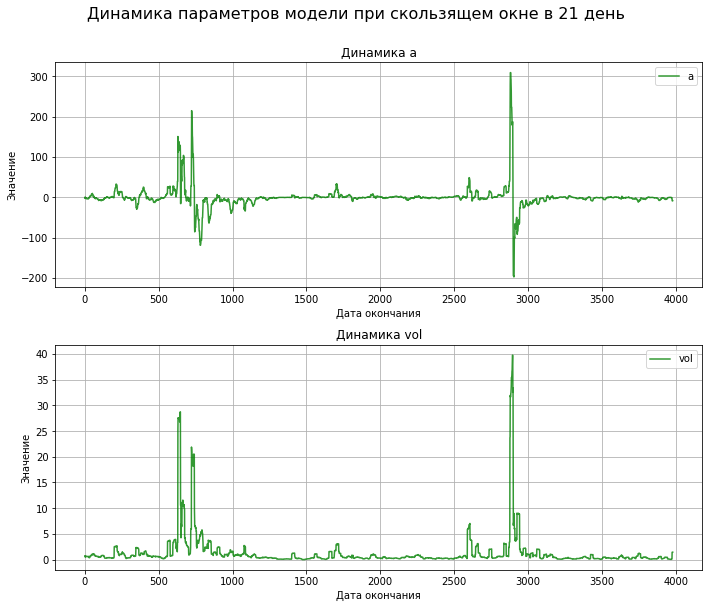

In [279]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)
plt.plot(db21['a'].values , 'g-',  alpha = 0.8, label = 'a')
plt.title('Динамика a')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(db21['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика параметров модели при скользящем окне в 21 день' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

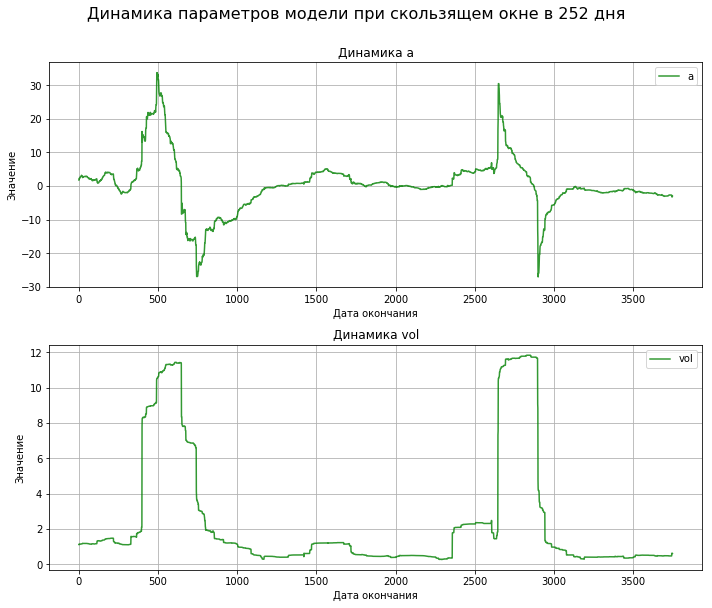

In [281]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)
plt.plot(db252['a'].values , 'g-',  alpha = 0.8, label = 'a')
plt.title('Динамика a')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(db252['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика параметров модели при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [284]:

def rolling_merton_len1_nonneg(db=mosprime3m, periods=21, p0=np.array([ 0.45,  0.4 ])):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    df_cal = pd.DataFrame(columns=["a", "vol"], index=end_dates)
    for i in tqdm(end_dates):
        x = pd.date_range(end = i, periods=periods, freq='d').strftime('%Y-%m-%d') # добавить ошибку на неправильный формат
        global data
        data = db.loc[x].dropna() # ошибку на формат датафрейма
        opt_ML_merton = sop.fmin(merton_ml_len1, p0, maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)
        df_cal.loc[i] = opt_ML_merton
    return df_cal

db21_nonneg = rolling_merton_len1_nonneg(periods=21)

  0%|          | 0/3981 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.367380
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -28.222849
         Iterations: 45
         Function evaluations: 85


  0%|          | 3/3981 [00:00<02:17, 28.91it/s]

Optimization terminated successfully.
         Current function value: -29.171289
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -29.007903
         Iterations: 56
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.007903
         Iterations: 56
         Function evaluations: 101


  0%|          | 6/3981 [00:00<02:37, 25.30it/s]

Optimization terminated successfully.
         Current function value: -29.007903
         Iterations: 56
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -24.658079
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -23.712520
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -24.346918
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.346918
         Iterations: 51
         Function evaluations: 97


  0%|          | 11/3981 [00:00<02:02, 32.46it/s]

Optimization terminated successfully.
         Current function value: -24.774750
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -24.774750
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -24.774750
         Iterations: 53
         Function evaluations: 101


  0%|          | 14/3981 [00:00<02:22, 27.90it/s]

Optimization terminated successfully.
         Current function value: -24.863545
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -24.983719
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -25.261886
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.261886
         Iterations: 48
         Function evaluations: 90


  0%|          | 18/3981 [00:00<02:26, 27.12it/s]

Optimization terminated successfully.
         Current function value: -25.617637
         Iterations: 56
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.617637
         Iterations: 56
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.617637
         Iterations: 56
         Function evaluations: 100


  1%|          | 21/3981 [00:00<02:27, 26.83it/s]

Optimization terminated successfully.
         Current function value: -25.518811
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -25.551598
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.387715
         Iterations: 41
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.014088
         Iterations: 53
         Function evaluations: 97


  1%|          | 25/3981 [00:00<02:23, 27.54it/s]

Optimization terminated successfully.
         Current function value: -30.241208
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -30.241208
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -30.241208
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 47
         Function evaluations: 95


  1%|          | 29/3981 [00:01<02:18, 28.57it/s]

Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 47
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 47
         Function evaluations: 95


  1%|          | 32/3981 [00:01<02:20, 28.11it/s]

Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -24.573878
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.459044
         Iterations: 58
         Function evaluations: 109


  1%|          | 37/3981 [00:01<02:15, 29.10it/s]

Optimization terminated successfully.
         Current function value: -23.516730
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.626123
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113


  1%|          | 41/3981 [00:01<02:22, 27.58it/s]

Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.929549
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.392479
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.758133
         Iterations: 55
         Function evaluations: 108


  1%|          | 45/3981 [00:01<02:25, 26.97it/s]

Optimization terminated successfully.
         Current function value: -17.668299
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 55
         Function evaluations: 106


  1%|          | 49/3981 [00:01<02:25, 26.96it/s]

Optimization terminated successfully.
         Current function value: -17.976085
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.058005
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.369753
         Iterations: 60
         Function evaluations: 114


  1%|▏         | 52/3981 [00:01<02:27, 26.71it/s]

Optimization terminated successfully.
         Current function value: -17.177644
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112


  1%|▏         | 55/3981 [00:02<02:31, 25.87it/s]

Optimization terminated successfully.
         Current function value: -18.286023
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -17.630583
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -15.982102
         Iterations: 57
         Function evaluations: 107


  1%|▏         | 58/3981 [00:02<02:32, 25.77it/s]

Optimization terminated successfully.
         Current function value: -15.806333
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -17.532686
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100


  2%|▏         | 61/3981 [00:02<02:33, 25.48it/s]

Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -17.458423
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -17.818409
         Iterations: 56
         Function evaluations: 111


  2%|▏         | 64/3981 [00:02<02:34, 25.43it/s]

Optimization terminated successfully.
         Current function value: -20.117635
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -22.529549
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.724305
         Iterations: 48
         Function evaluations: 91


  2%|▏         | 67/3981 [00:02<02:34, 25.41it/s]

Optimization terminated successfully.
         Current function value: -21.995565
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.995565
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.995565
         Iterations: 56
         Function evaluations: 104


  2%|▏         | 70/3981 [00:02<02:36, 25.05it/s]

Optimization terminated successfully.
         Current function value: -22.236969
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.423642
         Iterations: 38
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -21.858498
         Iterations: 49
         Function evaluations: 95


  2%|▏         | 73/3981 [00:02<02:38, 24.58it/s]

Optimization terminated successfully.
         Current function value: -22.790449
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.943735
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.943735
         Iterations: 50
         Function evaluations: 95


  2%|▏         | 76/3981 [00:03<02:38, 24.69it/s]

Optimization terminated successfully.
         Current function value: -23.943735
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -24.514924
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -25.261903
         Iterations: 61
         Function evaluations: 113


  2%|▏         | 79/3981 [00:03<02:38, 24.62it/s]

Optimization terminated successfully.
         Current function value: -24.983719
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -25.074592
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -25.044574
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -25.044574
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -25.044574
         Iterations: 45
         Function evaluations: 87


  2%|▏         | 84/3981 [00:03<02:35, 25.14it/s]

Optimization terminated successfully.
         Current function value: -24.571837
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -24.804223
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -24.687066
         Iterations: 65
         Function evaluations: 119


  2%|▏         | 87/3981 [00:03<02:36, 24.92it/s]

Optimization terminated successfully.
         Current function value: -25.785511
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -25.389179
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.199486
         Iterations: 55
         Function evaluations: 101


  2%|▏         | 90/3981 [00:03<02:35, 25.01it/s]

Optimization terminated successfully.
         Current function value: -26.199486
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -23.969903
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.557343
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -22.255895
         Iterations: 73
         Function evaluations: 133


  2%|▏         | 94/3981 [00:03<02:34, 25.20it/s]

Optimization terminated successfully.
         Current function value: -22.049529
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -24.634468
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.634468
         Iterations: 60
         Function evaluations: 109


  2%|▏         | 97/3981 [00:03<02:35, 24.96it/s]

Optimization terminated successfully.
         Current function value: -24.634468
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.302949
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.056309
         Iterations: 68
         Function evaluations: 127


  3%|▎         | 100/3981 [00:03<02:34, 25.06it/s]

Optimization terminated successfully.
         Current function value: -24.056309
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -23.953286
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.953286
         Iterations: 55
         Function evaluations: 106


  3%|▎         | 103/3981 [00:04<02:35, 24.86it/s]

Optimization terminated successfully.
         Current function value: -23.953286
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.953286
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.686701
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -23.525402
         Iterations: 70
         Function evaluations: 126


  3%|▎         | 107/3981 [00:04<02:34, 25.14it/s]

Optimization terminated successfully.
         Current function value: -22.802430
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.005125
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -20.185946
         Iterations: 60
         Function evaluations: 113


  3%|▎         | 110/3981 [00:04<02:33, 25.18it/s]

Optimization terminated successfully.
         Current function value: -19.083686
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -19.083686
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -21.194282
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.146858
         Iterations: 65
         Function evaluations: 120


  3%|▎         | 114/3981 [00:04<02:32, 25.32it/s]

Optimization terminated successfully.
         Current function value: -20.041358
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.146858
         Iterations: 65
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -20.146837
         Iterations: 58
         Function evaluations: 110


  3%|▎         | 117/3981 [00:04<02:32, 25.39it/s]

Optimization terminated successfully.
         Current function value: -20.146837
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.146837
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.331471
         Iterations: 51
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -20.331471
         Iterations: 51
         Function evaluations: 102


  3%|▎         | 121/3981 [00:04<02:30, 25.61it/s]

Optimization terminated successfully.
         Current function value: -20.378412
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -20.617888
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -20.749039
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -20.749039
         Iterations: 61
         Function evaluations: 116


  3%|▎         | 125/3981 [00:04<02:30, 25.66it/s]

Optimization terminated successfully.
         Current function value: -20.749039
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -20.882694
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -21.157914
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -21.299688
         Iterations: 58
         Function evaluations: 111


  3%|▎         | 129/3981 [00:04<02:28, 25.87it/s]

Optimization terminated successfully.
         Current function value: -22.975777
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -22.946565
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.745398
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -24.745398
         Iterations: 54
         Function evaluations: 99


  3%|▎         | 133/3981 [00:05<02:29, 25.73it/s]

Optimization terminated successfully.
         Current function value: -30.477963
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -29.210312
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -30.304244
         Iterations: 87
         Function evaluations: 165


  3%|▎         | 136/3981 [00:05<02:30, 25.56it/s]

Optimization terminated successfully.
         Current function value: -31.010939
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -31.469414
         Iterations: 51
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -31.469414
         Iterations: 51
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -31.469414
         Iterations: 51
         Function evaluations: 103


  4%|▎         | 140/3981 [00:05<02:29, 25.65it/s]

Optimization terminated successfully.
         Current function value: -31.478687
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -31.478703
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.478711
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -31.643097
         Iterations: 53
         Function evaluations: 98


  4%|▎         | 144/3981 [00:05<02:28, 25.88it/s]

Optimization terminated successfully.
         Current function value: -31.643097
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.643097
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.643097
         Iterations: 53
         Function evaluations: 98


  4%|▎         | 147/3981 [00:05<02:27, 25.93it/s]

Optimization terminated successfully.
         Current function value: -30.874995
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.162850
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -28.006291
         Iterations: 47
         Function evaluations: 90


  4%|▍         | 150/3981 [00:05<02:28, 25.87it/s]

Optimization terminated successfully.
         Current function value: -30.089788
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -31.364311
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -28.487179
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.487179
         Iterations: 39
         Function evaluations: 76


  4%|▍         | 154/3981 [00:05<02:26, 26.11it/s]

Optimization terminated successfully.
         Current function value: -31.364311
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.094592
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -33.968463
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -33.143981
         Iterations: 61
         Function evaluations: 113


  4%|▍         | 158/3981 [00:06<02:26, 26.12it/s]

Optimization terminated successfully.
         Current function value: -33.241864
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.241864
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.241864
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 54
         Function evaluations: 99


  4%|▍         | 162/3981 [00:06<02:25, 26.29it/s]

Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -30.985871
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.148758
         Iterations: 53
         Function evaluations: 97


  4%|▍         | 166/3981 [00:06<02:24, 26.34it/s]

Optimization terminated successfully.
         Current function value: -32.148758
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.148758
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -31.819285
         Iterations: 63
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -33.241883
         Iterations: 48
         Function evaluations: 90


  4%|▍         | 170/3981 [00:06<02:25, 26.21it/s]

Optimization terminated successfully.
         Current function value: -33.753061
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -34.190704
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75


  4%|▍         | 174/3981 [00:06<02:25, 26.15it/s]

Optimization terminated successfully.
         Current function value: -34.086642
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.150497
         Iterations: 31
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -34.478810
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 54
         Function evaluations: 103


  4%|▍         | 178/3981 [00:06<02:24, 26.27it/s]

Optimization terminated successfully.
         Current function value: -35.232225
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99


  5%|▍         | 181/3981 [00:06<02:24, 26.23it/s]

Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -33.813931
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -33.836895
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.207508
         Iterations: 50
         Function evaluations: 94


  5%|▍         | 185/3981 [00:07<02:25, 26.13it/s]

Optimization terminated successfully.
         Current function value: -38.207508
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86


  5%|▍         | 188/3981 [00:07<02:25, 26.05it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.723604
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.110073
         Iterations: 39
         Function evaluations: 74


  5%|▍         | 191/3981 [00:07<02:26, 25.86it/s]

Optimization terminated successfully.
         Current function value: -33.647774
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -33.647522
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -33.647522
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -33.647522
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -33.647522
         Iterations: 39
         Function evaluations: 78


  5%|▍         | 196/3981 [00:07<02:24, 26.13it/s]

Optimization terminated successfully.
         Current function value: -34.078699
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -34.078699
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.501503
         Iterations: 54
         Function evaluations: 100


  5%|▍         | 199/3981 [00:07<02:25, 25.98it/s]

Optimization terminated successfully.
         Current function value: -6.282017
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132


  5%|▌         | 202/3981 [00:07<02:25, 25.91it/s]

Optimization terminated successfully.
         Current function value: -5.895573
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.854908
         Iterations: 68
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -5.761904
         Iterations: 75
         Function evaluations: 142


  5%|▌         | 205/3981 [00:07<02:27, 25.66it/s]

Optimization terminated successfully.
         Current function value: -5.759821
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -5.759821
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135


  5%|▌         | 208/3981 [00:08<02:27, 25.50it/s]

Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.862656
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -5.517400
         Iterations: 71
         Function evaluations: 136


  5%|▌         | 211/3981 [00:08<02:28, 25.34it/s]

Optimization terminated successfully.
         Current function value: -6.099019
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -6.297748
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -6.245003
         Iterations: 69
         Function evaluations: 134


  5%|▌         | 214/3981 [00:08<02:28, 25.29it/s]

Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -5.457553
         Iterations: 80
         Function evaluations: 152


  5%|▌         | 217/3981 [00:08<02:29, 25.23it/s]

Optimization terminated successfully.
         Current function value: -5.345128
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -5.100735
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -11.706478
         Iterations: 65
         Function evaluations: 127


  6%|▌         | 220/3981 [00:08<02:29, 25.10it/s]

Optimization terminated successfully.
         Current function value: -12.336850
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135


  6%|▌         | 223/3981 [00:08<02:29, 25.10it/s]

Optimization terminated successfully.
         Current function value: -12.497545
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -13.233493
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -13.980988
         Iterations: 66
         Function evaluations: 123


  6%|▌         | 226/3981 [00:09<02:30, 24.89it/s]

Optimization terminated successfully.
         Current function value: -13.421415
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -13.518355
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121


  6%|▌         | 229/3981 [00:09<02:30, 24.93it/s]

Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.780624
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.691293
         Iterations: 61
         Function evaluations: 114


  6%|▌         | 232/3981 [00:09<02:31, 24.81it/s]

Optimization terminated successfully.
         Current function value: -19.582389
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -19.475153
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.803119
         Iterations: 65
         Function evaluations: 123


  6%|▌         | 235/3981 [00:09<02:30, 24.83it/s]

Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117


  6%|▌         | 238/3981 [00:09<02:31, 24.69it/s]

Optimization terminated successfully.
         Current function value: -18.824483
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.664700
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.075835
         Iterations: 64
         Function evaluations: 124


  6%|▌         | 241/3981 [00:09<02:32, 24.57it/s]

Optimization terminated successfully.
         Current function value: -17.963781
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120


  6%|▌         | 244/3981 [00:09<02:32, 24.57it/s]

Optimization terminated successfully.
         Current function value: -18.149643
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.307973
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.769925
         Iterations: 65
         Function evaluations: 123


  6%|▌         | 247/3981 [00:10<02:31, 24.60it/s]

Optimization terminated successfully.
         Current function value: -18.767253
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.035032
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125


  6%|▋         | 250/3981 [00:10<02:31, 24.64it/s]

Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.284659
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -16.069325
         Iterations: 64
         Function evaluations: 123


  6%|▋         | 253/3981 [00:10<02:31, 24.58it/s]

Optimization terminated successfully.
         Current function value: -14.636931
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -13.114928
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -15.492272
         Iterations: 43
         Function evaluations: 81


  6%|▋         | 256/3981 [00:10<02:31, 24.61it/s]

Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -15.417369
         Iterations: 71
         Function evaluations: 135


  7%|▋         | 259/3981 [00:10<02:31, 24.64it/s]

Optimization terminated successfully.
         Current function value: -15.302424
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -16.149744
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -16.149744
         Iterations: 72
         Function evaluations: 136


  7%|▋         | 262/3981 [00:10<02:31, 24.53it/s]

Optimization terminated successfully.
         Current function value: -16.288358
         Iterations: 56
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -16.367370
         Iterations: 51
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -16.367370
         Iterations: 51
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -16.367370
         Iterations: 51
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -18.313808
         Iterations: 62
         Function evaluations: 121


  7%|▋         | 267/3981 [00:10<02:31, 24.53it/s]

Optimization terminated successfully.
         Current function value: -18.735264
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -19.196970
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -19.357897
         Iterations: 61
         Function evaluations: 115


  7%|▋         | 270/3981 [00:11<02:31, 24.54it/s]

Optimization terminated successfully.
         Current function value: -20.865847
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -20.865847
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -20.865847
         Iterations: 53
         Function evaluations: 105


  7%|▋         | 273/3981 [00:11<02:31, 24.49it/s]

Optimization terminated successfully.
         Current function value: -22.702397
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.776668
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -30.488651
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -31.336338
         Iterations: 46
         Function evaluations: 84


  7%|▋         | 277/3981 [00:11<02:30, 24.59it/s]

Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.979268
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.033760
         Iterations: 43
         Function evaluations: 86


  7%|▋         | 281/3981 [00:11<02:29, 24.68it/s]

Optimization terminated successfully.
         Current function value: -36.223024
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.230930
         Iterations: 39
         Function evaluations: 75


  7%|▋         | 284/3981 [00:11<02:30, 24.60it/s]

Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112


  7%|▋         | 287/3981 [00:11<02:30, 24.48it/s]

Optimization terminated successfully.
         Current function value: -34.501718
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -32.164783
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.860425
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -30.762680
         Iterations: 58
         Function evaluations: 104


  7%|▋         | 291/3981 [00:11<02:30, 24.57it/s]

Optimization terminated successfully.
         Current function value: -30.762667
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -30.762667
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -30.762667
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -31.162805
         Iterations: 58
         Function evaluations: 104


  7%|▋         | 295/3981 [00:12<02:30, 24.56it/s]

Optimization terminated successfully.
         Current function value: -31.266808
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -30.959663
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.959663
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.781319
         Iterations: 47
         Function evaluations: 91


  8%|▊         | 299/3981 [00:12<02:29, 24.62it/s]

Optimization terminated successfully.
         Current function value: -31.781319
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.781319
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.047427
         Iterations: 61
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.143980
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -33.544089
         Iterations: 55
         Function evaluations: 100


  8%|▊         | 304/3981 [00:12<02:28, 24.81it/s]

Optimization terminated successfully.
         Current function value: -32.674004
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -31.347472
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.347472
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.347472
         Iterations: 39
         Function evaluations: 76


  8%|▊         | 308/3981 [00:12<02:27, 24.83it/s]

Optimization terminated successfully.
         Current function value: -32.318897
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -33.753042
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.684304
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.038461
         Iterations: 54
         Function evaluations: 98


  8%|▊         | 312/3981 [00:12<02:27, 24.92it/s]

Optimization terminated successfully.
         Current function value: -22.947249
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -22.947249
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -22.947249
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -20.269399
         Iterations: 62
         Function evaluations: 118


  8%|▊         | 316/3981 [00:12<02:26, 24.99it/s]

Optimization terminated successfully.
         Current function value: -19.791602
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -19.578379
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140


  8%|▊         | 320/3981 [00:12<02:26, 25.07it/s]

Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -19.536513
         Iterations: 73
         Function evaluations: 140


  8%|▊         | 324/3981 [00:12<02:26, 25.03it/s]

Optimization terminated successfully.
         Current function value: -19.648740
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -20.011515
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.011515
         Iterations: 57
         Function evaluations: 111


  8%|▊         | 327/3981 [00:13<02:26, 24.95it/s]

Optimization terminated successfully.
         Current function value: -20.011515
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.011515
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -19.966976
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.423641
         Iterations: 38
         Function evaluations: 77


  8%|▊         | 331/3981 [00:13<02:26, 24.95it/s]

Optimization terminated successfully.
         Current function value: -24.923373
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -22.075112
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -24.983720
         Iterations: 59
         Function evaluations: 112


  8%|▊         | 334/3981 [00:13<02:25, 24.98it/s]

Optimization terminated successfully.
         Current function value: -24.983720
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.983720
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -23.818685
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -22.019905
         Iterations: 64
         Function evaluations: 117


  8%|▊         | 338/3981 [00:13<02:25, 25.07it/s]

Optimization terminated successfully.
         Current function value: -19.830647
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -19.554825
         Iterations: 65
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -17.300563
         Iterations: 61
         Function evaluations: 111


  9%|▊         | 341/3981 [00:13<02:25, 25.01it/s]

Optimization terminated successfully.
         Current function value: -17.300563
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.300563
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.300563
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -15.120907
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -7.893215
         Iterations: 83
         Function evaluations: 156


  9%|▊         | 346/3981 [00:13<02:25, 25.03it/s]

Optimization terminated successfully.
         Current function value: -3.055974
         Iterations: 93
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -2.928129
         Iterations: 96
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -2.928129
         Iterations: 96
         Function evaluations: 177


  9%|▉         | 349/3981 [00:13<02:25, 25.01it/s]

Optimization terminated successfully.
         Current function value: -2.928129
         Iterations: 96
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -2.934682
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -2.533442
         Iterations: 85
         Function evaluations: 162


  9%|▉         | 352/3981 [00:14<02:25, 24.94it/s]

Optimization terminated successfully.
         Current function value: -2.704600
         Iterations: 90
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -2.729591
         Iterations: 97
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -2.768920
         Iterations: 80
         Function evaluations: 153


  9%|▉         | 355/3981 [00:14<02:25, 24.84it/s]

Optimization terminated successfully.
         Current function value: -2.768920
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -2.768920
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -3.587605
         Iterations: 89
         Function evaluations: 163


  9%|▉         | 358/3981 [00:14<02:25, 24.83it/s]

Optimization terminated successfully.
         Current function value: -4.348725
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -5.214998
         Iterations: 82
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -5.196209
         Iterations: 68
         Function evaluations: 136


  9%|▉         | 361/3981 [00:14<02:25, 24.84it/s]

Optimization terminated successfully.
         Current function value: -6.150032
         Iterations: 83
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -6.150032
         Iterations: 83
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -6.150032
         Iterations: 83
         Function evaluations: 161


  9%|▉         | 364/3981 [00:14<02:25, 24.82it/s]

Optimization terminated successfully.
         Current function value: -7.988513
         Iterations: 81
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -9.071658
         Iterations: 82
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -19.648740
         Iterations: 65
         Function evaluations: 124


  9%|▉         | 367/3981 [00:14<02:25, 24.80it/s]

Optimization terminated successfully.
         Current function value: -20.832274
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.587790
         Iterations: 43
         Function evaluations: 85


  9%|▉         | 371/3981 [00:14<02:25, 24.85it/s]

Optimization terminated successfully.
         Current function value: -22.801534
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -20.170760
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.382898
         Iterations: 62
         Function evaluations: 118


  9%|▉         | 374/3981 [00:15<02:25, 24.86it/s]

Optimization terminated successfully.
         Current function value: -20.435821
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109


  9%|▉         | 377/3981 [00:15<02:25, 24.82it/s]

Optimization terminated successfully.
         Current function value: -19.147900
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -19.455473
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.406340
         Iterations: 63
         Function evaluations: 121


 10%|▉         | 380/3981 [00:15<02:25, 24.73it/s]

Optimization terminated successfully.
         Current function value: -15.650229
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -15.768178
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119


 10%|▉         | 383/3981 [00:15<02:25, 24.75it/s]

Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.528624
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.534795
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -15.698319
         Iterations: 64
         Function evaluations: 123


 10%|▉         | 387/3981 [00:15<02:25, 24.78it/s]

Optimization terminated successfully.
         Current function value: -15.835811
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -15.835811
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118


 10%|▉         | 390/3981 [00:15<02:25, 24.72it/s]

Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.490632
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -17.522623
         Iterations: 65
         Function evaluations: 125


 10%|▉         | 393/3981 [00:15<02:25, 24.70it/s]

Optimization terminated successfully.
         Current function value: -17.569513
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -16.350199
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -16.415543
         Iterations: 67
         Function evaluations: 131


 10%|▉         | 396/3981 [00:16<02:25, 24.70it/s]

Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -15.633737
         Iterations: 72
         Function evaluations: 133


 10%|█         | 399/3981 [00:16<02:25, 24.62it/s]

Optimization terminated successfully.
         Current function value: -17.573435
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -17.573435
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.797608
         Iterations: 68
         Function evaluations: 130


 10%|█         | 402/3981 [00:16<02:25, 24.58it/s]

Optimization terminated successfully.
         Current function value: -11.893688
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129


 10%|█         | 405/3981 [00:16<02:25, 24.50it/s]

Optimization terminated successfully.
         Current function value: -11.872433
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -10.788232
         Iterations: 67
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -10.679231
         Iterations: 63
         Function evaluations: 120


 10%|█         | 408/3981 [00:16<02:25, 24.52it/s]

Optimization terminated successfully.
         Current function value: -10.426406
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -10.317370
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128


 10%|█         | 411/3981 [00:16<02:25, 24.52it/s]

Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.884112
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -10.921254
         Iterations: 63
         Function evaluations: 120


 10%|█         | 414/3981 [00:16<02:25, 24.49it/s]

Optimization terminated successfully.
         Current function value: -12.271290
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -12.496440
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -15.776499
         Iterations: 61
         Function evaluations: 119


 10%|█         | 417/3981 [00:17<02:25, 24.41it/s]

Optimization terminated successfully.
         Current function value: -17.019888
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -17.019888
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -17.019888
         Iterations: 83
         Function evaluations: 158


 11%|█         | 420/3981 [00:17<02:26, 24.33it/s]

Optimization terminated successfully.
         Current function value: -16.611378
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -16.567533
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -21.830601
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.124175
         Iterations: 51
         Function evaluations: 97


 11%|█         | 424/3981 [00:17<02:26, 24.33it/s]

Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.132082
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.350872
         Iterations: 44
         Function evaluations: 84


 11%|█         | 428/3981 [00:17<02:25, 24.37it/s]

Optimization terminated successfully.
         Current function value: -22.075112
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -20.899523
         Iterations: 47
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.088088
         Iterations: 56
         Function evaluations: 107


 11%|█         | 431/3981 [00:17<02:25, 24.32it/s]

Optimization terminated successfully.
         Current function value: -23.763243
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -23.763243
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -23.763243
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -23.391477
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -21.975819
         Iterations: 65
         Function evaluations: 121


 11%|█         | 436/3981 [00:17<02:25, 24.42it/s]

Optimization terminated successfully.
         Current function value: -21.462696
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -21.462700
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -22.155566
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.155566
         Iterations: 45
         Function evaluations: 88


 11%|█         | 440/3981 [00:17<02:24, 24.48it/s]

Optimization terminated successfully.
         Current function value: -22.155566
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.216526
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -22.216526
         Iterations: 58
         Function evaluations: 113


 11%|█         | 443/3981 [00:18<02:24, 24.50it/s]

Optimization terminated successfully.
         Current function value: -22.216526
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -22.196152
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -22.196152
         Iterations: 58
         Function evaluations: 109


 11%|█         | 446/3981 [00:18<02:24, 24.52it/s]

Optimization terminated successfully.
         Current function value: -22.196152
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -22.196152
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.486642
         Iterations: 60
         Function evaluations: 112


 11%|█▏        | 449/3981 [00:18<02:24, 24.52it/s]

Optimization terminated successfully.
         Current function value: -26.576093
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -27.598303
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -26.278177
         Iterations: 69
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -25.957510
         Iterations: 74
         Function evaluations: 142


 11%|█▏        | 453/3981 [00:18<02:24, 24.50it/s]

Optimization terminated successfully.
         Current function value: -25.957510
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -25.957510
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -29.338673
         Iterations: 60
         Function evaluations: 110


 11%|█▏        | 456/3981 [00:18<02:23, 24.52it/s]

Optimization terminated successfully.
         Current function value: -27.171353
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.967229
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -24.559322
         Iterations: 61
         Function evaluations: 104


 12%|█▏        | 459/3981 [00:18<02:24, 24.38it/s]

Optimization terminated successfully.
         Current function value: -22.224470
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -22.224470
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.166912
         Iterations: 61
         Function evaluations: 115


 12%|█▏        | 462/3981 [00:19<02:24, 24.30it/s]

Optimization terminated successfully.
         Current function value: -20.091330
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.441108
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -18.397533
         Iterations: 68
         Function evaluations: 127


 12%|█▏        | 465/3981 [00:19<02:24, 24.28it/s]

Optimization terminated successfully.
         Current function value: -17.896214
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -16.089014
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -16.089014
         Iterations: 59
         Function evaluations: 116


 12%|█▏        | 468/3981 [00:19<02:24, 24.28it/s]

Optimization terminated successfully.
         Current function value: -16.089014
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -16.076555
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -16.076555
         Iterations: 74
         Function evaluations: 140


 12%|█▏        | 471/3981 [00:19<02:24, 24.26it/s]

Optimization terminated successfully.
         Current function value: -16.383004
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -16.240603
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -15.977772
         Iterations: 64
         Function evaluations: 124


 12%|█▏        | 474/3981 [00:19<02:24, 24.24it/s]

Optimization terminated successfully.
         Current function value: -15.977772
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -15.977772
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -17.003525
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -17.135730
         Iterations: 76
         Function evaluations: 139


 12%|█▏        | 478/3981 [00:19<02:24, 24.29it/s]

Optimization terminated successfully.
         Current function value: -19.531507
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -21.467049
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.122334
         Iterations: 46
         Function evaluations: 90


 12%|█▏        | 481/3981 [00:19<02:24, 24.24it/s]

Optimization terminated successfully.
         Current function value: -21.122334
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -19.197596
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -20.996965
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -20.889879
         Iterations: 67
         Function evaluations: 122


 12%|█▏        | 485/3981 [00:19<02:24, 24.27it/s]

Optimization terminated successfully.
         Current function value: -21.679394
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -21.703440
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.891690
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -23.891690
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -23.891690
         Iterations: 57
         Function evaluations: 107


 12%|█▏        | 490/3981 [00:20<02:23, 24.35it/s]

Optimization terminated successfully.
         Current function value: -23.865813
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -24.514926
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -25.486178
         Iterations: 55
         Function evaluations: 102


 12%|█▏        | 493/3981 [00:20<02:23, 24.36it/s]

Optimization terminated successfully.
         Current function value: -24.745399
         Iterations: 64
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -24.155864
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.103785
         Iterations: 39
         Function evaluations: 77


 12%|█▏        | 496/3981 [00:20<02:22, 24.39it/s]

Optimization terminated successfully.
         Current function value: -25.103785
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -24.520268
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.375650
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.502557
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.048183
         Iterations: 72
         Function evaluations: 127


 13%|█▎        | 501/3981 [00:20<02:22, 24.48it/s]

Optimization terminated successfully.
         Current function value: -24.787416
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.787416
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.787416
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -25.145082
         Iterations: 50
         Function evaluations: 93


 13%|█▎        | 505/3981 [00:20<02:22, 24.47it/s]

Optimization terminated successfully.
         Current function value: -24.559322
         Iterations: 61
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.559322
         Iterations: 61
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.559322
         Iterations: 61
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.596786
         Iterations: 65
         Function evaluations: 120


 13%|█▎        | 509/3981 [00:20<02:22, 24.42it/s]

Optimization terminated successfully.
         Current function value: -24.596786
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.596786
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.634467
         Iterations: 56
         Function evaluations: 104


 13%|█▎        | 512/3981 [00:20<02:22, 24.43it/s]

Optimization terminated successfully.
         Current function value: -24.196095
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -26.208896
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -27.307848
         Iterations: 45
         Function evaluations: 84


 13%|█▎        | 515/3981 [00:21<02:21, 24.43it/s]

Optimization terminated successfully.
         Current function value: -30.959663
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.010943
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.010943
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.862785
         Iterations: 47
         Function evaluations: 89


 13%|█▎        | 519/3981 [00:21<02:21, 24.48it/s]

Optimization terminated successfully.
         Current function value: -31.478711
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -30.172370
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -33.067222
         Iterations: 62
         Function evaluations: 115


 13%|█▎        | 522/3981 [00:21<02:21, 24.45it/s]

Optimization terminated successfully.
         Current function value: -36.129610
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.129610
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.129610
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123


 13%|█▎        | 526/3981 [00:21<02:21, 24.50it/s]

Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123


 13%|█▎        | 529/3981 [00:21<02:20, 24.49it/s]

Optimization terminated successfully.
         Current function value: -38.193195
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -38.193195
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -38.193195
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -42.469571
         Iterations: 63
         Function evaluations: 120


 13%|█▎        | 533/3981 [00:21<02:20, 24.46it/s]

Optimization terminated successfully.
         Current function value: -41.132168
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.469571
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -39.755121
         Iterations: 49
         Function evaluations: 96


 13%|█▎        | 536/3981 [00:21<02:21, 24.41it/s]

Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120


 14%|█▎        | 539/3981 [00:22<02:21, 24.41it/s]

Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.857685
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84


 14%|█▎        | 542/3981 [00:22<02:21, 24.38it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 45
         Function evaluations: 84


 14%|█▎        | 546/3981 [00:22<02:20, 24.45it/s]

Optimization terminated successfully.
         Current function value: -33.341178
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -28.347729
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.932859
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.144053
         Iterations: 53
         Function evaluations: 101


 14%|█▍        | 550/3981 [00:22<02:20, 24.49it/s]

Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.226286
         Iterations: 53
         Function evaluations: 104


 14%|█▍        | 553/3981 [00:22<02:20, 24.47it/s]

Optimization terminated successfully.
         Current function value: -26.652598
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.752204
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -26.543561
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.760569
         Iterations: 58
         Function evaluations: 111


 14%|█▍        | 557/3981 [00:22<02:19, 24.50it/s]

Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.024423
         Iterations: 62
         Function evaluations: 120


 14%|█▍        | 560/3981 [00:22<02:20, 24.43it/s]

Optimization terminated successfully.
         Current function value: -1.026217
         Iterations: 81
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -1.073628
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -1.002526
         Iterations: 79
         Function evaluations: 153


 14%|█▍        | 563/3981 [00:23<02:20, 24.35it/s]

Optimization terminated successfully.
         Current function value: -1.002526
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146


 14%|█▍        | 566/3981 [00:23<02:20, 24.37it/s]

Optimization terminated successfully.
         Current function value: -0.973865
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.879168
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.853212
         Iterations: 67
         Function evaluations: 127


 14%|█▍        | 569/3981 [00:23<02:20, 24.33it/s]

Optimization terminated successfully.
         Current function value: -0.974987
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.454974
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134


 14%|█▍        | 572/3981 [00:23<02:20, 24.30it/s]

Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.461600
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.347511
         Iterations: 70
         Function evaluations: 134


 14%|█▍        | 575/3981 [00:23<02:20, 24.25it/s]

Optimization terminated successfully.
         Current function value: -0.416480
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.502776
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.439071
         Iterations: 73
         Function evaluations: 139


 15%|█▍        | 578/3981 [00:23<02:20, 24.18it/s]

Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -22.998341
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 56
         Function evaluations: 109


 15%|█▍        | 582/3981 [00:24<02:20, 24.15it/s]

Optimization terminated successfully.
         Current function value: -21.751767
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -21.346742
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -21.099093
         Iterations: 62
         Function evaluations: 120


 15%|█▍        | 585/3981 [00:24<02:20, 24.15it/s]

Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -21.214863
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -20.824846
         Iterations: 56
         Function evaluations: 108


 15%|█▍        | 589/3981 [00:24<02:20, 24.19it/s]

Optimization terminated successfully.
         Current function value: -20.302827
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.624144
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.717274
         Iterations: 65
         Function evaluations: 124


 15%|█▍        | 592/3981 [00:24<02:20, 24.16it/s]

Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -22.247211
         Iterations: 64
         Function evaluations: 125


 15%|█▍        | 595/3981 [00:24<02:20, 24.11it/s]

Optimization terminated successfully.
         Current function value: -21.125409
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -4.009159
         Iterations: 81
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -2.317896
         Iterations: 74
         Function evaluations: 142


 15%|█▌        | 598/3981 [00:24<02:20, 24.09it/s]

Optimization terminated successfully.
         Current function value: -1.695182
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132


 15%|█▌        | 601/3981 [00:24<02:20, 24.10it/s]

Optimization terminated successfully.
         Current function value: -1.856492
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.972924
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.355701
         Iterations: 69
         Function evaluations: 133


 15%|█▌        | 604/3981 [00:25<02:20, 24.06it/s]

Optimization terminated successfully.
         Current function value: -0.296078
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.042625
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134


 15%|█▌        | 607/3981 [00:25<02:20, 24.01it/s]

Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 0.104999
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 0.171979
         Iterations: 72
         Function evaluations: 133


 15%|█▌        | 610/3981 [00:25<02:20, 24.03it/s]

Optimization terminated successfully.
         Current function value: 0.168704
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 0.226758
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.218781
         Iterations: 71
         Function evaluations: 134


 15%|█▌        | 613/3981 [00:25<02:20, 24.05it/s]

Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 0.272963
         Iterations: 66
         Function evaluations: 126


 15%|█▌        | 616/3981 [00:25<02:20, 24.03it/s]

Optimization terminated successfully.
         Current function value: -4.769782
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -7.631165
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -8.230404
         Iterations: 61
         Function evaluations: 115


 16%|█▌        | 619/3981 [00:25<02:20, 24.01it/s]

Optimization terminated successfully.
         Current function value: -7.905950
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118


 16%|█▌        | 622/3981 [00:25<02:19, 24.01it/s]

Optimization terminated successfully.
         Current function value: -6.352556
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -10.197682
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -10.691188
         Iterations: 76
         Function evaluations: 144


 16%|█▌        | 625/3981 [00:26<02:20, 23.96it/s]

Optimization terminated successfully.
         Current function value: -11.685722
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -13.054814
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143


 16%|█▌        | 628/3981 [00:26<02:20, 23.93it/s]

Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -1.927468
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 26.353636
         Iterations: 80
         Function evaluations: 154


 16%|█▌        | 631/3981 [00:26<02:20, 23.90it/s]

Optimization terminated successfully.
         Current function value: 27.611657
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 27.583815
         Iterations: 87
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 27.543143
         Iterations: 90
         Function evaluations: 167


 16%|█▌        | 634/3981 [00:26<02:20, 23.90it/s]

Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 27.530538
         Iterations: 91
         Function evaluations: 172


 16%|█▌        | 637/3981 [00:26<02:20, 23.86it/s]

Optimization terminated successfully.
         Current function value: 27.518390
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 27.546649
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 27.592428
         Iterations: 86
         Function evaluations: 159


 16%|█▌        | 640/3981 [00:26<02:20, 23.80it/s]

Optimization terminated successfully.
         Current function value: 27.616614
         Iterations: 91
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 27.631492
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 29.133396
         Iterations: 84
         Function evaluations: 158


 16%|█▌        | 643/3981 [00:27<02:20, 23.73it/s]

Optimization terminated successfully.
         Current function value: 29.133396
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 27.645690
         Iterations: 86
         Function evaluations: 164


 16%|█▌        | 645/3981 [00:27<02:20, 23.70it/s]

Optimization terminated successfully.
         Current function value: 26.138779
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 26.141365
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 26.168386
         Iterations: 84
         Function evaluations: 161


 16%|█▋        | 648/3981 [00:27<02:21, 23.63it/s]

Optimization terminated successfully.
         Current function value: 13.191920
         Iterations: 112
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 13.191920
         Iterations: 112
         Function evaluations: 210


 16%|█▋        | 650/3981 [00:27<02:21, 23.60it/s]

Optimization terminated successfully.
         Current function value: 13.191920
         Iterations: 112
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 1.275923
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 2.602427
         Iterations: 71
         Function evaluations: 139


 16%|█▋        | 653/3981 [00:27<02:21, 23.55it/s]

Optimization terminated successfully.
         Current function value: 7.618531
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 6.912852
         Iterations: 84
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137


 16%|█▋        | 656/3981 [00:27<02:21, 23.55it/s]

Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 6.695533
         Iterations: 69
         Function evaluations: 137


 17%|█▋        | 658/3981 [00:28<02:21, 23.50it/s]

Optimization terminated successfully.
         Current function value: 13.399282
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 13.177325
         Iterations: 92
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 13.857444
         Iterations: 80
         Function evaluations: 153


 17%|█▋        | 661/3981 [00:28<02:21, 23.50it/s]

Optimization terminated successfully.
         Current function value: 13.742791
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 13.869229
         Iterations: 85
         Function evaluations: 164


 17%|█▋        | 663/3981 [00:28<02:21, 23.46it/s]

Optimization terminated successfully.
         Current function value: 13.215508
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 13.215508
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 13.815436
         Iterations: 92
         Function evaluations: 174


 17%|█▋        | 666/3981 [00:28<02:21, 23.40it/s]

Optimization terminated successfully.
         Current function value: 14.360278
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 14.287892
         Iterations: 80
         Function evaluations: 154


 17%|█▋        | 668/3981 [00:28<02:21, 23.36it/s]

Optimization terminated successfully.
         Current function value: 13.833139
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158


 17%|█▋        | 671/3981 [00:28<02:21, 23.38it/s]

Optimization terminated successfully.
         Current function value: 14.094306
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 14.329040
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 13.280845
         Iterations: 75
         Function evaluations: 143


 17%|█▋        | 674/3981 [00:28<02:21, 23.29it/s]

Optimization terminated successfully.
         Current function value: 13.288526
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 13.321056
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137


 17%|█▋        | 677/3981 [00:29<02:21, 23.29it/s]

Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 1.188877
         Iterations: 74
         Function evaluations: 137


 17%|█▋        | 679/3981 [00:29<02:21, 23.26it/s]

Optimization terminated successfully.
         Current function value: 1.361724
         Iterations: 70
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -1.062189
         Iterations: 65
         Function evaluations: 123


 17%|█▋        | 681/3981 [00:29<02:22, 23.24it/s]

Optimization terminated successfully.
         Current function value: -1.716586
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -2.198389
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 83
         Function evaluations: 157


 17%|█▋        | 684/3981 [00:29<02:21, 23.23it/s]

Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 83
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -1.409516
         Iterations: 83
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -2.379238
         Iterations: 86
         Function evaluations: 162


 17%|█▋        | 687/3981 [00:29<02:22, 23.17it/s]

Optimization terminated successfully.
         Current function value: -2.379238
         Iterations: 86
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -3.825242
         Iterations: 93
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -4.265026
         Iterations: 87
         Function evaluations: 167


 17%|█▋        | 690/3981 [00:29<02:22, 23.15it/s]

Optimization terminated successfully.
         Current function value: -4.679099
         Iterations: 90
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -4.679099
         Iterations: 90
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -4.679099
         Iterations: 90
         Function evaluations: 165


 17%|█▋        | 693/3981 [00:29<02:21, 23.16it/s]

Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -5.178016
         Iterations: 79
         Function evaluations: 151


 17%|█▋        | 696/3981 [00:30<02:22, 23.13it/s]

Optimization terminated successfully.
         Current function value: -5.715241
         Iterations: 88
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 73
         Function evaluations: 141


 18%|█▊        | 698/3981 [00:30<02:22, 23.12it/s]

Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 73
         Function evaluations: 141


 18%|█▊        | 700/3981 [00:30<02:22, 23.10it/s]

Optimization terminated successfully.
         Current function value: -6.297148
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -6.931807
         Iterations: 79
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -6.608406
         Iterations: 86
         Function evaluations: 161


 18%|█▊        | 703/3981 [00:30<02:22, 23.07it/s]

Optimization terminated successfully.
         Current function value: -15.614114
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.195432
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -17.195432
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -17.195432
         Iterations: 87
         Function evaluations: 165


 18%|█▊        | 707/3981 [00:30<02:21, 23.10it/s]

Optimization terminated successfully.
         Current function value: -15.283907
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -13.417919
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -11.602005
         Iterations: 57
         Function evaluations: 110


 18%|█▊        | 710/3981 [00:30<02:21, 23.05it/s]

Optimization terminated successfully.
         Current function value: -9.841761
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -8.144181
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -8.144181
         Iterations: 71
         Function evaluations: 134


 18%|█▊        | 713/3981 [00:30<02:21, 23.07it/s]

Optimization terminated successfully.
         Current function value: -8.432097
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -8.432097
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.995690
         Iterations: 100
         Function evaluations: 189


 18%|█▊        | 716/3981 [00:31<02:21, 23.07it/s]

Optimization terminated successfully.
         Current function value: -3.376107
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 2.861068
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140


 18%|█▊        | 719/3981 [00:31<02:21, 23.04it/s]

Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 3.519071
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 3.473462
         Iterations: 71
         Function evaluations: 137


 18%|█▊        | 722/3981 [00:31<02:21, 23.01it/s]

Optimization terminated successfully.
         Current function value: 13.924890
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 13.771500
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 14.972123
         Iterations: 92
         Function evaluations: 178


 18%|█▊        | 725/3981 [00:31<02:21, 22.94it/s]

Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 16.408328
         Iterations: 86
         Function evaluations: 167


 18%|█▊        | 728/3981 [00:31<02:22, 22.88it/s]

Optimization terminated successfully.
         Current function value: 18.122728
         Iterations: 86
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 19.259057
         Iterations: 87
         Function evaluations: 164


 18%|█▊        | 730/3981 [00:31<02:22, 22.81it/s]

Optimization terminated successfully.
         Current function value: 20.740842
         Iterations: 88
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 22.058925
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 23.323375
         Iterations: 84
         Function evaluations: 161


 18%|█▊        | 733/3981 [00:32<02:22, 22.82it/s]

Optimization terminated successfully.
         Current function value: 23.323375
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 22.191436
         Iterations: 86
         Function evaluations: 166


 18%|█▊        | 735/3981 [00:32<02:22, 22.76it/s]

Optimization terminated successfully.
         Current function value: 22.573919
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 23.427185
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 23.375805
         Iterations: 82
         Function evaluations: 158


 19%|█▊        | 738/3981 [00:32<02:22, 22.77it/s]

Optimization terminated successfully.
         Current function value: 23.421079
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142


 19%|█▊        | 740/3981 [00:32<02:22, 22.73it/s]

Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 23.445654
         Iterations: 75
         Function evaluations: 142


 19%|█▊        | 742/3981 [00:32<02:22, 22.68it/s]

Optimization terminated successfully.
         Current function value: 13.749287
         Iterations: 114
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 11.672824
         Iterations: 117
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 10.960984
         Iterations: 99
         Function evaluations: 185


 19%|█▊        | 745/3981 [00:32<02:22, 22.69it/s]

Optimization terminated successfully.
         Current function value: 10.909235
         Iterations: 91
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 10.052034
         Iterations: 103
         Function evaluations: 193


 19%|█▉        | 747/3981 [00:33<02:22, 22.63it/s]

Optimization terminated successfully.
         Current function value: 10.052034
         Iterations: 103
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: 10.052034
         Iterations: 103
         Function evaluations: 193


 19%|█▉        | 749/3981 [00:33<02:22, 22.62it/s]

Optimization terminated successfully.
         Current function value: 9.738794
         Iterations: 93
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 9.186474
         Iterations: 101
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 8.946793
         Iterations: 106
         Function evaluations: 199


 19%|█▉        | 752/3981 [00:33<02:22, 22.63it/s]

Optimization terminated successfully.
         Current function value: 8.714450
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 6.851258
         Iterations: 77
         Function evaluations: 151


 19%|█▉        | 754/3981 [00:33<02:22, 22.61it/s]

Optimization terminated successfully.
         Current function value: 6.851258
         Iterations: 77
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 6.851258
         Iterations: 77
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -3.204525
         Iterations: 64
         Function evaluations: 127


 19%|█▉        | 757/3981 [00:33<02:22, 22.58it/s]

Optimization terminated successfully.
         Current function value: -4.013436
         Iterations: 82
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -5.622144
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -1.096438
         Iterations: 115
         Function evaluations: 211


 19%|█▉        | 760/3981 [00:33<02:22, 22.57it/s]

Optimization terminated successfully.
         Current function value: 1.444044
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 1.444044
         Iterations: 84
         Function evaluations: 161


 19%|█▉        | 762/3981 [00:33<02:22, 22.53it/s]

Optimization terminated successfully.
         Current function value: 1.444044
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 1.002997
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 0.913517
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 1.203727
         Iterations: 96
         Function evaluations: 185


 19%|█▉        | 766/3981 [00:34<02:22, 22.51it/s]

Optimization terminated successfully.
         Current function value: 2.350487
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 2.296507
         Iterations: 94
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 2.296507
         Iterations: 94
         Function evaluations: 180


 19%|█▉        | 769/3981 [00:34<02:22, 22.52it/s]

Optimization terminated successfully.
         Current function value: 2.296507
         Iterations: 94
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 2.600109
         Iterations: 122
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 2.569580
         Iterations: 97
         Function evaluations: 185


 19%|█▉        | 772/3981 [00:34<02:22, 22.50it/s]

Optimization terminated successfully.
         Current function value: 4.149927
         Iterations: 107
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 4.724858
         Iterations: 112
         Function evaluations: 210


 19%|█▉        | 774/3981 [00:34<02:22, 22.44it/s]

Optimization terminated successfully.
         Current function value: 6.354499
         Iterations: 102
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 6.354499
         Iterations: 102
         Function evaluations: 192


 19%|█▉        | 776/3981 [00:34<02:23, 22.41it/s]

Optimization terminated successfully.
         Current function value: 6.354499
         Iterations: 102
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 8.148039
         Iterations: 105
         Function evaluations: 198


 20%|█▉        | 778/3981 [00:34<02:23, 22.34it/s]

Optimization terminated successfully.
         Current function value: 9.592179
         Iterations: 103
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 10.225630
         Iterations: 106
         Function evaluations: 192


 20%|█▉        | 780/3981 [00:34<02:23, 22.30it/s]

Optimization terminated successfully.
         Current function value: 9.773912
         Iterations: 102
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 10.738302
         Iterations: 107
         Function evaluations: 200


 20%|█▉        | 782/3981 [00:35<02:23, 22.22it/s]

Optimization terminated successfully.
         Current function value: 10.738302
         Iterations: 107
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: 10.738302
         Iterations: 107
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: 10.712074
         Iterations: 78
         Function evaluations: 151


 20%|█▉        | 785/3981 [00:35<02:23, 22.21it/s]

Optimization terminated successfully.
         Current function value: 10.669856
         Iterations: 108
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: 10.372892
         Iterations: 112
         Function evaluations: 207


 20%|█▉        | 787/3981 [00:35<02:23, 22.20it/s]

Optimization terminated successfully.
         Current function value: 10.354688
         Iterations: 106
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 10.364230
         Iterations: 128
         Function evaluations: 241


 20%|█▉        | 789/3981 [00:35<02:24, 22.14it/s]

Optimization terminated successfully.
         Current function value: 10.364230
         Iterations: 128
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 10.364230
         Iterations: 128
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 10.647388
         Iterations: 104
         Function evaluations: 198


 20%|█▉        | 792/3981 [00:35<02:24, 22.09it/s]

Optimization terminated successfully.
         Current function value: 10.016598
         Iterations: 97
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 9.488586
         Iterations: 104
         Function evaluations: 197


 20%|█▉        | 794/3981 [00:36<02:24, 22.05it/s]

Optimization terminated successfully.
         Current function value: 8.319307
         Iterations: 104
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 6.417641
         Iterations: 101
         Function evaluations: 191


 20%|█▉        | 796/3981 [00:36<02:24, 22.01it/s]

Optimization terminated successfully.
         Current function value: 6.417641
         Iterations: 101
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 6.417641
         Iterations: 101
         Function evaluations: 191


 20%|██        | 798/3981 [00:36<02:24, 21.97it/s]

Optimization terminated successfully.
         Current function value: 4.090004
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.334939
         Iterations: 93
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -1.127021
         Iterations: 78
         Function evaluations: 153


 20%|██        | 801/3981 [00:36<02:24, 21.97it/s]

Optimization terminated successfully.
         Current function value: -11.878775
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -11.627031
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -11.627031
         Iterations: 74
         Function evaluations: 141


 20%|██        | 804/3981 [00:36<02:24, 21.98it/s]

Optimization terminated successfully.
         Current function value: -11.627031
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -12.261907
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -9.742575
         Iterations: 82
         Function evaluations: 156


 20%|██        | 807/3981 [00:36<02:24, 22.00it/s]

Optimization terminated successfully.
         Current function value: -9.794287
         Iterations: 86
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -10.019318
         Iterations: 81
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -10.108838
         Iterations: 61
         Function evaluations: 121


 20%|██        | 810/3981 [00:36<02:24, 22.00it/s]

Optimization terminated successfully.
         Current function value: -10.108838
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -10.108838
         Iterations: 61
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -10.167377
         Iterations: 80
         Function evaluations: 151


 20%|██        | 813/3981 [00:36<02:24, 21.99it/s]

Optimization terminated successfully.
         Current function value: -7.194177
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -6.318175
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -6.184679
         Iterations: 89
         Function evaluations: 171


 20%|██        | 816/3981 [00:37<02:24, 21.97it/s]

Optimization terminated successfully.
         Current function value: -7.561651
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -7.561651
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -7.561651
         Iterations: 75
         Function evaluations: 144


 21%|██        | 819/3981 [00:37<02:23, 21.96it/s]

Optimization terminated successfully.
         Current function value: -7.551597
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -7.551597
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -7.551597
         Iterations: 80
         Function evaluations: 148


 21%|██        | 822/3981 [00:37<02:23, 21.95it/s]

Optimization terminated successfully.
         Current function value: -7.353494
         Iterations: 81
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -6.366979
         Iterations: 86
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -6.366979
         Iterations: 86
         Function evaluations: 161


 21%|██        | 825/3981 [00:37<02:23, 21.96it/s]

Optimization terminated successfully.
         Current function value: -6.366979
         Iterations: 86
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -7.265546
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -6.497926
         Iterations: 85
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -3.082640
         Iterations: 74
         Function evaluations: 145


 21%|██        | 829/3981 [00:37<02:23, 21.98it/s]

Optimization terminated successfully.
         Current function value: -3.082640
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -2.277082
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -2.277082
         Iterations: 87
         Function evaluations: 166


 21%|██        | 832/3981 [00:37<02:23, 21.95it/s]

Optimization terminated successfully.
         Current function value: -2.277082
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -2.893208
         Iterations: 94
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -2.836766
         Iterations: 77
         Function evaluations: 145


 21%|██        | 835/3981 [00:38<02:23, 21.92it/s]

Optimization terminated successfully.
         Current function value: 0.083128
         Iterations: 86
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 3.416228
         Iterations: 104
         Function evaluations: 193


 21%|██        | 837/3981 [00:38<02:23, 21.87it/s]

Optimization terminated successfully.
         Current function value: 3.807656
         Iterations: 98
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 3.807656
         Iterations: 98
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 3.807656
         Iterations: 98
         Function evaluations: 176


 21%|██        | 840/3981 [00:38<02:23, 21.88it/s]

Optimization terminated successfully.
         Current function value: 3.807677
         Iterations: 81
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 3.807677
         Iterations: 81
         Function evaluations: 151


 21%|██        | 842/3981 [00:38<02:23, 21.86it/s]

Optimization terminated successfully.
         Current function value: 3.742106
         Iterations: 92
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 3.702153
         Iterations: 99
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 3.490390
         Iterations: 103
         Function evaluations: 201


 21%|██        | 845/3981 [00:38<02:23, 21.85it/s]

Optimization terminated successfully.
         Current function value: 3.490390
         Iterations: 103
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 3.490390
         Iterations: 103
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 3.307649
         Iterations: 101
         Function evaluations: 190


 21%|██▏       | 848/3981 [00:38<02:23, 21.82it/s]

Optimization terminated successfully.
         Current function value: 2.515888
         Iterations: 95
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 2.662670
         Iterations: 93
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 2.313280
         Iterations: 86
         Function evaluations: 164


 21%|██▏       | 851/3981 [00:39<02:23, 21.80it/s]

Optimization terminated successfully.
         Current function value: 2.043947
         Iterations: 98
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 2.043947
         Iterations: 98
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 2.043947
         Iterations: 98
         Function evaluations: 188


 21%|██▏       | 854/3981 [00:39<02:23, 21.81it/s]

Optimization terminated successfully.
         Current function value: 1.725265
         Iterations: 98
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.398833
         Iterations: 92
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -9.708311
         Iterations: 97
         Function evaluations: 184


 22%|██▏       | 857/3981 [00:39<02:23, 21.79it/s]

Optimization terminated successfully.
         Current function value: -13.130833
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -12.820153
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.820153
         Iterations: 70
         Function evaluations: 135


 22%|██▏       | 860/3981 [00:39<02:23, 21.79it/s]

Optimization terminated successfully.
         Current function value: -12.820153
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.820153
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.688126
         Iterations: 75
         Function evaluations: 144


 22%|██▏       | 863/3981 [00:39<02:23, 21.80it/s]

Optimization terminated successfully.
         Current function value: -13.633308
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -13.633308
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -12.177805
         Iterations: 74
         Function evaluations: 139


 22%|██▏       | 866/3981 [00:39<02:22, 21.78it/s]

Optimization terminated successfully.
         Current function value: -12.177805
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -12.177805
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -14.411751
         Iterations: 78
         Function evaluations: 146


 22%|██▏       | 869/3981 [00:39<02:22, 21.80it/s]

Optimization terminated successfully.
         Current function value: -16.633412
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -14.482703
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -11.467436
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -11.789309
         Iterations: 82
         Function evaluations: 153


 22%|██▏       | 873/3981 [00:39<02:22, 21.84it/s]

Optimization terminated successfully.
         Current function value: -11.789309
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -11.789309
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -12.133476
         Iterations: 82
         Function evaluations: 151


 22%|██▏       | 876/3981 [00:40<02:22, 21.83it/s]

Optimization terminated successfully.
         Current function value: -12.543778
         Iterations: 78
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -12.814025
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -13.173302
         Iterations: 74
         Function evaluations: 139


 22%|██▏       | 879/3981 [00:40<02:22, 21.82it/s]

Optimization terminated successfully.
         Current function value: -12.863267
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -12.863267
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -12.863267
         Iterations: 71
         Function evaluations: 133


 22%|██▏       | 882/3981 [00:40<02:22, 21.81it/s]

Optimization terminated successfully.
         Current function value: -13.019399
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -12.166695
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -12.161146
         Iterations: 71
         Function evaluations: 135


 22%|██▏       | 885/3981 [00:40<02:21, 21.81it/s]

Optimization terminated successfully.
         Current function value: -12.912886
         Iterations: 77
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -14.418239
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -14.418239
         Iterations: 66
         Function evaluations: 127


 22%|██▏       | 888/3981 [00:40<02:21, 21.80it/s]

Optimization terminated successfully.
         Current function value: -14.418239
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -14.358210
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -15.765857
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -20.441474
         Iterations: 65
         Function evaluations: 123


 22%|██▏       | 892/3981 [00:40<02:21, 21.82it/s]

Optimization terminated successfully.
         Current function value: -20.457330
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -20.315911
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -20.315911
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -20.315911
         Iterations: 53
         Function evaluations: 104


 23%|██▎       | 896/3981 [00:41<02:21, 21.82it/s]

Optimization terminated successfully.
         Current function value: -7.702109
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -7.425365
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -6.731463
         Iterations: 68
         Function evaluations: 127


 23%|██▎       | 899/3981 [00:41<02:21, 21.83it/s]

Optimization terminated successfully.
         Current function value: -6.754319
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116


 23%|██▎       | 902/3981 [00:41<02:21, 21.81it/s]

Optimization terminated successfully.
         Current function value: -6.662708
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -6.917580
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -6.584302
         Iterations: 67
         Function evaluations: 131


 23%|██▎       | 905/3981 [00:41<02:21, 21.79it/s]

Optimization terminated successfully.
         Current function value: -6.462094
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.370112
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110


 23%|██▎       | 908/3981 [00:41<02:21, 21.78it/s]

Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.390145
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.572437
         Iterations: 59
         Function evaluations: 111


 23%|██▎       | 911/3981 [00:41<02:21, 21.76it/s]

Optimization terminated successfully.
         Current function value: -6.661444
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -6.661444
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -6.603547
         Iterations: 50
         Function evaluations: 94


 23%|██▎       | 914/3981 [00:42<02:20, 21.76it/s]

Optimization terminated successfully.
         Current function value: -14.398169
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.398169
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.398169
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.810865
         Iterations: 75
         Function evaluations: 139


 23%|██▎       | 918/3981 [00:42<02:20, 21.80it/s]

Optimization terminated successfully.
         Current function value: -17.498427
         Iterations: 78
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -17.571614
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.916302
         Iterations: 68
         Function evaluations: 129


 23%|██▎       | 921/3981 [00:42<02:20, 21.77it/s]

Optimization terminated successfully.
         Current function value: -18.325509
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.325509
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -18.325509
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -19.330815
         Iterations: 54
         Function evaluations: 104


 23%|██▎       | 925/3981 [00:42<02:20, 21.78it/s]

Optimization terminated successfully.
         Current function value: -20.269399
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -21.335589
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -21.335589
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -20.716015
         Iterations: 62
         Function evaluations: 120


 23%|██▎       | 929/3981 [00:42<02:19, 21.81it/s]

Optimization terminated successfully.
         Current function value: -20.716015
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.716015
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -20.585480
         Iterations: 62
         Function evaluations: 119


 23%|██▎       | 932/3981 [00:42<02:19, 21.80it/s]

Optimization terminated successfully.
         Current function value: -19.620514
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -19.922719
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -25.325251
         Iterations: 55
         Function evaluations: 100


 23%|██▎       | 935/3981 [00:42<02:19, 21.82it/s]

Optimization terminated successfully.
         Current function value: -25.453695
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.453695
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.453695
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.751612
         Iterations: 65
         Function evaluations: 121


 24%|██▎       | 939/3981 [00:43<02:19, 21.84it/s]

Optimization terminated successfully.
         Current function value: -25.922770
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -26.062774
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -25.518808
         Iterations: 47
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -27.821965
         Iterations: 63
         Function evaluations: 117


 24%|██▎       | 943/3981 [00:43<02:18, 21.87it/s]

Optimization terminated successfully.
         Current function value: -27.821965
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -27.821965
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -28.589868
         Iterations: 56
         Function evaluations: 102


 24%|██▍       | 946/3981 [00:43<02:18, 21.87it/s]

Optimization terminated successfully.
         Current function value: -17.561114
         Iterations: 74
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.529700
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.916302
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -17.916301
         Iterations: 64
         Function evaluations: 123


 24%|██▍       | 950/3981 [00:43<02:18, 21.87it/s]

Optimization terminated successfully.
         Current function value: -17.916301
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.916301
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -18.612238
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -18.661190
         Iterations: 67
         Function evaluations: 127


 24%|██▍       | 954/3981 [00:43<02:18, 21.91it/s]

Optimization terminated successfully.
         Current function value: -18.083907
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -17.982863
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -17.937592
         Iterations: 54
         Function evaluations: 108


 24%|██▍       | 957/3981 [00:43<02:18, 21.91it/s]

Optimization terminated successfully.
         Current function value: -17.937592
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.937592
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.971692
         Iterations: 53
         Function evaluations: 105


 24%|██▍       | 960/3981 [00:43<02:17, 21.89it/s]

Optimization terminated successfully.
         Current function value: -17.872276
         Iterations: 78
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -17.774220
         Iterations: 72
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -17.817631
         Iterations: 73
         Function evaluations: 140


 24%|██▍       | 963/3981 [00:43<02:17, 21.91it/s]

Optimization terminated successfully.
         Current function value: -15.955169
         Iterations: 100
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -15.955169
         Iterations: 100
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -15.955169
         Iterations: 100
         Function evaluations: 189


 24%|██▍       | 966/3981 [00:44<02:17, 21.88it/s]

Optimization terminated successfully.
         Current function value: -22.834893
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -22.924634
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -21.299691
         Iterations: 64
         Function evaluations: 119


 24%|██▍       | 969/3981 [00:44<02:17, 21.89it/s]

Optimization terminated successfully.
         Current function value: -21.444399
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -21.499446
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -21.499446
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -21.499446
         Iterations: 62
         Function evaluations: 116


 24%|██▍       | 973/3981 [00:44<02:17, 21.93it/s]

Optimization terminated successfully.
         Current function value: -17.894254
         Iterations: 73
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -18.407932
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -15.137180
         Iterations: 74
         Function evaluations: 139


 25%|██▍       | 976/3981 [00:44<02:17, 21.93it/s]

Optimization terminated successfully.
         Current function value: -13.479334
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.922190
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -12.922190
         Iterations: 74
         Function evaluations: 139


 25%|██▍       | 979/3981 [00:44<02:16, 21.93it/s]

Optimization terminated successfully.
         Current function value: -12.922190
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -11.841590
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -11.090635
         Iterations: 70
         Function evaluations: 131


 25%|██▍       | 982/3981 [00:44<02:16, 21.92it/s]

Optimization terminated successfully.
         Current function value: -9.596418
         Iterations: 87
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -8.557319
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -5.282576
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -5.282576
         Iterations: 91
         Function evaluations: 172


 25%|██▍       | 986/3981 [00:45<02:16, 21.91it/s]

Optimization terminated successfully.
         Current function value: -5.282576
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -4.717529
         Iterations: 84
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -4.377433
         Iterations: 97
         Function evaluations: 180


 25%|██▍       | 989/3981 [00:45<02:16, 21.92it/s]

Optimization terminated successfully.
         Current function value: -4.353535
         Iterations: 92
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -4.254034
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -4.652489
         Iterations: 86
         Function evaluations: 163


 25%|██▍       | 992/3981 [00:45<02:16, 21.90it/s]

Optimization terminated successfully.
         Current function value: -4.652489
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -4.652489
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -4.525827
         Iterations: 99
         Function evaluations: 185


 25%|██▍       | 995/3981 [00:45<02:16, 21.91it/s]

Optimization terminated successfully.
         Current function value: -5.027549
         Iterations: 83
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -5.444263
         Iterations: 89
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -5.625014
         Iterations: 78
         Function evaluations: 151


 25%|██▌       | 998/3981 [00:45<02:16, 21.90it/s]

Optimization terminated successfully.
         Current function value: -5.781242
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -5.781242
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -5.781242
         Iterations: 86
         Function evaluations: 164


 25%|██▌       | 1001/3981 [00:45<02:16, 21.89it/s]

Optimization terminated successfully.
         Current function value: -6.100477
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -6.968730
         Iterations: 87
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -8.312296
         Iterations: 68
         Function evaluations: 133


 25%|██▌       | 1004/3981 [00:45<02:16, 21.87it/s]

Optimization terminated successfully.
         Current function value: -14.344940
         Iterations: 104
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -16.910181
         Iterations: 80
         Function evaluations: 149


 25%|██▌       | 1006/3981 [00:46<02:16, 21.86it/s]

Optimization terminated successfully.
         Current function value: -16.910181
         Iterations: 80
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -16.910181
         Iterations: 80
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -20.409872
         Iterations: 66
         Function evaluations: 124


 25%|██▌       | 1009/3981 [00:46<02:15, 21.87it/s]

Optimization terminated successfully.
         Current function value: -20.521112
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.602922
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.761682
         Iterations: 56
         Function evaluations: 110


 25%|██▌       | 1012/3981 [00:46<02:15, 21.87it/s]

Optimization terminated successfully.
         Current function value: -17.595052
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -17.595052
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -17.595052
         Iterations: 70
         Function evaluations: 130


 25%|██▌       | 1015/3981 [00:46<02:15, 21.88it/s]

Optimization terminated successfully.
         Current function value: -17.595052
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -17.595052
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -16.012893
         Iterations: 68
         Function evaluations: 129


 26%|██▌       | 1018/3981 [00:46<02:15, 21.90it/s]

Optimization terminated successfully.
         Current function value: -16.677223
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -14.602707
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -14.602707
         Iterations: 70
         Function evaluations: 135


 26%|██▌       | 1021/3981 [00:46<02:15, 21.91it/s]

Optimization terminated successfully.
         Current function value: -14.602707
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -14.570488
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -14.188256
         Iterations: 80
         Function evaluations: 148


 26%|██▌       | 1024/3981 [00:46<02:14, 21.91it/s]

Optimization terminated successfully.
         Current function value: -14.188256
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -14.188256
         Iterations: 80
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -14.195836
         Iterations: 89
         Function evaluations: 167


 26%|██▌       | 1027/3981 [00:46<02:14, 21.92it/s]

Optimization terminated successfully.
         Current function value: -14.195836
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -14.195836
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -14.252619
         Iterations: 51
         Function evaluations: 102


 26%|██▌       | 1030/3981 [00:47<02:14, 21.91it/s]

Optimization terminated successfully.
         Current function value: -14.067924
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -15.637118
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -17.709604
         Iterations: 78
         Function evaluations: 146


 26%|██▌       | 1033/3981 [00:47<02:14, 21.91it/s]

Optimization terminated successfully.
         Current function value: -16.665861
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.665861
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.665861
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.862529
         Iterations: 82
         Function evaluations: 153


 26%|██▌       | 1037/3981 [00:47<02:14, 21.94it/s]

Optimization terminated successfully.
         Current function value: -18.196177
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.872982
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -21.193090
         Iterations: 59
         Function evaluations: 111


 26%|██▌       | 1040/3981 [00:47<02:14, 21.94it/s]

Optimization terminated successfully.
         Current function value: -20.984638
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -20.984638
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -20.984638
         Iterations: 58
         Function evaluations: 112


 26%|██▌       | 1043/3981 [00:47<02:13, 21.94it/s]

Optimization terminated successfully.
         Current function value: -21.573520
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -21.554928
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -21.263976
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.677080
         Iterations: 58
         Function evaluations: 110


 26%|██▋       | 1047/3981 [00:47<02:13, 21.97it/s]

Optimization terminated successfully.
         Current function value: -19.691290
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -19.691290
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -19.691290
         Iterations: 71
         Function evaluations: 137


 26%|██▋       | 1050/3981 [00:47<02:13, 21.95it/s]

Optimization terminated successfully.
         Current function value: -20.056340
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -20.116554
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -20.116554
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.924634
         Iterations: 47
         Function evaluations: 91


 26%|██▋       | 1054/3981 [00:47<02:13, 21.97it/s]

Optimization terminated successfully.
         Current function value: -21.371670
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.371670
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.371670
         Iterations: 54
         Function evaluations: 104


 27%|██▋       | 1057/3981 [00:48<02:13, 21.98it/s]

Optimization terminated successfully.
         Current function value: -21.592162
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -22.075112
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.763246
         Iterations: 54
         Function evaluations: 105


 27%|██▋       | 1060/3981 [00:48<02:12, 21.99it/s]

Optimization terminated successfully.
         Current function value: -23.763246
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -18.503334
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -18.503334
         Iterations: 68
         Function evaluations: 129


 27%|██▋       | 1063/3981 [00:48<02:12, 22.00it/s]

Optimization terminated successfully.
         Current function value: -18.503334
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -18.325509
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -18.324616
         Iterations: 48
         Function evaluations: 95


 27%|██▋       | 1066/3981 [00:48<02:12, 22.01it/s]

Optimization terminated successfully.
         Current function value: -18.324616
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -17.916302
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -16.154864
         Iterations: 70
         Function evaluations: 133


 27%|██▋       | 1069/3981 [00:48<02:12, 22.01it/s]

Optimization terminated successfully.
         Current function value: -16.154864
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -16.154864
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -14.431926
         Iterations: 68
         Function evaluations: 129


 27%|██▋       | 1072/3981 [00:48<02:12, 22.02it/s]

Optimization terminated successfully.
         Current function value: -12.750703
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -11.242800
         Iterations: 98
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -10.276604
         Iterations: 65
         Function evaluations: 124


 27%|██▋       | 1075/3981 [00:48<02:12, 22.00it/s]

Optimization terminated successfully.
         Current function value: -8.693534
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -8.693534
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -8.693534
         Iterations: 68
         Function evaluations: 128


 27%|██▋       | 1078/3981 [00:48<02:11, 22.01it/s]

Optimization terminated successfully.
         Current function value: -1.607358
         Iterations: 88
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -1.359907
         Iterations: 91
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -1.349124
         Iterations: 97
         Function evaluations: 184


 27%|██▋       | 1081/3981 [00:49<02:11, 21.99it/s]

Optimization terminated successfully.
         Current function value: -1.744989
         Iterations: 78
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -1.579376
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -1.579376
         Iterations: 74
         Function evaluations: 145


 27%|██▋       | 1084/3981 [00:49<02:11, 21.99it/s]

Optimization terminated successfully.
         Current function value: -1.579376
         Iterations: 74
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -1.448201
         Iterations: 63
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -1.448201
         Iterations: 63
         Function evaluations: 126


 27%|██▋       | 1087/3981 [00:49<02:11, 22.01it/s]

Optimization terminated successfully.
         Current function value: -1.492866
         Iterations: 78
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -7.838660
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -9.240726
         Iterations: 76
         Function evaluations: 141


 27%|██▋       | 1090/3981 [00:49<02:11, 22.00it/s]

Optimization terminated successfully.
         Current function value: -9.240726
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -9.240726
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -10.794276
         Iterations: 80
         Function evaluations: 149


 27%|██▋       | 1093/3981 [00:49<02:11, 21.99it/s]

Optimization terminated successfully.
         Current function value: -12.325168
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -13.829172
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -15.492615
         Iterations: 66
         Function evaluations: 124


 28%|██▊       | 1096/3981 [00:49<02:11, 22.00it/s]

Optimization terminated successfully.
         Current function value: -17.193146
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -17.193146
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -17.193146
         Iterations: 67
         Function evaluations: 127


 28%|██▊       | 1099/3981 [00:49<02:11, 21.99it/s]

Optimization terminated successfully.
         Current function value: -19.835036
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -20.207860
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -19.412372
         Iterations: 67
         Function evaluations: 124


 28%|██▊       | 1102/3981 [00:50<02:10, 21.98it/s]

Optimization terminated successfully.
         Current function value: -21.259730
         Iterations: 43
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -23.224519
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -23.224519
         Iterations: 42
         Function evaluations: 80


 28%|██▊       | 1105/3981 [00:50<02:10, 21.99it/s]

Optimization terminated successfully.
         Current function value: -23.224519
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -26.062775
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -24.893396
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -25.922770
         Iterations: 56
         Function evaluations: 104


 28%|██▊       | 1109/3981 [00:50<02:10, 22.02it/s]

Optimization terminated successfully.
         Current function value: -25.261903
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -25.136882
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.136882
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.136882
         Iterations: 51
         Function evaluations: 96


 28%|██▊       | 1113/3981 [00:50<02:10, 22.04it/s]

Optimization terminated successfully.
         Current function value: -25.389179
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.785511
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -25.684304
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.421360
         Iterations: 52
         Function evaluations: 97


 28%|██▊       | 1117/3981 [00:50<02:09, 22.05it/s]

Optimization terminated successfully.
         Current function value: -24.458250
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -24.458250
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -24.458250
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -22.229737
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -21.822085
         Iterations: 61
         Function evaluations: 112


 28%|██▊       | 1122/3981 [00:50<02:09, 22.06it/s]

Optimization terminated successfully.
         Current function value: -21.475522
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -21.757568
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -21.789739
         Iterations: 64
         Function evaluations: 120


 28%|██▊       | 1125/3981 [00:50<02:09, 22.06it/s]

Optimization terminated successfully.
         Current function value: -23.589442
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -23.589442
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -22.282158
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -21.973800
         Iterations: 66
         Function evaluations: 121


 28%|██▊       | 1129/3981 [00:51<02:09, 22.08it/s]

Optimization terminated successfully.
         Current function value: -17.114086
         Iterations: 54
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -16.258205
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -15.631954
         Iterations: 54
         Function evaluations: 106


 28%|██▊       | 1132/3981 [00:51<02:09, 22.07it/s]

Optimization terminated successfully.
         Current function value: -15.631954
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -15.631954
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -13.979595
         Iterations: 57
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.686714
         Iterations: 67
         Function evaluations: 129


 29%|██▊       | 1136/3981 [00:51<02:08, 22.10it/s]

Optimization terminated successfully.
         Current function value: -12.410381
         Iterations: 68
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -10.724880
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -10.407020
         Iterations: 84
         Function evaluations: 156


 29%|██▊       | 1139/3981 [00:51<02:08, 22.09it/s]

Optimization terminated successfully.
         Current function value: -10.407020
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -10.407020
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -11.664787
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -12.884425
         Iterations: 75
         Function evaluations: 145


 29%|██▊       | 1143/3981 [00:51<02:08, 22.10it/s]

Optimization terminated successfully.
         Current function value: -12.965601
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -12.965601
         Iterations: 77
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -12.965601
         Iterations: 77
         Function evaluations: 146


 29%|██▉       | 1146/3981 [00:51<02:08, 22.10it/s]

Optimization terminated successfully.
         Current function value: -11.980655
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -11.980655
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -12.062076
         Iterations: 82
         Function evaluations: 154


 29%|██▉       | 1149/3981 [00:52<02:08, 22.08it/s]

Optimization terminated successfully.
         Current function value: -14.120429
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -14.749699
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -15.265160
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -16.938418
         Iterations: 66
         Function evaluations: 127


 29%|██▉       | 1153/3981 [00:52<02:07, 22.10it/s]

Optimization terminated successfully.
         Current function value: -16.938418
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -16.938418
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -18.747679
         Iterations: 54
         Function evaluations: 108


 29%|██▉       | 1156/3981 [00:52<02:07, 22.11it/s]

Optimization terminated successfully.
         Current function value: -19.052635
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -25.486178
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.489147
         Iterations: 61
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -29.626778
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.626778
         Iterations: 53
         Function evaluations: 100


 29%|██▉       | 1161/3981 [00:52<02:07, 22.15it/s]

Optimization terminated successfully.
         Current function value: -29.626778
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -32.064927
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -32.148758
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -31.819287
         Iterations: 54
         Function evaluations: 99


 29%|██▉       | 1165/3981 [00:52<02:07, 22.16it/s]

Optimization terminated successfully.
         Current function value: -33.143981
         Iterations: 57
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -32.858226
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -32.858226
         Iterations: 54
         Function evaluations: 100


 29%|██▉       | 1168/3981 [00:52<02:06, 22.16it/s]

Optimization terminated successfully.
         Current function value: -32.858226
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.581975
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -31.660188
         Iterations: 61
         Function evaluations: 111


 29%|██▉       | 1171/3981 [00:52<02:06, 22.15it/s]

Optimization terminated successfully.
         Current function value: -31.277580
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -31.504627
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -31.581976
         Iterations: 58
         Function evaluations: 107


 29%|██▉       | 1174/3981 [00:52<02:06, 22.16it/s]

Optimization terminated successfully.
         Current function value: -31.581976
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -31.581976
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -33.441895
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -33.441895
         Iterations: 52
         Function evaluations: 96


 30%|██▉       | 1178/3981 [00:53<02:06, 22.19it/s]

Optimization terminated successfully.
         Current function value: -36.591315
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.258485
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118


 30%|██▉       | 1181/3981 [00:53<02:06, 22.20it/s]

Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.996012
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -34.554852
         Iterations: 35
         Function evaluations: 70


 30%|██▉       | 1186/3981 [00:53<02:05, 22.22it/s]

Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115


 30%|██▉       | 1189/3981 [00:53<02:05, 22.22it/s]

Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.036432
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 36
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -32.972177
         Iterations: 48
         Function evaluations: 94


 30%|██▉       | 1193/3981 [00:53<02:05, 22.24it/s]

Optimization terminated successfully.
         Current function value: -31.347958
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80


 30%|███       | 1196/3981 [00:53<02:05, 22.24it/s]

Optimization terminated successfully.
         Current function value: -31.580720
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -28.687476
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -27.681888
         Iterations: 31
         Function evaluations: 57


 30%|███       | 1199/3981 [00:53<02:05, 22.25it/s]

Optimization terminated successfully.
         Current function value: -27.319829
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -27.239289
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -26.079061
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.079061
         Iterations: 58
         Function evaluations: 106


 30%|███       | 1203/3981 [00:54<02:04, 22.27it/s]

Optimization terminated successfully.
         Current function value: -26.079061
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.079061
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -27.653246
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -26.488287
         Iterations: 47
         Function evaluations: 89


 30%|███       | 1207/3981 [00:54<02:04, 22.29it/s]

Optimization terminated successfully.
         Current function value: -27.739579
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -26.583176
         Iterations: 25
         Function evaluations: 50


 30%|███       | 1211/3981 [00:54<02:04, 22.33it/s]

Optimization terminated successfully.
         Current function value: -28.631285
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -28.561766
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.064777
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.064779
         Iterations: 49
         Function evaluations: 92


 31%|███       | 1215/3981 [00:54<02:03, 22.36it/s]

Optimization terminated successfully.
         Current function value: -29.064779
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.064779
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.064779
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -31.739285
         Iterations: 58
         Function evaluations: 108


 31%|███       | 1219/3981 [00:54<02:03, 22.38it/s]

Optimization terminated successfully.
         Current function value: -28.848073
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -28.692059
         Iterations: 56
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.510109
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 46
         Function evaluations: 89


 31%|███       | 1223/3981 [00:54<02:03, 22.39it/s]

Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.867578
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -27.866219
         Iterations: 51
         Function evaluations: 96


 31%|███       | 1227/3981 [00:54<02:02, 22.39it/s]

Optimization terminated successfully.
         Current function value: -27.171351
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -26.808159
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.130046
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -27.130046
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -27.130046
         Iterations: 50
         Function evaluations: 96


 31%|███       | 1232/3981 [00:54<02:02, 22.44it/s]

Optimization terminated successfully.
         Current function value: -27.171337
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -27.381579
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -27.048121
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -27.424393
         Iterations: 62
         Function evaluations: 115


 31%|███       | 1236/3981 [00:55<02:02, 22.45it/s]

Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -29.510110
         Iterations: 66
         Function evaluations: 120


 31%|███       | 1240/3981 [00:55<02:02, 22.46it/s]

Optimization terminated successfully.
         Current function value: -29.510108
         Iterations: 62
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -29.568200
         Iterations: 61
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.064926
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -32.064926
         Iterations: 58
         Function evaluations: 107


 31%|███       | 1244/3981 [00:55<02:01, 22.48it/s]

Optimization terminated successfully.
         Current function value: -32.064926
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -32.064926
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -33.143981
         Iterations: 75
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 65
         Function evaluations: 112


 31%|███▏      | 1248/3981 [00:55<02:01, 22.50it/s]

Optimization terminated successfully.
         Current function value: -32.760459
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -32.858226
         Iterations: 57
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -32.760461
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -32.760461
         Iterations: 38
         Function evaluations: 76


 31%|███▏      | 1252/3981 [00:55<02:01, 22.52it/s]

Optimization terminated successfully.
         Current function value: -32.760461
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.739286
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -32.494509
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71


 32%|███▏      | 1256/3981 [00:55<02:00, 22.53it/s]

Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.494509
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.494509
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.494509
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -32.494509
         Iterations: 59
         Function evaluations: 114


 32%|███▏      | 1261/3981 [00:55<02:00, 22.58it/s]

Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.064926
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71


 32%|███▏      | 1265/3981 [00:55<02:00, 22.60it/s]

Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -35.982237
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.591313
         Iterations: 68
         Function evaluations: 125


 32%|███▏      | 1270/3981 [00:56<01:59, 22.64it/s]

Optimization terminated successfully.
         Current function value: -36.097987
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -39.042730
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -39.042730
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -39.042730
         Iterations: 55
         Function evaluations: 103


 32%|███▏      | 1274/3981 [00:56<01:59, 22.65it/s]

Optimization terminated successfully.
         Current function value: -39.042730
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -37.996012
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85


 32%|███▏      | 1278/3981 [00:56<01:59, 22.67it/s]

Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.620259
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.157755
         Iterations: 54
         Function evaluations: 99


 32%|███▏      | 1282/3981 [00:56<01:59, 22.68it/s]

Optimization terminated successfully.
         Current function value: -35.288599
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -35.288599
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -35.288468
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -34.903178
         Iterations: 52
         Function evaluations: 96


 32%|███▏      | 1286/3981 [00:56<01:58, 22.70it/s]

Optimization terminated successfully.
         Current function value: -34.903178
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -34.903178
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.288468
         Iterations: 75
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -35.421936
         Iterations: 55
         Function evaluations: 103


 32%|███▏      | 1290/3981 [00:56<01:58, 22.71it/s]

Optimization terminated successfully.
         Current function value: -35.837899
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 60
         Function evaluations: 111


 33%|███▎      | 1294/3981 [00:56<01:58, 22.71it/s]

Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -36.916947
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -37.085631
         Iterations: 64
         Function evaluations: 118


 33%|███▎      | 1297/3981 [00:57<01:58, 22.71it/s]

Optimization terminated successfully.
         Current function value: -37.085631
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 68
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -45.686249
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -45.686249
         Iterations: 58
         Function evaluations: 105


 33%|███▎      | 1301/3981 [00:57<01:57, 22.74it/s]

Optimization terminated successfully.
         Current function value: -45.686249
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -45.686249
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -45.686249
         Iterations: 58
         Function evaluations: 105


 33%|███▎      | 1304/3981 [00:57<01:57, 22.73it/s]

Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -51.814571
         Iterations: 66
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -53.376394
         Iterations: 64
         Function evaluations: 116


 33%|███▎      | 1307/3981 [00:57<01:57, 22.73it/s]

Optimization terminated successfully.
         Current function value: -53.376394
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -53.376394
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -53.376394
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141


 33%|███▎      | 1311/3981 [00:57<01:57, 22.76it/s]

Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 33%|███▎      | 1314/3981 [00:57<01:57, 22.75it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 33%|███▎      | 1317/3981 [00:57<01:57, 22.74it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 33%|███▎      | 1321/3981 [00:58<01:56, 22.76it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 33%|███▎      | 1324/3981 [00:58<01:56, 22.75it/s]

Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102


 33%|███▎      | 1327/3981 [00:58<01:56, 22.74it/s]

Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -51.915300
         Iterations: 54
         Function evaluations: 102


 33%|███▎      | 1330/3981 [00:58<01:56, 22.75it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


 33%|███▎      | 1333/3981 [00:58<01:56, 22.75it/s]

Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110


 34%|███▎      | 1337/3981 [00:58<01:56, 22.77it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 34%|███▎      | 1340/3981 [00:58<01:55, 22.78it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 34%|███▎      | 1343/3981 [00:58<01:55, 22.77it/s]

Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


 34%|███▍      | 1346/3981 [00:59<01:55, 22.77it/s]

Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140


 34%|███▍      | 1349/3981 [00:59<01:55, 22.77it/s]

Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103


 34%|███▍      | 1352/3981 [00:59<01:55, 22.76it/s]

Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97


 34%|███▍      | 1355/3981 [00:59<01:55, 22.78it/s]

Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103


 34%|███▍      | 1359/3981 [00:59<01:55, 22.79it/s]

Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103


 34%|███▍      | 1362/3981 [00:59<01:54, 22.80it/s]

Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 60
         Function evaluations: 115


 34%|███▍      | 1366/3981 [00:59<01:54, 22.81it/s]

Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -45.686298
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84


 34%|███▍      | 1369/3981 [01:00<01:54, 22.80it/s]

Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84


 34%|███▍      | 1372/3981 [01:00<01:54, 22.78it/s]

Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -45.516590
         Iterations: 44
         Function evaluations: 84


 35%|███▍      | 1376/3981 [01:00<01:54, 22.80it/s]

Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83


 35%|███▍      | 1379/3981 [01:00<01:54, 22.80it/s]

Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83


 35%|███▍      | 1382/3981 [01:00<01:53, 22.81it/s]

Optimization terminated successfully.
         Current function value: -41.540616
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.826454
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128


 35%|███▍      | 1385/3981 [01:00<01:53, 22.80it/s]

Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -47.631819
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -47.732613
         Iterations: 57
         Function evaluations: 108


 35%|███▍      | 1389/3981 [01:00<01:53, 22.83it/s]

Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128


 35%|███▍      | 1392/3981 [01:00<01:53, 22.82it/s]

Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128


 35%|███▌      | 1395/3981 [01:01<01:53, 22.81it/s]

Optimization terminated successfully.
         Current function value: -49.082269
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 61
         Function evaluations: 109


 35%|███▌      | 1398/3981 [01:01<01:53, 22.79it/s]

Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -57.706644
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -49.221128
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -19.726113
         Iterations: 55
         Function evaluations: 105


 35%|███▌      | 1402/3981 [01:01<01:53, 22.78it/s]

Optimization terminated successfully.
         Current function value: -19.575952
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -18.054749
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.555869
         Iterations: 55
         Function evaluations: 106


 35%|███▌      | 1405/3981 [01:01<01:53, 22.78it/s]

Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119


 35%|███▌      | 1408/3981 [01:01<01:52, 22.78it/s]

Optimization terminated successfully.
         Current function value: -15.950999
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -15.968293
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -15.847539
         Iterations: 58
         Function evaluations: 110


 35%|███▌      | 1411/3981 [01:01<01:52, 22.78it/s]

Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -15.751950
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -15.782118
         Iterations: 57
         Function evaluations: 113


 36%|███▌      | 1415/3981 [01:02<01:52, 22.78it/s]

Optimization terminated successfully.
         Current function value: -15.742116
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -15.765858
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.602466
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112


 36%|███▌      | 1419/3981 [01:02<01:52, 22.77it/s]

Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.611539
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.600466
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.169647
         Iterations: 53
         Function evaluations: 98


 36%|███▌      | 1423/3981 [01:02<01:52, 22.80it/s]

Optimization terminated successfully.
         Current function value: -31.130207
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.718150
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81


 36%|███▌      | 1426/3981 [01:02<01:52, 22.77it/s]

Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.718150
         Iterations: 47
         Function evaluations: 91


 36%|███▌      | 1429/3981 [01:02<01:52, 22.74it/s]

Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -39.458040
         Iterations: 42
         Function evaluations: 80


 36%|███▌      | 1432/3981 [01:03<01:52, 22.73it/s]

Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84


 36%|███▌      | 1436/3981 [01:03<01:51, 22.75it/s]

Optimization terminated successfully.
         Current function value: -34.013720
         Iterations: 30
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -34.246363
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.746599
         Iterations: 48
         Function evaluations: 92


 36%|███▌      | 1439/3981 [01:03<01:51, 22.73it/s]

Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.298944
         Iterations: 48
         Function evaluations: 95


 36%|███▌      | 1442/3981 [01:03<01:51, 22.70it/s]

Optimization terminated successfully.
         Current function value: -23.867993
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -24.802452
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.748637
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -22.717264
         Iterations: 44
         Function evaluations: 86


 36%|███▋      | 1446/3981 [01:03<01:51, 22.71it/s]

Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -20.775233
         Iterations: 53
         Function evaluations: 100


 36%|███▋      | 1449/3981 [01:03<01:51, 22.71it/s]

Optimization terminated successfully.
         Current function value: -22.246129
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -21.629401
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -21.629401
         Iterations: 49
         Function evaluations: 94


 36%|███▋      | 1452/3981 [01:03<01:51, 22.72it/s]

Optimization terminated successfully.
         Current function value: -21.443447
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -21.629522
         Iterations: 55
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.629522
         Iterations: 55
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.629522
         Iterations: 55
         Function evaluations: 100


 37%|███▋      | 1456/3981 [01:04<01:51, 22.73it/s]

Optimization terminated successfully.
         Current function value: -24.863242
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -28.152629
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -31.492094
         Iterations: 66
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -34.877077
         Iterations: 58
         Function evaluations: 107


 37%|███▋      | 1460/3981 [01:04<01:50, 22.76it/s]

Optimization terminated successfully.
         Current function value: -38.303776
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.303776
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.303776
         Iterations: 56
         Function evaluations: 106


 37%|███▋      | 1463/3981 [01:04<01:50, 22.75it/s]

Optimization terminated successfully.
         Current function value: -41.768870
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -43.672521
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -49.458716
         Iterations: 53
         Function evaluations: 99


 37%|███▋      | 1467/3981 [01:04<01:50, 22.78it/s]

Optimization terminated successfully.
         Current function value: -50.538313
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -50.538313
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -50.538313
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -58.228557
         Iterations: 64
         Function evaluations: 117


 37%|███▋      | 1471/3981 [01:04<01:50, 22.78it/s]

Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1474/3981 [01:06<01:53, 22.16it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1477/3981 [01:09<01:58, 21.20it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1479/3981 [01:11<02:01, 20.59it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088
Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1481/3981 [01:13<02:04, 20.10it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1482/3981 [01:14<02:05, 19.84it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1483/3981 [01:15<02:07, 19.62it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1484/3981 [01:16<02:08, 19.38it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1485/3981 [01:17<02:10, 19.15it/s]

Optimization terminated successfully.
         Current function value: -10409.295867
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1486/3981 [01:18<02:12, 18.87it/s]

Optimization terminated successfully.
         Current function value: -9665.774734
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1487/3981 [01:19<02:13, 18.66it/s]

Optimization terminated successfully.
         Current function value: -9665.774734
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1488/3981 [01:20<02:15, 18.45it/s]

Optimization terminated successfully.
         Current function value: -9665.774734
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1489/3981 [01:21<02:16, 18.27it/s]

Optimization terminated successfully.
         Current function value: -9665.774734
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1490/3981 [01:22<02:17, 18.06it/s]

Optimization terminated successfully.
         Current function value: -9665.774734
         Iterations: 2553
         Function evaluations: 5088


 37%|███▋      | 1491/3981 [01:23<02:19, 17.84it/s]

Optimization terminated successfully.
         Current function value: -58.613460
         Iterations: 45
         Function evaluations: 89


 37%|███▋      | 1492/3981 [01:23<02:19, 17.83it/s]

Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -53.587726
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -50.952151
         Iterations: 63
         Function evaluations: 116


 38%|███▊      | 1496/3981 [01:23<02:19, 17.85it/s]

Optimization terminated successfully.
         Current function value: -50.952151
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -50.952151
         Iterations: 63
         Function evaluations: 116


 38%|███▊      | 1498/3981 [01:23<02:19, 17.85it/s]

Optimization terminated successfully.
         Current function value: -49.082258
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -44.826446
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.826446
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -43.487562
         Iterations: 57
         Function evaluations: 109


 38%|███▊      | 1502/3981 [01:24<02:18, 17.86it/s]

Optimization terminated successfully.
         Current function value: -43.487562
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -43.487562
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -43.487562
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -39.960866
         Iterations: 54
         Function evaluations: 98


 38%|███▊      | 1506/3981 [01:24<02:18, 17.88it/s]

Optimization terminated successfully.
         Current function value: -39.328631
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -42.506862
         Iterations: 59
         Function evaluations: 107


 38%|███▊      | 1509/3981 [01:24<02:18, 17.89it/s]

Optimization terminated successfully.
         Current function value: -42.506859
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.506859
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -42.506859
         Iterations: 62
         Function evaluations: 112


 38%|███▊      | 1512/3981 [01:24<02:17, 17.90it/s]

Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127


 38%|███▊      | 1516/3981 [01:24<02:17, 17.92it/s]

Optimization terminated successfully.
         Current function value: -41.421010
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -41.421010
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -41.421010
         Iterations: 59
         Function evaluations: 107


 38%|███▊      | 1519/3981 [01:24<02:17, 17.92it/s]

Optimization terminated successfully.
         Current function value: -41.421010
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -44.607238
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107


 38%|███▊      | 1522/3981 [01:24<02:17, 17.93it/s]

Optimization terminated successfully.
         Current function value: -41.132173
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132


 38%|███▊      | 1525/3981 [01:25<02:16, 17.93it/s]

Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -40.834265
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -41.132170
         Iterations: 52
         Function evaluations: 100


 38%|███▊      | 1529/3981 [01:25<02:16, 17.95it/s]

Optimization terminated successfully.
         Current function value: -34.657536
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105


 38%|███▊      | 1532/3981 [01:25<02:16, 17.96it/s]

Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -33.241885
         Iterations: 63
         Function evaluations: 116


 39%|███▊      | 1535/3981 [01:25<02:16, 17.97it/s]

Optimization terminated successfully.
         Current function value: -31.203503
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 65
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -31.352446
         Iterations: 55
         Function evaluations: 101


 39%|███▊      | 1538/3981 [01:25<02:15, 17.97it/s]

Optimization terminated successfully.
         Current function value: -31.352446
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -31.352446
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 65
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -32.148759
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -32.148757
         Iterations: 61
         Function evaluations: 115


 39%|███▉      | 1543/3981 [01:25<02:15, 18.01it/s]

Optimization terminated successfully.
         Current function value: -32.148757
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.148757
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.148757
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -32.148757
         Iterations: 61
         Function evaluations: 115


 39%|███▉      | 1547/3981 [01:25<02:15, 18.02it/s]

Optimization terminated successfully.
         Current function value: -32.406452
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.406452
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.982234
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -37.258177
         Iterations: 43
         Function evaluations: 82


 39%|███▉      | 1551/3981 [01:26<02:14, 18.03it/s]

Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -30.589165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -28.240072
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -17.378237
         Iterations: 56
         Function evaluations: 109


 39%|███▉      | 1556/3981 [01:26<02:14, 18.06it/s]

Optimization terminated successfully.
         Current function value: -17.403035
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121


 39%|███▉      | 1560/3981 [01:26<02:14, 18.06it/s]

Optimization terminated successfully.
         Current function value: -16.524817
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.820419
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -14.836427
         Iterations: 62
         Function evaluations: 118


 39%|███▉      | 1563/3981 [01:26<02:13, 18.05it/s]

Optimization terminated successfully.
         Current function value: -14.760142
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117


 39%|███▉      | 1566/3981 [01:26<02:13, 18.06it/s]

Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.874512
         Iterations: 59
         Function evaluations: 117


 39%|███▉      | 1569/3981 [01:26<02:13, 18.07it/s]

Optimization terminated successfully.
         Current function value: -14.755979
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -14.860943
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.039778
         Iterations: 61
         Function evaluations: 117


 39%|███▉      | 1572/3981 [01:26<02:13, 18.08it/s]

Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.507414
         Iterations: 49
         Function evaluations: 93


 40%|███▉      | 1575/3981 [01:27<02:13, 18.08it/s]

Optimization terminated successfully.
         Current function value: -26.991174
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.991174
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.322690
         Iterations: 43
         Function evaluations: 83


 40%|███▉      | 1578/3981 [01:27<02:12, 18.08it/s]

Optimization terminated successfully.
         Current function value: -30.036180
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -28.933922
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -28.933922
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -28.933922
         Iterations: 49
         Function evaluations: 91


 40%|███▉      | 1582/3981 [01:27<02:12, 18.10it/s]

Optimization terminated successfully.
         Current function value: -31.643356
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -32.635153
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 46
         Function evaluations: 87


 40%|███▉      | 1585/3981 [01:27<02:12, 18.10it/s]

Optimization terminated successfully.
         Current function value: -31.208771
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88


 40%|███▉      | 1589/3981 [01:27<02:12, 18.12it/s]

Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.710935
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.320940
         Iterations: 37
         Function evaluations: 72


 40%|███▉      | 1592/3981 [01:27<02:11, 18.12it/s]

Optimization terminated successfully.
         Current function value: -34.378689
         Iterations: 27
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 35
         Function evaluations: 69


 40%|████      | 1596/3981 [01:27<02:11, 18.15it/s]

Optimization terminated successfully.
         Current function value: -32.164786
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -33.450653
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -33.680359
         Iterations: 35
         Function evaluations: 68


 40%|████      | 1599/3981 [01:28<02:11, 18.16it/s]

Optimization terminated successfully.
         Current function value: -38.954327
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -40.490852
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -40.490852
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -40.490852
         Iterations: 56
         Function evaluations: 106


 40%|████      | 1603/3981 [01:28<02:10, 18.18it/s]

Optimization terminated successfully.
         Current function value: -39.305762
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -43.867017
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.776723
         Iterations: 43
         Function evaluations: 83


 40%|████      | 1607/3981 [01:28<02:10, 18.19it/s]

Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -42.461567
         Iterations: 45
         Function evaluations: 87


 40%|████      | 1610/3981 [01:28<02:10, 18.20it/s]

Optimization terminated successfully.
         Current function value: -42.644677
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.755903
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.755903
         Iterations: 42
         Function evaluations: 82


 41%|████      | 1613/3981 [01:28<02:10, 18.21it/s]

Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75


 41%|████      | 1616/3981 [01:28<02:09, 18.22it/s]

Optimization terminated successfully.
         Current function value: -43.980063
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71


 41%|████      | 1619/3981 [01:28<02:09, 18.23it/s]

Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -47.812075
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89


 41%|████      | 1623/3981 [01:28<02:09, 18.25it/s]

Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -50.879859
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110


 41%|████      | 1626/3981 [01:29<02:08, 18.26it/s]

Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105


 41%|████      | 1629/3981 [01:29<02:08, 18.27it/s]

Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105


 41%|████      | 1633/3981 [01:29<02:08, 18.29it/s]

Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


 41%|████      | 1636/3981 [01:29<02:08, 18.29it/s]

Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -50.133591
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92


 41%|████      | 1640/3981 [01:29<02:07, 18.31it/s]

Optimization terminated successfully.
         Current function value: -48.779127
         Iterations: 50
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -39.389913
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84


 41%|████▏     | 1643/3981 [01:29<02:07, 18.32it/s]

Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96


 41%|████▏     | 1647/3981 [01:29<02:07, 18.32it/s]

Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -38.930732
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93


 41%|████▏     | 1650/3981 [01:30<02:07, 18.32it/s]

Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.736598
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 44
         Function evaluations: 85


 42%|████▏     | 1653/3981 [01:30<02:07, 18.33it/s]

Optimization terminated successfully.
         Current function value: -12.788999
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -12.628218
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -12.597534
         Iterations: 59
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110


 42%|████▏     | 1657/3981 [01:30<02:06, 18.35it/s]

Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.588318
         Iterations: 59
         Function evaluations: 116


 42%|████▏     | 1660/3981 [01:30<02:06, 18.35it/s]

Optimization terminated successfully.
         Current function value: -12.549009
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -12.517939
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -12.553407
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115


 42%|████▏     | 1664/3981 [01:30<02:06, 18.35it/s]

Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.641941
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -12.670211
         Iterations: 59
         Function evaluations: 116


 42%|████▏     | 1667/3981 [01:30<02:06, 18.36it/s]

Optimization terminated successfully.
         Current function value: -12.629701
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.629701
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124


 42%|████▏     | 1670/3981 [01:30<02:05, 18.37it/s]

Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -12.620812
         Iterations: 65
         Function evaluations: 124


 42%|████▏     | 1673/3981 [01:31<02:05, 18.36it/s]

Optimization terminated successfully.
         Current function value: -36.682822
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 45
         Function evaluations: 89


 42%|████▏     | 1676/3981 [01:31<02:05, 18.37it/s]

Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.054932
         Iterations: 38
         Function evaluations: 75


 42%|████▏     | 1680/3981 [01:31<02:05, 18.39it/s]

Optimization terminated successfully.
         Current function value: -34.247384
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.255519
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -34.094592
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.487219
         Iterations: 39
         Function evaluations: 78


 42%|████▏     | 1684/3981 [01:31<02:04, 18.41it/s]

Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68


 42%|████▏     | 1687/3981 [01:31<02:04, 18.42it/s]

Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -30.245798
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -18.766362
         Iterations: 59
         Function evaluations: 113


 42%|████▏     | 1690/3981 [01:31<02:04, 18.42it/s]

Optimization terminated successfully.
         Current function value: -11.684103
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132


 43%|████▎     | 1693/3981 [01:31<02:04, 18.41it/s]

Optimization terminated successfully.
         Current function value: -11.109996
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -10.819340
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -10.759792
         Iterations: 63
         Function evaluations: 122


 43%|████▎     | 1696/3981 [01:32<02:04, 18.42it/s]

Optimization terminated successfully.
         Current function value: -10.842269
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -11.041433
         Iterations: 77
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144


 43%|████▎     | 1699/3981 [01:32<02:03, 18.41it/s]

Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -11.089743
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -4.417677
         Iterations: 70
         Function evaluations: 132


 43%|████▎     | 1702/3981 [01:32<02:03, 18.41it/s]

Optimization terminated successfully.
         Current function value: -4.472352
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -3.597529
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.107499
         Iterations: 76
         Function evaluations: 145


 43%|████▎     | 1705/3981 [01:32<02:03, 18.42it/s]

Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -3.136809
         Iterations: 74
         Function evaluations: 141


 43%|████▎     | 1708/3981 [01:32<02:03, 18.41it/s]

Optimization terminated successfully.
         Current function value: -3.121288
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -3.010743
         Iterations: 74
         Function evaluations: 141


 43%|████▎     | 1710/3981 [01:32<02:03, 18.40it/s]

Optimization terminated successfully.
         Current function value: -3.810427
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -3.792507
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131


 43%|████▎     | 1713/3981 [01:33<02:03, 18.40it/s]

Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.906524
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -2.927762
         Iterations: 82
         Function evaluations: 156


 43%|████▎     | 1716/3981 [01:33<02:03, 18.39it/s]

Optimization terminated successfully.
         Current function value: -3.009073
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -3.005317
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -2.984905
         Iterations: 67
         Function evaluations: 127


 43%|████▎     | 1719/3981 [01:33<02:02, 18.40it/s]

Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82


 43%|████▎     | 1721/3981 [01:33<02:02, 18.40it/s]

Optimization terminated successfully.
         Current function value: -11.614799
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -13.629630
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -15.310019
         Iterations: 60
         Function evaluations: 117


 43%|████▎     | 1724/3981 [01:33<02:02, 18.41it/s]

Optimization terminated successfully.
         Current function value: -15.337779
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -16.006610
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107


 43%|████▎     | 1727/3981 [01:33<02:02, 18.42it/s]

Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.260294
         Iterations: 55
         Function evaluations: 107


 43%|████▎     | 1730/3981 [01:33<02:02, 18.41it/s]

Optimization terminated successfully.
         Current function value: -16.240402
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -16.351143
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -16.188454
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107


 44%|████▎     | 1734/3981 [01:34<02:01, 18.42it/s]

Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.327183
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 61
         Function evaluations: 116


 44%|████▎     | 1737/3981 [01:34<02:01, 18.43it/s]

Optimization terminated successfully.
         Current function value: -24.278088
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.117517
         Iterations: 55
         Function evaluations: 104


 44%|████▎     | 1740/3981 [01:34<02:01, 18.43it/s]

Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.664127
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -23.389577
         Iterations: 53
         Function evaluations: 98


 44%|████▍     | 1744/3981 [01:34<02:01, 18.45it/s]

Optimization terminated successfully.
         Current function value: -23.275372
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -29.215949
         Iterations: 54
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.844419
         Iterations: 47
         Function evaluations: 85


 44%|████▍     | 1747/3981 [01:34<02:01, 18.45it/s]

Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -29.116711
         Iterations: 29
         Function evaluations: 57


 44%|████▍     | 1750/3981 [01:34<02:00, 18.46it/s]

Optimization terminated successfully.
         Current function value: -29.774569
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -28.679854
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -29.510771
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76


 44%|████▍     | 1754/3981 [01:34<02:00, 18.48it/s]

Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.900214
         Iterations: 39
         Function evaluations: 76


 44%|████▍     | 1757/3981 [01:35<02:00, 18.49it/s]

Optimization terminated successfully.
         Current function value: -29.316726
         Iterations: 28
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: -29.425163
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -31.589188
         Iterations: 47
         Function evaluations: 88


 44%|████▍     | 1760/3981 [01:35<02:00, 18.50it/s]

Optimization terminated successfully.
         Current function value: -30.364671
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.199759
         Iterations: 43
         Function evaluations: 83


 44%|████▍     | 1764/3981 [01:35<01:59, 18.51it/s]

Optimization terminated successfully.
         Current function value: -33.456407
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.190704
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85


 44%|████▍     | 1767/3981 [01:35<01:59, 18.52it/s]

Optimization terminated successfully.
         Current function value: -32.450345
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79


 44%|████▍     | 1770/3981 [01:35<01:59, 18.53it/s]

Optimization terminated successfully.
         Current function value: -32.456637
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.507422
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -33.255984
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -29.286449
         Iterations: 44
         Function evaluations: 88


 45%|████▍     | 1775/3981 [01:35<01:58, 18.55it/s]

Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.873066
         Iterations: 53
         Function evaluations: 99


 45%|████▍     | 1778/3981 [01:35<01:58, 18.56it/s]

Optimization terminated successfully.
         Current function value: -25.802522
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.804956
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.154280
         Iterations: 53
         Function evaluations: 100


 45%|████▍     | 1781/3981 [01:35<01:58, 18.57it/s]

Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101


 45%|████▍     | 1784/3981 [01:36<01:58, 18.57it/s]

Optimization terminated successfully.
         Current function value: -26.083006
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.019977
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.079370
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -25.298032
         Iterations: 56
         Function evaluations: 107


 45%|████▍     | 1788/3981 [01:36<01:57, 18.59it/s]

Optimization terminated successfully.
         Current function value: -25.298032
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112


 45%|████▍     | 1791/3981 [01:36<01:57, 18.59it/s]

Optimization terminated successfully.
         Current function value: -25.038043
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -24.970745
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -25.572758
         Iterations: 55
         Function evaluations: 106


 45%|████▌     | 1794/3981 [01:36<01:57, 18.58it/s]

Optimization terminated successfully.
         Current function value: -26.898629
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92


 45%|████▌     | 1798/3981 [01:36<01:57, 18.61it/s]

Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.400584
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.020331
         Iterations: 51
         Function evaluations: 100


 45%|████▌     | 1801/3981 [01:36<01:57, 18.60it/s]

Optimization terminated successfully.
         Current function value: -21.685248
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.237675
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98


 45%|████▌     | 1804/3981 [01:36<01:57, 18.60it/s]

Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -16.986672
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -20.477040
         Iterations: 58
         Function evaluations: 111


 45%|████▌     | 1807/3981 [01:37<01:56, 18.60it/s]

Optimization terminated successfully.
         Current function value: -11.268461
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.225832
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -11.059717
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -11.019245
         Iterations: 62
         Function evaluations: 118


 45%|████▌     | 1811/3981 [01:37<01:56, 18.62it/s]

Optimization terminated successfully.
         Current function value: -11.019245
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -11.019245
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -11.019245
         Iterations: 62
         Function evaluations: 118


 46%|████▌     | 1814/3981 [01:37<01:56, 18.62it/s]

Optimization terminated successfully.
         Current function value: -10.965911
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -10.965911
         Iterations: 74
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -11.169690
         Iterations: 73
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -19.938026
         Iterations: 45
         Function evaluations: 91


 46%|████▌     | 1818/3981 [01:37<01:56, 18.64it/s]

Optimization terminated successfully.
         Current function value: -19.938026
         Iterations: 45
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -19.938026
         Iterations: 45
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -22.967781
         Iterations: 52
         Function evaluations: 95


 46%|████▌     | 1821/3981 [01:37<01:55, 18.64it/s]

Optimization terminated successfully.
         Current function value: -25.892703
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -29.006179
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -31.986019
         Iterations: 48
         Function evaluations: 91


 46%|████▌     | 1824/3981 [01:37<01:55, 18.65it/s]

Optimization terminated successfully.
         Current function value: -34.983414
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -34.983414
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -34.983414
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -35.557863
         Iterations: 59
         Function evaluations: 107


 46%|████▌     | 1828/3981 [01:37<01:55, 18.67it/s]

Optimization terminated successfully.
         Current function value: -34.078698
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -33.143979
         Iterations: 55
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -33.544089
         Iterations: 55
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71


 46%|████▌     | 1832/3981 [01:38<01:54, 18.69it/s]

Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.406420
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -32.148759
         Iterations: 51
         Function evaluations: 91


 46%|████▌     | 1836/3981 [01:38<01:54, 18.70it/s]

Optimization terminated successfully.
         Current function value: -28.954263
         Iterations: 68
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -28.795764
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.743720
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -28.743720
         Iterations: 64
         Function evaluations: 118


 46%|████▌     | 1840/3981 [01:38<01:54, 18.72it/s]

Optimization terminated successfully.
         Current function value: -28.743720
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -28.589866
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -27.424392
         Iterations: 65
         Function evaluations: 117


 46%|████▋     | 1843/3981 [01:38<01:54, 18.71it/s]

Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -26.691163
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 51
         Function evaluations: 95


 46%|████▋     | 1847/3981 [01:38<01:53, 18.73it/s]

Optimization terminated successfully.
         Current function value: -27.296730
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.959685
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -28.743105
         Iterations: 46
         Function evaluations: 88


 46%|████▋     | 1850/3981 [01:38<01:53, 18.73it/s]

Optimization terminated successfully.
         Current function value: -28.539327
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -26.813983
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.813984
         Iterations: 61
         Function evaluations: 113


 47%|████▋     | 1853/3981 [01:38<01:53, 18.72it/s]

Optimization terminated successfully.
         Current function value: -26.813984
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -26.813984
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -26.974485
         Iterations: 60
         Function evaluations: 108


 47%|████▋     | 1856/3981 [01:39<01:53, 18.72it/s]

Optimization terminated successfully.
         Current function value: -30.294850
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.294850
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.029509
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.029509
         Iterations: 47
         Function evaluations: 91


 47%|████▋     | 1860/3981 [01:39<01:53, 18.73it/s]

Optimization terminated successfully.
         Current function value: -30.029509
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.029509
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.029509
         Iterations: 47
         Function evaluations: 91


 47%|████▋     | 1863/3981 [01:39<01:53, 18.74it/s]

Optimization terminated successfully.
         Current function value: -30.294850
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -31.813346
         Iterations: 58
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.992105
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.196639
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -26.196639
         Iterations: 51
         Function evaluations: 94


 47%|████▋     | 1868/3981 [01:39<01:52, 18.76it/s]

Optimization terminated successfully.
         Current function value: -28.678994
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -29.553257
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.043333
         Iterations: 56
         Function evaluations: 107


 47%|████▋     | 1871/3981 [01:39<01:52, 18.77it/s]

Optimization terminated successfully.
         Current function value: -30.172362
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.207002
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -32.796345
         Iterations: 58
         Function evaluations: 108


 47%|████▋     | 1874/3981 [01:39<01:52, 18.76it/s]

Optimization terminated successfully.
         Current function value: -32.796345
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.796345
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.796345
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.207002
         Iterations: 58
         Function evaluations: 105


 47%|████▋     | 1878/3981 [01:39<01:51, 18.78it/s]

Optimization terminated successfully.
         Current function value: -33.645289
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -34.115464
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79


 47%|████▋     | 1881/3981 [01:40<01:51, 18.79it/s]

Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.524275
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -41.083760
         Iterations: 41
         Function evaluations: 79


 47%|████▋     | 1884/3981 [01:40<01:51, 18.79it/s]

Optimization terminated successfully.
         Current function value: -41.459587
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -43.126357
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -46.962542
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -50.834455
         Iterations: 53
         Function evaluations: 102


 47%|████▋     | 1888/3981 [01:40<01:51, 18.81it/s]

Optimization terminated successfully.
         Current function value: -50.834455
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -47.700047
         Iterations: 61
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -46.962542
         Iterations: 64
         Function evaluations: 117


 48%|████▊     | 1891/3981 [01:40<01:51, 18.81it/s]

Optimization terminated successfully.
         Current function value: -46.962542
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -46.962542
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 58
         Function evaluations: 108


 48%|████▊     | 1894/3981 [01:40<01:50, 18.82it/s]

Optimization terminated successfully.
         Current function value: -41.132170
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -41.132170
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -41.132170
         Iterations: 52
         Function evaluations: 100


 48%|████▊     | 1897/3981 [01:40<01:50, 18.83it/s]

Optimization terminated successfully.
         Current function value: -41.132170
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -40.273965
         Iterations: 63
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -38.396118
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -37.617535
         Iterations: 62
         Function evaluations: 112


 48%|████▊     | 1901/3981 [01:40<01:50, 18.83it/s]

Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -37.435712
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -36.752235
         Iterations: 51
         Function evaluations: 96


 48%|████▊     | 1905/3981 [01:41<01:50, 18.85it/s]

Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79


 48%|████▊     | 1908/3981 [01:41<01:49, 18.86it/s]

Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.763881
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.591317
         Iterations: 54
         Function evaluations: 103


 48%|████▊     | 1912/3981 [01:41<01:49, 18.87it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.221838
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -40.981641
         Iterations: 44
         Function evaluations: 86


 48%|████▊     | 1915/3981 [01:41<01:49, 18.88it/s]

Optimization terminated successfully.
         Current function value: -41.627568
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -45.012497
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.012497
         Iterations: 49
         Function evaluations: 94


 48%|████▊     | 1918/3981 [01:41<01:49, 18.89it/s]

Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -45.373727
         Iterations: 45
         Function evaluations: 82


 48%|████▊     | 1921/3981 [01:41<01:49, 18.90it/s]

Optimization terminated successfully.
         Current function value: -43.646657
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.662664
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 38
         Function evaluations: 76


 48%|████▊     | 1924/3981 [01:41<01:48, 18.90it/s]

Optimization terminated successfully.
         Current function value: -45.854981
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.802476
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.094192
         Iterations: 44
         Function evaluations: 85


 48%|████▊     | 1928/3981 [01:41<01:48, 18.91it/s]

Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -27.807665
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83


 49%|████▊     | 1931/3981 [01:42<01:48, 18.91it/s]

Optimization terminated successfully.
         Current function value: -30.634075
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -23.313054
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.503800
         Iterations: 49
         Function evaluations: 94


 49%|████▊     | 1934/3981 [01:42<01:48, 18.92it/s]

Optimization terminated successfully.
         Current function value: -21.029441
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -20.671815
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -16.570905
         Iterations: 64
         Function evaluations: 121


 49%|████▊     | 1937/3981 [01:42<01:48, 18.92it/s]

Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -14.710154
         Iterations: 61
         Function evaluations: 115


 49%|████▊     | 1940/3981 [01:42<01:47, 18.93it/s]

Optimization terminated successfully.
         Current function value: -16.570905
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -15.495433
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -15.495433
         Iterations: 63
         Function evaluations: 120


 49%|████▉     | 1943/3981 [01:42<01:47, 18.93it/s]

Optimization terminated successfully.
         Current function value: -15.718114
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -13.862075
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -13.862075
         Iterations: 60
         Function evaluations: 116


 49%|████▉     | 1946/3981 [01:42<01:47, 18.92it/s]

Optimization terminated successfully.
         Current function value: -15.718114
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -17.520322
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.367299
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -17.478003
         Iterations: 219
         Function evaluations: 434


 49%|████▉     | 1950/3981 [01:43<01:47, 18.91it/s]

Optimization terminated successfully.
         Current function value: -19.260707
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.843849
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.843849
         Iterations: 57
         Function evaluations: 111


 49%|████▉     | 1953/3981 [01:43<01:47, 18.91it/s]

Optimization terminated successfully.
         Current function value: -16.586890
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -16.570055
         Iterations: 53
         Function evaluations: 103


 49%|████▉     | 1955/3981 [01:43<01:47, 18.91it/s]

Optimization terminated successfully.
         Current function value: -16.371364
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -18.850602
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -18.826767
         Iterations: 40
         Function evaluations: 77


 49%|████▉     | 1958/3981 [01:43<01:46, 18.92it/s]

Optimization terminated successfully.
         Current function value: -20.521112
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -20.521112
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -20.521112
         Iterations: 59
         Function evaluations: 117


 49%|████▉     | 1961/3981 [01:43<01:46, 18.93it/s]

Optimization terminated successfully.
         Current function value: -19.163680
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -19.066682
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104


 49%|████▉     | 1964/3981 [01:43<01:46, 18.94it/s]

Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.648416
         Iterations: 56
         Function evaluations: 104


 49%|████▉     | 1967/3981 [01:43<01:46, 18.95it/s]

Optimization terminated successfully.
         Current function value: -18.836290
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -19.098854
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -24.302951
         Iterations: 55
         Function evaluations: 101


 49%|████▉     | 1970/3981 [01:43<01:46, 18.95it/s]

Optimization terminated successfully.
         Current function value: -24.302951
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.159576
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.159576
         Iterations: 52
         Function evaluations: 98


 50%|████▉     | 1973/3981 [01:44<01:45, 18.96it/s]

Optimization terminated successfully.
         Current function value: -28.159576
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.778092
         Iterations: 35
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -29.233620
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.425163
         Iterations: 44
         Function evaluations: 87


 50%|████▉     | 1977/3981 [01:44<01:45, 18.98it/s]

Optimization terminated successfully.
         Current function value: -29.610009
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -32.258044
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.592610
         Iterations: 49
         Function evaluations: 92


 50%|████▉     | 1980/3981 [01:44<01:45, 18.98it/s]

Optimization terminated successfully.
         Current function value: -29.592610
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -32.371750
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -33.449149
         Iterations: 52
         Function evaluations: 99


 50%|████▉     | 1983/3981 [01:44<01:45, 18.99it/s]

Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.024029
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107


 50%|████▉     | 1987/3981 [01:44<01:44, 19.00it/s]

Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.717447
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89


 50%|████▉     | 1990/3981 [01:44<01:44, 19.01it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94


 50%|█████     | 1993/3981 [01:44<01:44, 19.01it/s]

Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.150920
         Iterations: 47
         Function evaluations: 87


 50%|█████     | 1997/3981 [01:44<01:44, 19.03it/s]

Optimization terminated successfully.
         Current function value: -36.055536
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.400753
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84


 50%|█████     | 2000/3981 [01:45<01:44, 19.03it/s]

Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.367656
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 45
         Function evaluations: 86


 50%|█████     | 2003/3981 [01:45<01:43, 19.03it/s]

Optimization terminated successfully.
         Current function value: -39.881342
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -41.002950
         Iterations: 46
         Function evaluations: 86


 50%|█████     | 2006/3981 [01:45<01:43, 19.04it/s]

Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.150482
         Iterations: 47
         Function evaluations: 90


 50%|█████     | 2009/3981 [01:45<01:43, 19.04it/s]

Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -39.075067
         Iterations: 37
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 57
         Function evaluations: 110


 51%|█████     | 2013/3981 [01:45<01:43, 19.06it/s]

Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -42.710513
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.626779
         Iterations: 53
         Function evaluations: 99


 51%|█████     | 2017/3981 [01:45<01:42, 19.08it/s]

Optimization terminated successfully.
         Current function value: -29.626779
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.743717
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -28.743105
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -28.743721
         Iterations: 60
         Function evaluations: 111


 51%|█████     | 2021/3981 [01:45<01:42, 19.09it/s]

Optimization terminated successfully.
         Current function value: -28.743721
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -28.743721
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.088999
         Iterations: 51
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -26.500418
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.500418
         Iterations: 61
         Function evaluations: 114


 51%|█████     | 2026/3981 [01:46<01:42, 19.11it/s]

Optimization terminated successfully.
         Current function value: -26.847594
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -26.967256
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.967256
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.967256
         Iterations: 56
         Function evaluations: 103


 51%|█████     | 2030/3981 [01:46<01:42, 19.12it/s]

Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 65
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -26.927142
         Iterations: 59
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.927142
         Iterations: 59
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -26.887256
         Iterations: 56
         Function evaluations: 103


 51%|█████     | 2034/3981 [01:46<01:41, 19.12it/s]

Optimization terminated successfully.
         Current function value: -32.765511
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.765511
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.765511
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.858227
         Iterations: 55
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 47
         Function evaluations: 92


 51%|█████     | 2039/3981 [01:46<01:41, 19.14it/s]

Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.788063
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 60
         Function evaluations: 110


 51%|█████▏    | 2043/3981 [01:46<01:41, 19.15it/s]

Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -39.272259
         Iterations: 66
         Function evaluations: 124


 51%|█████▏    | 2046/3981 [01:46<01:40, 19.16it/s]

Optimization terminated successfully.
         Current function value: -38.396116
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -38.396118
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -38.605059
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -38.605059
         Iterations: 61
         Function evaluations: 114


 51%|█████▏    | 2050/3981 [01:46<01:40, 19.16it/s]

Optimization terminated successfully.
         Current function value: -38.605059
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -37.995964
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -37.996011
         Iterations: 72
         Function evaluations: 130


 52%|█████▏    | 2054/3981 [01:47<01:40, 19.18it/s]

Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -35.288597
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -35.288597
         Iterations: 59
         Function evaluations: 111


 52%|█████▏    | 2057/3981 [01:47<01:40, 19.19it/s]

Optimization terminated successfully.
         Current function value: -35.288597
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -35.288597
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 52
         Function evaluations: 101


 52%|█████▏    | 2060/3981 [01:47<01:40, 19.20it/s]

Optimization terminated successfully.
         Current function value: -35.038409
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.038409
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -37.461401
         Iterations: 42
         Function evaluations: 79


 52%|█████▏    | 2063/3981 [01:47<01:39, 19.20it/s]

Optimization terminated successfully.
         Current function value: -37.461401
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.461401
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86


 52%|█████▏    | 2066/3981 [01:47<01:39, 19.21it/s]

Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.635460
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87


 52%|█████▏    | 2069/3981 [01:47<01:39, 19.22it/s]

Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.346540
         Iterations: 44
         Function evaluations: 87


 52%|█████▏    | 2072/3981 [01:47<01:39, 19.23it/s]

Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.049150
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.110073
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -40.009778
         Iterations: 66
         Function evaluations: 123


 52%|█████▏    | 2076/3981 [01:47<01:38, 19.24it/s]

Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.755213
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -40.009778
         Iterations: 66
         Function evaluations: 123


 52%|█████▏    | 2080/3981 [01:48<01:38, 19.25it/s]

Optimization terminated successfully.
         Current function value: -39.272263
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.994513
         Iterations: 42
         Function evaluations: 83


 52%|█████▏    | 2083/3981 [01:48<01:38, 19.26it/s]

Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -39.954450
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -40.429531
         Iterations: 43
         Function evaluations: 84


 52%|█████▏    | 2087/3981 [01:48<01:38, 19.27it/s]

Optimization terminated successfully.
         Current function value: -40.488769
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -40.588628
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94


 53%|█████▎    | 2091/3981 [01:48<01:38, 19.28it/s]

Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -42.391066
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80


 53%|█████▎    | 2094/3981 [01:48<01:37, 19.29it/s]

Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.534728
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.534728
         Iterations: 51
         Function evaluations: 97


 53%|█████▎    | 2097/3981 [01:48<01:37, 19.28it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 46
         Function evaluations: 89


 53%|█████▎    | 2100/3981 [01:48<01:37, 19.29it/s]

Optimization terminated successfully.
         Current function value: -35.982237
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98


 53%|█████▎    | 2103/3981 [01:48<01:37, 19.30it/s]

Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85


 53%|█████▎    | 2106/3981 [01:49<01:37, 19.31it/s]

Optimization terminated successfully.
         Current function value: -34.692111
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -31.734877
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 91


 53%|█████▎    | 2109/3981 [01:49<01:36, 19.31it/s]

Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -32.806562
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 50
         Function evaluations: 94


 53%|█████▎    | 2112/3981 [01:49<01:36, 19.32it/s]

Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 46
         Function evaluations: 88


 53%|█████▎    | 2115/3981 [01:49<01:36, 19.32it/s]

Optimization terminated successfully.
         Current function value: -36.052410
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.052410
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.362814
         Iterations: 47
         Function evaluations: 89


 53%|█████▎    | 2118/3981 [01:49<01:36, 19.33it/s]

Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131


 53%|█████▎    | 2121/3981 [01:49<01:36, 19.32it/s]

Optimization terminated successfully.
         Current function value: -37.647578
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -38.280020
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -39.033760
         Iterations: 43
         Function evaluations: 86


 53%|█████▎    | 2124/3981 [01:49<01:36, 19.32it/s]

Optimization terminated successfully.
         Current function value: -41.306639
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82


 53%|█████▎    | 2127/3981 [01:50<01:35, 19.32it/s]

Optimization terminated successfully.
         Current function value: -40.457608
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -43.045238
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.313431
         Iterations: 48
         Function evaluations: 92


 54%|█████▎    | 2130/3981 [01:50<01:35, 19.33it/s]

Optimization terminated successfully.
         Current function value: -42.287743
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94


 54%|█████▎    | 2133/3981 [01:50<01:35, 19.33it/s]

Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 48
         Function evaluations: 95


 54%|█████▎    | 2136/3981 [01:50<01:35, 19.34it/s]

Optimization terminated successfully.
         Current function value: -39.339249
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -39.058882
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.455193
         Iterations: 50
         Function evaluations: 95


 54%|█████▎    | 2139/3981 [01:50<01:35, 19.35it/s]

Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 48
         Function evaluations: 89


 54%|█████▍    | 2142/3981 [01:50<01:35, 19.35it/s]

Optimization terminated successfully.
         Current function value: -35.848114
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 47
         Function evaluations: 88


 54%|█████▍    | 2145/3981 [01:50<01:34, 19.35it/s]

Optimization terminated successfully.
         Current function value: -31.214040
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64


 54%|█████▍    | 2149/3981 [01:50<01:34, 19.36it/s]

Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.510125
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 28
         Function evaluations: 55


 54%|█████▍    | 2152/3981 [01:51<01:34, 19.37it/s]

Optimization terminated successfully.
         Current function value: -31.298890
         Iterations: 28
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.985872
         Iterations: 54
         Function evaluations: 100


 54%|█████▍    | 2156/3981 [01:51<01:34, 19.38it/s]

Optimization terminated successfully.
         Current function value: -32.951175
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.951175
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 59
         Function evaluations: 110


 54%|█████▍    | 2160/3981 [01:51<01:33, 19.40it/s]

Optimization terminated successfully.
         Current function value: -31.203505
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -31.203505
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -31.203505
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -28.561765
         Iterations: 58
         Function evaluations: 104


 54%|█████▍    | 2164/3981 [01:51<01:33, 19.41it/s]

Optimization terminated successfully.
         Current function value: -25.948623
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -26.008969
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -23.168765
         Iterations: 34
         Function evaluations: 65


 54%|█████▍    | 2167/3981 [01:51<01:33, 19.41it/s]

Optimization terminated successfully.
         Current function value: -20.485370
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: -20.485370
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: -20.485370
         Iterations: 29
         Function evaluations: 56
Optimization terminated successfully.
         Current function value: -17.742087
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -15.284954
         Iterations: 49
         Function evaluations: 92


 55%|█████▍    | 2172/3981 [01:51<01:33, 19.43it/s]

Optimization terminated successfully.
         Current function value: -15.025576
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -13.910988
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -11.818558
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -11.818558
         Iterations: 49
         Function evaluations: 93


 55%|█████▍    | 2176/3981 [01:51<01:32, 19.44it/s]

Optimization terminated successfully.
         Current function value: -11.818558
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -11.530725
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -11.647793
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -11.768912
         Iterations: 52
         Function evaluations: 100


 55%|█████▍    | 2180/3981 [01:52<01:32, 19.45it/s]

Optimization terminated successfully.
         Current function value: -11.222350
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -11.307720
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -11.307720
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -11.307720
         Iterations: 58
         Function evaluations: 106


 55%|█████▍    | 2184/3981 [01:52<01:32, 19.46it/s]

Optimization terminated successfully.
         Current function value: -13.359566
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.559650
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -16.833903
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.846981
         Iterations: 52
         Function evaluations: 100


 55%|█████▍    | 2188/3981 [01:52<01:32, 19.48it/s]

Optimization terminated successfully.
         Current function value: -19.991501
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -19.991501
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -19.991501
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.177737
         Iterations: 58
         Function evaluations: 110


 55%|█████▌    | 2192/3981 [01:52<01:31, 19.48it/s]

Optimization terminated successfully.
         Current function value: -23.969904
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -24.209926
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.205590
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -26.768942
         Iterations: 60
         Function evaluations: 109


 55%|█████▌    | 2196/3981 [01:52<01:31, 19.50it/s]

Optimization terminated successfully.
         Current function value: -26.768942
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.768942
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.887256
         Iterations: 59
         Function evaluations: 112


 55%|█████▌    | 2199/3981 [01:52<01:31, 19.50it/s]

Optimization terminated successfully.
         Current function value: -27.048183
         Iterations: 65
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 85
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 85
         Function evaluations: 160


 55%|█████▌    | 2202/3981 [01:52<01:31, 19.49it/s]

Optimization terminated successfully.
         Current function value: -28.291950
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.291950
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.291950
         Iterations: 58
         Function evaluations: 108


 55%|█████▌    | 2205/3981 [01:53<01:31, 19.48it/s]

Optimization terminated successfully.
         Current function value: -27.867320
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -29.218149
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.705834
         Iterations: 53
         Function evaluations: 97


 55%|█████▌    | 2208/3981 [01:53<01:30, 19.49it/s]

Optimization terminated successfully.
         Current function value: -29.685852
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -29.452496
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -29.452496
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -29.452496
         Iterations: 56
         Function evaluations: 103


 56%|█████▌    | 2212/3981 [01:53<01:30, 19.50it/s]

Optimization terminated successfully.
         Current function value: -30.370842
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -29.745427
         Iterations: 57
         Function evaluations: 109


 56%|█████▌    | 2215/3981 [01:53<01:30, 19.51it/s]

Optimization terminated successfully.
         Current function value: -29.805512
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -28.489146
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.489146
         Iterations: 54
         Function evaluations: 101


 56%|█████▌    | 2218/3981 [01:53<01:30, 19.51it/s]

Optimization terminated successfully.
         Current function value: -28.489146
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -27.554409
         Iterations: 49
         Function evaluations: 92


 56%|█████▌    | 2221/3981 [01:53<01:30, 19.52it/s]

Optimization terminated successfully.
         Current function value: -26.887253
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.959684
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -28.389854
         Iterations: 59
         Function evaluations: 103


 56%|█████▌    | 2224/3981 [01:53<01:29, 19.53it/s]

Optimization terminated successfully.
         Current function value: -28.389854
         Iterations: 59
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.389854
         Iterations: 59
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 61
         Function evaluations: 113


 56%|█████▌    | 2227/3981 [01:54<01:29, 19.52it/s]

Optimization terminated successfully.
         Current function value: -29.745371
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.502922
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -30.705834
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.094898
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -28.094898
         Iterations: 51
         Function evaluations: 97


 56%|█████▌    | 2232/3981 [01:54<01:29, 19.54it/s]

Optimization terminated successfully.
         Current function value: -28.094898
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.599420
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -23.247131
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -23.247131
         Iterations: 57
         Function evaluations: 109


 56%|█████▌    | 2236/3981 [01:54<01:29, 19.55it/s]

Optimization terminated successfully.
         Current function value: -23.684189
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 93


 56%|█████▌    | 2239/3981 [01:54<01:29, 19.55it/s]

Optimization terminated successfully.
         Current function value: -21.290887
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -20.414249
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -19.996648
         Iterations: 48
         Function evaluations: 90


 56%|█████▋    | 2242/3981 [01:54<01:28, 19.55it/s]

Optimization terminated successfully.
         Current function value: -19.783697
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -19.668940
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108


 56%|█████▋    | 2245/3981 [01:54<01:28, 19.53it/s]

Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.745220
         Iterations: 57
         Function evaluations: 108


 56%|█████▋    | 2248/3981 [01:55<01:28, 19.53it/s]

Optimization terminated successfully.
         Current function value: -19.614998
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -19.495240
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -19.395802
         Iterations: 80
         Function evaluations: 157


 57%|█████▋    | 2251/3981 [01:55<01:28, 19.51it/s]

Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125


 57%|█████▋    | 2253/3981 [01:55<01:28, 19.51it/s]

Optimization terminated successfully.
         Current function value: -21.400153
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -20.126281
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -20.126281
         Iterations: 52
         Function evaluations: 99


 57%|█████▋    | 2256/3981 [01:55<01:28, 19.51it/s]

Optimization terminated successfully.
         Current function value: -19.341444
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -20.875470
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99


 57%|█████▋    | 2259/3981 [01:55<01:28, 19.52it/s]

Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.445705
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -22.456758
         Iterations: 55
         Function evaluations: 104


 57%|█████▋    | 2262/3981 [01:55<01:28, 19.52it/s]

Optimization terminated successfully.
         Current function value: -22.509760
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.694589
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.858820
         Iterations: 51
         Function evaluations: 99


 57%|█████▋    | 2265/3981 [01:56<01:27, 19.52it/s]

Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97


 57%|█████▋    | 2267/3981 [01:56<01:27, 19.52it/s]

Optimization terminated successfully.
         Current function value: -22.796781
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.253070
         Iterations: 58
         Function evaluations: 111


 57%|█████▋    | 2269/3981 [01:56<01:27, 19.51it/s]

Optimization terminated successfully.
         Current function value: -21.773149
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -21.224648
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.114192
         Iterations: 51
         Function evaluations: 96


 57%|█████▋    | 2272/3981 [01:56<01:27, 19.51it/s]

Optimization terminated successfully.
         Current function value: -26.691165
         Iterations: 59
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.691165
         Iterations: 59
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.691165
         Iterations: 59
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.652594
         Iterations: 48
         Function evaluations: 88


 57%|█████▋    | 2276/3981 [01:56<01:27, 19.52it/s]

Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.051152
         Iterations: 59
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -30.051152
         Iterations: 59
         Function evaluations: 106


 57%|█████▋    | 2279/3981 [01:56<01:27, 19.52it/s]

Optimization terminated successfully.
         Current function value: -30.113931
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -30.113931
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -30.113931
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -29.927254
         Iterations: 54
         Function evaluations: 97


 57%|█████▋    | 2283/3981 [01:56<01:26, 19.54it/s]

Optimization terminated successfully.
         Current function value: -29.927254
         Iterations: 54
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -27.307892
         Iterations: 58
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.779892
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 49
         Function evaluations: 90


 57%|█████▋    | 2287/3981 [01:56<01:26, 19.56it/s]

Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -23.611620
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.651811
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.722149
         Iterations: 63
         Function evaluations: 118


 58%|█████▊    | 2291/3981 [01:57<01:26, 19.57it/s]

Optimization terminated successfully.
         Current function value: -35.572754
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.444986
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101


 58%|█████▊    | 2295/3981 [01:57<01:26, 19.58it/s]

Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.206109
         Iterations: 55
         Function evaluations: 101


 58%|█████▊    | 2300/3981 [01:57<01:25, 19.60it/s]

Optimization terminated successfully.
         Current function value: -29.206104
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -29.206104
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -29.206104
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -27.381495
         Iterations: 58
         Function evaluations: 107


 58%|█████▊    | 2304/3981 [01:57<01:25, 19.61it/s]

Optimization terminated successfully.
         Current function value: -24.887117
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.176496
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.515960
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -30.172362
         Iterations: 49
         Function evaluations: 93


 58%|█████▊    | 2308/3981 [01:57<01:25, 19.59it/s]

Optimization terminated successfully.
         Current function value: -30.172362
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.172362
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.172362
         Iterations: 49
         Function evaluations: 93


 58%|█████▊    | 2311/3981 [01:57<01:25, 19.60it/s]

Optimization terminated successfully.
         Current function value: -29.672078
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -29.100218
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.928396
         Iterations: 48
         Function evaluations: 92


 58%|█████▊    | 2314/3981 [01:58<01:25, 19.60it/s]

Optimization terminated successfully.
         Current function value: -34.903170
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -34.903170
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -34.903170
         Iterations: 57
         Function evaluations: 108


 58%|█████▊    | 2317/3981 [01:58<01:24, 19.61it/s]

Optimization terminated successfully.
         Current function value: -34.779283
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -33.047427
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.952188
         Iterations: 62
         Function evaluations: 113


 58%|█████▊    | 2320/3981 [01:58<01:24, 19.61it/s]

Optimization terminated successfully.
         Current function value: -33.341176
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.647778
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -33.647778
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -33.647778
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 56
         Function evaluations: 107


 58%|█████▊    | 2325/3981 [01:58<01:24, 19.63it/s]

Optimization terminated successfully.
         Current function value: -32.148758
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.370716
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.700302
         Iterations: 75
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -31.588451
         Iterations: 45
         Function evaluations: 87


 59%|█████▊    | 2329/3981 [01:58<01:24, 19.65it/s]

Optimization terminated successfully.
         Current function value: -31.588451
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.588451
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.060436
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -31.060442
         Iterations: 54
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -31.060437
         Iterations: 44
         Function evaluations: 80


 59%|█████▊    | 2334/3981 [01:58<01:23, 19.67it/s]

Optimization terminated successfully.
         Current function value: -30.205192
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -30.294849
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.294849
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.294849
         Iterations: 55
         Function evaluations: 103


 59%|█████▊    | 2338/3981 [01:58<01:23, 19.68it/s]

Optimization terminated successfully.
         Current function value: -31.928394
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.045516
         Iterations: 69
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -32.045516
         Iterations: 69
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -31.700296
         Iterations: 51
         Function evaluations: 98


 59%|█████▉    | 2342/3981 [01:58<01:23, 19.70it/s]

Optimization terminated successfully.
         Current function value: -31.700296
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.700296
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.700296
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -35.381052
         Iterations: 41
         Function evaluations: 78


 59%|█████▉    | 2346/3981 [01:59<01:22, 19.71it/s]

Optimization terminated successfully.
         Current function value: -34.622210
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -37.804219
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -38.820489
         Iterations: 59
         Function evaluations: 108


 59%|█████▉    | 2350/3981 [01:59<01:22, 19.72it/s]

Optimization terminated successfully.
         Current function value: -38.820489
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -38.820489
         Iterations: 59
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107


 59%|█████▉    | 2354/3981 [01:59<01:22, 19.73it/s]

Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -43.248147
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -43.248147
         Iterations: 55
         Function evaluations: 104


 59%|█████▉    | 2358/3981 [01:59<01:22, 19.75it/s]

Optimization terminated successfully.
         Current function value: -43.248147
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -41.768983
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -41.768983
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134


 59%|█████▉    | 2362/3981 [01:59<01:21, 19.75it/s]

Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -43.248139
         Iterations: 72
         Function evaluations: 134


 59%|█████▉    | 2366/3981 [01:59<01:21, 19.76it/s]

Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97


 60%|█████▉    | 2370/3981 [01:59<01:21, 19.78it/s]

Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97


 60%|█████▉    | 2374/3981 [01:59<01:21, 19.79it/s]

Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -47.700071
         Iterations: 59
         Function evaluations: 113


 60%|█████▉    | 2378/3981 [02:00<01:20, 19.80it/s]

Optimization terminated successfully.
         Current function value: -47.700071
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -47.700071
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -42.848031
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -35.157750
         Iterations: 60
         Function evaluations: 110


 60%|█████▉    | 2382/3981 [02:00<01:20, 19.81it/s]

Optimization terminated successfully.
         Current function value: -34.657536
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -34.537878
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -34.537878
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -34.537878
         Iterations: 58
         Function evaluations: 110


 60%|█████▉    | 2386/3981 [02:00<01:20, 19.82it/s]

Optimization terminated successfully.
         Current function value: -34.537878
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -34.420229
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -34.420229
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94


 60%|██████    | 2390/3981 [02:00<01:20, 19.84it/s]

Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94


 60%|██████    | 2394/3981 [02:00<01:19, 19.84it/s]

Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -34.304527
         Iterations: 62
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -31.982085
         Iterations: 61
         Function evaluations: 116


 60%|██████    | 2397/3981 [02:00<01:19, 19.85it/s]

Optimization terminated successfully.
         Current function value: -31.982083
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -32.674005
         Iterations: 63
         Function evaluations: 123


 60%|██████    | 2401/3981 [02:00<01:19, 19.87it/s]

Optimization terminated successfully.
         Current function value: -37.085638
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -37.616881
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 107


 60%|██████    | 2405/3981 [02:00<01:19, 19.88it/s]

Optimization terminated successfully.
         Current function value: -37.995964
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.995964
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.995964
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 107


 61%|██████    | 2409/3981 [02:01<01:19, 19.90it/s]

Optimization terminated successfully.
         Current function value: -38.396119
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110


 61%|██████    | 2413/3981 [02:01<01:18, 19.91it/s]

Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.752240
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 57
         Function evaluations: 108


 61%|██████    | 2417/3981 [02:01<01:18, 19.93it/s]

Optimization terminated successfully.
         Current function value: -44.751578
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.607243
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86


 61%|██████    | 2421/3981 [02:01<01:18, 19.93it/s]

Optimization terminated successfully.
         Current function value: -44.157706
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -42.848020
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -42.848020
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -42.469566
         Iterations: 60
         Function evaluations: 108


 61%|██████    | 2425/3981 [02:01<01:18, 19.94it/s]

Optimization terminated successfully.
         Current function value: -39.755211
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120


 61%|██████    | 2428/3981 [02:01<01:17, 19.94it/s]

Optimization terminated successfully.
         Current function value: -40.009783
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -39.272244
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107


 61%|██████    | 2431/3981 [02:01<01:17, 19.94it/s]

Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.153958
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107


 61%|██████    | 2434/3981 [02:02<01:17, 19.95it/s]

Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -41.443347
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.351318
         Iterations: 40
         Function evaluations: 76


 61%|██████    | 2437/3981 [02:02<01:17, 19.95it/s]

Optimization terminated successfully.
         Current function value: -39.544142
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -38.742801
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.982237
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -36.434004
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -36.434004
         Iterations: 47
         Function evaluations: 88


 61%|██████▏   | 2442/3981 [02:02<01:17, 19.98it/s]

Optimization terminated successfully.
         Current function value: -36.434004
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -35.837902
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.837899
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -36.591317
         Iterations: 54
         Function evaluations: 103


 61%|██████▏   | 2446/3981 [02:02<01:16, 19.99it/s]

Optimization terminated successfully.
         Current function value: -36.445127
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113


 62%|██████▏   | 2450/3981 [02:02<01:16, 20.00it/s]

Optimization terminated successfully.
         Current function value: -37.258485
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.258485
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113


 62%|██████▏   | 2454/3981 [02:02<01:16, 20.01it/s]

Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -37.617541
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -38.396119
         Iterations: 64
         Function evaluations: 119


 62%|██████▏   | 2458/3981 [02:02<01:16, 20.02it/s]

Optimization terminated successfully.
         Current function value: -39.042731
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -45.011555
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85


 62%|██████▏   | 2463/3981 [02:02<01:15, 20.04it/s]

Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -51.238912
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -54.455639
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 50
         Function evaluations: 96


 62%|██████▏   | 2468/3981 [02:03<01:15, 20.05it/s]

Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -43.073868
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 57
         Function evaluations: 109


 62%|██████▏   | 2472/3981 [02:03<01:15, 20.06it/s]

Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.589654
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -39.647950
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72


 62%|██████▏   | 2476/3981 [02:03<01:14, 20.07it/s]

Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -37.911127
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -38.092957
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83


 62%|██████▏   | 2481/3981 [02:03<01:14, 20.10it/s]

Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.353029
         Iterations: 42
         Function evaluations: 83


 62%|██████▏   | 2485/3981 [02:03<01:14, 20.11it/s]

Optimization terminated successfully.
         Current function value: -37.230768
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -42.552477
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -43.329521
         Iterations: 43
         Function evaluations: 83


 63%|██████▎   | 2489/3981 [02:03<01:14, 20.12it/s]

Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -42.929394
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69


 63%|██████▎   | 2493/3981 [02:03<01:13, 20.13it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -51.238912
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108


 63%|██████▎   | 2498/3981 [02:04<01:13, 20.14it/s]

Optimization terminated successfully.
         Current function value: -47.338553
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.503698
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.628701
         Iterations: 48
         Function evaluations: 92


 63%|██████▎   | 2502/3981 [02:04<01:13, 20.15it/s]

Optimization terminated successfully.
         Current function value: -34.165659
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113


 63%|██████▎   | 2506/3981 [02:04<01:13, 20.16it/s]

Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.967170
         Iterations: 59
         Function evaluations: 113


 63%|██████▎   | 2509/3981 [02:04<01:12, 20.16it/s]

Optimization terminated successfully.
         Current function value: -33.798330
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 49
         Function evaluations: 93


 63%|██████▎   | 2513/3981 [02:04<01:12, 20.18it/s]

Optimization terminated successfully.
         Current function value: -33.657020
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.750884
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -31.397139
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -33.035386
         Iterations: 50
         Function evaluations: 92


 63%|██████▎   | 2517/3981 [02:04<01:12, 20.19it/s]

Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -35.260356
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.965963
         Iterations: 46
         Function evaluations: 86


 63%|██████▎   | 2522/3981 [02:04<01:12, 20.21it/s]

Optimization terminated successfully.
         Current function value: -34.255519
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89


 63%|██████▎   | 2526/3981 [02:04<01:11, 20.23it/s]

Optimization terminated successfully.
         Current function value: -34.512505
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.031244
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -28.901031
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.408218
         Iterations: 49
         Function evaluations: 95


 64%|██████▎   | 2530/3981 [02:05<01:11, 20.24it/s]

Optimization terminated successfully.
         Current function value: -23.954417
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -21.511881
         Iterations: 51
         Function evaluations: 95


 64%|██████▎   | 2534/3981 [02:05<01:11, 20.25it/s]

Optimization terminated successfully.
         Current function value: -19.115091
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -17.830341
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.990230
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -15.347137
         Iterations: 55
         Function evaluations: 102


 64%|██████▍   | 2538/3981 [02:05<01:11, 20.26it/s]

Optimization terminated successfully.
         Current function value: -13.765076
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -13.765076
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -13.765076
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -13.984311
         Iterations: 53
         Function evaluations: 100


 64%|██████▍   | 2542/3981 [02:05<01:10, 20.28it/s]

Optimization terminated successfully.
         Current function value: -14.623848
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.657652
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.526493
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -14.526492
         Iterations: 50
         Function evaluations: 91


 64%|██████▍   | 2546/3981 [02:05<01:10, 20.29it/s]

Optimization terminated successfully.
         Current function value: -14.526492
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.526492
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -16.537666
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -17.497466
         Iterations: 55
         Function evaluations: 103


 64%|██████▍   | 2550/3981 [02:05<01:10, 20.31it/s]

Optimization terminated successfully.
         Current function value: -20.214676
         Iterations: 59
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -22.659568
         Iterations: 61
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -25.449730
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.449730
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.449730
         Iterations: 51
         Function evaluations: 94


 64%|██████▍   | 2555/3981 [02:05<01:10, 20.33it/s]

Optimization terminated successfully.
         Current function value: -28.285411
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -31.162802
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -33.647792
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -27.783123
         Iterations: 53
         Function evaluations: 102


 64%|██████▍   | 2559/3981 [02:05<01:09, 20.33it/s]

Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.841560
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.161959
         Iterations: 53
         Function evaluations: 102


 64%|██████▍   | 2563/3981 [02:05<01:09, 20.35it/s]

Optimization terminated successfully.
         Current function value: -26.161959
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.572758
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -24.783158
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75


 64%|██████▍   | 2567/3981 [02:06<01:09, 20.35it/s]

Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.521931
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.493059
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -22.335614
         Iterations: 51
         Function evaluations: 99


 65%|██████▍   | 2571/3981 [02:06<01:09, 20.36it/s]

Optimization terminated successfully.
         Current function value: -22.455250
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.455250
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92


 65%|██████▍   | 2575/3981 [02:06<01:09, 20.37it/s]

Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.419144
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -22.455250
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -26.314729
         Iterations: 47
         Function evaluations: 89


 65%|██████▍   | 2579/3981 [02:06<01:08, 20.38it/s]

Optimization terminated successfully.
         Current function value: -28.692057
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 53
         Function evaluations: 99


 65%|██████▍   | 2583/3981 [02:06<01:08, 20.39it/s]

Optimization terminated successfully.
         Current function value: -28.589868
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 52
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -30.305726
         Iterations: 50
         Function evaluations: 90


 65%|██████▍   | 2586/3981 [02:06<01:08, 20.39it/s]

Optimization terminated successfully.
         Current function value: -40.981641
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -40.178469
         Iterations: 52
         Function evaluations: 97


 65%|██████▌   | 2590/3981 [02:06<01:08, 20.41it/s]

Optimization terminated successfully.
         Current function value: 5.925753
         Iterations: 108
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: 5.911192
         Iterations: 109
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 6.124356
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.179499
         Iterations: 77
         Function evaluations: 145


 65%|██████▌   | 2594/3981 [02:07<01:08, 20.40it/s]

Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 6.167580
         Iterations: 77
         Function evaluations: 145


 65%|██████▌   | 2597/3981 [02:07<01:07, 20.39it/s]

Optimization terminated successfully.
         Current function value: 6.176729
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 6.183786
         Iterations: 83
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 6.188807
         Iterations: 80
         Function evaluations: 152


 65%|██████▌   | 2600/3981 [02:07<01:07, 20.39it/s]

Optimization terminated successfully.
         Current function value: 6.941906
         Iterations: 74
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138


 65%|██████▌   | 2603/3981 [02:07<01:07, 20.40it/s]

Optimization terminated successfully.
         Current function value: 7.324708
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.481679
         Iterations: 76
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 7.503667
         Iterations: 74
         Function evaluations: 144


 65%|██████▌   | 2606/3981 [02:07<01:07, 20.39it/s]

Optimization terminated successfully.
         Current function value: 7.756625
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 7.851928
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130


 66%|██████▌   | 2609/3981 [02:07<01:07, 20.40it/s]

Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.154799
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 0.168127
         Iterations: 67
         Function evaluations: 129


 66%|██████▌   | 2612/3981 [02:08<01:07, 20.40it/s]

Optimization terminated successfully.
         Current function value: -0.191131
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.191131
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.173565
         Iterations: 67
         Function evaluations: 128


 66%|██████▌   | 2615/3981 [02:08<01:06, 20.40it/s]

Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.184910
         Iterations: 66
         Function evaluations: 126


 66%|██████▌   | 2618/3981 [02:08<01:06, 20.40it/s]

Optimization terminated successfully.
         Current function value: -0.674969
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.586659
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -5.171884
         Iterations: 52
         Function evaluations: 101


 66%|██████▌   | 2621/3981 [02:08<01:06, 20.40it/s]

Optimization terminated successfully.
         Current function value: -18.835266
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -19.996638
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -19.996638
         Iterations: 67
         Function evaluations: 125


 66%|██████▌   | 2624/3981 [02:08<01:06, 20.41it/s]

Optimization terminated successfully.
         Current function value: -19.996638
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -19.000879
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -25.357141
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 63
         Function evaluations: 114


 66%|██████▌   | 2628/3981 [02:08<01:06, 20.42it/s]

Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 63
         Function evaluations: 114


 66%|██████▌   | 2631/3981 [02:08<01:06, 20.42it/s]

Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -27.006414
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -27.686923
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -27.513920
         Iterations: 43
         Function evaluations: 82


 66%|██████▌   | 2635/3981 [02:08<01:05, 20.43it/s]

Optimization terminated successfully.
         Current function value: -27.513920
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -26.133842
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.133842
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -26.133842
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72


 66%|██████▋   | 2640/3981 [02:09<01:05, 20.45it/s]

Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -28.931400
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119


 66%|██████▋   | 2644/3981 [02:09<01:05, 20.46it/s]

Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -18.918493
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -5.975326
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -6.084310
         Iterations: 65
         Function evaluations: 127


 67%|██████▋   | 2648/3981 [02:09<01:05, 20.47it/s]

Optimization terminated successfully.
         Current function value: -6.084310
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -5.243529
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130


 67%|██████▋   | 2651/3981 [02:09<01:04, 20.46it/s]

Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -4.442284
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -4.383928
         Iterations: 69
         Function evaluations: 131


 67%|██████▋   | 2654/3981 [02:09<01:04, 20.47it/s]

Optimization terminated successfully.
         Current function value: -4.365191
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -4.406580
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -3.183788
         Iterations: 67
         Function evaluations: 127


 67%|██████▋   | 2657/3981 [02:09<01:04, 20.48it/s]

Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -2.468302
         Iterations: 65
         Function evaluations: 120


 67%|██████▋   | 2660/3981 [02:09<01:04, 20.48it/s]

Optimization terminated successfully.
         Current function value: -2.489258
         Iterations: 72
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -2.286028
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -2.320014
         Iterations: 67
         Function evaluations: 127


 67%|██████▋   | 2663/3981 [02:10<01:04, 20.48it/s]

Optimization terminated successfully.
         Current function value: -2.616200
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -11.732053
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -11.732053
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -11.732053
         Iterations: 65
         Function evaluations: 128


 67%|██████▋   | 2667/3981 [02:10<01:04, 20.49it/s]

Optimization terminated successfully.
         Current function value: -11.617911
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -11.610856
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.547755
         Iterations: 75
         Function evaluations: 146


 67%|██████▋   | 2670/3981 [02:10<01:03, 20.49it/s]

Optimization terminated successfully.
         Current function value: -13.112022
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -14.333813
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -14.333813
         Iterations: 68
         Function evaluations: 125


 67%|██████▋   | 2673/3981 [02:10<01:03, 20.50it/s]

Optimization terminated successfully.
         Current function value: -14.333813
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -14.341565
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -14.364876
         Iterations: 77
         Function evaluations: 144


 67%|██████▋   | 2676/3981 [02:10<01:03, 20.50it/s]

Optimization terminated successfully.
         Current function value: -21.948752
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -21.948752
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -24.155872
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -24.155872
         Iterations: 63
         Function evaluations: 117


 67%|██████▋   | 2680/3981 [02:10<01:03, 20.51it/s]

Optimization terminated successfully.
         Current function value: -24.155872
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -25.293505
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -27.510813
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -27.510813
         Iterations: 62
         Function evaluations: 120


 67%|██████▋   | 2684/3981 [02:10<01:03, 20.52it/s]

Optimization terminated successfully.
         Current function value: -27.510813
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -28.692060
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.692060
         Iterations: 54
         Function evaluations: 103


 67%|██████▋   | 2687/3981 [02:10<01:03, 20.52it/s]

Optimization terminated successfully.
         Current function value: -28.692060
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.959685
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -28.389842
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -28.439324
         Iterations: 58
         Function evaluations: 111


 68%|██████▊   | 2691/3981 [02:11<01:02, 20.53it/s]

Optimization terminated successfully.
         Current function value: -28.701556
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -26.013488
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.013488
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.013488
         Iterations: 54
         Function evaluations: 103


 68%|██████▊   | 2695/3981 [02:11<01:02, 20.54it/s]

Optimization terminated successfully.
         Current function value: -25.107239
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.107246
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.271111
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -23.160946
         Iterations: 55
         Function evaluations: 104


 68%|██████▊   | 2699/3981 [02:11<01:02, 20.55it/s]

Optimization terminated successfully.
         Current function value: -24.222528
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -24.222528
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -24.222528
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.985344
         Iterations: 54
         Function evaluations: 103


 68%|██████▊   | 2703/3981 [02:11<01:02, 20.56it/s]

Optimization terminated successfully.
         Current function value: -25.948065
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.948065
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -24.520086
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -25.335844
         Iterations: 65
         Function evaluations: 122


 68%|██████▊   | 2707/3981 [02:11<01:01, 20.57it/s]

Optimization terminated successfully.
         Current function value: -25.335844
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -25.335844
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -25.277873
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -24.779893
         Iterations: 65
         Function evaluations: 121


 68%|██████▊   | 2711/3981 [02:11<01:01, 20.58it/s]

Optimization terminated successfully.
         Current function value: -25.634414
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -28.030858
         Iterations: 57
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -30.436570
         Iterations: 64
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -30.436570
         Iterations: 64
         Function evaluations: 113


 68%|██████▊   | 2715/3981 [02:11<01:01, 20.60it/s]

Optimization terminated successfully.
         Current function value: -30.436570
         Iterations: 64
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -30.502921
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -32.406458
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -34.891546
         Iterations: 45
         Function evaluations: 91


 68%|██████▊   | 2719/3981 [02:11<01:01, 20.61it/s]

Optimization terminated successfully.
         Current function value: -33.968462
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -34.903179
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -34.903179
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -34.903179
         Iterations: 62
         Function evaluations: 115


 68%|██████▊   | 2723/3981 [02:12<01:01, 20.62it/s]

Optimization terminated successfully.
         Current function value: -34.420231
         Iterations: 72
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -34.304512
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -37.804217
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -35.406572
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61


 69%|██████▊   | 2728/3981 [02:12<01:00, 20.64it/s]

Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -28.916199
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -29.366956
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -27.059821
         Iterations: 54
         Function evaluations: 101


 69%|██████▊   | 2732/3981 [02:12<01:00, 20.65it/s]

Optimization terminated successfully.
         Current function value: -27.501503
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.042960
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109


 69%|██████▊   | 2736/3981 [02:12<01:00, 20.66it/s]

Optimization terminated successfully.
         Current function value: -27.731652
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -9.240645
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -9.375528
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -9.483447
         Iterations: 90
         Function evaluations: 173


 69%|██████▉   | 2740/3981 [02:12<01:00, 20.66it/s]

Optimization terminated successfully.
         Current function value: -9.169982
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150


 69%|██████▉   | 2743/3981 [02:12<00:59, 20.66it/s]

Optimization terminated successfully.
         Current function value: -9.258251
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -9.223311
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -9.188998
         Iterations: 77
         Function evaluations: 147


 69%|██████▉   | 2746/3981 [02:12<00:59, 20.66it/s]

Optimization terminated successfully.
         Current function value: -9.127385
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -9.081026
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128


 69%|██████▉   | 2749/3981 [02:13<00:59, 20.66it/s]

Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -9.059408
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -8.997597
         Iterations: 65
         Function evaluations: 123


 69%|██████▉   | 2752/3981 [02:13<00:59, 20.67it/s]

Optimization terminated successfully.
         Current function value: -8.945735
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -8.848330
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -8.685073
         Iterations: 66
         Function evaluations: 123


 69%|██████▉   | 2755/3981 [02:13<00:59, 20.67it/s]

Optimization terminated successfully.
         Current function value: -29.927254
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.927254
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -29.927254
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 62
         Function evaluations: 112


 69%|██████▉   | 2759/3981 [02:13<00:59, 20.68it/s]

Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -38.396120
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -38.193204
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -37.996007
         Iterations: 65
         Function evaluations: 116


 69%|██████▉   | 2763/3981 [02:13<00:58, 20.69it/s]

Optimization terminated successfully.
         Current function value: -37.996007
         Iterations: 65
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -37.996007
         Iterations: 65
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -37.258488
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -37.258488
         Iterations: 55
         Function evaluations: 105


 70%|██████▉   | 2767/3981 [02:13<00:58, 20.70it/s]

Optimization terminated successfully.
         Current function value: -37.097846
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -35.930347
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73


 70%|██████▉   | 2771/3981 [02:13<00:58, 20.71it/s]

Optimization terminated successfully.
         Current function value: -35.460506
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -34.726851
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.528515
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -36.775538
         Iterations: 44
         Function evaluations: 86


 70%|██████▉   | 2775/3981 [02:13<00:58, 20.72it/s]

Optimization terminated successfully.
         Current function value: -36.857685
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73


 70%|██████▉   | 2779/3981 [02:14<00:57, 20.73it/s]

Optimization terminated successfully.
         Current function value: -35.807357
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.194891
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -35.307494
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -35.002092
         Iterations: 59
         Function evaluations: 115


 70%|██████▉   | 2783/3981 [02:14<00:57, 20.74it/s]

Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -33.006453
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -31.401003
         Iterations: 28
         Function evaluations: 55


 70%|███████   | 2787/3981 [02:14<00:57, 20.75it/s]

Optimization terminated successfully.
         Current function value: -31.449897
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -30.960408
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -30.118439
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -26.749418
         Iterations: 44
         Function evaluations: 87


 70%|███████   | 2791/3981 [02:14<00:57, 20.77it/s]

Optimization terminated successfully.
         Current function value: -26.749418
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.749418
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.050160
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.319968
         Iterations: 52
         Function evaluations: 100


 70%|███████   | 2795/3981 [02:14<00:57, 20.78it/s]

Optimization terminated successfully.
         Current function value: -26.306881
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -27.080233
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -26.215954
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -26.215954
         Iterations: 57
         Function evaluations: 107


 70%|███████   | 2799/3981 [02:14<00:56, 20.78it/s]

Optimization terminated successfully.
         Current function value: -26.215954
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -25.863615
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -24.910512
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.867802
         Iterations: 57
         Function evaluations: 107


 70%|███████   | 2803/3981 [02:14<00:56, 20.79it/s]

Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109


 70%|███████   | 2806/3981 [02:14<00:56, 20.79it/s]

Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -24.747492
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.942601
         Iterations: 55
         Function evaluations: 108


 71%|███████   | 2810/3981 [02:15<00:56, 20.80it/s]

Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101


 71%|███████   | 2813/3981 [02:15<00:56, 20.80it/s]

Optimization terminated successfully.
         Current function value: -26.380483
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.317349
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -26.278177
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.537529
         Iterations: 57
         Function evaluations: 111


 71%|███████   | 2817/3981 [02:15<00:55, 20.81it/s]

Optimization terminated successfully.
         Current function value: -26.002430
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.141830
         Iterations: 51
         Function evaluations: 93


 71%|███████   | 2821/3981 [02:15<00:55, 20.81it/s]

Optimization terminated successfully.
         Current function value: -26.771738
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.967257
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -26.511179
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99


 71%|███████   | 2825/3981 [02:15<00:55, 20.82it/s]

Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.987401
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.910021
         Iterations: 49
         Function evaluations: 93


 71%|███████   | 2829/3981 [02:15<00:55, 20.84it/s]

Optimization terminated successfully.
         Current function value: -26.839127
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -27.393785
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.544561
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107


 71%|███████   | 2833/3981 [02:15<00:55, 20.84it/s]

Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -23.254888
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -21.143115
         Iterations: 77
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -19.561100
         Iterations: 57
         Function evaluations: 110


 71%|███████▏  | 2837/3981 [02:16<00:54, 20.85it/s]

Optimization terminated successfully.
         Current function value: -2.199124
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -2.315754
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144


 71%|███████▏  | 2841/3981 [02:16<00:54, 20.85it/s]

Optimization terminated successfully.
         Current function value: -2.558440
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -2.577109
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.644404
         Iterations: 70
         Function evaluations: 134


 71%|███████▏  | 2844/3981 [02:16<00:54, 20.85it/s]

Optimization terminated successfully.
         Current function value: -2.658686
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.712127
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141


 72%|███████▏  | 2847/3981 [02:16<00:54, 20.86it/s]

Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -2.766952
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -2.701401
         Iterations: 70
         Function evaluations: 136


 72%|███████▏  | 2850/3981 [02:16<00:54, 20.86it/s]

Optimization terminated successfully.
         Current function value: -2.745322
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -2.680339
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -2.589916
         Iterations: 72
         Function evaluations: 136


 72%|███████▏  | 2853/3981 [02:16<00:54, 20.87it/s]

Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -20.544072
         Iterations: 58
         Function evaluations: 113


 72%|███████▏  | 2856/3981 [02:16<00:53, 20.87it/s]

Optimization terminated successfully.
         Current function value: -22.448229
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -23.382863
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -22.995968
         Iterations: 61
         Function evaluations: 116


 72%|███████▏  | 2859/3981 [02:16<00:53, 20.87it/s]

Optimization terminated successfully.
         Current function value: -24.186710
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124


 72%|███████▏  | 2862/3981 [02:17<00:53, 20.87it/s]

Optimization terminated successfully.
         Current function value: -24.163570
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -25.154621
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -24.631272
         Iterations: 64
         Function evaluations: 125


 72%|███████▏  | 2865/3981 [02:17<00:53, 20.88it/s]

Optimization terminated successfully.
         Current function value: -24.430418
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -24.691217
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119


 72%|███████▏  | 2869/3981 [02:17<00:53, 20.89it/s]

Optimization terminated successfully.
         Current function value: -26.562520
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -6.804446
         Iterations: 69
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -6.696922
         Iterations: 69
         Function evaluations: 133


 72%|███████▏  | 2872/3981 [02:17<00:53, 20.89it/s]

Optimization terminated successfully.
         Current function value: -6.895493
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -6.736411
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142


 72%|███████▏  | 2875/3981 [02:17<00:52, 20.89it/s]

Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.739150
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -1.535607
         Iterations: 74
         Function evaluations: 143


 72%|███████▏  | 2878/3981 [02:17<00:52, 20.90it/s]

Optimization terminated successfully.
         Current function value: 25.475146
         Iterations: 97
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 25.592123
         Iterations: 91
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 29.663695
         Iterations: 92
         Function evaluations: 172


 72%|███████▏  | 2881/3981 [02:17<00:52, 20.90it/s]

Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 29.537357
         Iterations: 96
         Function evaluations: 181


 72%|███████▏  | 2884/3981 [02:18<00:52, 20.89it/s]

Optimization terminated successfully.
         Current function value: 29.835553
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 29.889341
         Iterations: 89
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 30.115559
         Iterations: 88
         Function evaluations: 167


 73%|███████▎  | 2887/3981 [02:18<00:52, 20.89it/s]

Optimization terminated successfully.
         Current function value: 30.429517
         Iterations: 98
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175


 73%|███████▎  | 2890/3981 [02:18<00:52, 20.89it/s]

Optimization terminated successfully.
         Current function value: 31.109844
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 31.277593
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 31.592290
         Iterations: 88
         Function evaluations: 168


 73%|███████▎  | 2893/3981 [02:18<00:52, 20.89it/s]

Optimization terminated successfully.
         Current function value: 31.659748
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 29.880039
         Iterations: 103
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186


 73%|███████▎  | 2896/3981 [02:18<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 28.047985
         Iterations: 100
         Function evaluations: 186


 73%|███████▎  | 2898/3981 [02:18<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 23.501797
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 21.634728
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 12.657337
         Iterations: 123
         Function evaluations: 228


 73%|███████▎  | 2901/3981 [02:18<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 10.300981
         Iterations: 105
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 9.135656
         Iterations: 116
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 9.135656
         Iterations: 116
         Function evaluations: 217


 73%|███████▎  | 2904/3981 [02:19<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 9.135656
         Iterations: 116
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 9.156689
         Iterations: 119
         Function evaluations: 220


 73%|███████▎  | 2906/3981 [02:19<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 8.913595
         Iterations: 106
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 8.362430
         Iterations: 103
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 5.615836
         Iterations: 99
         Function evaluations: 187


 73%|███████▎  | 2909/3981 [02:19<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 5.787320
         Iterations: 98
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: 5.787320
         Iterations: 98
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: 5.787320
         Iterations: 98
         Function evaluations: 187


 73%|███████▎  | 2912/3981 [02:19<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 2.544823
         Iterations: 104
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 3.029680
         Iterations: 107
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: 2.995012
         Iterations: 104
         Function evaluations: 194


 73%|███████▎  | 2915/3981 [02:19<00:51, 20.88it/s]

Optimization terminated successfully.
         Current function value: 3.651145
         Iterations: 109
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 4.128869
         Iterations: 94
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 4.128869
         Iterations: 94
         Function evaluations: 177


 73%|███████▎  | 2918/3981 [02:19<00:50, 20.88it/s]

Optimization terminated successfully.
         Current function value: 4.128869
         Iterations: 94
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 4.098594
         Iterations: 98
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 4.089184
         Iterations: 105
         Function evaluations: 196


 73%|███████▎  | 2921/3981 [02:19<00:50, 20.88it/s]

Optimization terminated successfully.
         Current function value: 3.960524
         Iterations: 109
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: 3.850594
         Iterations: 173
         Function evaluations: 332
Optimization terminated successfully.
         Current function value: 3.636170
         Iterations: 102
         Function evaluations: 193


 73%|███████▎  | 2924/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 3.636170
         Iterations: 102
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: 3.636170
         Iterations: 102
         Function evaluations: 193


 73%|███████▎  | 2926/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 14.224287
         Iterations: 109
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: 14.217904
         Iterations: 106
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 14.234465
         Iterations: 101
         Function evaluations: 187


 74%|███████▎  | 2929/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 13.785012
         Iterations: 111
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 13.764962
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 13.764962
         Iterations: 100
         Function evaluations: 186


 74%|███████▎  | 2932/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 13.764962
         Iterations: 100
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 13.440221
         Iterations: 108
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 13.373804
         Iterations: 105
         Function evaluations: 200


 74%|███████▎  | 2935/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 13.116351
         Iterations: 119
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 12.916176
         Iterations: 111
         Function evaluations: 207


 74%|███████▍  | 2937/3981 [02:20<00:50, 20.87it/s]

Optimization terminated successfully.
         Current function value: 12.903211
         Iterations: 115
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 12.903211
         Iterations: 115
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 12.903211
         Iterations: 115
         Function evaluations: 210


 74%|███████▍  | 2940/3981 [02:20<00:49, 20.86it/s]

Optimization terminated successfully.
         Current function value: 13.006265
         Iterations: 99
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 13.000268
         Iterations: 100
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 12.977835
         Iterations: 106
         Function evaluations: 197


 74%|███████▍  | 2943/3981 [02:21<00:49, 20.87it/s]

Optimization terminated successfully.
         Current function value: 12.979039
         Iterations: 96
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -5.705587
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -5.705587
         Iterations: 89
         Function evaluations: 167


 74%|███████▍  | 2946/3981 [02:21<00:49, 20.86it/s]

Optimization terminated successfully.
         Current function value: -5.705587
         Iterations: 89
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -4.932030
         Iterations: 97
         Function evaluations: 185


 74%|███████▍  | 2948/3981 [02:21<00:49, 20.86it/s]

Optimization terminated successfully.
         Current function value: -8.160042
         Iterations: 94
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -10.605091
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -11.113376
         Iterations: 77
         Function evaluations: 140


 74%|███████▍  | 2951/3981 [02:21<00:49, 20.86it/s]

Optimization terminated successfully.
         Current function value: -11.348892
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -11.348892
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -11.348892
         Iterations: 83
         Function evaluations: 156


 74%|███████▍  | 2954/3981 [02:21<00:49, 20.87it/s]

Optimization terminated successfully.
         Current function value: -11.348892
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -11.467436
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -11.542639
         Iterations: 79
         Function evaluations: 149


 74%|███████▍  | 2957/3981 [02:21<00:49, 20.87it/s]

Optimization terminated successfully.
         Current function value: -11.542639
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -18.226095
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -18.226095
         Iterations: 74
         Function evaluations: 142


 74%|███████▍  | 2960/3981 [02:21<00:48, 20.87it/s]

Optimization terminated successfully.
         Current function value: -18.226095
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.396119
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.997166
         Iterations: 71
         Function evaluations: 131


 74%|███████▍  | 2963/3981 [02:21<00:48, 20.88it/s]

Optimization terminated successfully.
         Current function value: -14.263952
         Iterations: 78
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -13.375971
         Iterations: 78
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -11.514513
         Iterations: 65
         Function evaluations: 125


 75%|███████▍  | 2966/3981 [02:22<00:48, 20.88it/s]

Optimization terminated successfully.
         Current function value: -11.514513
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -11.514513
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -4.627412
         Iterations: 80
         Function evaluations: 150


 75%|███████▍  | 2969/3981 [02:22<00:48, 20.88it/s]

Optimization terminated successfully.
         Current function value: -4.669314
         Iterations: 89
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -4.669314
         Iterations: 84
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -4.667562
         Iterations: 85
         Function evaluations: 157


 75%|███████▍  | 2972/3981 [02:22<00:48, 20.88it/s]

Optimization terminated successfully.
         Current function value: -4.662311
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -4.662311
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -4.662311
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -4.648329
         Iterations: 82
         Function evaluations: 156


 75%|███████▍  | 2976/3981 [02:22<00:48, 20.89it/s]

Optimization terminated successfully.
         Current function value: -4.643087
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -4.634377
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -4.955783
         Iterations: 94
         Function evaluations: 173


 75%|███████▍  | 2979/3981 [02:22<00:47, 20.90it/s]

Optimization terminated successfully.
         Current function value: -5.181131
         Iterations: 91
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -5.181131
         Iterations: 91
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -5.181131
         Iterations: 91
         Function evaluations: 168


 75%|███████▍  | 2982/3981 [02:22<00:47, 20.90it/s]

Optimization terminated successfully.
         Current function value: -6.096395
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -6.301348
         Iterations: 86
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -6.569006
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -7.026744
         Iterations: 81
         Function evaluations: 155


 75%|███████▌  | 2986/3981 [02:22<00:47, 20.91it/s]

Optimization terminated successfully.
         Current function value: -22.947255
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.947255
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -22.947255
         Iterations: 59
         Function evaluations: 111


 75%|███████▌  | 2989/3981 [02:22<00:47, 20.91it/s]

Optimization terminated successfully.
         Current function value: -22.423647
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -20.041366
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -19.357897
         Iterations: 69
         Function evaluations: 132


 75%|███████▌  | 2992/3981 [02:23<00:47, 20.92it/s]

Optimization terminated successfully.
         Current function value: -18.587891
         Iterations: 66
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -12.911379
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -12.911379
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -12.911379
         Iterations: 76
         Function evaluations: 143


 75%|███████▌  | 2996/3981 [02:23<00:47, 20.92it/s]

Optimization terminated successfully.
         Current function value: -12.672448
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -12.672448
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -12.502101
         Iterations: 57
         Function evaluations: 113


 75%|███████▌  | 2999/3981 [02:23<00:46, 20.93it/s]

Optimization terminated successfully.
         Current function value: -12.456572
         Iterations: 81
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -12.144750
         Iterations: 95
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -12.144750
         Iterations: 95
         Function evaluations: 177


 75%|███████▌  | 3002/3981 [02:23<00:46, 20.92it/s]

Optimization terminated successfully.
         Current function value: -12.144750
         Iterations: 95
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -12.072509
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -12.548214
         Iterations: 57
         Function evaluations: 112


 75%|███████▌  | 3005/3981 [02:23<00:46, 20.93it/s]

Optimization terminated successfully.
         Current function value: -13.108575
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -13.020174
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -13.243173
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -13.243173
         Iterations: 63
         Function evaluations: 122


 76%|███████▌  | 3009/3981 [02:23<00:46, 20.94it/s]

Optimization terminated successfully.
         Current function value: -13.243173
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -14.103874
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -14.103874
         Iterations: 70
         Function evaluations: 132


 76%|███████▌  | 3012/3981 [02:23<00:46, 20.94it/s]

Optimization terminated successfully.
         Current function value: -14.499087
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -22.278024
         Iterations: 63
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -21.216581
         Iterations: 58
         Function evaluations: 112


 76%|███████▌  | 3015/3981 [02:23<00:46, 20.95it/s]

Optimization terminated successfully.
         Current function value: -21.216581
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.216581
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.292777
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -11.269348
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -11.297346
         Iterations: 78
         Function evaluations: 146


 76%|███████▌  | 3020/3981 [02:24<00:45, 20.96it/s]

Optimization terminated successfully.
         Current function value: -11.572993
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -11.098616
         Iterations: 92
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -11.098616
         Iterations: 92
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -11.098616
         Iterations: 92
         Function evaluations: 169


 76%|███████▌  | 3024/3981 [02:24<00:45, 20.96it/s]

Optimization terminated successfully.
         Current function value: -9.715114
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -9.552686
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -9.655493
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -9.695169
         Iterations: 80
         Function evaluations: 154


 76%|███████▌  | 3028/3981 [02:24<00:45, 20.97it/s]

Optimization terminated successfully.
         Current function value: -9.695169
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -9.695169
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -9.695169
         Iterations: 80
         Function evaluations: 154


 76%|███████▌  | 3031/3981 [02:24<00:45, 20.97it/s]

Optimization terminated successfully.
         Current function value: -9.944633
         Iterations: 85
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -9.965506
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -10.135403
         Iterations: 77
         Function evaluations: 143


 76%|███████▌  | 3034/3981 [02:24<00:45, 20.97it/s]

Optimization terminated successfully.
         Current function value: -18.987304
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -15.941164
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -15.941164
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -15.941164
         Iterations: 63
         Function evaluations: 124


 76%|███████▋  | 3038/3981 [02:24<00:44, 20.99it/s]

Optimization terminated successfully.
         Current function value: -16.801090
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -16.835152
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -17.019889
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -18.296979
         Iterations: 78
         Function evaluations: 147


 76%|███████▋  | 3042/3981 [02:24<00:44, 20.99it/s]

Optimization terminated successfully.
         Current function value: -18.893726
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.893726
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.893726
         Iterations: 56
         Function evaluations: 110


 76%|███████▋  | 3045/3981 [02:24<00:44, 21.00it/s]

Optimization terminated successfully.
         Current function value: -20.849041
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -20.765607
         Iterations: 73
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -20.782214
         Iterations: 71
         Function evaluations: 136


 77%|███████▋  | 3048/3981 [02:25<00:44, 21.00it/s]

Optimization terminated successfully.
         Current function value: -20.650446
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -20.394121
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -20.394121
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -20.394121
         Iterations: 57
         Function evaluations: 109


 77%|███████▋  | 3052/3981 [02:25<00:44, 21.01it/s]

Optimization terminated successfully.
         Current function value: -19.223536
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -19.065634
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -19.344344
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -24.049000
         Iterations: 51
         Function evaluations: 96


 77%|███████▋  | 3056/3981 [02:25<00:44, 21.02it/s]

Optimization terminated successfully.
         Current function value: -24.231522
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -24.231522
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -24.231522
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -17.620694
         Iterations: 69
         Function evaluations: 130


 77%|███████▋  | 3060/3981 [02:25<00:43, 21.03it/s]

Optimization terminated successfully.
         Current function value: -6.927180
         Iterations: 89
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -6.919747
         Iterations: 92
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -6.932140
         Iterations: 93
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -6.934621
         Iterations: 92
         Function evaluations: 171


 77%|███████▋  | 3064/3981 [02:25<00:43, 21.03it/s]

Optimization terminated successfully.
         Current function value: -6.934621
         Iterations: 92
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -6.934621
         Iterations: 92
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -6.954506
         Iterations: 76
         Function evaluations: 142


 77%|███████▋  | 3067/3981 [02:25<00:43, 21.03it/s]

Optimization terminated successfully.
         Current function value: -6.865498
         Iterations: 89
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -6.885173
         Iterations: 97
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -6.914797
         Iterations: 87
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -7.108166
         Iterations: 90
         Function evaluations: 168


 77%|███████▋  | 3071/3981 [02:25<00:43, 21.04it/s]

Optimization terminated successfully.
         Current function value: -7.108166
         Iterations: 90
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -7.108166
         Iterations: 90
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -7.146514
         Iterations: 91
         Function evaluations: 174


 77%|███████▋  | 3074/3981 [02:26<00:43, 21.04it/s]

Optimization terminated successfully.
         Current function value: -7.156779
         Iterations: 96
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -7.239484
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -8.130144
         Iterations: 84
         Function evaluations: 158


 77%|███████▋  | 3077/3981 [02:26<00:42, 21.05it/s]

Optimization terminated successfully.
         Current function value: -9.271083
         Iterations: 89
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -9.271083
         Iterations: 89
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -9.271083
         Iterations: 89
         Function evaluations: 168


 77%|███████▋  | 3080/3981 [02:26<00:42, 21.05it/s]

Optimization terminated successfully.
         Current function value: -33.859933
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 52
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 52
         Function evaluations: 95


 77%|███████▋  | 3084/3981 [02:26<00:42, 21.05it/s]

Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.341174
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.193206
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -38.193195
         Iterations: 55
         Function evaluations: 103


 78%|███████▊  | 3089/3981 [02:26<00:42, 21.07it/s]

Optimization terminated successfully.
         Current function value: -38.820482
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -39.755208
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -40.009776
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.009776
         Iterations: 58
         Function evaluations: 107


 78%|███████▊  | 3093/3981 [02:26<00:42, 21.07it/s]

Optimization terminated successfully.
         Current function value: -40.009776
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.009776
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -41.132168
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -42.469571
         Iterations: 63
         Function evaluations: 120


 78%|███████▊  | 3097/3981 [02:26<00:41, 21.08it/s]

Optimization terminated successfully.
         Current function value: -38.396120
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -37.804217
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -37.804217
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -37.804217
         Iterations: 59
         Function evaluations: 107


 78%|███████▊  | 3101/3981 [02:27<00:41, 21.09it/s]

Optimization terminated successfully.
         Current function value: -39.509570
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -40.548511
         Iterations: 74
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -38.396117
         Iterations: 57
         Function evaluations: 106


 78%|███████▊  | 3104/3981 [02:27<00:41, 21.08it/s]

Optimization terminated successfully.
         Current function value: -28.848197
         Iterations: 52
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -28.439324
         Iterations: 57
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.439324
         Iterations: 57
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.439324
         Iterations: 57
         Function evaluations: 102


 78%|███████▊  | 3108/3981 [02:27<00:41, 21.09it/s]

Optimization terminated successfully.
         Current function value: -17.540156
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -17.055113
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -16.967794
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -16.958159
         Iterations: 73
         Function evaluations: 138


 78%|███████▊  | 3112/3981 [02:27<00:41, 21.10it/s]

Optimization terminated successfully.
         Current function value: -16.919750
         Iterations: 85
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -16.919750
         Iterations: 85
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -16.919750
         Iterations: 85
         Function evaluations: 156


 78%|███████▊  | 3115/3981 [02:27<00:41, 21.10it/s]

Optimization terminated successfully.
         Current function value: -16.910179
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -16.910179
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -17.025879
         Iterations: 59
         Function evaluations: 115


 78%|███████▊  | 3118/3981 [02:27<00:40, 21.11it/s]

Optimization terminated successfully.
         Current function value: -16.977443
         Iterations: 82
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -16.900624
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -16.900624
         Iterations: 69
         Function evaluations: 129


 78%|███████▊  | 3121/3981 [02:27<00:40, 21.11it/s]

Optimization terminated successfully.
         Current function value: -16.900624
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -16.862529
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -16.938903
         Iterations: 61
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -17.698701
         Iterations: 55
         Function evaluations: 108


 78%|███████▊  | 3125/3981 [02:27<00:40, 21.12it/s]

Optimization terminated successfully.
         Current function value: -17.529700
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 45
         Function evaluations: 86


 79%|███████▊  | 3128/3981 [02:28<00:40, 21.13it/s]

Optimization terminated successfully.
         Current function value: -28.389855
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.324269
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -28.059735
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -28.274612
         Iterations: 51
         Function evaluations: 98


 79%|███████▊  | 3132/3981 [02:28<00:40, 21.13it/s]

Optimization terminated successfully.
         Current function value: -27.874118
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.827850
         Iterations: 54
         Function evaluations: 102


 79%|███████▉  | 3136/3981 [02:28<00:39, 21.14it/s]

Optimization terminated successfully.
         Current function value: -23.644264
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -22.758875
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -22.664998
         Iterations: 63
         Function evaluations: 121


 79%|███████▉  | 3139/3981 [02:28<00:39, 21.14it/s]

Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.769909
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.768332
         Iterations: 47
         Function evaluations: 92


 79%|███████▉  | 3144/3981 [02:28<00:39, 21.16it/s]

Optimization terminated successfully.
         Current function value: -23.343368
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.115226
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -21.956129
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.444699
         Iterations: 57
         Function evaluations: 109


 79%|███████▉  | 3148/3981 [02:28<00:39, 21.17it/s]

Optimization terminated successfully.
         Current function value: -22.444699
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -22.444699
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -18.600054
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.027591
         Iterations: 65
         Function evaluations: 125


 79%|███████▉  | 3152/3981 [02:28<00:39, 21.17it/s]

Optimization terminated successfully.
         Current function value: -18.128744
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -18.302010
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -19.104777
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.104777
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.104777
         Iterations: 56
         Function evaluations: 108


 79%|███████▉  | 3157/3981 [02:28<00:38, 21.19it/s]

Optimization terminated successfully.
         Current function value: -19.530552
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -19.706554
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -19.284638
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.365653
         Iterations: 53
         Function evaluations: 100


 79%|███████▉  | 3161/3981 [02:29<00:38, 21.19it/s]

Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -19.400663
         Iterations: 51
         Function evaluations: 99


 80%|███████▉  | 3165/3981 [02:29<00:38, 21.20it/s]

Optimization terminated successfully.
         Current function value: -20.943196
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.185538
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.149148
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64


 80%|███████▉  | 3169/3981 [02:29<00:38, 21.21it/s]

Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -30.413026
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -32.148332
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -28.901029
         Iterations: 62
         Function evaluations: 112


 80%|███████▉  | 3173/3981 [02:29<00:38, 21.22it/s]

Optimization terminated successfully.
         Current function value: -28.743720
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -29.568202
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.051152
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -30.051152
         Iterations: 61
         Function evaluations: 111


 80%|███████▉  | 3177/3981 [02:29<00:37, 21.23it/s]

Optimization terminated successfully.
         Current function value: -30.051152
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -29.745427
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -31.428123
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -30.305441
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.370839
         Iterations: 40
         Function evaluations: 79


 80%|███████▉  | 3182/3981 [02:29<00:37, 21.24it/s]

Optimization terminated successfully.
         Current function value: -30.305725
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.305725
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.305725
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -30.370841
         Iterations: 58
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -30.436236
         Iterations: 40
         Function evaluations: 79


 80%|████████  | 3187/3981 [02:29<00:37, 21.26it/s]

Optimization terminated successfully.
         Current function value: -30.436236
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.177282
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -31.900212
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -31.900212
         Iterations: 52
         Function evaluations: 97


 80%|████████  | 3191/3981 [02:30<00:37, 21.27it/s]

Optimization terminated successfully.
         Current function value: -31.900212
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -37.804215
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -38.605083
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.605059
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -38.605088
         Iterations: 56
         Function evaluations: 103


 80%|████████  | 3196/3981 [02:30<00:36, 21.29it/s]

Optimization terminated successfully.
         Current function value: -40.548497
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.548497
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.548497
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -40.548497
         Iterations: 56
         Function evaluations: 107


 80%|████████  | 3200/3981 [02:30<00:36, 21.29it/s]

Optimization terminated successfully.
         Current function value: -47.700053
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -43.811218
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125


 80%|████████  | 3204/3981 [02:30<00:36, 21.30it/s]

Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125


 81%|████████  | 3208/3981 [02:30<00:36, 21.31it/s]

Optimization terminated successfully.
         Current function value: -47.631808
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -47.631819
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 60
         Function evaluations: 110


 81%|████████  | 3212/3981 [02:30<00:36, 21.32it/s]

Optimization terminated successfully.
         Current function value: -46.446746
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -45.516590
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -46.121678
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.532597
         Iterations: 51
         Function evaluations: 94


 81%|████████  | 3216/3981 [02:30<00:35, 21.33it/s]

Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91


 81%|████████  | 3220/3981 [02:30<00:35, 21.34it/s]

Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -50.470501
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98


 81%|████████  | 3224/3981 [02:31<00:35, 21.35it/s]

Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -54.311304
         Iterations: 52
         Function evaluations: 98


 81%|████████  | 3228/3981 [02:31<00:35, 21.35it/s]

Optimization terminated successfully.
         Current function value: -54.455639
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -54.907408
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -55.731890
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92


 81%|████████  | 3232/3981 [02:31<00:35, 21.36it/s]

Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -50.538328
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -44.751578
         Iterations: 44
         Function evaluations: 86


 81%|████████▏ | 3236/3981 [02:31<00:34, 21.37it/s]

Optimization terminated successfully.
         Current function value: -44.430911
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73


 81%|████████▏ | 3240/3981 [02:31<00:34, 21.38it/s]

Optimization terminated successfully.
         Current function value: -44.191279
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -39.881342
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85


 81%|████████▏ | 3244/3981 [02:31<00:34, 21.39it/s]

Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85


 82%|████████▏ | 3248/3981 [02:31<00:34, 21.40it/s]

Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.899548
         Iterations: 42
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84


 82%|████████▏ | 3252/3981 [02:31<00:34, 21.40it/s]

Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.288597
         Iterations: 59
         Function evaluations: 111


 82%|████████▏ | 3256/3981 [02:32<00:33, 21.41it/s]

Optimization terminated successfully.
         Current function value: -34.903181
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -35.029309
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -34.903180
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -34.115460
         Iterations: 58
         Function evaluations: 105


 82%|████████▏ | 3260/3981 [02:32<00:33, 21.41it/s]

Optimization terminated successfully.
         Current function value: -34.115460
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -34.115460
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -31.162838
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -28.085154
         Iterations: 47
         Function evaluations: 92


 82%|████████▏ | 3264/3981 [02:32<00:33, 21.42it/s]

Optimization terminated successfully.
         Current function value: -25.057316
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.077567
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.153372
         Iterations: 57
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -19.153372
         Iterations: 57
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -19.153372
         Iterations: 57
         Function evaluations: 100


 82%|████████▏ | 3269/3981 [02:32<00:33, 21.44it/s]

Optimization terminated successfully.
         Current function value: -19.052101
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -18.953331
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -17.635413
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.372329
         Iterations: 31
         Function evaluations: 61


 82%|████████▏ | 3273/3981 [02:32<00:33, 21.45it/s]

Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -20.007669
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -20.794510
         Iterations: 44
         Function evaluations: 88


 82%|████████▏ | 3277/3981 [02:32<00:32, 21.46it/s]

Optimization terminated successfully.
         Current function value: -21.095404
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -22.358816
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.849769
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129


 82%|████████▏ | 3281/3981 [02:32<00:32, 21.46it/s]

Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -24.608678
         Iterations: 69
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -27.464183
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.165707
         Iterations: 65
         Function evaluations: 125


 83%|████████▎ | 3285/3981 [02:33<00:32, 21.46it/s]

Optimization terminated successfully.
         Current function value: -33.387746
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.257690
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102


 83%|████████▎ | 3288/3981 [02:33<00:32, 21.47it/s]

Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -39.189422
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -38.883274
         Iterations: 48
         Function evaluations: 94


 83%|████████▎ | 3291/3981 [02:33<00:32, 21.47it/s]

Optimization terminated successfully.
         Current function value: -42.522402
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -43.160467
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101


 83%|████████▎ | 3295/3981 [02:33<00:31, 21.48it/s]

Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -46.027829
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -46.160325
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69


 83%|████████▎ | 3299/3981 [02:33<00:31, 21.49it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69


 83%|████████▎ | 3303/3981 [02:33<00:31, 21.50it/s]

Optimization terminated successfully.
         Current function value: -46.386882
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103


 83%|████████▎ | 3307/3981 [02:33<00:31, 21.50it/s]

Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -48.524520
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -52.508031
         Iterations: 74
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -52.508031
         Iterations: 74
         Function evaluations: 131


 83%|████████▎ | 3311/3981 [02:33<00:31, 21.51it/s]

Optimization terminated successfully.
         Current function value: -49.459273
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118


 83%|████████▎ | 3315/3981 [02:34<00:30, 21.52it/s]

Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118


 83%|████████▎ | 3319/3981 [02:34<00:30, 21.53it/s]

Optimization terminated successfully.
         Current function value: -45.444760
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -42.506735
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -41.941267
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -41.941267
         Iterations: 57
         Function evaluations: 106


 83%|████████▎ | 3323/3981 [02:34<00:30, 21.53it/s]

Optimization terminated successfully.
         Current function value: -41.941267
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -41.941267
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -38.756845
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -37.534462
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -37.534462
         Iterations: 60
         Function evaluations: 111


 84%|████████▎ | 3328/3981 [02:34<00:30, 21.55it/s]

Optimization terminated successfully.
         Current function value: -30.991751
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.114235
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -26.046119
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -26.046119
         Iterations: 56
         Function evaluations: 107


 84%|████████▎ | 3332/3981 [02:34<00:30, 21.55it/s]

Optimization terminated successfully.
         Current function value: -29.114235
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -32.165171
         Iterations: 71
         Function evaluations: 127


 84%|████████▍ | 3336/3981 [02:34<00:29, 21.56it/s]

Optimization terminated successfully.
         Current function value: -31.478706
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -31.478706
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -31.478706
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -31.478706
         Iterations: 58
         Function evaluations: 107


 84%|████████▍ | 3340/3981 [02:34<00:29, 21.57it/s]

Optimization terminated successfully.
         Current function value: -32.165171
         Iterations: 71
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -32.165171
         Iterations: 71
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -32.165171
         Iterations: 71
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 60
         Function evaluations: 113


 84%|████████▍ | 3344/3981 [02:34<00:29, 21.58it/s]

Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -32.349804
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -35.365882
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -36.916947
         Iterations: 57
         Function evaluations: 107


 84%|████████▍ | 3348/3981 [02:35<00:29, 21.59it/s]

Optimization terminated successfully.
         Current function value: -39.272261
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102


 84%|████████▍ | 3352/3981 [02:35<00:29, 21.60it/s]

Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.273968
         Iterations: 61
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -34.304526
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -34.304526
         Iterations: 55
         Function evaluations: 103


 84%|████████▍ | 3356/3981 [02:35<00:28, 21.61it/s]

Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 62
         Function evaluations: 112


 84%|████████▍ | 3360/3981 [02:35<00:28, 21.62it/s]

Optimization terminated successfully.
         Current function value: -34.537879
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117


 85%|████████▍ | 3364/3981 [02:35<00:28, 21.63it/s]

Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -35.837899
         Iterations: 48
         Function evaluations: 91


 85%|████████▍ | 3368/3981 [02:35<00:28, 21.64it/s]

Optimization terminated successfully.
         Current function value: -36.434006
         Iterations: 76
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -37.085639
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -28.439323
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -27.339026
         Iterations: 59
         Function evaluations: 111


 85%|████████▍ | 3372/3981 [02:35<00:28, 21.65it/s]

Optimization terminated successfully.
         Current function value: -27.339026
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.339026
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -28.589868
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -28.589868
         Iterations: 56
         Function evaluations: 102


 85%|████████▍ | 3376/3981 [02:35<00:27, 21.65it/s]

Optimization terminated successfully.
         Current function value: -26.500417
         Iterations: 58
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -25.650891
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.650891
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.650891
         Iterations: 56
         Function evaluations: 108


 85%|████████▍ | 3380/3981 [02:36<00:27, 21.66it/s]

Optimization terminated successfully.
         Current function value: -25.650891
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -23.336983
         Iterations: 66
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -21.061574
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.061574
         Iterations: 57
         Function evaluations: 104


 85%|████████▌ | 3384/3981 [02:36<00:27, 21.67it/s]

Optimization terminated successfully.
         Current function value: -21.090214
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -21.090214
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -21.090214
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -21.090214
         Iterations: 60
         Function evaluations: 109


 85%|████████▌ | 3388/3981 [02:36<00:27, 21.68it/s]

Optimization terminated successfully.
         Current function value: -18.854133
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -18.232706
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -20.357999
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -21.298853
         Iterations: 66
         Function evaluations: 123


 85%|████████▌ | 3392/3981 [02:36<00:27, 21.69it/s]

Optimization terminated successfully.
         Current function value: -21.508003
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.508003
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.508003
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -21.381561
         Iterations: 55
         Function evaluations: 100


 85%|████████▌ | 3396/3981 [02:36<00:26, 21.69it/s]

Optimization terminated successfully.
         Current function value: -23.933347
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.904535
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -25.537733
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -25.537733
         Iterations: 63
         Function evaluations: 117


 85%|████████▌ | 3400/3981 [02:36<00:26, 21.70it/s]

Optimization terminated successfully.
         Current function value: -25.537733
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -25.537733
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -28.381413
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -30.860426
         Iterations: 53
         Function evaluations: 100


 86%|████████▌ | 3404/3981 [02:36<00:26, 21.71it/s]

Optimization terminated successfully.
         Current function value: -30.860426
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.860426
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -33.954958
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -33.954958
         Iterations: 47
         Function evaluations: 88


 86%|████████▌ | 3408/3981 [02:36<00:26, 21.72it/s]

Optimization terminated successfully.
         Current function value: -33.954958
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -37.085569
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -44.025001
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -43.927097
         Iterations: 45
         Function evaluations: 88


 86%|████████▌ | 3412/3981 [02:37<00:26, 21.72it/s]

Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -49.043309
         Iterations: 45
         Function evaluations: 82


 86%|████████▌ | 3416/3981 [02:37<00:26, 21.73it/s]

Optimization terminated successfully.
         Current function value: -48.976323
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -47.374432
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -49.603608
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -43.277625
         Iterations: 49
         Function evaluations: 88


 86%|████████▌ | 3420/3981 [02:37<00:25, 21.74it/s]

Optimization terminated successfully.
         Current function value: -41.768964
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -41.768964
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -41.768964
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -39.677294
         Iterations: 63
         Function evaluations: 113


 86%|████████▌ | 3424/3981 [02:37<00:25, 21.75it/s]

Optimization terminated successfully.
         Current function value: -17.126158
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -16.711124
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.437745
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -16.395051
         Iterations: 67
         Function evaluations: 127


 86%|████████▌ | 3428/3981 [02:37<00:25, 21.75it/s]

Optimization terminated successfully.
         Current function value: -16.395051
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -16.395051
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -16.405699
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -16.416047
         Iterations: 57
         Function evaluations: 114


 86%|████████▌ | 3432/3981 [02:37<00:25, 21.76it/s]

Optimization terminated successfully.
         Current function value: -16.416047
         Iterations: 57
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 69
         Function evaluations: 131


 86%|████████▋ | 3436/3981 [02:37<00:25, 21.77it/s]

Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.321007
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -16.416047
         Iterations: 57
         Function evaluations: 114


 86%|████████▋ | 3440/3981 [02:37<00:24, 21.77it/s]

Optimization terminated successfully.
         Current function value: -16.448462
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -29.529262
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.529262
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.529262
         Iterations: 50
         Function evaluations: 91


 87%|████████▋ | 3444/3981 [02:38<00:24, 21.78it/s]

Optimization terminated successfully.
         Current function value: -32.233609
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -36.129611
         Iterations: 74
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -41.132169
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -42.466845
         Iterations: 56
         Function evaluations: 112


 87%|████████▋ | 3448/3981 [02:38<00:24, 21.79it/s]

Optimization terminated successfully.
         Current function value: -41.132169
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -41.132169
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -41.132169
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -41.132169
         Iterations: 55
         Function evaluations: 105


 87%|████████▋ | 3452/3981 [02:38<00:24, 21.79it/s]

Optimization terminated successfully.
         Current function value: -40.009571
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -42.848031
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -43.248146
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115


 87%|████████▋ | 3456/3981 [02:38<00:24, 21.80it/s]

Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115


 87%|████████▋ | 3460/3981 [02:38<00:23, 21.81it/s]

Optimization terminated successfully.
         Current function value: -42.469565
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -42.469566
         Iterations: 60
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108


 87%|████████▋ | 3464/3981 [02:38<00:23, 21.82it/s]

Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.495937
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -42.848042
         Iterations: 57
         Function evaluations: 108


 87%|████████▋ | 3468/3981 [02:38<00:23, 21.83it/s]

Optimization terminated successfully.
         Current function value: -41.132173
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.009786
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -40.009786
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -40.009786
         Iterations: 58
         Function evaluations: 103


 87%|████████▋ | 3472/3981 [02:39<00:23, 21.84it/s]

Optimization terminated successfully.
         Current function value: -40.834265
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -40.834265
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -40.834265
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132


 87%|████████▋ | 3476/3981 [02:39<00:23, 21.83it/s]

Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132


 87%|████████▋ | 3480/3981 [02:39<00:22, 21.84it/s]

Optimization terminated successfully.
         Current function value: -42.110515
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -43.672521
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -43.672512
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118


 88%|████████▊ | 3484/3981 [02:39<00:22, 21.84it/s]

Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118


 88%|████████▊ | 3488/3981 [02:39<00:22, 21.85it/s]

Optimization terminated successfully.
         Current function value: -50.538313
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -58.228557
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105


 88%|████████▊ | 3492/3981 [02:39<00:22, 21.86it/s]

Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -58.228557
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110


 88%|████████▊ | 3496/3981 [02:39<00:22, 21.87it/s]

Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141


 88%|████████▊ | 3500/3981 [02:40<00:21, 21.87it/s]

Optimization terminated successfully.
         Current function value: -48.513808
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -43.248136
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -43.672521
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -43.672521
         Iterations: 64
         Function evaluations: 118


 88%|████████▊ | 3504/3981 [02:40<00:21, 21.88it/s]

Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.541194
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -30.436264
         Iterations: 40
         Function evaluations: 80


 88%|████████▊ | 3508/3981 [02:40<00:21, 21.89it/s]

Optimization terminated successfully.
         Current function value: -29.866118
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.959684
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -27.743490
         Iterations: 55
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -26.728720
         Iterations: 52
         Function evaluations: 99


 88%|████████▊ | 3512/3981 [02:40<00:21, 21.90it/s]

Optimization terminated successfully.
         Current function value: -26.728720
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.728720
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.728720
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -26.768944
         Iterations: 61
         Function evaluations: 109


 88%|████████▊ | 3517/3981 [02:40<00:21, 21.91it/s]

Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118


 88%|████████▊ | 3521/3981 [02:40<00:20, 21.92it/s]

Optimization terminated successfully.
         Current function value: -26.729946
         Iterations: 65
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -26.691164
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -26.538151
         Iterations: 58
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.887256
         Iterations: 64
         Function evaluations: 117


 89%|████████▊ | 3525/3981 [02:40<00:20, 21.92it/s]

Optimization terminated successfully.
         Current function value: -31.203503
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -31.203503
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -31.203503
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -30.705834
         Iterations: 59
         Function evaluations: 107


 89%|████████▊ | 3529/3981 [02:40<00:20, 21.93it/s]

Optimization terminated successfully.
         Current function value: -32.858228
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -33.143979
         Iterations: 55
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -35.982235
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -36.129606
         Iterations: 52
         Function evaluations: 97


 89%|████████▊ | 3533/3981 [02:41<00:20, 21.94it/s]

Optimization terminated successfully.
         Current function value: -36.129606
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.129606
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -36.129606
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.557865
         Iterations: 61
         Function evaluations: 108


 89%|████████▉ | 3537/3981 [02:41<00:20, 21.95it/s]

Optimization terminated successfully.
         Current function value: -33.753042
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.078700
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 52
         Function evaluations: 101


 89%|████████▉ | 3542/3981 [02:41<00:19, 21.96it/s]

Optimization terminated successfully.
         Current function value: -35.157755
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -35.157755
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -32.551705
         Iterations: 25
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -32.431503
         Iterations: 35
         Function evaluations: 69


 89%|████████▉ | 3546/3981 [02:41<00:19, 21.97it/s]

Optimization terminated successfully.
         Current function value: -33.968456
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.968456
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.968456
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -35.038409
         Iterations: 50
         Function evaluations: 98


 89%|████████▉ | 3550/3981 [02:41<00:19, 21.97it/s]

Optimization terminated successfully.
         Current function value: -35.157756
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -35.298041
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63


 89%|████████▉ | 3554/3981 [02:41<00:19, 21.98it/s]

Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.374026
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.696483
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 86


 89%|████████▉ | 3558/3981 [02:41<00:19, 21.99it/s]

Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.946623
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88


 89%|████████▉ | 3562/3981 [02:41<00:19, 21.99it/s]

Optimization terminated successfully.
         Current function value: -39.406882
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.559784
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -45.203348
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -39.272263
         Iterations: 50
         Function evaluations: 99


 90%|████████▉ | 3567/3981 [02:42<00:18, 22.01it/s]

Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.985399
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -35.170717
         Iterations: 51
         Function evaluations: 101


 90%|████████▉ | 3571/3981 [02:42<00:18, 22.01it/s]

Optimization terminated successfully.
         Current function value: -34.983365
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -34.983365
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.171837
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -35.365879
         Iterations: 66
         Function evaluations: 125


 90%|████████▉ | 3575/3981 [02:42<00:18, 22.02it/s]

Optimization terminated successfully.
         Current function value: -35.365879
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -35.365879
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -35.565891
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -35.565891
         Iterations: 65
         Function evaluations: 124


 90%|████████▉ | 3579/3981 [02:42<00:18, 22.03it/s]

Optimization terminated successfully.
         Current function value: -35.565891
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -30.770147
         Iterations: 36
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -31.589188
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.589188
         Iterations: 47
         Function evaluations: 88


 90%|█████████ | 3583/3981 [02:42<00:18, 22.03it/s]

Optimization terminated successfully.
         Current function value: -31.589188
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.589188
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.700303
         Iterations: 47
         Function evaluations: 93


 90%|█████████ | 3586/3981 [02:42<00:17, 22.03it/s]

Optimization terminated successfully.
         Current function value: -33.991653
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.940703
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -38.108014
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.108014
         Iterations: 45
         Function evaluations: 86


 90%|█████████ | 3590/3981 [02:42<00:17, 22.04it/s]

Optimization terminated successfully.
         Current function value: -38.108014
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.499826
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80


 90%|█████████ | 3594/3981 [02:42<00:17, 22.05it/s]

Optimization terminated successfully.
         Current function value: -37.397357
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79


 90%|█████████ | 3598/3981 [02:43<00:17, 22.06it/s]

Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.000790
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -48.524554
         Iterations: 53
         Function evaluations: 97


 90%|█████████ | 3602/3981 [02:43<00:17, 22.06it/s]

Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.755850
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76


 91%|█████████ | 3606/3981 [02:43<00:16, 22.07it/s]

Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76


 91%|█████████ | 3611/3981 [02:43<00:16, 22.09it/s]

Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -47.165462
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -51.520830
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -43.798653
         Iterations: 41
         Function evaluations: 78


 91%|█████████ | 3615/3981 [02:43<00:16, 22.09it/s]

Optimization terminated successfully.
         Current function value: -28.848197
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -28.640777
         Iterations: 55
         Function evaluations: 104


 91%|█████████ | 3619/3981 [02:43<00:16, 22.10it/s]

Optimization terminated successfully.
         Current function value: -26.500405
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.462884
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -26.314730
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -25.486178
         Iterations: 57
         Function evaluations: 103


 91%|█████████ | 3623/3981 [02:43<00:16, 22.11it/s]

Optimization terminated successfully.
         Current function value: -25.486173
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -25.486173
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -25.486173
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -23.183917
         Iterations: 47
         Function evaluations: 93


 91%|█████████ | 3627/3981 [02:44<00:16, 22.11it/s]

Optimization terminated successfully.
         Current function value: -20.920391
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -18.698463
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -16.522052
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -14.395724
         Iterations: 56
         Function evaluations: 103


 91%|█████████ | 3631/3981 [02:44<00:15, 22.12it/s]

Optimization terminated successfully.
         Current function value: -14.395724
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -14.395724
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.972206
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -13.095919
         Iterations: 55
         Function evaluations: 110


 91%|█████████▏| 3635/3981 [02:44<00:15, 22.13it/s]

Optimization terminated successfully.
         Current function value: -15.756672
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -15.989149
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80


 91%|█████████▏| 3639/3981 [02:44<00:15, 22.14it/s]

Optimization terminated successfully.
         Current function value: -17.330351
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -15.697276
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -15.697276
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -16.456648
         Iterations: 47
         Function evaluations: 91


 92%|█████████▏| 3643/3981 [02:44<00:15, 22.15it/s]

Optimization terminated successfully.
         Current function value: -16.493564
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -20.613166
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -20.613166
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -20.613166
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -23.425657
         Iterations: 38
         Function evaluations: 76


 92%|█████████▏| 3648/3981 [02:44<00:15, 22.15it/s]

Optimization terminated successfully.
         Current function value: -26.297559
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -29.210315
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -31.700301
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 61
         Function evaluations: 109


 92%|█████████▏| 3653/3981 [02:44<00:14, 22.17it/s]

Optimization terminated successfully.
         Current function value: -34.657543
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -34.779265
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117


 92%|█████████▏| 3657/3981 [02:44<00:14, 22.18it/s]

Optimization terminated successfully.
         Current function value: -34.657542
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -45.125993
         Iterations: 55
         Function evaluations: 101


 92%|█████████▏| 3661/3981 [02:45<00:14, 22.18it/s]

Optimization terminated successfully.
         Current function value: -47.700071
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -36.434006
         Iterations: 76
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -35.837899
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85


 92%|█████████▏| 3665/3981 [02:45<00:14, 22.19it/s]

Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.705835
         Iterations: 47
         Function evaluations: 89


 92%|█████████▏| 3670/3981 [02:45<00:14, 22.20it/s]

Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -30.985869
         Iterations: 45
         Function evaluations: 85


 92%|█████████▏| 3675/3981 [02:45<00:13, 22.22it/s]

Optimization terminated successfully.
         Current function value: -31.057666
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.057666
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.057666
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -28.636664
         Iterations: 39
         Function evaluations: 72


 92%|█████████▏| 3679/3981 [02:45<00:13, 22.23it/s]

Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.954002
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.100221
         Iterations: 44
         Function evaluations: 85


 93%|█████████▎| 3683/3981 [02:45<00:13, 22.24it/s]

Optimization terminated successfully.
         Current function value: -29.100221
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.328631
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -41.468738
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113


 93%|█████████▎| 3687/3981 [02:45<00:13, 22.24it/s]

Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113


 93%|█████████▎| 3691/3981 [02:45<00:13, 22.25it/s]

Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121


 93%|█████████▎| 3695/3981 [02:46<00:12, 22.25it/s]

Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -36.152229
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -36.152229
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -36.800031
         Iterations: 65
         Function evaluations: 121


 93%|█████████▎| 3699/3981 [02:46<00:12, 22.26it/s]

Optimization terminated successfully.
         Current function value: -40.667564
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -44.576751
         Iterations: 64
         Function evaluations: 125


 93%|█████████▎| 3703/3981 [02:46<00:12, 22.26it/s]

Optimization terminated successfully.
         Current function value: -36.205758
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -36.205758
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -36.205758
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -27.599421
         Iterations: 57
         Function evaluations: 103


 93%|█████████▎| 3707/3981 [02:46<00:12, 22.27it/s]

Optimization terminated successfully.
         Current function value: -27.365161
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.365161
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -27.365161
         Iterations: 61
         Function evaluations: 111


 93%|█████████▎| 3710/3981 [02:46<00:12, 22.27it/s]

Optimization terminated successfully.
         Current function value: -26.867045
         Iterations: 75
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -26.813983
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111


 93%|█████████▎| 3713/3981 [02:46<00:12, 22.27it/s]

Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -29.432430
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.432430
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.432430
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111


 93%|█████████▎| 3718/3981 [02:46<00:11, 22.28it/s]

Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -30.985326
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -30.985326
         Iterations: 52
         Function evaluations: 98


 94%|█████████▎| 3723/3981 [02:47<00:11, 22.29it/s]

Optimization terminated successfully.
         Current function value: -30.985326
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -31.057667
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -30.051150
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -38.193195
         Iterations: 55
         Function evaluations: 103


 94%|█████████▎| 3727/3981 [02:47<00:11, 22.30it/s]

Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 62
         Function evaluations: 114


 94%|█████████▎| 3731/3981 [02:47<00:11, 22.31it/s]

Optimization terminated successfully.
         Current function value: -27.339025
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -26.691152
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -26.652227
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -25.389179
         Iterations: 61
         Function evaluations: 112


 94%|█████████▍| 3735/3981 [02:47<00:11, 22.31it/s]

Optimization terminated successfully.
         Current function value: -24.658078
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.658078
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -24.658078
         Iterations: 53
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -22.236969
         Iterations: 62
         Function evaluations: 115


 94%|█████████▍| 3739/3981 [02:47<00:10, 22.32it/s]

Optimization terminated successfully.
         Current function value: -21.743111
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.724063
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -21.705068
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -21.705068
         Iterations: 67
         Function evaluations: 127


 94%|█████████▍| 3743/3981 [02:47<00:10, 22.33it/s]

Optimization terminated successfully.
         Current function value: -21.705068
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -21.705068
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -19.961140
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -13.699523
         Iterations: 78
         Function evaluations: 146


 94%|█████████▍| 3747/3981 [02:47<00:10, 22.33it/s]

Optimization terminated successfully.
         Current function value: -13.588051
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -13.478460
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -14.466869
         Iterations: 79
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -14.466869
         Iterations: 79
         Function evaluations: 152


 94%|█████████▍| 3751/3981 [02:47<00:10, 22.34it/s]

Optimization terminated successfully.
         Current function value: -14.466869
         Iterations: 79
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -12.991717
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -11.437339
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.688972
         Iterations: 73
         Function evaluations: 141


 94%|█████████▍| 3755/3981 [02:48<00:10, 22.34it/s]

Optimization terminated successfully.
         Current function value: -11.841256
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -12.630573
         Iterations: 84
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -12.630573
         Iterations: 84
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -12.630573
         Iterations: 84
         Function evaluations: 157


 94%|█████████▍| 3759/3981 [02:48<00:09, 22.34it/s]

Optimization terminated successfully.
         Current function value: -12.838145
         Iterations: 78
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -12.768080
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -12.768080
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -12.690310
         Iterations: 69
         Function evaluations: 132


 95%|█████████▍| 3763/3981 [02:48<00:09, 22.34it/s]

Optimization terminated successfully.
         Current function value: -25.193871
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.193871
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.193871
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -27.239281
         Iterations: 65
         Function evaluations: 123


 95%|█████████▍| 3767/3981 [02:48<00:09, 22.35it/s]

Optimization terminated successfully.
         Current function value: -28.578151
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -29.296953
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -30.439082
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -29.917013
         Iterations: 72
         Function evaluations: 133


 95%|█████████▍| 3771/3981 [02:48<00:09, 22.36it/s]

Optimization terminated successfully.
         Current function value: -29.917013
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -29.917013
         Iterations: 72
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -32.796347
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -35.837897
         Iterations: 60
         Function evaluations: 113


 95%|█████████▍| 3775/3981 [02:48<00:09, 22.37it/s]

Optimization terminated successfully.
         Current function value: -36.434006
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -36.434006
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -29.282441
         Iterations: 53
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -29.282441
         Iterations: 53
         Function evaluations: 95


 95%|█████████▍| 3779/3981 [02:48<00:09, 22.38it/s]

Optimization terminated successfully.
         Current function value: -29.282441
         Iterations: 53
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -29.568202
         Iterations: 58
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -29.395354
         Iterations: 85
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -29.927253
         Iterations: 50
         Function evaluations: 95


 95%|█████████▌| 3783/3981 [02:49<00:08, 22.38it/s]

Optimization terminated successfully.
         Current function value: -27.467469
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.821976
         Iterations: 77
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -27.821976
         Iterations: 77
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -27.821976
         Iterations: 77
         Function evaluations: 143


 95%|█████████▌| 3787/3981 [02:49<00:08, 22.38it/s]

Optimization terminated successfully.
         Current function value: -25.395234
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -25.789394
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -25.789394
         Iterations: 62
         Function evaluations: 116


 95%|█████████▌| 3790/3981 [02:49<00:08, 22.39it/s]

Optimization terminated successfully.
         Current function value: -25.269115
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.269115
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.269115
         Iterations: 53
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.269115
         Iterations: 53
         Function evaluations: 96


 95%|█████████▌| 3794/3981 [02:49<00:08, 22.40it/s]

Optimization terminated successfully.
         Current function value: -24.302951
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.302951
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -24.267138
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -28.094899
         Iterations: 61
         Function evaluations: 112


 95%|█████████▌| 3798/3981 [02:49<00:08, 22.40it/s]

Optimization terminated successfully.
         Current function value: -28.290893
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.290893
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.290893
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.492982
         Iterations: 65
         Function evaluations: 120


 96%|█████████▌| 3802/3981 [02:49<00:07, 22.41it/s]

Optimization terminated successfully.
         Current function value: -27.481235
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -31.266704
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.372500
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -31.372500
         Iterations: 64
         Function evaluations: 119


 96%|█████████▌| 3806/3981 [02:49<00:07, 22.42it/s]

Optimization terminated successfully.
         Current function value: -31.372500
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -31.372500
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -34.190703
         Iterations: 58
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -34.078698
         Iterations: 57
         Function evaluations: 104


 96%|█████████▌| 3810/3981 [02:49<00:07, 22.42it/s]

Optimization terminated successfully.
         Current function value: -35.982237
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -36.129611
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75


 96%|█████████▌| 3814/3981 [02:50<00:07, 22.43it/s]

Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.534852
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -41.330623
         Iterations: 39
         Function evaluations: 77


 96%|█████████▌| 3818/3981 [02:50<00:07, 22.44it/s]

Optimization terminated successfully.
         Current function value: -41.816769
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -41.986621
         Iterations: 55
         Function evaluations: 108


 96%|█████████▌| 3822/3981 [02:50<00:07, 22.44it/s]

Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140


 96%|█████████▌| 3826/3981 [02:50<00:06, 22.44it/s]

Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 96%|█████████▌| 3830/3981 [02:50<00:06, 22.45it/s]

Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -53.376564
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123


 96%|█████████▋| 3834/3981 [02:50<00:06, 22.45it/s]

Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110


 96%|█████████▋| 3837/3981 [02:50<00:06, 22.45it/s]

Optimization terminated successfully.
         Current function value: -55.390328
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92


 96%|█████████▋| 3841/3981 [02:50<00:06, 22.46it/s]

Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -49.531069
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -46.295335
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -46.295335
         Iterations: 52
         Function evaluations: 97


 97%|█████████▋| 3845/3981 [02:51<00:06, 22.47it/s]

Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113


 97%|█████████▋| 3849/3981 [02:51<00:05, 22.47it/s]

Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.686269
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -46.295371
         Iterations: 75
         Function evaluations: 135


 97%|█████████▋| 3853/3981 [02:51<00:05, 22.47it/s]

Optimization terminated successfully.
         Current function value: -42.110517
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -41.768870
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -41.768870
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -41.768870
         Iterations: 62
         Function evaluations: 119


 97%|█████████▋| 3857/3981 [02:51<00:05, 22.48it/s]

Optimization terminated successfully.
         Current function value: -41.768870
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -42.848040
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -42.848040
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -43.248145
         Iterations: 56
         Function evaluations: 105


 97%|█████████▋| 3861/3981 [02:51<00:05, 22.49it/s]

Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113


 97%|█████████▋| 3865/3981 [02:51<00:05, 22.50it/s]

Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -44.603965
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.597495
         Iterations: 59
         Function evaluations: 114


 97%|█████████▋| 3869/3981 [02:51<00:04, 22.51it/s]

Optimization terminated successfully.
         Current function value: -44.597495
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -44.597495
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -44.124288
         Iterations: 63
         Function evaluations: 118


 97%|█████████▋| 3873/3981 [02:52<00:04, 22.51it/s]

Optimization terminated successfully.
         Current function value: -49.459266
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -41.443345
         Iterations: 62
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123


 97%|█████████▋| 3877/3981 [02:52<00:04, 22.52it/s]

Optimization terminated successfully.
         Current function value: -39.042733
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -38.396120
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -36.741412
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.494508
         Iterations: 60
         Function evaluations: 112


 97%|█████████▋| 3881/3981 [02:52<00:04, 22.52it/s]

Optimization terminated successfully.
         Current function value: -32.406458
         Iterations: 68
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -32.319497
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -32.319497
         Iterations: 62
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -32.319497
         Iterations: 62
         Function evaluations: 112


 98%|█████████▊| 3885/3981 [02:52<00:04, 22.53it/s]

Optimization terminated successfully.
         Current function value: -23.737838
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -23.154166
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.154165
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -23.154165
         Iterations: 49
         Function evaluations: 94


 98%|█████████▊| 3889/3981 [02:52<00:04, 22.54it/s]

Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.177539
         Iterations: 56
         Function evaluations: 104


 98%|█████████▊| 3894/3981 [02:52<00:03, 22.55it/s]

Optimization terminated successfully.
         Current function value: -23.562516
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -23.763246
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -23.840030
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -23.840030
         Iterations: 56
         Function evaluations: 104


 98%|█████████▊| 3898/3981 [02:52<00:03, 22.56it/s]

Optimization terminated successfully.
         Current function value: -23.840030
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -24.075566
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -25.105994
         Iterations: 57
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -25.014076
         Iterations: 46
         Function evaluations: 87


 98%|█████████▊| 3902/3981 [02:52<00:03, 22.57it/s]

Optimization terminated successfully.
         Current function value: -25.014076
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -38.193206
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -38.193206
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -38.193206
         Iterations: 64
         Function evaluations: 119


 98%|█████████▊| 3906/3981 [02:53<00:03, 22.57it/s]

Optimization terminated successfully.
         Current function value: -46.962542
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113


 98%|█████████▊| 3910/3981 [02:53<00:03, 22.58it/s]

Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -45.125923
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -43.672517
         Iterations: 73
         Function evaluations: 133


 98%|█████████▊| 3914/3981 [02:53<00:02, 22.58it/s]

Optimization terminated successfully.
         Current function value: -43.672517
         Iterations: 73
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -42.469565
         Iterations: 59
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -36.752243
         Iterations: 56
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 64
         Function evaluations: 116


 98%|█████████▊| 3918/3981 [02:53<00:02, 22.59it/s]

Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 64
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -35.288592
         Iterations: 65
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -35.288592
         Iterations: 65
         Function evaluations: 117


 99%|█████████▊| 3922/3981 [02:53<00:02, 22.59it/s]

Optimization terminated successfully.
         Current function value: -35.421938
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -35.557831
         Iterations: 73
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105


 99%|█████████▊| 3925/3981 [02:53<00:02, 22.60it/s]

Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -33.647795
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.254688
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.088999
         Iterations: 74
         Function evaluations: 134


 99%|█████████▊| 3929/3981 [02:53<00:02, 22.61it/s]

Optimization terminated successfully.
         Current function value: -27.254688
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.254688
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -27.424393
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -27.424393
         Iterations: 61
         Function evaluations: 113


 99%|█████████▉| 3933/3981 [02:53<00:02, 22.61it/s]

Optimization terminated successfully.
         Current function value: -27.424393
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -24.983806
         Iterations: 61
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -25.145082
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.208896
         Iterations: 59
         Function evaluations: 110


 99%|█████████▉| 3937/3981 [02:54<00:01, 22.62it/s]

Optimization terminated successfully.
         Current function value: -26.605928
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -26.605952
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.605952
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.605952
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -26.813984
         Iterations: 59
         Function evaluations: 107


 99%|█████████▉| 3942/3981 [02:54<00:01, 22.62it/s]

Optimization terminated successfully.
         Current function value: -26.761351
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -26.761351
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -27.599420
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -43.126377
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -43.126377
         Iterations: 65
         Function evaluations: 121


 99%|█████████▉| 3947/3981 [02:54<00:01, 22.64it/s]

Optimization terminated successfully.
         Current function value: -43.126377
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106


 99%|█████████▉| 3951/3981 [02:54<00:01, 22.64it/s]

Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -46.446735
         Iterations: 56
         Function evaluations: 106


 99%|█████████▉| 3955/3981 [02:54<00:01, 22.65it/s]

Optimization terminated successfully.
         Current function value: -50.538314
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -51.814539
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -53.376584
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88


 99%|█████████▉| 3959/3981 [02:54<00:00, 22.66it/s]

Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -55.559041
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118


100%|█████████▉| 3963/3981 [02:54<00:00, 22.67it/s]

Optimization terminated successfully.
         Current function value: -58.228610
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -58.228557
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105


100%|█████████▉| 3967/3981 [02:54<00:00, 22.67it/s]

Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105


100%|█████████▉| 3971/3981 [02:55<00:00, 22.68it/s]

Optimization terminated successfully.
         Current function value: -63.080560
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -51.814571
         Iterations: 66
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119


100%|█████████▉| 3975/3981 [02:55<00:00, 22.69it/s]

Optimization terminated successfully.
         Current function value: -47.700062
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -13.254531
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -12.900585
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: -12.895194
         Iterations: 88
         Function evaluations: 164


100%|█████████▉| 3979/3981 [02:55<00:00, 22.69it/s]

Optimization terminated successfully.
         Current function value: -12.873672
         Iterations: 78
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -12.868302
         Iterations: 82
         Function evaluations: 158


100%|██████████| 3981/3981 [02:55<00:00, 22.69it/s]


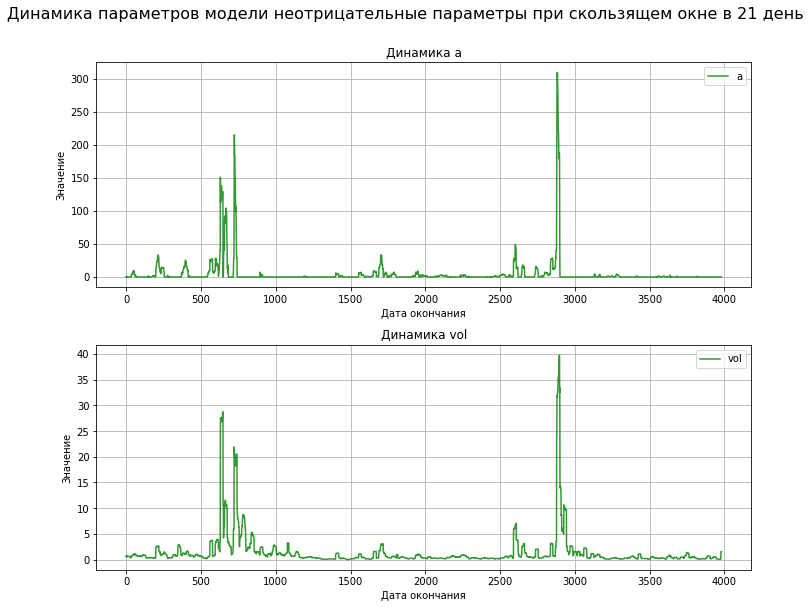

In [285]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)
plt.plot(db21_nonneg['a'].values , 'g-',  alpha = 0.8, label = 'a')
plt.title('Динамика a')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(db21_nonneg['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика параметров модели неотрицательные параметры при скользящем окне в 21 день' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [288]:
def rolling_merton_my(db=mosprime3m, periods=21, p0=np.array([ 0.45,  0.4 ])):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    df_cal = pd.DataFrame(columns=["a", "vol"], index=end_dates)
    for i in tqdm(end_dates):
        x = pd.date_range(end = i, periods=periods, freq='d').strftime('%Y-%m-%d') # добавить ошибку на неправильный формат
        global data
        data = db.loc[x].dropna() # ошибку на формат датафрейма
        opt_ML_merton = sop.fmin(merton_ml, p0, maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)
        df_cal.loc[i] = opt_ML_merton
    return df_cal

db21_my = rolling_merton_my(periods=21)

  0%|          | 0/3981 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -5.565647
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -8.946237
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -16.534169
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.730145
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -14.374574
         Iterations: 49
         Function evaluations: 95


  0%|          | 5/3981 [00:00<02:19, 28.58it/s]

Optimization terminated successfully.
         Current function value: -14.374574
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -14.374574
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -15.023558
         Iterations: 55
         Function evaluations: 110


  0%|          | 8/3981 [00:00<02:17, 28.91it/s]

Optimization terminated successfully.
         Current function value: -9.936275
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.280586
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -9.226517
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -5.845635
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.845635
         Iterations: 55
         Function evaluations: 105


  0%|          | 13/3981 [00:00<01:55, 34.25it/s]

Optimization terminated successfully.
         Current function value: -5.845635
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -4.519010
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -3.733123
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -4.041453
         Iterations: 114
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: -3.177170
         Iterations: 92
         Function evaluations: 181


  0%|          | 18/3981 [00:00<01:50, 35.90it/s]

Optimization terminated successfully.
         Current function value: -1.678685
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -1.678685
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -1.678685
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -1.831414
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -2.505494
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -4.599689
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -7.919431
         Iterations: 52
         Function evaluations: 101


  1%|          | 25/3981 [00:00<01:42, 38.75it/s]

Optimization terminated successfully.
         Current function value: -19.105349
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -19.105349
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -19.105349
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -29.656863
         Iterations: 40
         Function evaluations: 75


  1%|          | 29/3981 [00:00<01:46, 37.25it/s]

Optimization terminated successfully.
         Current function value: -26.968340
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -36.332238
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.008012
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.743820
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.743820
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.743820
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.480215
         Iterations: 41
         Function evaluations: 80


  1%|          | 36/3981 [00:00<01:37, 40.27it/s]

Optimization terminated successfully.
         Current function value: -25.172184
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -22.337094
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -18.444402
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.319727
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -19.319727
         Iterations: 48
         Function evaluations: 92


  1%|          | 41/3981 [00:01<01:42, 38.43it/s]

Optimization terminated successfully.
         Current function value: -19.319727
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -19.061844
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -19.636194
         Iterations: 50
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -17.772486
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -16.809034
         Iterations: 54
         Function evaluations: 105


  1%|          | 46/3981 [00:01<01:40, 39.13it/s]

Optimization terminated successfully.
         Current function value: -17.462551
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -17.462551
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -17.462551
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -18.250974
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -19.571292
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.405697
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -17.736512
         Iterations: 71
         Function evaluations: 136


  1%|▏         | 53/3981 [00:01<01:36, 40.88it/s]

Optimization terminated successfully.
         Current function value: -22.942959
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.942959
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -22.942959
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -21.961224
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -18.227938
         Iterations: 55
         Function evaluations: 106


  1%|▏         | 58/3981 [00:01<01:38, 39.99it/s]

Optimization terminated successfully.
         Current function value: -15.495589
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -15.626530
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -12.697238
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -12.697238
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -12.697238
         Iterations: 55
         Function evaluations: 107


  2%|▏         | 63/3981 [00:01<01:38, 39.93it/s]

Optimization terminated successfully.
         Current function value: -9.521253
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -14.499298
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -10.339375
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -11.617092
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -10.921673
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -10.921673
         Iterations: 73
         Function evaluations: 142


  2%|▏         | 69/3981 [00:01<01:35, 40.96it/s]

Optimization terminated successfully.
         Current function value: -10.921673
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -7.283974
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.848780
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -9.559948
         Iterations: 48
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -8.124623
         Iterations: 52
         Function evaluations: 96


  2%|▏         | 74/3981 [00:01<01:38, 39.67it/s]

Optimization terminated successfully.
         Current function value: -15.111043
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.111043
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.111043
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.185437
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -12.798162
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.718785
         Iterations: 57
         Function evaluations: 109


  2%|▏         | 80/3981 [00:01<01:36, 40.40it/s]

Optimization terminated successfully.
         Current function value: -9.351065
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -8.023117
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -8.023117
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -8.023117
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -4.560798
         Iterations: 54
         Function evaluations: 105


  2%|▏         | 85/3981 [00:02<01:38, 39.47it/s]

Optimization terminated successfully.
         Current function value: -3.769353
         Iterations: 131
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -3.832473
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.340777
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -2.889987
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 1.154143
         Iterations: 58
         Function evaluations: 112


  2%|▏         | 90/3981 [00:02<01:37, 39.75it/s]

Optimization terminated successfully.
         Current function value: 1.154143
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 1.450449
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 2.425482
         Iterations: 176
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: 4.102445
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 3.076625
         Iterations: 63
         Function evaluations: 116


  2%|▏         | 95/3981 [00:02<01:39, 39.16it/s]

Optimization terminated successfully.
         Current function value: 0.998341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.998341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.998341
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.968434
         Iterations: 60
         Function evaluations: 115


  2%|▏         | 99/3981 [00:02<01:42, 37.71it/s]

Optimization terminated successfully.
         Current function value: 2.745159
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 2.734562
         Iterations: 58
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 2.128458
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 1.898017
         Iterations: 59
         Function evaluations: 114


  3%|▎         | 103/3981 [00:02<01:42, 37.73it/s]

Optimization terminated successfully.
         Current function value: 1.898017
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 1.898017
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 2.839295
         Iterations: 119
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 3.023015
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.847524
         Iterations: 61
         Function evaluations: 113


  3%|▎         | 108/3981 [00:02<01:41, 38.11it/s]

Optimization terminated successfully.
         Current function value: 2.022929
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 3.614672
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.725419
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 1.725419
         Iterations: 63
         Function evaluations: 119


  3%|▎         | 112/3981 [00:02<01:41, 38.16it/s]

Optimization terminated successfully.
         Current function value: 2.220988
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 7.379663
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 7.561516
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 6.599146
         Iterations: 61
         Function evaluations: 122


  3%|▎         | 116/3981 [00:03<01:42, 37.78it/s]

Optimization terminated successfully.
         Current function value: 5.731112
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 5.731112
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 5.731112
         Iterations: 62
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 4.843141
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 4.497611
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 4.249400
         Iterations: 60
         Function evaluations: 117


  3%|▎         | 122/3981 [00:03<01:40, 38.41it/s]

Optimization terminated successfully.
         Current function value: 3.077415
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 2.015034
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 2.015034
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 2.015034
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 0.300958
         Iterations: 75
         Function evaluations: 144


  3%|▎         | 127/3981 [00:03<01:41, 38.09it/s]

Optimization terminated successfully.
         Current function value: -0.844421
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -1.266252
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -7.454179
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -9.449989
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -7.500452
         Iterations: 72
         Function evaluations: 138


  3%|▎         | 132/3981 [00:03<01:40, 38.31it/s]

Optimization terminated successfully.
         Current function value: -7.500452
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -14.669131
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -11.936354
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -13.269517
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.131212
         Iterations: 45
         Function evaluations: 89


  3%|▎         | 137/3981 [00:03<01:40, 38.20it/s]

Optimization terminated successfully.
         Current function value: -14.070216
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.070216
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.070216
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -15.486725
         Iterations: 43
         Function evaluations: 82


  4%|▎         | 141/3981 [00:03<01:41, 37.87it/s]

Optimization terminated successfully.
         Current function value: -17.082984
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -18.808244
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -20.413660
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -20.884187
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -20.884187
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -20.884187
         Iterations: 40
         Function evaluations: 76


  4%|▎         | 147/3981 [00:03<01:40, 38.25it/s]

Optimization terminated successfully.
         Current function value: -27.015651
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -29.196763
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -28.595321
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -30.860181
         Iterations: 48
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -39.973287
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -36.997534
         Iterations: 49
         Function evaluations: 92


  4%|▍         | 153/3981 [00:03<01:38, 38.76it/s]

Optimization terminated successfully.
         Current function value: -36.997534
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.848603
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -40.126417
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.842289
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -29.957206
         Iterations: 41
         Function evaluations: 79


  4%|▍         | 158/3981 [00:04<01:37, 39.02it/s]

Optimization terminated successfully.
         Current function value: -26.213890
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.213890
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.213890
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.689803
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -21.785056
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -20.517203
         Iterations: 39
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -15.394371
         Iterations: 47
         Function evaluations: 89


  4%|▍         | 165/3981 [00:04<01:36, 39.48it/s]

Optimization terminated successfully.
         Current function value: -13.279036
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.279036
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.279036
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -14.494674
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -18.461449
         Iterations: 44
         Function evaluations: 82


  4%|▍         | 170/3981 [00:04<01:36, 39.56it/s]

Optimization terminated successfully.
         Current function value: -17.034283
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -19.806344
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -21.067254
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -21.067254
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -21.067254
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -24.114360
         Iterations: 40
         Function evaluations: 76


  4%|▍         | 176/3981 [00:04<01:35, 40.00it/s]

Optimization terminated successfully.
         Current function value: -29.430772
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.997637
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.069582
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -30.048721
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.048721
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.048721
         Iterations: 43
         Function evaluations: 82


  5%|▍         | 182/3981 [00:04<01:35, 39.90it/s]

Optimization terminated successfully.
         Current function value: -28.937493
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.641681
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -38.704501
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -37.667820
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.132941
         Iterations: 46
         Function evaluations: 87


  5%|▍         | 187/3981 [00:04<01:34, 40.09it/s]

Optimization terminated successfully.
         Current function value: -38.132941
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -38.132941
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -44.906221
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -45.393649
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -37.093686
         Iterations: 46
         Function evaluations: 82


  5%|▍         | 192/3981 [00:04<01:34, 40.16it/s]

Optimization terminated successfully.
         Current function value: -28.869514
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -25.801415
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -25.801415
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -25.801415
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.432791
         Iterations: 42
         Function evaluations: 79


  5%|▍         | 197/3981 [00:04<01:34, 40.20it/s]

Optimization terminated successfully.
         Current function value: -22.548073
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -21.889652
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -11.926249
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -6.213412
         Iterations: 51
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -6.213412
         Iterations: 51
         Function evaluations: 102


  5%|▌         | 202/3981 [00:05<01:34, 40.16it/s]

Optimization terminated successfully.
         Current function value: -6.213412
         Iterations: 51
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -3.044064
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.629120
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 1.288132
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 2.102730
         Iterations: 66
         Function evaluations: 126


  5%|▌         | 207/3981 [00:05<01:35, 39.72it/s]

Optimization terminated successfully.
         Current function value: 2.617353
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 2.617353
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 2.617353
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 3.087146
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 3.018211
         Iterations: 68
         Function evaluations: 129


  5%|▌         | 212/3981 [00:05<01:34, 39.85it/s]

Optimization terminated successfully.
         Current function value: 2.133897
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 0.617175
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.356846
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.356846
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.356846
         Iterations: 85
         Function evaluations: 162


  5%|▌         | 217/3981 [00:05<01:35, 39.57it/s]

Optimization terminated successfully.
         Current function value: 1.102465
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 4.088980
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -5.562459
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -5.733903
         Iterations: 65
         Function evaluations: 125


  6%|▌         | 221/3981 [00:05<01:35, 39.58it/s]

Optimization terminated successfully.
         Current function value: -5.602731
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -5.602731
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -5.602731
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -7.096906
         Iterations: 64
         Function evaluations: 125


  6%|▌         | 225/3981 [00:05<01:35, 39.22it/s]

Optimization terminated successfully.
         Current function value: -7.517369
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -5.047510
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -4.566411
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.709458
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -14.709458
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -14.709458
         Iterations: 58
         Function evaluations: 110


  6%|▌         | 231/3981 [00:05<01:35, 39.37it/s]

Optimization terminated successfully.
         Current function value: -11.292262
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -10.444682
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -11.858848
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.195215
         Iterations: 62
         Function evaluations: 113


  6%|▌         | 235/3981 [00:05<01:35, 39.20it/s]

Optimization terminated successfully.
         Current function value: -17.836504
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.836504
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -17.836504
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -20.290881
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -21.126798
         Iterations: 65
         Function evaluations: 124


  6%|▌         | 240/3981 [00:06<01:35, 39.13it/s]

Optimization terminated successfully.
         Current function value: -21.891123
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -17.558626
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -19.517427
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -19.517427
         Iterations: 62
         Function evaluations: 121


  6%|▌         | 244/3981 [00:06<01:36, 38.61it/s]

Optimization terminated successfully.
         Current function value: -19.517427
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -20.991516
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -17.233802
         Iterations: 59
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -14.782671
         Iterations: 61
         Function evaluations: 115


  6%|▌         | 248/3981 [00:06<01:37, 38.47it/s]

Optimization terminated successfully.
         Current function value: -15.903959
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -19.641597
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -19.641597
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -19.641597
         Iterations: 66
         Function evaluations: 125


  6%|▋         | 252/3981 [00:06<01:37, 38.32it/s]

Optimization terminated successfully.
         Current function value: -18.341144
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -14.814780
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -9.635572
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -11.165398
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -8.252871
         Iterations: 58
         Function evaluations: 111


  6%|▋         | 257/3981 [00:06<01:37, 38.35it/s]

Optimization terminated successfully.
         Current function value: -8.252871
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -8.252871
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -3.975089
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.652362
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 1.000970
         Iterations: 58
         Function evaluations: 115


  7%|▋         | 262/3981 [00:06<01:36, 38.45it/s]

Optimization terminated successfully.
         Current function value: 3.045085
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 4.931850
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 4.931850
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 4.931850
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 7.250231
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 7.961294
         Iterations: 59
         Function evaluations: 111


  7%|▋         | 268/3981 [00:06<01:35, 38.74it/s]

Optimization terminated successfully.
         Current function value: 7.895410
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 5.599792
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 1.317144
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 1.317144
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 1.317144
         Iterations: 56
         Function evaluations: 109


  7%|▋         | 273/3981 [00:07<01:35, 38.72it/s]

Optimization terminated successfully.
         Current function value: -4.523689
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -15.015057
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.373652
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -29.968922
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -27.713929
         Iterations: 49
         Function evaluations: 89


  7%|▋         | 278/3981 [00:07<01:35, 38.72it/s]

Optimization terminated successfully.
         Current function value: -27.713929
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.713929
         Iterations: 49
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -41.814461
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.754714
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.207025
         Iterations: 39
         Function evaluations: 75


  7%|▋         | 283/3981 [00:07<01:35, 38.77it/s]

Optimization terminated successfully.
         Current function value: -32.810168
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -29.653709
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.653709
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.653709
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -27.415782
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.546316
         Iterations: 43
         Function evaluations: 81


  7%|▋         | 289/3981 [00:07<01:34, 38.99it/s]

Optimization terminated successfully.
         Current function value: -17.070852
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -16.602310
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -14.292046
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.292046
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.292046
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -16.103539
         Iterations: 43
         Function evaluations: 82


  7%|▋         | 295/3981 [00:07<01:34, 39.19it/s]

Optimization terminated successfully.
         Current function value: -16.857311
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -13.967953
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -14.109509
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -14.822866
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.822866
         Iterations: 45
         Function evaluations: 88


  8%|▊         | 300/3981 [00:07<01:33, 39.30it/s]

Optimization terminated successfully.
         Current function value: -14.822866
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -15.769007
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -15.890272
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -14.635826
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.801057
         Iterations: 44
         Function evaluations: 87


  8%|▊         | 305/3981 [00:07<01:33, 39.40it/s]

Optimization terminated successfully.
         Current function value: -14.279090
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.279090
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.279090
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -19.738499
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -25.369158
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -8.795668
         Iterations: 50
         Function evaluations: 97


  8%|▊         | 311/3981 [00:07<01:32, 39.62it/s]

Optimization terminated successfully.
         Current function value: -2.055360
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.559649
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.559649
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.559649
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 4.851645
         Iterations: 63
         Function evaluations: 122


  8%|▊         | 316/3981 [00:08<01:33, 39.37it/s]

Optimization terminated successfully.
         Current function value: 6.935594
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 7.180068
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 7.541856
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 8.212151
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 8.212151
         Iterations: 63
         Function evaluations: 121


  8%|▊         | 321/3981 [00:08<01:33, 39.20it/s]

Optimization terminated successfully.
         Current function value: 8.212151
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 8.175005
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 8.032658
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 7.846223
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.348452
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 5.163429
         Iterations: 61
         Function evaluations: 115


  8%|▊         | 327/3981 [00:08<01:32, 39.37it/s]

Optimization terminated successfully.
         Current function value: 5.163429
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 5.163429
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.677241
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -1.568145
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -7.249985
         Iterations: 54
         Function evaluations: 104


  8%|▊         | 332/3981 [00:08<01:33, 39.13it/s]

Optimization terminated successfully.
         Current function value: -6.128861
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -14.876094
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.876094
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.876094
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -17.218217
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.532534
         Iterations: 56
         Function evaluations: 105


  8%|▊         | 338/3981 [00:08<01:32, 39.36it/s]

Optimization terminated successfully.
         Current function value: -12.688329
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -9.986036
         Iterations: 54
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -9.177504
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.177504
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.177504
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -8.712895
         Iterations: 48
         Function evaluations: 94


  9%|▊         | 344/3981 [00:08<01:31, 39.57it/s]

Optimization terminated successfully.
         Current function value: -7.725109
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 2.728945
         Iterations: 65
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 9.848243
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 11.308390
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 11.308390
         Iterations: 66
         Function evaluations: 130


  9%|▉         | 349/3981 [00:08<01:32, 39.30it/s]

Optimization terminated successfully.
         Current function value: 11.308390
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 11.401572
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 12.828180
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 12.345256
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 12.379627
         Iterations: 66
         Function evaluations: 128


  9%|▉         | 354/3981 [00:08<01:32, 39.39it/s]

Optimization terminated successfully.
         Current function value: 11.615872
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.615872
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.615872
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 12.809480
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 13.967257
         Iterations: 108
         Function evaluations: 209


  9%|▉         | 359/3981 [00:09<01:32, 39.18it/s]

Optimization terminated successfully.
         Current function value: 15.107854
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 13.481178
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 14.482431
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 14.482431
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 14.482431
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 8.642631
         Iterations: 60
         Function evaluations: 116


  9%|▉         | 365/3981 [00:09<01:31, 39.34it/s]

Optimization terminated successfully.
         Current function value: 9.206506
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.580699
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -10.423528
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.897760
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -12.897760
         Iterations: 53
         Function evaluations: 99


  9%|▉         | 370/3981 [00:09<01:32, 39.15it/s]

Optimization terminated successfully.
         Current function value: -12.897760
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -26.464065
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -26.492362
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -26.650780
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.024871
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -24.783336
         Iterations: 55
         Function evaluations: 107


  9%|▉         | 376/3981 [00:09<01:31, 39.35it/s]

Optimization terminated successfully.
         Current function value: -24.783336
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.783336
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -24.124352
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -18.000428
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -16.422100
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -15.738997
         Iterations: 58
         Function evaluations: 110


 10%|▉         | 382/3981 [00:09<01:31, 39.49it/s]

Optimization terminated successfully.
         Current function value: -14.372362
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.372362
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.372362
         Iterations: 65
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -14.410856
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -14.211844
         Iterations: 60
         Function evaluations: 117


 10%|▉         | 387/3981 [00:09<01:31, 39.32it/s]

Optimization terminated successfully.
         Current function value: -14.141828
         Iterations: 71
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -13.438562
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -12.283007
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -12.283007
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -12.283007
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -14.385045
         Iterations: 64
         Function evaluations: 123


 10%|▉         | 393/3981 [00:09<01:30, 39.47it/s]

Optimization terminated successfully.
         Current function value: -14.370856
         Iterations: 63
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -17.669232
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -14.191735
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -15.706181
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -15.706181
         Iterations: 73
         Function evaluations: 141


 10%|▉         | 398/3981 [00:10<01:31, 39.26it/s]

Optimization terminated successfully.
         Current function value: -15.706181
         Iterations: 73
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -8.874613
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -11.380562
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -12.788956
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -10.598370
         Iterations: 65
         Function evaluations: 123


 10%|█         | 403/3981 [00:10<01:31, 39.25it/s]

Optimization terminated successfully.
         Current function value: -10.659001
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -10.659001
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -10.659001
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -7.967148
         Iterations: 64
         Function evaluations: 120


 10%|█         | 407/3981 [00:10<01:31, 39.05it/s]

Optimization terminated successfully.
         Current function value: -7.184423
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -6.009395
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -4.312183
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -2.425625
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -2.425625
         Iterations: 68
         Function evaluations: 130


 10%|█         | 412/3981 [00:10<01:31, 39.04it/s]

Optimization terminated successfully.
         Current function value: -2.425625
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -2.131745
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -4.785053
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -5.414282
         Iterations: 58
         Function evaluations: 113


 10%|█         | 416/3981 [00:10<01:31, 38.94it/s]

Optimization terminated successfully.
         Current function value: -7.773648
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -4.602189
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.602189
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.602189
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -5.693354
         Iterations: 69
         Function evaluations: 132


 11%|█         | 421/3981 [00:10<01:31, 38.89it/s]

Optimization terminated successfully.
         Current function value: -8.069148
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -23.777287
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -19.992563
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -19.509679
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -19.509679
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -19.509679
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -20.813529
         Iterations: 44
         Function evaluations: 85


 11%|█         | 428/3981 [00:10<01:30, 39.12it/s]

Optimization terminated successfully.
         Current function value: -21.275823
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -11.994380
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -6.970743
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.667441
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.667441
         Iterations: 58
         Function evaluations: 112


 11%|█         | 433/3981 [00:11<01:30, 39.20it/s]

Optimization terminated successfully.
         Current function value: -0.667441
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.621023
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.910188
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 3.354285
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.853032
         Iterations: 59
         Function evaluations: 114


 11%|█         | 438/3981 [00:11<01:30, 39.02it/s]

Optimization terminated successfully.
         Current function value: 5.193621
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 5.193621
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 5.193621
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 5.490253
         Iterations: 62
         Function evaluations: 121


 11%|█         | 442/3981 [00:11<01:30, 39.01it/s]

Optimization terminated successfully.
         Current function value: 5.265851
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 4.826560
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 4.025352
         Iterations: 89
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 2.468277
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.468277
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.468277
         Iterations: 54
         Function evaluations: 105


 11%|█▏        | 448/3981 [00:11<01:30, 39.13it/s]

Optimization terminated successfully.
         Current function value: -2.165227
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -6.908304
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -10.829762
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -12.628232
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -7.887586
         Iterations: 55
         Function evaluations: 106


 11%|█▏        | 453/3981 [00:11<01:30, 38.90it/s]

Optimization terminated successfully.
         Current function value: -7.887586
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -7.887586
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -12.674807
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -6.447205
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -2.968616
         Iterations: 76
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -2.697192
         Iterations: 64
         Function evaluations: 118


 12%|█▏        | 459/3981 [00:11<01:30, 39.06it/s]

Optimization terminated successfully.
         Current function value: -2.267683
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -2.267683
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 3.742642
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 4.899443
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 8.173906
         Iterations: 67
         Function evaluations: 125


 12%|█▏        | 464/3981 [00:11<01:30, 38.98it/s]

Optimization terminated successfully.
         Current function value: 9.087685
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 10.649510
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 9.834209
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 9.834209
         Iterations: 63
         Function evaluations: 122


 12%|█▏        | 468/3981 [00:12<01:30, 38.95it/s]

Optimization terminated successfully.
         Current function value: 9.834209
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 9.650187
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 9.113070
         Iterations: 68
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 8.571197
         Iterations: 66
         Function evaluations: 127


 12%|█▏        | 472/3981 [00:12<01:30, 38.92it/s]

Optimization terminated successfully.
         Current function value: 8.738403
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 8.815919
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 8.815919
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 8.815919
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.408813
         Iterations: 64
         Function evaluations: 120


 12%|█▏        | 477/3981 [00:12<01:29, 38.98it/s]

Optimization terminated successfully.
         Current function value: 5.949815
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 4.769678
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 5.291025
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.340463
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.340463
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 6.496937
         Iterations: 58
         Function evaluations: 111


 12%|█▏        | 483/3981 [00:12<01:29, 39.12it/s]

Optimization terminated successfully.
         Current function value: 4.262386
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 3.733473
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 2.332304
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 2.086670
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 2.334541
         Iterations: 63
         Function evaluations: 122


 12%|█▏        | 488/3981 [00:12<01:29, 38.97it/s]

Optimization terminated successfully.
         Current function value: 2.334541
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 2.334541
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 1.271516
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.904290
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -2.852109
         Iterations: 71
         Function evaluations: 138


 12%|█▏        | 493/3981 [00:12<01:29, 39.04it/s]

Optimization terminated successfully.
         Current function value: -1.121918
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 0.490447
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 4.080500
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 4.080500
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 5.591970
         Iterations: 64
         Function evaluations: 120


 13%|█▎        | 498/3981 [00:12<01:29, 39.05it/s]

Optimization terminated successfully.
         Current function value: 4.240661
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 4.105503
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 1.154328
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 1.173859
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 1.173859
         Iterations: 61
         Function evaluations: 117


 13%|█▎        | 503/3981 [00:12<01:29, 39.06it/s]

Optimization terminated successfully.
         Current function value: 1.173859
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.650653
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 0.780954
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 0.528646
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 0.049602
         Iterations: 112
         Function evaluations: 221


 13%|█▎        | 508/3981 [00:13<01:29, 38.83it/s]

Optimization terminated successfully.
         Current function value: -0.897415
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.897415
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.897415
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -2.237384
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -4.542028
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -9.678995
         Iterations: 48
         Function evaluations: 93


 13%|█▎        | 514/3981 [00:13<01:28, 38.96it/s]

Optimization terminated successfully.
         Current function value: -15.395960
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -25.981895
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.630026
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.630026
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -25.529562
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.372128
         Iterations: 44
         Function evaluations: 82


 13%|█▎        | 520/3981 [00:13<01:28, 39.11it/s]

Optimization terminated successfully.
         Current function value: -15.607036
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -14.969097
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -15.613294
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -15.613294
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -15.613294
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.176833
         Iterations: 46
         Function evaluations: 88


 13%|█▎        | 526/3981 [00:13<01:28, 39.24it/s]

Optimization terminated successfully.
         Current function value: -13.342359
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -13.729359
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -14.475622
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -13.376690
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -13.376690
         Iterations: 43
         Function evaluations: 85


 13%|█▎        | 531/3981 [00:13<01:27, 39.22it/s]

Optimization terminated successfully.
         Current function value: -13.376690
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -17.204716
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -15.131940
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -17.153720
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -17.977821
         Iterations: 39
         Function evaluations: 77


 13%|█▎        | 536/3981 [00:13<01:27, 39.28it/s]

Optimization terminated successfully.
         Current function value: -19.839118
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.839118
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.839118
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -21.553922
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -27.173916
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -29.236495
         Iterations: 41
         Function evaluations: 79


 14%|█▎        | 542/3981 [00:13<01:27, 39.41it/s]

Optimization terminated successfully.
         Current function value: -29.491649
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.352199
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.352199
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.352199
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -28.765202
         Iterations: 46
         Function evaluations: 86


 14%|█▎        | 547/3981 [00:13<01:27, 39.43it/s]

Optimization terminated successfully.
         Current function value: -26.064429
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -23.015489
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -23.083861
         Iterations: 57
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.621906
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.621906
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.621906
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -22.452496
         Iterations: 53
         Function evaluations: 100


 14%|█▍        | 554/3981 [00:13<01:26, 39.61it/s]

Optimization terminated successfully.
         Current function value: -23.150643
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -21.157130
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -23.369330
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.908017
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.908017
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -18.908017
         Iterations: 60
         Function evaluations: 113


 14%|█▍        | 560/3981 [00:14<01:26, 39.53it/s]

Optimization terminated successfully.
         Current function value: -5.670141
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -2.177999
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -1.281651
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.162088
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 0.250260
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 0.250260
         Iterations: 70
         Function evaluations: 133


 14%|█▍        | 566/3981 [00:14<01:26, 39.63it/s]

Optimization terminated successfully.
         Current function value: 0.250260
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 1.608462
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 1.829246
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 1.287160
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 1.254466
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 1.749623
         Iterations: 69
         Function evaluations: 131


 14%|█▍        | 572/3981 [00:14<01:25, 39.66it/s]

Optimization terminated successfully.
         Current function value: 1.749623
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 1.749623
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 2.689386
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 3.797840
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 6.063007
         Iterations: 73
         Function evaluations: 137


 14%|█▍        | 577/3981 [00:14<01:25, 39.66it/s]

Optimization terminated successfully.
         Current function value: 8.264259
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -20.046294
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -20.046294
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -20.046294
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -20.726311
         Iterations: 58
         Function evaluations: 112


 15%|█▍        | 582/3981 [00:14<01:25, 39.72it/s]

Optimization terminated successfully.
         Current function value: -22.447948
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -19.866743
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -19.011580
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -18.909179
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -18.909179
         Iterations: 71
         Function evaluations: 133


 15%|█▍        | 587/3981 [00:14<01:25, 39.65it/s]

Optimization terminated successfully.
         Current function value: -18.909179
         Iterations: 71
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -18.090337
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -17.246720
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -17.173815
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -18.323357
         Iterations: 59
         Function evaluations: 109


 15%|█▍        | 592/3981 [00:14<01:25, 39.67it/s]

Optimization terminated successfully.
         Current function value: -15.370993
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.370993
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -15.370993
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.215691
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -6.042718
         Iterations: 60
         Function evaluations: 113


 15%|█▍        | 597/3981 [00:15<01:25, 39.59it/s]

Optimization terminated successfully.
         Current function value: 0.688687
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 2.736784
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 3.602831
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 3.602831
         Iterations: 65
         Function evaluations: 122


 15%|█▌        | 601/3981 [00:15<01:25, 39.46it/s]

Optimization terminated successfully.
         Current function value: 3.602831
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 3.931300
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 3.526501
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 2.991335
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 3.136593
         Iterations: 69
         Function evaluations: 134


 15%|█▌        | 606/3981 [00:15<01:25, 39.51it/s]

Optimization terminated successfully.
         Current function value: 4.410553
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 4.410553
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 4.410553
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 5.659866
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 6.862152
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 8.366895
         Iterations: 73
         Function evaluations: 141


 15%|█▌        | 612/3981 [00:15<01:25, 39.58it/s]

Optimization terminated successfully.
         Current function value: 10.698141
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 12.297506
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 12.297506
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 12.297506
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 5.237095
         Iterations: 65
         Function evaluations: 122


 15%|█▌        | 617/3981 [00:15<01:24, 39.61it/s]

Optimization terminated successfully.
         Current function value: 9.684385
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.742130
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 6.095235
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 5.049671
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 5.049671
         Iterations: 63
         Function evaluations: 121


 16%|█▌        | 622/3981 [00:15<01:25, 39.49it/s]

Optimization terminated successfully.
         Current function value: 5.049671
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -4.913707
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -6.148430
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -7.414352
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -8.396117
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.309423
         Iterations: 66
         Function evaluations: 127


 16%|█▌        | 628/3981 [00:15<01:25, 39.40it/s]

Optimization terminated successfully.
         Current function value: -0.309423
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.309423
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 23.445854
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 25.349179
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 26.446201
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 26.983033
         Iterations: 79
         Function evaluations: 149


 16%|█▌        | 634/3981 [00:16<01:25, 39.26it/s]

Optimization terminated successfully.
         Current function value: 27.742089
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 27.742089
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 27.742089
         Iterations: 81
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 28.651028
         Iterations: 83
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 28.366884
         Iterations: 86
         Function evaluations: 165


 16%|█▌        | 639/3981 [00:16<01:25, 39.22it/s]

Optimization terminated successfully.
         Current function value: 28.308859
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 28.875310
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 29.217690
         Iterations: 87
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: 31.397034
         Iterations: 83
         Function evaluations: 160


 16%|█▌        | 643/3981 [00:16<01:25, 39.12it/s]

Optimization terminated successfully.
         Current function value: 31.397034
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 30.127847
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 29.396823
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 32.028287
         Iterations: 105
         Function evaluations: 195


 16%|█▋        | 647/3981 [00:16<01:25, 39.07it/s]

Optimization terminated successfully.
         Current function value: 34.326025
         Iterations: 83
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 24.322134
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 24.322134
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 24.322134
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 10.317926
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 10.089732
         Iterations: 80
         Function evaluations: 145


 16%|█▋        | 653/3981 [00:16<01:24, 39.17it/s]

Optimization terminated successfully.
         Current function value: 10.668667
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 8.370280
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 11.288941
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 11.288941
         Iterations: 71
         Function evaluations: 135


 17%|█▋        | 657/3981 [00:16<01:25, 39.04it/s]

Optimization terminated successfully.
         Current function value: 11.288941
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 15.701738
         Iterations: 74
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 17.890673
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 18.491322
         Iterations: 77
         Function evaluations: 150


 17%|█▋        | 661/3981 [00:16<01:25, 38.98it/s]

Optimization terminated successfully.
         Current function value: 18.671459
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 18.308131
         Iterations: 77
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 16.537775
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 16.537775
         Iterations: 80
         Function evaluations: 153


 17%|█▋        | 665/3981 [00:17<01:25, 38.98it/s]

Optimization terminated successfully.
         Current function value: 17.752960
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 18.964113
         Iterations: 86
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: 18.221231
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 17.868160
         Iterations: 72
         Function evaluations: 142


 17%|█▋        | 669/3981 [00:17<01:24, 38.98it/s]

Optimization terminated successfully.
         Current function value: 18.936372
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 18.936372
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 18.936372
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 20.083995
         Iterations: 80
         Function evaluations: 155


 17%|█▋        | 673/3981 [00:17<01:25, 38.92it/s]

Optimization terminated successfully.
         Current function value: 17.667104
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 19.490166
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 23.282032
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 4.644494
         Iterations: 70
         Function evaluations: 137


 17%|█▋        | 677/3981 [00:17<01:25, 38.87it/s]

Optimization terminated successfully.
         Current function value: 4.644494
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 4.644494
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 7.175480
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 5.191048
         Iterations: 73
         Function evaluations: 141


 17%|█▋        | 681/3981 [00:17<01:24, 38.86it/s]

Optimization terminated successfully.
         Current function value: 5.827541
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 8.642382
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 2.215724
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 2.215724
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 2.215724
         Iterations: 63
         Function evaluations: 119


 17%|█▋        | 686/3981 [00:17<01:24, 38.85it/s]

Optimization terminated successfully.
         Current function value: 6.133722
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 7.556905
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 10.539886
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 5.865791
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 0.494670
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 0.494670
         Iterations: 58
         Function evaluations: 110


 17%|█▋        | 692/3981 [00:17<01:24, 38.87it/s]

Optimization terminated successfully.
         Current function value: 0.494670
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -4.319634
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -3.161364
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -1.510335
         Iterations: 53
         Function evaluations: 102


 17%|█▋        | 696/3981 [00:17<01:24, 38.80it/s]

Optimization terminated successfully.
         Current function value: 1.462050
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -1.967862
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -1.967862
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -1.967862
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.006800
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 3.373770
         Iterations: 61
         Function evaluations: 116


 18%|█▊        | 702/3981 [00:18<01:24, 38.90it/s]

Optimization terminated successfully.
         Current function value: 5.333092
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -10.135676
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -5.147573
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -5.147573
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -5.147573
         Iterations: 60
         Function evaluations: 112


 18%|█▊        | 707/3981 [00:18<01:24, 38.82it/s]

Optimization terminated successfully.
         Current function value: -4.895987
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -4.628152
         Iterations: 74
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -4.342129
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -4.035587
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -3.705729
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -3.705729
         Iterations: 65
         Function evaluations: 122


 18%|█▊        | 713/3981 [00:18<01:24, 38.90it/s]

Optimization terminated successfully.
         Current function value: 0.811515
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 1.317548
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.294988
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.433250
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 7.135500
         Iterations: 72
         Function evaluations: 141


 18%|█▊        | 718/3981 [00:18<01:24, 38.83it/s]

Optimization terminated successfully.
         Current function value: 6.932730
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 6.932730
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 6.932730
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 6.446489
         Iterations: 80
         Function evaluations: 152


 18%|█▊        | 722/3981 [00:18<01:23, 38.84it/s]

Optimization terminated successfully.
         Current function value: 12.718050
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 15.420667
         Iterations: 78
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 18.357764
         Iterations: 91
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 20.585098
         Iterations: 87
         Function evaluations: 165


 18%|█▊        | 726/3981 [00:18<01:23, 38.78it/s]

Optimization terminated successfully.
         Current function value: 20.585098
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 20.585098
         Iterations: 87
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 22.437770
         Iterations: 86
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 24.267017
         Iterations: 87
         Function evaluations: 166


 18%|█▊        | 730/3981 [00:18<01:23, 38.74it/s]

Optimization terminated successfully.
         Current function value: 26.085767
         Iterations: 83
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 28.012428
         Iterations: 86
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 30.106265
         Iterations: 84
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 30.106265
         Iterations: 84
         Function evaluations: 162


 18%|█▊        | 734/3981 [00:18<01:23, 38.72it/s]

Optimization terminated successfully.
         Current function value: 28.179455
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 29.450592
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 32.024439
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 34.064421
         Iterations: 78
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 36.375594
         Iterations: 91
         Function evaluations: 167


 19%|█▊        | 739/3981 [00:19<01:23, 38.77it/s]

Optimization terminated successfully.
         Current function value: 39.406292
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 39.406292
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 39.406292
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 39.527418
         Iterations: 82
         Function evaluations: 158


 19%|█▊        | 743/3981 [00:19<01:23, 38.60it/s]

Optimization terminated successfully.
         Current function value: 42.578654
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 43.278751
         Iterations: 91
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 42.524301
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 41.263476
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 41.263476
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 41.263476
         Iterations: 79
         Function evaluations: 149


 19%|█▉        | 749/3981 [00:19<01:23, 38.68it/s]

Optimization terminated successfully.
         Current function value: 41.174307
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 39.313764
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 37.427140
         Iterations: 76
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 34.818478
         Iterations: 71
         Function evaluations: 134


 19%|█▉        | 753/3981 [00:19<01:23, 38.57it/s]

Optimization terminated successfully.
         Current function value: 29.827084
         Iterations: 69
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 29.827084
         Iterations: 69
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 29.827084
         Iterations: 69
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 18.900989
         Iterations: 64
         Function evaluations: 125


 19%|█▉        | 757/3981 [00:19<01:23, 38.48it/s]

Optimization terminated successfully.
         Current function value: 16.492021
         Iterations: 316
         Function evaluations: 625
Optimization terminated successfully.
         Current function value: 14.584104
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 20.532896
         Iterations: 94
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 25.047536
         Iterations: 72
         Function evaluations: 137


 19%|█▉        | 761/3981 [00:19<01:24, 38.32it/s]

Optimization terminated successfully.
         Current function value: 25.047536
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 25.047536
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 24.862884
         Iterations: 80
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 26.878988
         Iterations: 87
         Function evaluations: 166


 19%|█▉        | 765/3981 [00:19<01:23, 38.30it/s]

Optimization terminated successfully.
         Current function value: 28.498244
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 31.117851
         Iterations: 130
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 32.189261
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 32.189261
         Iterations: 73
         Function evaluations: 140


 19%|█▉        | 769/3981 [00:20<01:23, 38.27it/s]

Optimization terminated successfully.
         Current function value: 32.189261
         Iterations: 73
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 29.538655
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 29.128740
         Iterations: 79
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 30.903782
         Iterations: 89
         Function evaluations: 172


 19%|█▉        | 773/3981 [00:20<01:23, 38.24it/s]

Optimization terminated successfully.
         Current function value: 31.760560
         Iterations: 76
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 33.588350
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 33.588350
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 33.588350
         Iterations: 83
         Function evaluations: 158


 20%|█▉        | 777/3981 [00:20<01:24, 38.14it/s]

Optimization terminated successfully.
         Current function value: 38.976165
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 40.562649
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 41.581554
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 41.629824
         Iterations: 91
         Function evaluations: 171


 20%|█▉        | 781/3981 [00:20<01:24, 38.03it/s]

Optimization terminated successfully.
         Current function value: 43.263803
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 43.263803
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 43.263803
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 43.008190
         Iterations: 79
         Function evaluations: 154


 20%|█▉        | 785/3981 [00:20<01:24, 38.03it/s]

Optimization terminated successfully.
         Current function value: 42.731738
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 42.010214
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 41.619598
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 41.123181
         Iterations: 82
         Function evaluations: 157


 20%|█▉        | 789/3981 [00:20<01:24, 37.93it/s]

Optimization terminated successfully.
         Current function value: 41.123181
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 41.123181
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 44.124053
         Iterations: 77
         Function evaluations: 147


 20%|█▉        | 792/3981 [00:20<01:24, 37.85it/s]

Optimization terminated successfully.
         Current function value: 42.251871
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 40.079615
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 36.981198
         Iterations: 73
         Function evaluations: 140


 20%|█▉        | 795/3981 [00:21<01:24, 37.80it/s]

Optimization terminated successfully.
         Current function value: 32.836374
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 32.836374
         Iterations: 68
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 32.836374
         Iterations: 68
         Function evaluations: 134


 20%|██        | 798/3981 [00:21<01:24, 37.72it/s]

Optimization terminated successfully.
         Current function value: 29.050678
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 22.806331
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 18.195692
         Iterations: 67
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.473413
         Iterations: 55
         Function evaluations: 110


 20%|██        | 802/3981 [00:21<01:24, 37.71it/s]

Optimization terminated successfully.
         Current function value: 7.250806
         Iterations: 57
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 7.250806
         Iterations: 57
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 7.250806
         Iterations: 57
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 4.892125
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 11.219777
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 11.830243
         Iterations: 67
         Function evaluations: 125


 20%|██        | 808/3981 [00:21<01:23, 37.78it/s]

Optimization terminated successfully.
         Current function value: 11.441210
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 12.280290
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 12.280290
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 12.280290
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 12.643925
         Iterations: 64
         Function evaluations: 122


 20%|██        | 813/3981 [00:21<01:23, 37.82it/s]

Optimization terminated successfully.
         Current function value: 12.296955
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 10.938516
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 9.078047
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 2.263796
         Iterations: 64
         Function evaluations: 122


 21%|██        | 817/3981 [00:21<01:23, 37.77it/s]

Optimization terminated successfully.
         Current function value: 2.263796
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 2.263796
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 2.718717
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.782184
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 2.737761
         Iterations: 60
         Function evaluations: 118


 21%|██        | 822/3981 [00:21<01:23, 37.80it/s]

Optimization terminated successfully.
         Current function value: 0.184196
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.712575
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.712575
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.712575
         Iterations: 53
         Function evaluations: 104


 21%|██        | 826/3981 [00:21<01:23, 37.77it/s]

Optimization terminated successfully.
         Current function value: -6.877966
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.119758
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 12.795004
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 14.473816
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 19.392137
         Iterations: 72
         Function evaluations: 137


 21%|██        | 831/3981 [00:21<01:23, 37.83it/s]

Optimization terminated successfully.
         Current function value: 19.392137
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 19.392137
         Iterations: 72
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 19.677149
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 22.269026
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 25.413589
         Iterations: 79
         Function evaluations: 148


 21%|██        | 836/3981 [00:22<01:23, 37.81it/s]

Optimization terminated successfully.
         Current function value: 28.981698
         Iterations: 78
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 30.477472
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 30.477472
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 30.477472
         Iterations: 77
         Function evaluations: 150


 21%|██        | 840/3981 [00:22<01:23, 37.80it/s]

Optimization terminated successfully.
         Current function value: 31.045262
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 30.890263
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 30.303477
         Iterations: 76
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 30.004130
         Iterations: 76
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 32.441510
         Iterations: 76
         Function evaluations: 145


 21%|██        | 845/3981 [00:22<01:22, 37.82it/s]

Optimization terminated successfully.
         Current function value: 32.441510
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 32.441510
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 31.211518
         Iterations: 78
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 30.559475
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 30.582191
         Iterations: 81
         Function evaluations: 149


 21%|██▏       | 850/3981 [00:22<01:22, 37.84it/s]

Optimization terminated successfully.
         Current function value: 29.076781
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 26.816299
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 26.816299
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 26.816299
         Iterations: 69
         Function evaluations: 131


 21%|██▏       | 854/3981 [00:22<01:22, 37.81it/s]

Optimization terminated successfully.
         Current function value: 29.329943
         Iterations: 70
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 25.469469
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 20.152473
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 18.491843
         Iterations: 61
         Function evaluations: 120


 22%|██▏       | 858/3981 [00:22<01:22, 37.82it/s]

Optimization terminated successfully.
         Current function value: 19.357692
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 19.357692
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 19.357692
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 19.138983
         Iterations: 69
         Function evaluations: 134


 22%|██▏       | 862/3981 [00:22<01:22, 37.77it/s]

Optimization terminated successfully.
         Current function value: 18.555567
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 17.068950
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 16.380687
         Iterations: 71
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 13.961769
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 13.961769
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 13.961769
         Iterations: 67
         Function evaluations: 130


 22%|██▏       | 868/3981 [00:22<01:22, 37.84it/s]

Optimization terminated successfully.
         Current function value: 11.733990
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 10.042288
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 8.794605
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 9.339559
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 7.447058
         Iterations: 62
         Function evaluations: 120


 22%|██▏       | 873/3981 [00:23<01:22, 37.68it/s]

Optimization terminated successfully.
         Current function value: 7.447058
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 7.447058
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 4.992276
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 3.197466
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 0.666693
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 0.788978
         Iterations: 63
         Function evaluations: 119


 22%|██▏       | 879/3981 [00:23<01:22, 37.78it/s]

Optimization terminated successfully.
         Current function value: 1.161117
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 1.161117
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 1.161117
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 1.938290
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 3.330843
         Iterations: 63
         Function evaluations: 117


 22%|██▏       | 884/3981 [00:23<01:22, 37.72it/s]

Optimization terminated successfully.
         Current function value: 2.716521
         Iterations: 148
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: 1.343491
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 2.124780
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 2.124780
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 2.124780
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 1.748314
         Iterations: 63
         Function evaluations: 120


 22%|██▏       | 890/3981 [00:23<01:21, 37.79it/s]

Optimization terminated successfully.
         Current function value: 4.590622
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -2.119367
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.729495
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -3.333305
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -3.333305
         Iterations: 53
         Function evaluations: 102


 22%|██▏       | 895/3981 [00:23<01:21, 37.81it/s]

Optimization terminated successfully.
         Current function value: -3.333305
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -3.979263
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -3.854287
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.050059
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -4.463603
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -5.723822
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -5.723822
         Iterations: 59
         Function evaluations: 114


 23%|██▎       | 902/3981 [00:23<01:21, 37.91it/s]

Optimization terminated successfully.
         Current function value: -5.723822
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -10.035830
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -8.840838
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -8.122324
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -6.909783
         Iterations: 58
         Function evaluations: 110


 23%|██▎       | 907/3981 [00:23<01:21, 37.86it/s]

Optimization terminated successfully.
         Current function value: -5.175637
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -5.175637
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -5.175637
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -3.709525
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -2.813223
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.368822
         Iterations: 56
         Function evaluations: 107


 23%|██▎       | 913/3981 [00:24<01:20, 37.93it/s]

Optimization terminated successfully.
         Current function value: 2.926369
         Iterations: 80
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 9.574444
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 9.574444
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 9.574444
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 7.271072
         Iterations: 59
         Function evaluations: 112


 23%|██▎       | 918/3981 [00:24<01:20, 37.82it/s]

Optimization terminated successfully.
         Current function value: 3.689489
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 3.242073
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 2.141361
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.543958
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 0.543958
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 0.543958
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 2.900532
         Iterations: 63
         Function evaluations: 118


 23%|██▎       | 925/3981 [00:24<01:20, 37.94it/s]

Optimization terminated successfully.
         Current function value: 6.541616
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 7.745367
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 7.414277
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 8.521890
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 8.521890
         Iterations: 59
         Function evaluations: 113


 23%|██▎       | 930/3981 [00:24<01:20, 37.85it/s]

Optimization terminated successfully.
         Current function value: 8.521890
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 7.814169
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.280288
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 6.669975
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 2.643769
         Iterations: 64
         Function evaluations: 122


 23%|██▎       | 935/3981 [00:24<01:20, 37.89it/s]

Optimization terminated successfully.
         Current function value: 1.572968
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 1.572968
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 1.572968
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 0.137184
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -1.414087
         Iterations: 52
         Function evaluations: 100


 24%|██▎       | 940/3981 [00:24<01:20, 37.93it/s]

Optimization terminated successfully.
         Current function value: -2.852816
         Iterations: 81
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -3.129704
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -7.537540
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -7.537540
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -7.537540
         Iterations: 49
         Function evaluations: 95


 24%|██▎       | 945/3981 [00:24<01:19, 37.96it/s]

Optimization terminated successfully.
         Current function value: -9.978506
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 2.719773
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 3.428334
         Iterations: 64
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 2.141217
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 3.512630
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 3.512630
         Iterations: 58
         Function evaluations: 109


 24%|██▍       | 951/3981 [00:25<01:19, 38.00it/s]

Optimization terminated successfully.
         Current function value: 3.512630
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 2.559231
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 2.383920
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 5.253017
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.429639
         Iterations: 59
         Function evaluations: 117


 24%|██▍       | 956/3981 [00:25<01:19, 37.98it/s]

Optimization terminated successfully.
         Current function value: 7.173586
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 7.173586
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 7.173586
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 7.290953
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 6.773109
         Iterations: 59
         Function evaluations: 113


 24%|██▍       | 961/3981 [00:25<01:19, 37.92it/s]

Optimization terminated successfully.
         Current function value: 5.981191
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 5.401005
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 7.988670
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.988670
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.988670
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 3.544610
         Iterations: 62
         Function evaluations: 114


 24%|██▍       | 967/3981 [00:25<01:19, 37.99it/s]

Optimization terminated successfully.
         Current function value: 2.982521
         Iterations: 114
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: 2.440303
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 1.157678
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.017728
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.017728
         Iterations: 58
         Function evaluations: 113


 24%|██▍       | 972/3981 [00:25<01:19, 37.91it/s]

Optimization terminated successfully.
         Current function value: 0.017728
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.495195
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 0.194556
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 6.986397
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 11.354378
         Iterations: 63
         Function evaluations: 122


 25%|██▍       | 977/3981 [00:25<01:19, 37.93it/s]

Optimization terminated successfully.
         Current function value: 13.878720
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 13.878720
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 13.878720
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 16.811930
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 18.590645
         Iterations: 78
         Function evaluations: 154


 25%|██▍       | 982/3981 [00:25<01:19, 37.95it/s]

Optimization terminated successfully.
         Current function value: 21.136557
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 23.189021
         Iterations: 76
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 27.012591
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 27.012591
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 27.012591
         Iterations: 74
         Function evaluations: 144


 25%|██▍       | 987/3981 [00:26<01:18, 37.94it/s]

Optimization terminated successfully.
         Current function value: 28.789245
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 30.413034
         Iterations: 79
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 30.661420
         Iterations: 76
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 30.906827
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 30.058048
         Iterations: 78
         Function evaluations: 148


 25%|██▍       | 992/3981 [00:26<01:18, 37.95it/s]

Optimization terminated successfully.
         Current function value: 30.058048
         Iterations: 78
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 30.058048
         Iterations: 78
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 29.852606
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 29.138646
         Iterations: 73
         Function evaluations: 140


 25%|██▌       | 996/3981 [00:26<01:18, 37.89it/s]

Optimization terminated successfully.
         Current function value: 28.318210
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 27.338201
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 26.802971
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 26.802971
         Iterations: 80
         Function evaluations: 155


 25%|██▌       | 1000/3981 [00:26<01:18, 37.87it/s]

Optimization terminated successfully.
         Current function value: 26.802971
         Iterations: 80
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 25.615295
         Iterations: 80
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 23.247571
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 20.079408
         Iterations: 110
         Function evaluations: 216


 25%|██▌       | 1004/3981 [00:26<01:18, 37.74it/s]

Optimization terminated successfully.
         Current function value: 15.262350
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.963576
         Iterations: 65
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.963576
         Iterations: 65
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.963576
         Iterations: 65
         Function evaluations: 119


 25%|██▌       | 1008/3981 [00:26<01:18, 37.70it/s]

Optimization terminated successfully.
         Current function value: 9.073621
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 8.506001
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 6.165154
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 5.561242
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 7.294636
         Iterations: 61
         Function evaluations: 115


 25%|██▌       | 1013/3981 [00:26<01:18, 37.74it/s]

Optimization terminated successfully.
         Current function value: 7.294636
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 7.294636
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 7.574273
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 7.662690
         Iterations: 63
         Function evaluations: 120


 26%|██▌       | 1017/3981 [00:26<01:18, 37.71it/s]

Optimization terminated successfully.
         Current function value: 9.678212
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 10.049799
         Iterations: 82
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 12.917013
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 12.917013
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 12.917013
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 13.550563
         Iterations: 71
         Function evaluations: 134


 26%|██▌       | 1023/3981 [00:27<01:18, 37.79it/s]

Optimization terminated successfully.
         Current function value: 14.873956
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 14.915638
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 14.771610
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 14.337058
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 14.337058
         Iterations: 66
         Function evaluations: 127


 26%|██▌       | 1028/3981 [00:27<01:18, 37.83it/s]

Optimization terminated successfully.
         Current function value: 14.337058
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 13.710728
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 13.577252
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 14.611074
         Iterations: 82
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 11.854982
         Iterations: 61
         Function evaluations: 118


 26%|██▌       | 1033/3981 [00:27<01:17, 37.85it/s]

Optimization terminated successfully.
         Current function value: 9.629216
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 9.629216
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 9.629216
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 7.240032
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.930293
         Iterations: 58
         Function evaluations: 109


 26%|██▌       | 1038/3981 [00:27<01:17, 37.79it/s]

Optimization terminated successfully.
         Current function value: -1.964007
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.178223
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -5.094275
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -5.094275
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -5.094275
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -8.051424
         Iterations: 58
         Function evaluations: 107


 26%|██▌       | 1044/3981 [00:27<01:17, 37.86it/s]

Optimization terminated successfully.
         Current function value: -7.833492
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -7.569804
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -1.587397
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -1.683678
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -1.683678
         Iterations: 57
         Function evaluations: 113


 26%|██▋       | 1049/3981 [00:27<01:17, 37.79it/s]

Optimization terminated successfully.
         Current function value: -1.683678
         Iterations: 57
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -2.097905
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.772114
         Iterations: 65
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.343668
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 4.104523
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 2.644919
         Iterations: 57
         Function evaluations: 106


 27%|██▋       | 1055/3981 [00:27<01:17, 37.86it/s]

Optimization terminated successfully.
         Current function value: 2.644919
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 2.644919
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 0.345949
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -2.836836
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -7.749691
         Iterations: 50
         Function evaluations: 96


 27%|██▋       | 1060/3981 [00:28<01:17, 37.81it/s]

Optimization terminated successfully.
         Current function value: -9.333036
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.346888
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.346888
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.346888
         Iterations: 56
         Function evaluations: 104


 27%|██▋       | 1064/3981 [00:28<01:17, 37.80it/s]

Optimization terminated successfully.
         Current function value: -0.954069
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -3.632954
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -6.053718
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -1.762694
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -1.721294
         Iterations: 60
         Function evaluations: 115


 27%|██▋       | 1069/3981 [00:28<01:16, 37.84it/s]

Optimization terminated successfully.
         Current function value: -1.721294
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -1.721294
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -1.673910
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -1.639693
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -1.775132
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.258244
         Iterations: 61
         Function evaluations: 114


 27%|██▋       | 1075/3981 [00:28<01:16, 37.88it/s]

Optimization terminated successfully.
         Current function value: -0.897377
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.897377
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.897377
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 8.166534
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 9.727997
         Iterations: 69
         Function evaluations: 137


 27%|██▋       | 1080/3981 [00:28<01:16, 37.77it/s]

Optimization terminated successfully.
         Current function value: 10.401226
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 9.611929
         Iterations: 77
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 10.629323
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 10.629323
         Iterations: 69
         Function evaluations: 133


 27%|██▋       | 1084/3981 [00:28<01:16, 37.77it/s]

Optimization terminated successfully.
         Current function value: 10.629323
         Iterations: 69
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 11.338671
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 11.047396
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: 9.566263
         Iterations: 71
         Function evaluations: 135


 27%|██▋       | 1088/3981 [00:28<01:16, 37.73it/s]

Optimization terminated successfully.
         Current function value: 4.978917
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 5.669985
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 5.669985
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 5.669985
         Iterations: 67
         Function evaluations: 127


 27%|██▋       | 1092/3981 [00:28<01:16, 37.73it/s]

Optimization terminated successfully.
         Current function value: 6.338133
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 6.967793
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 7.617111
         Iterations: 86
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 8.262623
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.905321
         Iterations: 58
         Function evaluations: 112


 28%|██▊       | 1097/3981 [00:29<01:16, 37.74it/s]

Optimization terminated successfully.
         Current function value: 8.905321
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 8.905321
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 5.304178
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 3.507278
         Iterations: 59
         Function evaluations: 112


 28%|██▊       | 1101/3981 [00:29<01:16, 37.69it/s]

Optimization terminated successfully.
         Current function value: 4.253184
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 1.426851
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -3.793031
         Iterations: 138
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -3.793031
         Iterations: 138
         Function evaluations: 269


 28%|██▊       | 1105/3981 [00:29<01:16, 37.64it/s]

Optimization terminated successfully.
         Current function value: -3.793031
         Iterations: 138
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -8.835449
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -9.228868
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -9.198284
         Iterations: 55
         Function evaluations: 102


 28%|██▊       | 1109/3981 [00:29<01:16, 37.64it/s]

Optimization terminated successfully.
         Current function value: -3.013630
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -1.547732
         Iterations: 93
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -1.547732
         Iterations: 93
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -1.547732
         Iterations: 93
         Function evaluations: 174


 28%|██▊       | 1113/3981 [00:29<01:16, 37.64it/s]

Optimization terminated successfully.
         Current function value: -1.102840
         Iterations: 138
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: -1.893027
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -1.168185
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.101532
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.888199
         Iterations: 57
         Function evaluations: 107


 28%|██▊       | 1118/3981 [00:29<01:16, 37.67it/s]

Optimization terminated successfully.
         Current function value: 2.888199
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 2.888199
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 1.703145
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.888026
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 0.947200
         Iterations: 62
         Function evaluations: 115


 28%|██▊       | 1123/3981 [00:29<01:15, 37.70it/s]

Optimization terminated successfully.
         Current function value: 3.275687
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 2.922247
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 4.747433
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 4.747433
         Iterations: 64
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.147664
         Iterations: 62
         Function evaluations: 115


 28%|██▊       | 1128/3981 [00:29<01:15, 37.68it/s]

Optimization terminated successfully.
         Current function value: 6.643482
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 10.331203
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 12.130753
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 13.695480
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 13.695480
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 13.695480
         Iterations: 70
         Function evaluations: 134


 28%|██▊       | 1134/3981 [00:30<01:15, 37.74it/s]

Optimization terminated successfully.
         Current function value: 12.158067
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 13.887898
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 14.467262
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 16.233891
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 16.986486
         Iterations: 69
         Function evaluations: 130


 29%|██▊       | 1139/3981 [00:30<01:15, 37.66it/s]

Optimization terminated successfully.
         Current function value: 16.986486
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 16.986486
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 19.192264
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 20.790300
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 20.328486
         Iterations: 67
         Function evaluations: 128


 29%|██▊       | 1144/3981 [00:30<01:15, 37.68it/s]

Optimization terminated successfully.
         Current function value: 19.891282
         Iterations: 67
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 18.945048
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 16.232849
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 16.232849
         Iterations: 71
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 14.837686
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 12.006929
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 9.802145
         Iterations: 59
         Function evaluations: 113


 29%|██▉       | 1151/3981 [00:30<01:14, 37.76it/s]

Optimization terminated successfully.
         Current function value: 7.181669
         Iterations: 65
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 3.107058
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 3.107058
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 3.107058
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 3.315001
         Iterations: 60
         Function evaluations: 110


 29%|██▉       | 1156/3981 [00:30<01:14, 37.75it/s]

Optimization terminated successfully.
         Current function value: 0.679598
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -9.131513
         Iterations: 56
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -11.193303
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -10.355145
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -10.355145
         Iterations: 46
         Function evaluations: 91


 29%|██▉       | 1161/3981 [00:30<01:14, 37.75it/s]

Optimization terminated successfully.
         Current function value: -10.355145
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -7.844710
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -8.609492
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -8.403824
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -10.512072
         Iterations: 54
         Function evaluations: 103


 29%|██▉       | 1166/3981 [00:30<01:14, 37.76it/s]

Optimization terminated successfully.
         Current function value: -9.729386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -9.729386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -9.729386
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -5.904639
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -5.796362
         Iterations: 54
         Function evaluations: 104


 29%|██▉       | 1171/3981 [00:30<01:14, 37.79it/s]

Optimization terminated successfully.
         Current function value: -6.743935
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -6.700381
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -8.511312
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -8.511312
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -8.511312
         Iterations: 48
         Function evaluations: 95


 30%|██▉       | 1176/3981 [00:31<01:14, 37.73it/s]

Optimization terminated successfully.
         Current function value: -12.428192
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.121962
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -19.853711
         Iterations: 41
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.136319
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -21.664089
         Iterations: 39
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -21.664089
         Iterations: 39
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -21.664089
         Iterations: 39
         Function evaluations: 71


 30%|██▉       | 1183/3981 [00:31<01:13, 37.82it/s]

Optimization terminated successfully.
         Current function value: -22.945035
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -26.594177
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -26.725044
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -33.537368
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -44.116632
         Iterations: 41
         Function evaluations: 80


 30%|██▉       | 1188/3981 [00:31<01:13, 37.78it/s]

Optimization terminated successfully.
         Current function value: -44.116632
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -44.116632
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -39.651617
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.083292
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -39.175305
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -38.026456
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.027704
         Iterations: 42
         Function evaluations: 80


 30%|███       | 1195/3981 [00:31<01:13, 37.88it/s]

Optimization terminated successfully.
         Current function value: -38.027704
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -38.027704
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -34.667044
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.796659
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.091369
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -28.692340
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -18.556223
         Iterations: 45
         Function evaluations: 83


 30%|███       | 1202/3981 [00:31<01:13, 37.98it/s]

Optimization terminated successfully.
         Current function value: -18.556223
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.556223
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.091098
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -12.169696
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -13.843606
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -17.124266
         Iterations: 48
         Function evaluations: 91


 30%|███       | 1208/3981 [00:31<01:12, 38.03it/s]

Optimization terminated successfully.
         Current function value: -17.366427
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -17.366427
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -17.366427
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -18.607059
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -17.442072
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.936521
         Iterations: 48
         Function evaluations: 89


 30%|███       | 1214/3981 [00:31<01:12, 38.04it/s]

Optimization terminated successfully.
         Current function value: -15.490038
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.008648
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -18.008648
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -18.008648
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -19.053760
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -12.969769
         Iterations: 55
         Function evaluations: 99


 31%|███       | 1220/3981 [00:32<01:12, 38.10it/s]

Optimization terminated successfully.
         Current function value: -11.667646
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.048058
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -5.710925
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -5.710925
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -5.710925
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -5.265912
         Iterations: 68
         Function evaluations: 130


 31%|███       | 1226/3981 [00:32<01:12, 38.07it/s]

Optimization terminated successfully.
         Current function value: -1.755980
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 0.735827
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 3.602332
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 3.331537
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 3.331537
         Iterations: 60
         Function evaluations: 113


 31%|███       | 1231/3981 [00:32<01:12, 38.09it/s]

Optimization terminated successfully.
         Current function value: 3.331537
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 3.188706
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 3.017009
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 3.560015
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 2.528258
         Iterations: 57
         Function evaluations: 108


 31%|███       | 1236/3981 [00:32<01:12, 38.07it/s]

Optimization terminated successfully.
         Current function value: 2.701873
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.701873
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.701873
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 1.292090
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 0.171495
         Iterations: 54
         Function evaluations: 104


 31%|███       | 1241/3981 [00:32<01:11, 38.06it/s]

Optimization terminated successfully.
         Current function value: -1.088622
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -3.653274
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -4.480075
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -4.480075
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -4.480075
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -7.667944
         Iterations: 55
         Function evaluations: 108


 31%|███▏      | 1247/3981 [00:32<01:11, 38.12it/s]

Optimization terminated successfully.
         Current function value: -8.539002
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.151958
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -13.438701
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.652096
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -14.652096
         Iterations: 43
         Function evaluations: 85


 31%|███▏      | 1252/3981 [00:32<01:11, 38.16it/s]

Optimization terminated successfully.
         Current function value: -14.652096
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -17.630360
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -21.426642
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -18.547461
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -17.281424
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -17.939819
         Iterations: 50
         Function evaluations: 91


 32%|███▏      | 1258/3981 [00:32<01:11, 38.21it/s]

Optimization terminated successfully.
         Current function value: -17.939819
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -17.939819
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -13.559106
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -13.626245
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.852310
         Iterations: 49
         Function evaluations: 95


 32%|███▏      | 1263/3981 [00:33<01:11, 38.21it/s]

Optimization terminated successfully.
         Current function value: -14.552554
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -14.420187
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.420187
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.420187
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -18.768472
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -16.754640
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -17.379581
         Iterations: 37
         Function evaluations: 72
Optimization termin

 32%|███▏      | 1271/3981 [00:33<01:10, 38.33it/s]

Optimization terminated successfully.
         Current function value: -24.317009
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -24.317009
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -24.317009
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -26.100026
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -32.537578
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -40.126267
         Iterations: 40
         Function evaluations: 77


 32%|███▏      | 1277/3981 [00:33<01:10, 38.29it/s]

Optimization terminated successfully.
         Current function value: -40.959191
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -43.243238
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -43.243238
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -43.243238
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -23.816971
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -23.674840
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -22.061489
         Iterations: 40
         Function evaluations: 76


 32%|███▏      | 1284/3981 [00:33<01:10, 38.37it/s]

Optimization terminated successfully.
         Current function value: -16.450582
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -13.311656
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -13.311656
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -13.311656
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -14.398497
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -13.979012
         Iterations: 47
         Function evaluations: 91


 32%|███▏      | 1290/3981 [00:33<01:10, 38.34it/s]

Optimization terminated successfully.
         Current function value: -15.013941
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -13.369624
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -12.847115
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -12.847115
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -12.847115
         Iterations: 46
         Function evaluations: 90


 33%|███▎      | 1295/3981 [00:33<01:10, 38.35it/s]

Optimization terminated successfully.
         Current function value: -10.664154
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -11.913823
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.188072
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -16.572564
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -22.885240
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -22.885240
         Iterations: 33
         Function evaluations: 65


 33%|███▎      | 1301/3981 [00:33<01:09, 38.39it/s]

Optimization terminated successfully.
         Current function value: -22.885240
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -23.712859
         Iterations: 30
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: -25.393158
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -27.482651
         Iterations: 33
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -31.118814
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -29.838716
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -29.838716
         Iterations: 33
         Function evaluations: 64


 33%|███▎      | 1308/3981 [00:33<01:09, 38.48it/s]

Optimization terminated successfully.
         Current function value: -29.838716
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -31.295383
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.758348
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -40.469616
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -42.141485
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.705369
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.705369
         Iterations: 45
         Function evaluations: 85


 33%|███▎      | 1315/3981 [00:34<01:09, 38.55it/s]

Optimization terminated successfully.
         Current function value: -48.705369
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -48.940610
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -49.248696
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -49.672029
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -50.296397
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -51.330762
         Iterations: 43
         Function evaluations: 86


 33%|███▎      | 1321/3981 [00:34<01:08, 38.55it/s]

Optimization terminated successfully.
         Current function value: -51.330762
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -51.330762
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -53.493869
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -64.540275
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -61.479253
         Iterations: 43
         Function evaluations: 84


 33%|███▎      | 1326/3981 [00:34<01:08, 38.53it/s]

Optimization terminated successfully.
         Current function value: -59.921863
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -57.389250
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -57.389250
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -57.389250
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -52.777046
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -58.953824
         Iterations: 44
         Function evaluations: 86


 33%|███▎      | 1332/3981 [00:34<01:08, 38.58it/s]

Optimization terminated successfully.
         Current function value: -55.735589
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -50.753091
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -50.094510
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -50.094510
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -50.094510
         Iterations: 43
         Function evaluations: 80


 34%|███▎      | 1337/3981 [00:34<01:08, 38.58it/s]

Optimization terminated successfully.
         Current function value: -50.193896
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -50.324647
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -50.505700
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -50.775991
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -51.231341
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -51.231341
         Iterations: 41
         Function evaluations: 81


 34%|███▎      | 1343/3981 [00:34<01:08, 38.62it/s]

Optimization terminated successfully.
         Current function value: -51.231341
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -52.193499
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -55.970749
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -50.905926
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -51.022631
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -40.312984
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -40.312984
         Iterations: 41
         Function evaluations: 77


 34%|███▍      | 1350/3981 [00:34<01:07, 38.70it/s]

Optimization terminated successfully.
         Current function value: -40.312984
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -40.227449
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.906037
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -39.974990
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -41.802451
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -38.681397
         Iterations: 42
         Function evaluations: 82


 34%|███▍      | 1356/3981 [00:34<01:07, 38.75it/s]

Optimization terminated successfully.
         Current function value: -38.681397
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.681397
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.697390
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -38.774721
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -38.929044
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -39.186704
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -39.391747
         Iterations: 40
         Function evaluations: 77
Optimization termina

 34%|███▍      | 1364/3981 [00:35<01:07, 38.86it/s]

Optimization terminated successfully.
         Current function value: -39.391747
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -40.101547
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -41.259505
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -43.654677
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -56.768366
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -52.755253
         Iterations: 40
         Function evaluations: 77


 34%|███▍      | 1370/3981 [00:35<01:07, 38.82it/s]

Optimization terminated successfully.
         Current function value: -52.755253
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -52.755253
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -58.834206
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -56.453040
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -51.610557
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -48.230151
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -44.770030
         Iterations: 41
         Function evaluations: 79
Optimization termina

 35%|███▍      | 1378/3981 [00:35<01:06, 38.94it/s]

Optimization terminated successfully.
         Current function value: -44.770030
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -44.402248
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -43.711588
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -42.638711
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -40.678970
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -44.107767
         Iterations: 42
         Function evaluations: 81


 35%|███▍      | 1384/3981 [00:35<01:06, 38.96it/s]

Optimization terminated successfully.
         Current function value: -47.431714
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -47.431714
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -47.179667
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -48.019312
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -51.185811
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -46.919518
         Iterations: 46
         Function evaluations: 86


 35%|███▍      | 1390/3981 [00:35<01:06, 39.00it/s]

Optimization terminated successfully.
         Current function value: -47.033794
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -47.033794
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -47.033794
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -47.184708
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -47.394103
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -47.706407
         Iterations: 42
         Function evaluations: 82


 35%|███▌      | 1396/3981 [00:35<01:06, 39.06it/s]

Optimization terminated successfully.
         Current function value: -51.028514
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -54.335520
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -54.335520
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -54.335520
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -53.611387
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -27.494910
         Iterations: 40
         Function evaluations: 77


 35%|███▌      | 1402/3981 [00:35<01:05, 39.09it/s]

Optimization terminated successfully.
         Current function value: -21.047841
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -19.675621
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -19.219002
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -17.727206
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -17.727206
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -16.909266
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -16.669007
         Iterations: 53
         Function evaluations: 100


 35%|███▌      | 1409/3981 [00:35<01:05, 39.16it/s]

Optimization terminated successfully.
         Current function value: -16.444890
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -16.172791
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -15.843325
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -15.843325
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -15.843325
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -15.286418
         Iterations: 58
         Function evaluations: 108


 36%|███▌      | 1415/3981 [00:36<01:05, 39.21it/s]

Optimization terminated successfully.
         Current function value: -14.208028
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.444450
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -9.638524
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -7.209314
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.209314
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.209314
         Iterations: 56
         Function evaluations: 110


 36%|███▌      | 1421/3981 [00:36<01:05, 39.14it/s]

Optimization terminated successfully.
         Current function value: -14.786269
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.633820
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.015937
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -36.542255
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.238580
         Iterations: 45
         Function evaluations: 86


 36%|███▌      | 1426/3981 [00:36<01:05, 39.16it/s]

Optimization terminated successfully.
         Current function value: -35.238580
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.238580
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -32.677217
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -31.348609
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.719270
         Iterations: 37
         Function evaluations: 74


 36%|███▌      | 1431/3981 [00:36<01:05, 39.12it/s]

Optimization terminated successfully.
         Current function value: -39.993159
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -35.946293
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -35.946293
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -35.946293
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -36.578391
         Iterations: 45
         Function evaluations: 85


 36%|███▌      | 1436/3981 [00:36<01:05, 39.13it/s]

Optimization terminated successfully.
         Current function value: -32.738580
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -38.825060
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -34.180595
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -30.835844
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -30.835844
         Iterations: 48
         Function evaluations: 90


 36%|███▌      | 1441/3981 [00:36<01:04, 39.10it/s]

Optimization terminated successfully.
         Current function value: -30.835844
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -27.909134
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -28.667695
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -26.670949
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.470773
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -23.101098
         Iterations: 45
         Function evaluations: 85


 36%|███▋      | 1447/3981 [00:36<01:04, 39.15it/s]

Optimization terminated successfully.
         Current function value: -23.101098
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -23.101098
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -19.754633
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -16.528972
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -15.651132
         Iterations: 43
         Function evaluations: 80


 36%|███▋      | 1452/3981 [00:37<01:04, 39.11it/s]

Optimization terminated successfully.
         Current function value: -13.944737
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -13.566162
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -13.566162
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -13.566162
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -14.912405
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -16.288181
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -17.684701
         Iterations: 37
         Function evaluations: 72


 37%|███▋      | 1459/3981 [00:37<01:04, 39.18it/s]

Optimization terminated successfully.
         Current function value: -19.096499
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -20.519957
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -20.519957
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -20.519957
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -21.952567
         Iterations: 42
         Function evaluations: 78


 37%|███▋      | 1464/3981 [00:37<01:04, 39.18it/s]

Optimization terminated successfully.
         Current function value: -25.231710
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -25.620932
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -32.581324
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -32.507743
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.507743
         Iterations: 41
         Function evaluations: 82


 37%|███▋      | 1469/3981 [00:37<01:04, 39.20it/s]

Optimization terminated successfully.
         Current function value: -32.507743
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -42.999688
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -54.216977
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239


 37%|███▋      | 1474/3981 [00:38<01:04, 38.63it/s]

Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239


 37%|███▋      | 1478/3981 [00:39<01:06, 37.52it/s]

Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239


 37%|███▋      | 1481/3981 [00:40<01:08, 36.68it/s]

Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239


 37%|███▋      | 1483/3981 [00:41<01:09, 36.15it/s]

Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239


 37%|███▋      | 1485/3981 [00:41<01:09, 35.71it/s]

Optimization terminated successfully.
         Current function value: -11147.964971
         Iterations: 2630
         Function evaluations: 5239
Optimization terminated successfully.
         Current function value: -10405.136984
         Iterations: 2547
         Function evaluations: 5080


 37%|███▋      | 1487/3981 [00:42<01:10, 35.26it/s]

Optimization terminated successfully.
         Current function value: -10405.136984
         Iterations: 2547
         Function evaluations: 5080


 37%|███▋      | 1488/3981 [00:42<01:11, 34.99it/s]

Optimization terminated successfully.
         Current function value: -10405.136984
         Iterations: 2547
         Function evaluations: 5080


 37%|███▋      | 1489/3981 [00:42<01:11, 34.80it/s]

Optimization terminated successfully.
         Current function value: -10405.136984
         Iterations: 2547
         Function evaluations: 5080


 37%|███▋      | 1490/3981 [00:43<01:12, 34.58it/s]

Optimization terminated successfully.
         Current function value: -10405.136984
         Iterations: 2547
         Function evaluations: 5080


 37%|███▋      | 1491/3981 [00:43<01:12, 34.37it/s]

Optimization terminated successfully.
         Current function value: -69.960131
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -69.364881
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -68.728902
         Iterations: 49
         Function evaluations: 95


 38%|███▊      | 1494/3981 [00:43<01:12, 34.36it/s]

Optimization terminated successfully.
         Current function value: -68.044956
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -47.136336
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -47.136336
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -47.136336
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -37.267886
         Iterations: 40
         Function evaluations: 77


 38%|███▊      | 1499/3981 [00:43<01:12, 34.38it/s]

Optimization terminated successfully.
         Current function value: -34.692349
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.983420
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -28.816076
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -28.304698
         Iterations: 43
         Function evaluations: 79


 38%|███▊      | 1503/3981 [00:43<01:12, 34.39it/s]

Optimization terminated successfully.
         Current function value: -28.304698
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -28.304698
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -28.216832
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -27.967668
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -29.974260
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -29.744004
         Iterations: 37
         Function evaluations: 75


 38%|███▊      | 1509/3981 [00:43<01:11, 34.42it/s]

Optimization terminated successfully.
         Current function value: -28.744403
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -28.744403
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -28.744403
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -31.630355
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -32.449192
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -34.118634
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -39.656863
         Iterations: 49
         Function evaluations: 94


 38%|███▊      | 1516/3981 [00:43<01:11, 34.49it/s]

Optimization terminated successfully.
         Current function value: -32.090808
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.090808
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -32.090808
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -31.800404
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -29.460359
         Iterations: 39
         Function evaluations: 77


 38%|███▊      | 1521/3981 [00:44<01:11, 34.52it/s]

Optimization terminated successfully.
         Current function value: -30.559531
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -29.125562
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -26.469583
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.469583
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.469583
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -27.791340
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -22.158052
         Iterations: 41
         Function evaluations: 76


 38%|███▊      | 1528/3981 [00:44<01:10, 34.58it/s]

Optimization terminated successfully.
         Current function value: -21.364324
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -12.837493
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -9.465796
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.465796
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.465796
         Iterations: 52
         Function evaluations: 101


 39%|███▊      | 1533/3981 [00:44<01:10, 34.59it/s]

Optimization terminated successfully.
         Current function value: -9.363423
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -7.733169
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -4.466309
         Iterations: 52
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -4.946049
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -4.744318
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -4.744318
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -4.744318
         Iterations: 57
         Function evaluations: 106


 39%|███▊      | 1540/3981 [00:44<01:10, 34.66it/s]

Optimization terminated successfully.
         Current function value: -4.713760
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -4.007402
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -4.847143
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -5.841579
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -6.345270
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -6.345270
         Iterations: 45
         Function evaluations: 89


 39%|███▉      | 1546/3981 [00:44<01:10, 34.70it/s]

Optimization terminated successfully.
         Current function value: -6.345270
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -8.159479
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -9.911476
         Iterations: 52
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -15.750876
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -19.685863
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -21.389096
         Iterations: 36
         Function evaluations: 69


 39%|███▉      | 1552/3981 [00:44<01:09, 34.76it/s]

Optimization terminated successfully.
         Current function value: -21.389096
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -21.389096
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -25.061555
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -22.028086
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.921934
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.978065
         Iterations: 47
         Function evaluations: 93


 39%|███▉      | 1558/3981 [00:44<01:09, 34.78it/s]

Optimization terminated successfully.
         Current function value: -16.447716
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -16.447716
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -16.447716
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -15.105655
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -14.877442
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -14.885235
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -14.956283
         Iterations: 60
         Function evaluations: 114


 39%|███▉      | 1565/3981 [00:44<01:09, 34.85it/s]

Optimization terminated successfully.
         Current function value: -14.527594
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -14.527594
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -14.527594
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -13.995185
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -12.410183
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -9.772839
         Iterations: 63
         Function evaluations: 122


 39%|███▉      | 1571/3981 [00:45<01:09, 34.84it/s]

Optimization terminated successfully.
         Current function value: -9.983175
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.703700
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -21.703700
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -21.703700
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -23.069980
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -22.140680
         Iterations: 41
         Function evaluations: 75


 40%|███▉      | 1577/3981 [00:45<01:09, 34.84it/s]

Optimization terminated successfully.
         Current function value: -30.114453
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -31.131350
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -31.849962
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.849962
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -31.849962
         Iterations: 50
         Function evaluations: 95


 40%|███▉      | 1582/3981 [00:45<01:08, 34.84it/s]

Optimization terminated successfully.
         Current function value: -34.049143
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -35.391759
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -32.252914
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -32.467878
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -30.216944
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -30.216944
         Iterations: 48
         Function evaluations: 93


 40%|███▉      | 1588/3981 [00:45<01:08, 34.89it/s]

Optimization terminated successfully.
         Current function value: -30.216944
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -26.198371
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -27.901472
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -36.384119
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -35.267894
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.204079
         Iterations: 50
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -32.204079
         Iterations: 50
         Function evaluations: 88


 40%|████      | 1595/3981 [00:45<01:08, 34.96it/s]

Optimization terminated successfully.
         Current function value: -32.204079
         Iterations: 50
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -27.475652
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -29.241517
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -26.343737
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -30.042653
         Iterations: 45
         Function evaluations: 87


 40%|████      | 1600/3981 [00:45<01:08, 34.95it/s]

Optimization terminated successfully.
         Current function value: -27.212486
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -27.212486
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -27.212486
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -27.566969
         Iterations: 33
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -38.392657
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.595173
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -45.620553
         Iterations: 42
         Function evaluations: 81
Optimization termina

 40%|████      | 1608/3981 [00:45<01:07, 35.00it/s]

Optimization terminated successfully.
         Current function value: -47.084160
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -47.084160
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -45.821025
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -48.660014
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -50.042576
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -46.189263
         Iterations: 40
         Function evaluations: 78


 41%|████      | 1614/3981 [00:46<01:07, 35.05it/s]

Optimization terminated successfully.
         Current function value: -46.567734
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -46.567734
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -46.567734
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -49.711185
         Iterations: 33
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -49.145505
         Iterations: 37
         Function evaluations: 71


 41%|████      | 1619/3981 [00:46<01:07, 35.06it/s]

Optimization terminated successfully.
         Current function value: -47.232209
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -43.725828
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -52.102821
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -52.102821
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -52.102821
         Iterations: 39
         Function evaluations: 76


 41%|████      | 1624/3981 [00:46<01:07, 35.04it/s]

Optimization terminated successfully.
         Current function value: -48.247893
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -51.941142
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -54.304712
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -49.327648
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -48.912446
         Iterations: 44
         Function evaluations: 82


 41%|████      | 1629/3981 [00:46<01:07, 35.05it/s]

Optimization terminated successfully.
         Current function value: -48.912446
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.912446
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.605291
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -48.399377
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -48.555749
         Iterations: 48
         Function evaluations: 92


 41%|████      | 1634/3981 [00:46<01:06, 35.07it/s]

Optimization terminated successfully.
         Current function value: -48.748672
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -48.837724
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -48.837724
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -48.837724
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -47.626933
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -47.485392
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -47.517073
         Iterations: 41
         Function evaluations: 80
Optimization termina

 41%|████      | 1642/3981 [00:46<01:06, 35.15it/s]

Optimization terminated successfully.
         Current function value: -42.279379
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.279379
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.279379
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.881594
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -42.797122
         Iterations: 37
         Function evaluations: 72


 41%|████▏     | 1647/3981 [00:46<01:06, 35.14it/s]

Optimization terminated successfully.
         Current function value: -43.272076
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -44.172381
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -43.456035
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -43.456035
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -43.456035
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -42.011801
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -18.916548
         Iterations: 45
         Function evaluations: 89


 42%|████▏     | 1654/3981 [00:46<01:06, 35.20it/s]

Optimization terminated successfully.
         Current function value: -15.629390
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -13.727242
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -12.611281
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.611281
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.611281
         Iterations: 55
         Function evaluations: 103


 42%|████▏     | 1659/3981 [00:47<01:05, 35.22it/s]

Optimization terminated successfully.
         Current function value: -12.351409
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -12.564525
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -11.539533
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -11.576386
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -11.594382
         Iterations: 63
         Function evaluations: 121


 42%|████▏     | 1664/3981 [00:47<01:05, 35.20it/s]

Optimization terminated successfully.
         Current function value: -11.594382
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -11.594382
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -11.102688
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -10.233123
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -8.272927
         Iterations: 78
         Function evaluations: 153


 42%|████▏     | 1669/3981 [00:47<01:05, 35.21it/s]

Optimization terminated successfully.
         Current function value: -6.446904
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -3.552064
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -3.552064
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -3.552064
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -31.650930
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.121618
         Iterations: 44
         Function evaluations: 84


 42%|████▏     | 1675/3981 [00:47<01:05, 35.22it/s]

Optimization terminated successfully.
         Current function value: -37.242284
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.777749
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.901409
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -35.901409
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -35.901409
         Iterations: 42
         Function evaluations: 80


 42%|████▏     | 1680/3981 [00:47<01:05, 35.25it/s]

Optimization terminated successfully.
         Current function value: -34.998852
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -33.763605
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.782112
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.259939
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -34.916977
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -34.916977
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -34.916977
         Iterations: 49
         Function evaluations: 94


 42%|████▏     | 1687/3981 [00:47<01:04, 35.31it/s]

Optimization terminated successfully.
         Current function value: -33.626511
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.978315
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -22.179283
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -11.826108
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -6.638892
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.638892
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.638892
         Iterations: 52
         Function evaluations: 101


 43%|████▎     | 1694/3981 [00:47<01:04, 35.38it/s]

Optimization terminated successfully.
         Current function value: -4.668512
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -3.041473
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -2.338526
         Iterations: 66
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -2.177852
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -2.180464
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -2.180464
         Iterations: 64
         Function evaluations: 127


 43%|████▎     | 1700/3981 [00:48<01:04, 35.37it/s]

Optimization terminated successfully.
         Current function value: -2.180464
         Iterations: 64
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.712311
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.138802
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -1.149940
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -2.817702
         Iterations: 66
         Function evaluations: 127


 43%|████▎     | 1705/3981 [00:48<01:04, 35.39it/s]

Optimization terminated successfully.
         Current function value: -4.518570
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -4.518570
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -4.518570
         Iterations: 73
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -4.629783
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -5.113569
         Iterations: 73
         Function evaluations: 139


 43%|████▎     | 1710/3981 [00:48<01:04, 35.35it/s]

Optimization terminated successfully.
         Current function value: -4.924380
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -3.290616
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -3.057003
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -3.057003
         Iterations: 69
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -3.057003
         Iterations: 69
         Function evaluations: 135


 43%|████▎     | 1715/3981 [00:48<01:04, 35.37it/s]

Optimization terminated successfully.
         Current function value: -0.678972
         Iterations: 70
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: 1.424347
         Iterations: 64
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 3.580982
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 6.753597
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -5.125159
         Iterations: 56
         Function evaluations: 107


 43%|████▎     | 1720/3981 [00:48<01:03, 35.36it/s]

Optimization terminated successfully.
         Current function value: -5.125159
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -5.125159
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -1.200102
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -5.743036
         Iterations: 57
         Function evaluations: 110


 43%|████▎     | 1724/3981 [00:48<01:03, 35.37it/s]

Optimization terminated successfully.
         Current function value: -4.196131
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -4.534716
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -2.848546
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.848546
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.848546
         Iterations: 57
         Function evaluations: 111


 43%|████▎     | 1729/3981 [00:48<01:03, 35.39it/s]

Optimization terminated successfully.
         Current function value: -4.014585
         Iterations: 60
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -4.553295
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -6.489994
         Iterations: 68
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -8.749880
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -22.569265
         Iterations: 66
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -22.569265
         Iterations: 66
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -22.569265
         Iterations: 66
         Function evaluations: 121


 44%|████▎     | 1736/3981 [00:48<01:03, 35.45it/s]

Optimization terminated successfully.
         Current function value: -20.198082
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -18.712285
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -16.617315
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -16.149577
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -19.180175
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -19.180175
         Iterations: 53
         Function evaluations: 103


 44%|████▍     | 1742/3981 [00:49<01:03, 35.48it/s]

Optimization terminated successfully.
         Current function value: -19.180175
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -19.476366
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -17.487436
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -29.715523
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -27.013878
         Iterations: 40
         Function evaluations: 78


 44%|████▍     | 1747/3981 [00:49<01:02, 35.47it/s]

Optimization terminated successfully.
         Current function value: -28.176967
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -28.176967
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -28.176967
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -24.651620
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -24.919352
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -32.422714
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.680325
         Iterations: 45
         Function evaluations: 84


 44%|████▍     | 1754/3981 [00:49<01:02, 35.54it/s]

Optimization terminated successfully.
         Current function value: -33.697539
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.697539
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -33.697539
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -32.183870
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -29.989706
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.003766
         Iterations: 43
         Function evaluations: 80


 44%|████▍     | 1760/3981 [00:49<01:02, 35.55it/s]

Optimization terminated successfully.
         Current function value: -31.996449
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.268409
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -34.268409
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -34.268409
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -35.655820
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.667261
         Iterations: 45
         Function evaluations: 88


 44%|████▍     | 1766/3981 [00:49<01:02, 35.59it/s]

Optimization terminated successfully.
         Current function value: -35.589188
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.338559
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -32.748293
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -32.748293
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -32.748293
         Iterations: 46
         Function evaluations: 88


 44%|████▍     | 1771/3981 [00:49<01:02, 35.59it/s]

Optimization terminated successfully.
         Current function value: -29.104284
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -29.000944
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.093842
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -34.763156
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -30.989151
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -30.989151
         Iterations: 39
         Function evaluations: 75


 45%|████▍     | 1777/3981 [00:49<01:01, 35.63it/s]

Optimization terminated successfully.
         Current function value: -30.989151
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -30.191064
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -29.044500
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -28.260392
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -26.340773
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -25.677335
         Iterations: 47
         Function evaluations: 91


 45%|████▍     | 1783/3981 [00:49<01:01, 35.68it/s]

Optimization terminated successfully.
         Current function value: -25.677335
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -25.677335
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -24.567266
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -22.929998
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.308136
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -24.335324
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.854452
         Iterations: 57
         Function evaluations: 109


 45%|████▍     | 1790/3981 [00:50<01:01, 35.73it/s]

Optimization terminated successfully.
         Current function value: -25.854452
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -25.854452
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -27.465264
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -24.652949
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -28.503777
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -27.250349
         Iterations: 55
         Function evaluations: 103


 45%|████▌     | 1796/3981 [00:50<01:01, 35.71it/s]

Optimization terminated successfully.
         Current function value: -26.907788
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -26.907788
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -26.907788
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -24.719101
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -22.592635
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -20.300591
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -17.447817
         Iterations: 55
         Function evaluations: 104


 45%|████▌     | 1803/3981 [00:50<01:00, 35.77it/s]

Optimization terminated successfully.
         Current function value: -15.396238
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.396238
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.396238
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.702192
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -3.876355
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -2.376473
         Iterations: 57
         Function evaluations: 111


 45%|████▌     | 1809/3981 [00:50<01:00, 35.75it/s]

Optimization terminated successfully.
         Current function value: -0.984979
         Iterations: 78
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 0.051754
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 0.051754
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 0.051754
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 0.479013
         Iterations: 63
         Function evaluations: 122


 46%|████▌     | 1814/3981 [00:50<01:00, 35.78it/s]

Optimization terminated successfully.
         Current function value: 0.686110
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.193132
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.397707
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -9.744899
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -9.744899
         Iterations: 47
         Function evaluations: 91


 46%|████▌     | 1819/3981 [00:50<01:00, 35.79it/s]

Optimization terminated successfully.
         Current function value: -9.744899
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -10.844695
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -11.969077
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -13.091060
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.186133
         Iterations: 41
         Function evaluations: 78


 46%|████▌     | 1824/3981 [00:50<01:00, 35.81it/s]

Optimization terminated successfully.
         Current function value: -15.251880
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.251880
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.251880
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.398591
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -20.633649
         Iterations: 48
         Function evaluations: 92


 46%|████▌     | 1829/3981 [00:51<01:00, 35.83it/s]

Optimization terminated successfully.
         Current function value: -21.548790
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -24.501913
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -17.548800
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -17.548800
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -17.548800
         Iterations: 48
         Function evaluations: 92


 46%|████▌     | 1834/3981 [00:51<00:59, 35.86it/s]

Optimization terminated successfully.
         Current function value: -16.223558
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -14.623219
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -8.191267
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -5.786540
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -4.718253
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -4.718253
         Iterations: 60
         Function evaluations: 110


 46%|████▌     | 1840/3981 [00:51<00:59, 35.90it/s]

Optimization terminated successfully.
         Current function value: -4.718253
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -4.356594
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -2.571274
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -1.761363
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -2.052369
         Iterations: 56
         Function evaluations: 107


 46%|████▋     | 1845/3981 [00:51<00:59, 35.92it/s]

Optimization terminated successfully.
         Current function value: -1.757519
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -1.757519
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -1.757519
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -4.203828
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.944370
         Iterations: 53
         Function evaluations: 100


 46%|████▋     | 1850/3981 [00:51<00:59, 35.93it/s]

Optimization terminated successfully.
         Current function value: -8.017483
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -10.166062
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -11.309781
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.309781
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.309781
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.977860
         Iterations: 51
         Function evaluations: 96


 47%|████▋     | 1856/3981 [00:51<00:59, 35.97it/s]

Optimization terminated successfully.
         Current function value: -19.881115
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -23.102443
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -24.185127
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -23.242878
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -23.242878
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -23.242878
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -28.729247
         Iterations: 43
         Function evaluations: 82
Optimization termina

 47%|████▋     | 1864/3981 [00:51<00:58, 36.03it/s]

Optimization terminated successfully.
         Current function value: -20.443023
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.055714
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -16.169008
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -16.169008
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -17.323802
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -15.599449
         Iterations: 39
         Function evaluations: 77


 47%|████▋     | 1870/3981 [00:51<00:58, 36.04it/s]

Optimization terminated successfully.
         Current function value: -17.306643
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -16.965624
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -18.244427
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -19.500670
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.500670
         Iterations: 37
         Function evaluations: 70


 47%|████▋     | 1875/3981 [00:52<00:58, 36.03it/s]

Optimization terminated successfully.
         Current function value: -19.500670
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.714574
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -23.473502
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -26.734880
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.533099
         Iterations: 40
         Function evaluations: 75


 47%|████▋     | 1880/3981 [00:52<00:58, 36.04it/s]

Optimization terminated successfully.
         Current function value: -39.052221
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -39.052221
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -39.052221
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -36.909366
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -37.338566
         Iterations: 45
         Function evaluations: 85


 47%|████▋     | 1885/3981 [00:52<00:58, 36.05it/s]

Optimization terminated successfully.
         Current function value: -33.254170
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -35.266229
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -37.321270
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -37.321270
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -33.078482
         Iterations: 38
         Function evaluations: 72


 47%|████▋     | 1890/3981 [00:52<00:57, 36.07it/s]

Optimization terminated successfully.
         Current function value: -33.622901
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -34.569288
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -36.511295
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -32.072650
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -21.730133
         Iterations: 40
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -21.730133
         Iterations: 40
         Function evaluations: 73


 48%|████▊     | 1896/3981 [00:52<00:57, 36.10it/s]

Optimization terminated successfully.
         Current function value: -21.730133
         Iterations: 40
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -20.171185
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -15.951035
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -16.649495
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -16.709876
         Iterations: 43
         Function evaluations: 84


 48%|████▊     | 1901/3981 [00:52<00:57, 36.12it/s]

Optimization terminated successfully.
         Current function value: -16.915170
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -16.915170
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -16.915170
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -17.367937
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -18.401920
         Iterations: 44
         Function evaluations: 81


 48%|████▊     | 1906/3981 [00:52<00:57, 36.12it/s]

Optimization terminated successfully.
         Current function value: -18.509799
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.545367
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.228525
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -18.228525
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -18.228525
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -19.189777
         Iterations: 45
         Function evaluations: 88


 48%|████▊     | 1912/3981 [00:52<00:57, 36.16it/s]

Optimization terminated successfully.
         Current function value: -21.103132
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -28.136599
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.228379
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -38.392842
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.916237
         Iterations: 44
         Function evaluations: 84


 48%|████▊     | 1917/3981 [00:53<00:57, 36.15it/s]

Optimization terminated successfully.
         Current function value: -39.916237
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.559022
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -38.660251
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -41.773529
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -42.731155
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -54.079810
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -56.116376
         Iterations: 42
         Function evaluations: 82


 48%|████▊     | 1924/3981 [00:53<00:56, 36.20it/s]

Optimization terminated successfully.
         Current function value: -56.116376
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -53.679245
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -49.418003
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -44.608168
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -40.095647
         Iterations: 45
         Function evaluations: 87


 48%|████▊     | 1929/3981 [00:53<00:56, 36.15it/s]

Optimization terminated successfully.
         Current function value: -38.568532
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -41.963463
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.963463
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -30.165463
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -28.969335
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.799996
         Iterations: 43
         Function evaluations: 84


 49%|████▊     | 1935/3981 [00:53<00:56, 36.19it/s]

Optimization terminated successfully.
         Current function value: -25.286815
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -20.924966
         Iterations: 51
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -19.514079
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -19.514079
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -19.514079
         Iterations: 49
         Function evaluations: 91


 49%|████▊     | 1940/3981 [00:53<00:56, 36.20it/s]

Optimization terminated successfully.
         Current function value: -19.836945
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -20.497460
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -21.039436
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.342717
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -18.942845
         Iterations: 54
         Function evaluations: 102


 49%|████▉     | 1945/3981 [00:53<00:56, 36.21it/s]

Optimization terminated successfully.
         Current function value: -18.942845
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -20.288066
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -21.964506
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.720197
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -21.512374
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -22.722601
         Iterations: 55
         Function evaluations: 103


 49%|████▉     | 1951/3981 [00:53<00:55, 36.25it/s]

Optimization terminated successfully.
         Current function value: -21.174888
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -21.174888
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.245002
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -19.589784
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -16.425634
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -17.845631
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -17.436271
         Iterations: 53
         Function evaluations: 99
Optimization te

 49%|████▉     | 1959/3981 [00:53<00:55, 36.33it/s]

Optimization terminated successfully.
         Current function value: -17.900878
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -17.900878
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -17.280890
         Iterations: 54
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -15.785931
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -14.518837
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -12.569449
         Iterations: 51
         Function evaluations: 99


 49%|████▉     | 1965/3981 [00:54<00:55, 36.31it/s]

Optimization terminated successfully.
         Current function value: -12.569449
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -12.569449
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -12.353080
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -9.225177
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -5.153463
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.608989
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -13.801211
         Iterations: 55
         Function evaluations: 106


 50%|████▉     | 1972/3981 [00:54<00:55, 36.36it/s]

Optimization terminated successfully.
         Current function value: -13.801211
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -13.801211
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -18.298869
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -24.977817
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -27.383135
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -29.137045
         Iterations: 46
         Function evaluations: 89


 50%|████▉     | 1978/3981 [00:54<00:55, 36.38it/s]

Optimization terminated successfully.
         Current function value: -29.532431
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -28.724968
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -28.724968
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -30.938072
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -32.421946
         Iterations: 46
         Function evaluations: 89


 50%|████▉     | 1983/3981 [00:54<00:54, 36.40it/s]

Optimization terminated successfully.
         Current function value: -40.875727
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -40.370646
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -38.697369
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.697369
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.697369
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -41.129672
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -41.912199
         Iterations: 43
         Function evaluations: 83
Optimization termina

 50%|█████     | 1991/3981 [00:54<00:54, 36.47it/s]

Optimization terminated successfully.
         Current function value: -40.592923
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.605132
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.605132
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -37.605132
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -43.579543
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -42.810525
         Iterations: 45
         Function evaluations: 86


 50%|█████     | 1997/3981 [00:54<00:54, 36.48it/s]

Optimization terminated successfully.
         Current function value: -42.086196
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -36.720332
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.015265
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.015265
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -37.015265
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -39.060513
         Iterations: 41
         Function evaluations: 81


 50%|█████     | 2003/3981 [00:54<00:54, 36.53it/s]

Optimization terminated successfully.
         Current function value: -45.757808
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -45.424155
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -44.393592
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -40.236756
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.236756
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -40.236756
         Iterations: 47
         Function evaluations: 91


 50%|█████     | 2009/3981 [00:54<00:53, 36.54it/s]

Optimization terminated successfully.
         Current function value: -45.799523
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -41.922732
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -42.238945
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -43.622595
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -49.342886
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -49.342886
         Iterations: 41
         Function evaluations: 81


 51%|█████     | 2015/3981 [00:55<00:53, 36.52it/s]

Optimization terminated successfully.
         Current function value: -49.342886
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -22.235318
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -21.817962
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -15.302620
         Iterations: 50
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -12.413132
         Iterations: 54
         Function evaluations: 103


 51%|█████     | 2020/3981 [00:55<00:53, 36.50it/s]

Optimization terminated successfully.
         Current function value: -10.224832
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -10.224832
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -10.224832
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -9.884107
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -9.189741
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -8.992954
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.995604
         Iterations: 47
         Function evaluations: 91


 51%|█████     | 2027/3981 [00:55<00:53, 36.55it/s]

Optimization terminated successfully.
         Current function value: -9.037699
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -9.037699
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -9.037699
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -8.902537
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -9.550350
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -10.701655
         Iterations: 47
         Function evaluations: 89


 51%|█████     | 2033/3981 [00:55<00:53, 36.59it/s]

Optimization terminated successfully.
         Current function value: -13.122437
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.920582
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -25.920582
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -25.920582
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.303862
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.377798
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -34.828125
         Iterations: 38
         Function evaluations: 76
Optimization termina

 51%|█████▏    | 2041/3981 [00:55<00:52, 36.67it/s]

Optimization terminated successfully.
         Current function value: -26.535246
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -26.535246
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -26.535246
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -22.464728
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -15.973704
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -16.156824
         Iterations: 47
         Function evaluations: 91


 51%|█████▏    | 2047/3981 [00:55<00:52, 36.70it/s]

Optimization terminated successfully.
         Current function value: -17.069027
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -17.535700
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -17.535700
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -17.535700
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -16.709961
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -17.011337
         Iterations: 39
         Function evaluations: 78


 52%|█████▏    | 2053/3981 [00:55<00:52, 36.73it/s]

Optimization terminated successfully.
         Current function value: -17.911077
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -18.079615
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.472191
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -18.472191
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -18.472191
         Iterations: 43
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -19.024191
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -19.868044
         Iterations: 38
         Function evaluations: 70
Optimization termina

 52%|█████▏    | 2061/3981 [00:55<00:52, 36.81it/s]

Optimization terminated successfully.
         Current function value: -25.105799
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -36.758518
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.758518
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -36.758518
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -41.496325
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -40.871752
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -38.439928
         Iterations: 45
         Function evaluations: 86


 52%|█████▏    | 2068/3981 [00:56<00:51, 36.81it/s]

Optimization terminated successfully.
         Current function value: -38.557759
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -39.327179
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.327179
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -39.327179
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -37.784146
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -35.006747
         Iterations: 41
         Function evaluations: 78


 52%|█████▏    | 2074/3981 [00:56<00:51, 36.78it/s]

Optimization terminated successfully.
         Current function value: -33.814730
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -36.508647
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -35.052759
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -35.052759
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -35.052759
         Iterations: 34
         Function evaluations: 67


 52%|█████▏    | 2079/3981 [00:56<00:51, 36.79it/s]

Optimization terminated successfully.
         Current function value: -32.526160
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -31.630959
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -35.688125
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.121869
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.610863
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.610863
         Iterations: 43
         Function evaluations: 81


 52%|█████▏    | 2085/3981 [00:56<00:51, 36.83it/s]

Optimization terminated successfully.
         Current function value: -39.610863
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -38.523041
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -35.913452
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -32.114784
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -38.634521
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.054124
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -41.054124
         Iterations: 47
         Function evaluations: 87


 53%|█████▎    | 2092/3981 [00:56<00:51, 36.86it/s]

Optimization terminated successfully.
         Current function value: -41.054124
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -40.465659
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -40.154520
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -40.062646
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -39.257470
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.097459
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.097459
         Iterations: 42
         Function evaluations: 82


 53%|█████▎    | 2099/3981 [00:56<00:50, 36.92it/s]

Optimization terminated successfully.
         Current function value: -38.097459
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.849389
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -37.403527
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -35.985689
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -33.461714
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -31.970814
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.970814
         Iterations: 42
         Function evaluations: 83


 53%|█████▎    | 2106/3981 [00:56<00:50, 36.96it/s]

Optimization terminated successfully.
         Current function value: -31.970814
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -29.277869
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -33.228413
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -33.331618
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.059042
         Iterations: 46
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.321562
         Iterations: 55
         Function evaluations: 101


 53%|█████▎    | 2112/3981 [00:57<00:50, 37.00it/s]

Optimization terminated successfully.
         Current function value: -33.321562
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -33.321562
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -31.673378
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -32.143110
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.912126
         Iterations: 45
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -31.467688
         Iterations: 42
         Function evaluations: 81


 53%|█████▎    | 2118/3981 [00:57<00:50, 37.03it/s]

Optimization terminated successfully.
         Current function value: -35.731499
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.731499
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.731499
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.671703
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -38.641298
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.611173
         Iterations: 42
         Function evaluations: 81


 53%|█████▎    | 2124/3981 [00:57<00:50, 37.06it/s]

Optimization terminated successfully.
         Current function value: -40.811084
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -38.313756
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -38.313756
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -38.313756
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -40.958270
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -41.700565
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -43.074477
         Iterations: 45
         Function evaluations: 87


 54%|█████▎    | 2131/3981 [00:57<00:49, 37.12it/s]

Optimization terminated successfully.
         Current function value: -48.557712
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -48.443859
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -48.443859
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -48.443859
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -53.053323
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -49.587553
         Iterations: 43
         Function evaluations: 83


 54%|█████▎    | 2137/3981 [00:57<00:49, 37.10it/s]

Optimization terminated successfully.
         Current function value: -44.533390
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -41.621379
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -38.547683
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.547683
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.547683
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.929719
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -37.358491
         Iterations: 51
         Function evaluations: 97
Optimization termin

 54%|█████▍    | 2145/3981 [00:57<00:49, 37.17it/s]

Optimization terminated successfully.
         Current function value: -35.514322
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -32.836186
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.836186
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.836186
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -30.356143
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -28.553516
         Iterations: 41
         Function evaluations: 81


 54%|█████▍    | 2151/3981 [00:57<00:49, 37.21it/s]

Optimization terminated successfully.
         Current function value: -27.442389
         Iterations: 43
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -25.521236
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.939498
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.939498
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.939498
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -19.623408
         Iterations: 38
         Function evaluations: 71


 54%|█████▍    | 2157/3981 [00:57<00:49, 37.22it/s]

Optimization terminated successfully.
         Current function value: -17.638890
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -16.212433
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -14.452780
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -14.024693
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -14.024693
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -14.024693
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -15.080065
         Iterations: 45
         Function evaluations: 86


 54%|█████▍    | 2164/3981 [00:58<00:48, 37.27it/s]

Optimization terminated successfully.
         Current function value: -16.810861
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -24.410036
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -22.783341
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -21.828420
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -21.828420
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -21.828420
         Iterations: 46
         Function evaluations: 89


 55%|█████▍    | 2170/3981 [00:58<00:48, 37.28it/s]

Optimization terminated successfully.
         Current function value: -18.759517
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.950093
         Iterations: 46
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.326617
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -13.459558
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -6.147119
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -6.147119
         Iterations: 55
         Function evaluations: 109


 55%|█████▍    | 2176/3981 [00:58<00:48, 37.27it/s]

Optimization terminated successfully.
         Current function value: -6.147119
         Iterations: 55
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -5.647894
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -6.866139
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -7.420652
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.693846
         Iterations: 103
         Function evaluations: 198


 55%|█████▍    | 2181/3981 [00:58<00:48, 37.28it/s]

Optimization terminated successfully.
         Current function value: -5.993555
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.993555
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.993555
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.551252
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -6.001398
         Iterations: 49
         Function evaluations: 93


 55%|█████▍    | 2186/3981 [00:58<00:48, 37.25it/s]

Optimization terminated successfully.
         Current function value: -3.292381
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.221910
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.072093
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.072093
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.072093
         Iterations: 57
         Function evaluations: 109


 55%|█████▌    | 2191/3981 [00:58<00:48, 37.24it/s]

Optimization terminated successfully.
         Current function value: 0.324415
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2.369239
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 0.445939
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -1.416526
         Iterations: 64
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.495382
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.495382
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.495382
         Iterations: 54
         Function evaluations: 104


 55%|█████▌    | 2198/3981 [00:58<00:47, 37.30it/s]

Optimization terminated successfully.
         Current function value: -0.696590
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -2.474550
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -5.677202
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -6.556461
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -6.126954
         Iterations: 52
         Function evaluations: 100


 55%|█████▌    | 2203/3981 [00:59<00:47, 37.29it/s]

Optimization terminated successfully.
         Current function value: -6.126954
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -6.126954
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -7.860527
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -13.696839
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -20.961991
         Iterations: 37
         Function evaluations: 70


 55%|█████▌    | 2208/3981 [00:59<00:47, 37.30it/s]

Optimization terminated successfully.
         Current function value: -15.935579
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -16.335024
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -16.335024
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -16.335024
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -18.044023
         Iterations: 46
         Function evaluations: 88


 56%|█████▌    | 2213/3981 [00:59<00:47, 37.31it/s]

Optimization terminated successfully.
         Current function value: -15.358495
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -11.946090
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -12.703763
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -13.538432
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -13.538432
         Iterations: 45
         Function evaluations: 87


 56%|█████▌    | 2218/3981 [00:59<00:47, 37.32it/s]

Optimization terminated successfully.
         Current function value: -13.538432
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -13.696515
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -14.196370
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -13.830918
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -16.612328
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.584600
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -14.584600
         Iterations: 44
         Function evaluations: 85


 56%|█████▌    | 2225/3981 [00:59<00:47, 37.35it/s]

Optimization terminated successfully.
         Current function value: -14.584600
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -10.852643
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -15.475007
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.540053
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -17.402231
         Iterations: 43
         Function evaluations: 81


 56%|█████▌    | 2230/3981 [00:59<00:46, 37.36it/s]

Optimization terminated successfully.
         Current function value: -17.525273
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -17.525273
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -17.525273
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -18.061007
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -22.403976
         Iterations: 41
         Function evaluations: 77


 56%|█████▌    | 2235/3981 [00:59<00:46, 37.36it/s]

Optimization terminated successfully.
         Current function value: -20.600339
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -17.683329
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -21.458048
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -21.458048
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -21.458048
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -20.646161
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -24.276312
         Iterations: 38
         Function evaluations: 75


 56%|█████▋    | 2242/3981 [00:59<00:46, 37.39it/s]

Optimization terminated successfully.
         Current function value: -23.838914
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -23.050848
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -22.658305
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -22.658305
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -22.658305
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -21.357854
         Iterations: 48
         Function evaluations: 91


 56%|█████▋    | 2248/3981 [01:00<00:46, 37.43it/s]

Optimization terminated successfully.
         Current function value: -20.120961
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -18.021343
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -17.465336
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -18.684247
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -18.684247
         Iterations: 45
         Function evaluations: 85


 57%|█████▋    | 2253/3981 [01:00<00:46, 37.37it/s]

Optimization terminated successfully.
         Current function value: -18.684247
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -14.850398
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.886688
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -18.684362
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.711540
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -24.298767
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -24.298767
         Iterations: 47
         Function evaluations: 89


 57%|█████▋    | 2260/3981 [01:00<00:45, 37.42it/s]

Optimization terminated successfully.
         Current function value: -24.298767
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.517017
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -27.396177
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -27.179070
         Iterations: 46
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.682243
         Iterations: 48
         Function evaluations: 91


 57%|█████▋    | 2265/3981 [01:00<00:45, 37.43it/s]

Optimization terminated successfully.
         Current function value: -24.761372
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.761372
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -24.761372
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.844763
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -18.931225
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -18.680187
         Iterations: 51
         Function evaluations: 100


 57%|█████▋    | 2271/3981 [01:00<00:45, 37.44it/s]

Optimization terminated successfully.
         Current function value: -15.241685
         Iterations: 52
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -12.225560
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -12.225560
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -12.225560
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -13.132557
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -16.309944
         Iterations: 43
         Function evaluations: 85


 57%|█████▋    | 2277/3981 [01:00<00:45, 37.47it/s]

Optimization terminated successfully.
         Current function value: -13.233187
         Iterations: 73
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -13.161806
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -12.967508
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.967508
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.967508
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.080511
         Iterations: 45
         Function evaluations: 88


 57%|█████▋    | 2283/3981 [01:00<00:45, 37.49it/s]

Optimization terminated successfully.
         Current function value: -14.766928
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -14.935021
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -16.451575
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -21.978645
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -21.978645
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -21.978645
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -24.066898
         Iterations: 47
         Function evaluations: 90


 58%|█████▊    | 2290/3981 [01:01<00:45, 37.53it/s]

Optimization terminated successfully.
         Current function value: -26.091763
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -33.505838
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -33.984561
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -28.936316
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -28.936316
         Iterations: 64
         Function evaluations: 125


 58%|█████▊    | 2295/3981 [01:01<00:44, 37.53it/s]

Optimization terminated successfully.
         Current function value: -28.936316
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -35.062187
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -33.111666
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -31.136207
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -28.914343
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -19.837569
         Iterations: 42
         Function evaluations: 82


 58%|█████▊    | 2301/3981 [01:01<00:44, 37.56it/s]

Optimization terminated successfully.
         Current function value: -19.837569
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -19.837569
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -19.936827
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -20.353905
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.466753
         Iterations: 42
         Function evaluations: 81


 58%|█████▊    | 2306/3981 [01:01<00:44, 37.56it/s]

Optimization terminated successfully.
         Current function value: -24.571543
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -25.991860
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -25.991860
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -25.991860
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -26.191387
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -21.961525
         Iterations: 41
         Function evaluations: 79


 58%|█████▊    | 2312/3981 [01:01<00:44, 37.59it/s]

Optimization terminated successfully.
         Current function value: -24.851065
         Iterations: 48
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -26.366587
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -27.912755
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -27.912755
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -27.912755
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -27.402920
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -20.059413
         Iterations: 43
         Function evaluations: 81


 58%|█████▊    | 2319/3981 [01:01<00:44, 37.64it/s]

Optimization terminated successfully.
         Current function value: -19.687666
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -19.802842
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -17.311158
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -17.311158
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -17.311158
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -15.475068
         Iterations: 42
         Function evaluations: 81


 58%|█████▊    | 2325/3981 [01:01<00:43, 37.66it/s]

Optimization terminated successfully.
         Current function value: -10.287330
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -10.843593
         Iterations: 73
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -14.175285
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -14.239704
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.239704
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -14.239704
         Iterations: 45
         Function evaluations: 88


 59%|█████▊    | 2331/3981 [01:01<00:43, 37.68it/s]

Optimization terminated successfully.
         Current function value: -12.398495
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -8.226783
         Iterations: 60
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -8.900055
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -9.514058
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -10.963171
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -10.963171
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -10.963171
         Iterations: 51
         Function evaluations: 95


 59%|█████▊    | 2338/3981 [01:01<00:43, 37.72it/s]

Optimization terminated successfully.
         Current function value: -13.550052
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -13.306865
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -14.067297
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -15.799646
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -17.666631
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.666631
         Iterations: 42
         Function evaluations: 78


 59%|█████▉    | 2344/3981 [01:02<00:43, 37.75it/s]

Optimization terminated successfully.
         Current function value: -17.666631
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -25.145090
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.444853
         Iterations: 46
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -27.008755
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -27.073714
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -34.531813
         Iterations: 45
         Function evaluations: 87


 59%|█████▉    | 2350/3981 [01:02<00:43, 37.77it/s]

Optimization terminated successfully.
         Current function value: -34.531813
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -34.531813
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.872134
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.084620
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -31.050771
         Iterations: 42
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -30.373950
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -29.911781
         Iterations: 33
         Function evaluations: 65


 59%|█████▉    | 2357/3981 [01:02<00:42, 37.80it/s]

Optimization terminated successfully.
         Current function value: -29.911781
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -29.911781
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -29.045615
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -27.850356
         Iterations: 34
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -25.590371
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -26.552530
         Iterations: 37
         Function evaluations: 70


 59%|█████▉    | 2363/3981 [01:02<00:42, 37.82it/s]

Optimization terminated successfully.
         Current function value: -28.496716
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -28.496716
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -28.496716
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -35.453453
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -40.470096
         Iterations: 45
         Function evaluations: 88


 59%|█████▉    | 2368/3981 [01:02<00:42, 37.82it/s]

Optimization terminated successfully.
         Current function value: -42.977526
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -57.579903
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -56.146989
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -56.146989
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -56.146989
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -54.408477
         Iterations: 52
         Function evaluations: 100


 60%|█████▉    | 2374/3981 [01:02<00:42, 37.84it/s]

Optimization terminated successfully.
         Current function value: -52.186483
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -35.832538
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -28.647077
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -33.550893
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.550893
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.550893
         Iterations: 41
         Function evaluations: 79


 60%|█████▉    | 2380/3981 [01:02<00:42, 37.88it/s]

Optimization terminated successfully.
         Current function value: -29.019990
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -15.601956
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -12.521747
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -10.989308
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -10.647143
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -10.647143
         Iterations: 49
         Function evaluations: 96


 60%|█████▉    | 2386/3981 [01:02<00:42, 37.89it/s]

Optimization terminated successfully.
         Current function value: -10.647143
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -10.465953
         Iterations: 50
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -10.391899
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -9.435313
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.564960
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -9.909566
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.909566
         Iterations: 49
         Function evaluations: 94


 60%|██████    | 2393/3981 [01:03<00:41, 37.93it/s]

Optimization terminated successfully.
         Current function value: -9.909566
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -10.624266
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.296831
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -7.564725
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.203916
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -9.060110
         Iterations: 51
         Function evaluations: 97


 60%|██████    | 2399/3981 [01:03<00:41, 37.96it/s]

Optimization terminated successfully.
         Current function value: -9.060110
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -9.060110
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -13.530521
         Iterations: 43
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.164481
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -15.778627
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -15.642497
         Iterations: 43
         Function evaluations: 84


 60%|██████    | 2405/3981 [01:03<00:41, 37.96it/s]

Optimization terminated successfully.
         Current function value: -15.304504
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -15.304504
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -15.304504
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -16.145005
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -18.303421
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -18.737439
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -19.515868
         Iterations: 33
         Function evaluations: 64
Optimization termina

 61%|██████    | 2413/3981 [01:03<00:41, 37.98it/s]

Optimization terminated successfully.
         Current function value: -21.006221
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -21.006221
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -25.046029
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -42.247756
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -47.988743
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -50.271688
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -48.429924
         Iterations: 44
         Function evaluations: 82


 61%|██████    | 2420/3981 [01:03<00:41, 38.03it/s]

Optimization terminated successfully.
         Current function value: -48.429924
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.429924
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.047832
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.184253
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -36.486914
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -27.506571
         Iterations: 41
         Function evaluations: 80


 61%|██████    | 2426/3981 [01:03<00:40, 38.05it/s]

Optimization terminated successfully.
         Current function value: -25.882975
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.882975
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.882975
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.914384
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -32.123454
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -31.810100
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -31.176473
         Iterations: 41
         Function evaluations: 78


 61%|██████    | 2433/3981 [01:03<00:40, 38.10it/s]

Optimization terminated successfully.
         Current function value: -29.634723
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.634723
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.634723
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -30.255789
         Iterations: 41
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -31.204697
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.800529
         Iterations: 45
         Function evaluations: 86


 61%|██████▏   | 2439/3981 [01:03<00:40, 38.11it/s]

Optimization terminated successfully.
         Current function value: -32.459811
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -37.152421
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -37.152421
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -37.152421
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -31.746138
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -27.038108
         Iterations: 46
         Function evaluations: 87


 61%|██████▏   | 2445/3981 [01:04<00:40, 38.14it/s]

Optimization terminated successfully.
         Current function value: -29.553840
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -27.248465
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -24.195751
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -24.195751
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -24.195751
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -22.350236
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -21.076831
         Iterations: 37
         Function evaluations: 70
Optimization termina

 62%|██████▏   | 2453/3981 [01:04<00:39, 38.21it/s]

Optimization terminated successfully.
         Current function value: -20.034668
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -18.453827
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -18.453827
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -18.453827
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -18.202097
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -22.975404
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -33.539058
         Iterations: 44
         Function evaluations: 87


 62%|██████▏   | 2460/3981 [01:04<00:39, 38.24it/s]

Optimization terminated successfully.
         Current function value: -39.456551
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -53.426590
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -53.426590
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -53.426590
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -51.434270
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -58.612418
         Iterations: 40
         Function evaluations: 80


 62%|██████▏   | 2466/3981 [01:04<00:39, 38.26it/s]

Optimization terminated successfully.
         Current function value: -49.871824
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -50.691900
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -53.252845
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -53.252845
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -53.252845
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -48.999875
         Iterations: 49
         Function evaluations: 90


 62%|██████▏   | 2472/3981 [01:04<00:39, 38.28it/s]

Optimization terminated successfully.
         Current function value: -46.366028
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -47.982641
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -45.681187
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -44.049446
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.049446
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.049446
         Iterations: 44
         Function evaluations: 83


 62%|██████▏   | 2478/3981 [01:04<00:39, 38.32it/s]

Optimization terminated successfully.
         Current function value: -41.926912
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -40.984716
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -40.405986
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.898259
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -36.716244
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -36.716244
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -36.716244
         Iterations: 37
         Function evaluations: 72


 62%|██████▏   | 2485/3981 [01:04<00:39, 38.35it/s]

Optimization terminated successfully.
         Current function value: -33.727744
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -32.712002
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -34.096694
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -38.398263
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -38.930019
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.930019
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -38.930019
         Iterations: 48
         Function evaluations: 92


 63%|██████▎   | 2492/3981 [01:04<00:38, 38.39it/s]

Optimization terminated successfully.
         Current function value: -41.664972
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -42.568036
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -44.506881
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -54.590047
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -50.091489
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -50.091489
         Iterations: 45
         Function evaluations: 86


 63%|██████▎   | 2498/3981 [01:05<00:38, 38.41it/s]

Optimization terminated successfully.
         Current function value: -50.091489
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -42.008235
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.337627
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -39.736486
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -37.680793
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -35.170448
         Iterations: 46
         Function evaluations: 89


 63%|██████▎   | 2504/3981 [01:05<00:38, 38.40it/s]

Optimization terminated successfully.
         Current function value: -35.170448
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -35.170448
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -33.052743
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -33.917678
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -35.462097
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -34.526780
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.155606
         Iterations: 46
         Function evaluations: 87
Optimization termina

 63%|██████▎   | 2512/3981 [01:05<00:38, 38.46it/s]

Optimization terminated successfully.
         Current function value: -33.155606
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -33.776464
         Iterations: 50
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -33.580104
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -31.093128
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -33.409788
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -34.706608
         Iterations: 47
         Function evaluations: 87


 63%|██████▎   | 2518/3981 [01:05<00:38, 38.49it/s]

Optimization terminated successfully.
         Current function value: -34.706608
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -34.706608
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.313721
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.231336
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -28.362316
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -27.979691
         Iterations: 48
         Function evaluations: 90


 63%|██████▎   | 2524/3981 [01:05<00:37, 38.46it/s]

Optimization terminated successfully.
         Current function value: -28.579418
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.579418
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.579418
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -30.116592
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -28.630802
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -27.593706
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -26.167642
         Iterations: 52
         Function evaluations: 97


 64%|██████▎   | 2531/3981 [01:05<00:37, 38.50it/s]

Optimization terminated successfully.
         Current function value: -23.773590
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.773590
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.773590
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -21.355762
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -22.271950
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -19.848530
         Iterations: 44
         Function evaluations: 85


 64%|██████▎   | 2537/3981 [01:05<00:37, 38.51it/s]

Optimization terminated successfully.
         Current function value: -15.299082
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -7.528551
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.528551
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -7.528551
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -5.385116
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -3.391493
         Iterations: 59
         Function evaluations: 111


 64%|██████▍   | 2543/3981 [01:05<00:37, 38.54it/s]

Optimization terminated successfully.
         Current function value: -3.225685
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -2.912480
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -4.134981
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -4.134981
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -4.134981
         Iterations: 61
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -7.804642
         Iterations: 54
         Function evaluations: 104


 64%|██████▍   | 2549/3981 [01:06<00:37, 38.54it/s]

Optimization terminated successfully.
         Current function value: -11.475003
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -12.759891
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -12.934263
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -14.049656
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -14.049656
         Iterations: 44
         Function evaluations: 81


 64%|██████▍   | 2554/3981 [01:06<00:37, 38.52it/s]

Optimization terminated successfully.
         Current function value: -14.049656
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -15.177910
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -16.316077
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -17.514803
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -27.246309
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -24.260606
         Iterations: 44
         Function evaluations: 83


 64%|██████▍   | 2560/3981 [01:06<00:36, 38.54it/s]

Optimization terminated successfully.
         Current function value: -24.260606
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -24.260606
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -24.484666
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -23.392763
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.562686
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -23.186439
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.003988
         Iterations: 49
         Function evaluations: 93


 64%|██████▍   | 2567/3981 [01:06<00:36, 38.58it/s]

Optimization terminated successfully.
         Current function value: -22.003988
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -22.003988
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -20.593802
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -19.447465
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -18.199564
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -16.702972
         Iterations: 51
         Function evaluations: 98


 65%|██████▍   | 2573/3981 [01:06<00:36, 38.62it/s]

Optimization terminated successfully.
         Current function value: -15.007519
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -15.007519
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -15.007519
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -12.871662
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -11.329544
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -9.196641
         Iterations: 53
         Function evaluations: 100


 65%|██████▍   | 2579/3981 [01:06<00:36, 38.62it/s]

Optimization terminated successfully.
         Current function value: -6.609596
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -7.495522
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -7.495522
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -7.495522
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -9.112203
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -13.750000
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -20.444534
         Iterations: 40
         Function evaluations: 76
Optimization terminated 

 65%|██████▍   | 2587/3981 [01:06<00:36, 38.68it/s]

Optimization terminated successfully.
         Current function value: -44.858673
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.858673
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -44.858673
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -0.784627
         Iterations: 106
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 3.616922
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 5.255409
         Iterations: 62
         Function evaluations: 121


 65%|██████▌   | 2593/3981 [01:07<00:35, 38.67it/s]

Optimization terminated successfully.
         Current function value: 6.330928
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.825726
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.825726
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.825726
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.529111
         Iterations: 68
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 6.650506
         Iterations: 82
         Function evaluations: 156


 65%|██████▌   | 2599/3981 [01:07<00:35, 38.67it/s]

Optimization terminated successfully.
         Current function value: 7.048405
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 7.382628
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 8.053736
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 8.053736
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 8.053736
         Iterations: 71
         Function evaluations: 135


 65%|██████▌   | 2604/3981 [01:07<00:35, 38.67it/s]

Optimization terminated successfully.
         Current function value: 8.110882
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 8.485703
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 10.196328
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 13.775848
         Iterations: 75
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 2.648572
         Iterations: 70
         Function evaluations: 131


 66%|██████▌   | 2609/3981 [01:07<00:35, 38.65it/s]

Optimization terminated successfully.
         Current function value: 2.648572
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 2.648572
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 3.058477
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 3.044297
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 4.187593
         Iterations: 88
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 5.801033
         Iterations: 73
         Function evaluations: 139


 66%|██████▌   | 2615/3981 [01:07<00:35, 38.68it/s]

Optimization terminated successfully.
         Current function value: 8.156933
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 8.156933
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 8.156933
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 9.236257
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 12.336081
         Iterations: 70
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 4.415681
         Iterations: 63
         Function evaluations: 118


 66%|██████▌   | 2621/3981 [01:07<00:35, 38.70it/s]

Optimization terminated successfully.
         Current function value: 7.363373
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 5.636535
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 5.636535
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 5.636535
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 3.038895
         Iterations: 57
         Function evaluations: 109


 66%|██████▌   | 2626/3981 [01:07<00:35, 38.69it/s]

Optimization terminated successfully.
         Current function value: -4.152785
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -7.538867
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -8.005931
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -8.852824
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -8.852824
         Iterations: 55
         Function evaluations: 105


 66%|██████▌   | 2631/3981 [01:08<00:34, 38.67it/s]

Optimization terminated successfully.
         Current function value: -8.852824
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -10.730836
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -14.785107
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -15.492257
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -16.692537
         Iterations: 46
         Function evaluations: 88


 66%|██████▌   | 2636/3981 [01:08<00:34, 38.68it/s]

Optimization terminated successfully.
         Current function value: -19.236449
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -19.236449
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -19.236449
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -25.547456
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -23.910087
         Iterations: 41
         Function evaluations: 80


 66%|██████▋   | 2641/3981 [01:08<00:34, 38.67it/s]

Optimization terminated successfully.
         Current function value: -23.656711
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -24.145875
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.508894
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.508894
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.508894
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -9.825130
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -5.648328
         Iterations: 60
         Function evaluations: 115


 67%|██████▋   | 2648/3981 [01:08<00:34, 38.71it/s]

Optimization terminated successfully.
         Current function value: -3.623181
         Iterations: 75
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -3.132357
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -2.673056
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -2.673056
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -2.673056
         Iterations: 63
         Function evaluations: 119


 67%|██████▋   | 2653/3981 [01:08<00:34, 38.66it/s]

Optimization terminated successfully.
         Current function value: -1.909971
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -1.524409
         Iterations: 63
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -1.427771
         Iterations: 65
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -1.249007
         Iterations: 64
         Function evaluations: 124


 67%|██████▋   | 2657/3981 [01:08<00:34, 38.65it/s]

Optimization terminated successfully.
         Current function value: -1.057826
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -1.057826
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -1.057826
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.317485
         Iterations: 64
         Function evaluations: 125


 67%|██████▋   | 2661/3981 [01:08<00:34, 38.65it/s]

Optimization terminated successfully.
         Current function value: 1.390709
         Iterations: 70
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 3.808940
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 3.889101
         Iterations: 67
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.911064
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.911064
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.911064
         Iterations: 58
         Function evaluations: 109


 67%|██████▋   | 2667/3981 [01:08<00:33, 38.68it/s]

Optimization terminated successfully.
         Current function value: -0.308993
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.507394
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.834338
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.866122
         Iterations: 102
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: 0.480263
         Iterations: 59
         Function evaluations: 115


 67%|██████▋   | 2672/3981 [01:09<00:33, 38.65it/s]

Optimization terminated successfully.
         Current function value: 0.480263
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 0.480263
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.102902
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -1.336145
         Iterations: 55
         Function evaluations: 104


 67%|██████▋   | 2676/3981 [01:09<00:33, 38.64it/s]

Optimization terminated successfully.
         Current function value: -14.218246
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -13.275400
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -14.135555
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -14.135555
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -14.135555
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -16.457212
         Iterations: 44
         Function evaluations: 86


 67%|██████▋   | 2682/3981 [01:09<00:33, 38.67it/s]

Optimization terminated successfully.
         Current function value: -10.662771
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -7.672200
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -6.660997
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.959484
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -4.959484
         Iterations: 54
         Function evaluations: 105


 67%|██████▋   | 2687/3981 [01:09<00:33, 38.66it/s]

Optimization terminated successfully.
         Current function value: -4.959484
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.442524
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -7.637399
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -9.541346
         Iterations: 46
         Function evaluations: 93


 68%|██████▊   | 2691/3981 [01:09<00:33, 38.62it/s]

Optimization terminated successfully.
         Current function value: -13.311590
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.456095
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.456095
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.456095
         Iterations: 47
         Function evaluations: 91


 68%|██████▊   | 2695/3981 [01:09<00:33, 38.62it/s]

Optimization terminated successfully.
         Current function value: -12.463895
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -10.616021
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -5.995859
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -3.870084
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -5.643813
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -5.643813
         Iterations: 57
         Function evaluations: 105


 68%|██████▊   | 2701/3981 [01:09<00:33, 38.65it/s]

Optimization terminated successfully.
         Current function value: -5.643813
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -7.165158
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -9.637980
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.136898
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -6.884327
         Iterations: 52
         Function evaluations: 98


 68%|██████▊   | 2706/3981 [01:10<00:32, 38.66it/s]

Optimization terminated successfully.
         Current function value: -4.979415
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -4.979415
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -4.979415
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -4.795870
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -3.894956
         Iterations: 56
         Function evaluations: 107


 68%|██████▊   | 2711/3981 [01:10<00:32, 38.64it/s]

Optimization terminated successfully.
         Current function value: -5.414044
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -4.337354
         Iterations: 91
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -3.165155
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -3.165155
         Iterations: 56
         Function evaluations: 104


 68%|██████▊   | 2715/3981 [01:10<00:32, 38.64it/s]

Optimization terminated successfully.
         Current function value: -3.165155
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -4.556033
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -7.563282
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -9.049019
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -6.522323
         Iterations: 50
         Function evaluations: 97


 68%|██████▊   | 2720/3981 [01:10<00:32, 38.65it/s]

Optimization terminated successfully.
         Current function value: -5.629298
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -5.629298
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -5.629298
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -5.455872
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.585356
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -9.834193
         Iterations: 46
         Function evaluations: 88


 68%|██████▊   | 2726/3981 [01:10<00:32, 38.67it/s]

Optimization terminated successfully.
         Current function value: -11.352123
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -13.327862
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -13.327862
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -13.327862
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -16.693979
         Iterations: 44
         Function evaluations: 83


 69%|██████▊   | 2731/3981 [01:10<00:32, 38.66it/s]

Optimization terminated successfully.
         Current function value: -18.164718
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -20.201187
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -21.288707
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -20.476904
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -20.476904
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -20.476904
         Iterations: 50
         Function evaluations: 98


 69%|██████▉   | 2737/3981 [01:10<00:32, 38.68it/s]

Optimization terminated successfully.
         Current function value: -11.771748
         Iterations: 53
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -8.188162
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -6.800175
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -6.718597
         Iterations: 63
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -7.234978
         Iterations: 65
         Function evaluations: 125


 69%|██████▉   | 2742/3981 [01:10<00:32, 38.67it/s]

Optimization terminated successfully.
         Current function value: -7.234978
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -7.234978
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -8.003421
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -9.018601
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -8.825771
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -7.062902
         Iterations: 63
         Function evaluations: 125


 69%|██████▉   | 2748/3981 [01:11<00:31, 38.69it/s]

Optimization terminated successfully.
         Current function value: -6.396362
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.396362
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -6.396362
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -4.697134
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -2.789045
         Iterations: 67
         Function evaluations: 129


 69%|██████▉   | 2753/3981 [01:11<00:31, 38.67it/s]

Optimization terminated successfully.
         Current function value: -0.125757
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 2.685767
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -18.578258
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -18.578258
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -18.578258
         Iterations: 42
         Function evaluations: 80


 69%|██████▉   | 2758/3981 [01:11<00:31, 38.67it/s]

Optimization terminated successfully.
         Current function value: -14.303921
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -16.635943
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -22.097156
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -21.838714
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -21.608083
         Iterations: 36
         Function evaluations: 68


 69%|██████▉   | 2763/3981 [01:11<00:31, 38.68it/s]

Optimization terminated successfully.
         Current function value: -21.608083
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -21.608083
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -21.319792
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -20.536070
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -20.824419
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -20.850493
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -23.551607
         Iterations: 40
         Function evaluations: 75


 70%|██████▉   | 2770/3981 [01:11<00:31, 38.72it/s]

Optimization terminated successfully.
         Current function value: -23.551607
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.551607
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -27.024556
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -33.592089
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -43.626567
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -43.974902
         Iterations: 49
         Function evaluations: 95


 70%|██████▉   | 2776/3981 [01:11<00:31, 38.75it/s]

Optimization terminated successfully.
         Current function value: -40.172311
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -40.172311
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -40.172311
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.309341
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -36.297538
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -33.705252
         Iterations: 46
         Function evaluations: 85


 70%|██████▉   | 2782/3981 [01:11<00:30, 38.77it/s]

Optimization terminated successfully.
         Current function value: -32.965082
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -34.688204
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.688204
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -34.688204
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -32.389203
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -29.346327
         Iterations: 40
         Function evaluations: 77


 70%|███████   | 2788/3981 [01:11<00:30, 38.77it/s]

Optimization terminated successfully.
         Current function value: -25.937096
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -26.952765
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.548933
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -23.548933
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -23.548933
         Iterations: 42
         Function evaluations: 78


 70%|███████   | 2793/3981 [01:12<00:30, 38.76it/s]

Optimization terminated successfully.
         Current function value: -23.274369
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -26.640824
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.317624
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -27.400187
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -25.976923
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.976923
         Iterations: 50
         Function evaluations: 94


 70%|███████   | 2799/3981 [01:12<00:30, 38.79it/s]

Optimization terminated successfully.
         Current function value: -25.976923
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -24.245115
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -23.713360
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -22.176978
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -21.829387
         Iterations: 53
         Function evaluations: 104


 70%|███████   | 2804/3981 [01:12<00:30, 38.76it/s]

Optimization terminated successfully.
         Current function value: -23.273680
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.273680
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -23.273680
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -24.624343
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -23.974134
         Iterations: 59
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -20.694629
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -24.876236
         Iterations: 57
         Function evaluations: 107


 71%|███████   | 2811/3981 [01:12<00:30, 38.79it/s]

Optimization terminated successfully.
         Current function value: -25.996405
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.996405
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.996405
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -25.912161
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -24.938119
         Iterations: 58
         Function evaluations: 108


 71%|███████   | 2816/3981 [01:12<00:30, 38.81it/s]

Optimization terminated successfully.
         Current function value: -22.920326
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -25.655328
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -24.925276
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -24.925276
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -24.925276
         Iterations: 49
         Function evaluations: 94


 71%|███████   | 2821/3981 [01:12<00:29, 38.82it/s]

Optimization terminated successfully.
         Current function value: -25.885046
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -24.200462
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -25.031106
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.998154
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -25.542407
         Iterations: 55
         Function evaluations: 105


 71%|███████   | 2826/3981 [01:12<00:29, 38.81it/s]

Optimization terminated successfully.
         Current function value: -25.542407
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -25.542407
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -23.969771
         Iterations: 57
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -21.698220
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -23.795719
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -30.594433
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -24.959102
         Iterations: 37
         Function evaluations: 74


 71%|███████   | 2833/3981 [01:12<00:29, 38.84it/s]

Optimization terminated successfully.
         Current function value: -24.959102
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -24.959102
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -22.110259
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -17.927988
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -5.546584
         Iterations: 56
         Function evaluations: 112


 71%|███████▏  | 2838/3981 [01:13<00:29, 38.85it/s]

Optimization terminated successfully.
         Current function value: -1.552667
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.677986
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.677986
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 0.677986
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 1.654103
         Iterations: 72
         Function evaluations: 136


 71%|███████▏  | 2843/3981 [01:13<00:29, 38.85it/s]

Optimization terminated successfully.
         Current function value: 1.904399
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 2.602843
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 2.158995
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 1.495748
         Iterations: 77
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 1.495748
         Iterations: 77
         Function evaluations: 154


 72%|███████▏  | 2848/3981 [01:13<00:29, 38.86it/s]

Optimization terminated successfully.
         Current function value: 1.495748
         Iterations: 77
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 1.110148
         Iterations: 76
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 1.911843
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 3.636830
         Iterations: 74
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 5.936175
         Iterations: 75
         Function evaluations: 142


 72%|███████▏  | 2853/3981 [01:13<00:29, 38.84it/s]

Optimization terminated successfully.
         Current function value: -14.998819
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -14.998819
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -14.998819
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -16.169463
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -17.335702
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -21.131218
         Iterations: 61
         Function evaluations: 118


 72%|███████▏  | 2859/3981 [01:13<00:28, 38.86it/s]

Optimization terminated successfully.
         Current function value: -17.249976
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -14.890921
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -14.890921
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -14.890921
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -14.855575
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -12.121477
         Iterations: 57
         Function evaluations: 110


 72%|███████▏  | 2865/3981 [01:13<00:28, 38.87it/s]

Optimization terminated successfully.
         Current function value: -11.932847
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -13.637316
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -16.058495
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -16.058495
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -16.058495
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -10.426875
         Iterations: 64
         Function evaluations: 124


 72%|███████▏  | 2871/3981 [01:13<00:28, 38.86it/s]

Optimization terminated successfully.
         Current function value: -6.926682
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -5.987421
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -5.031767
         Iterations: 75
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.825107
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.825107
         Iterations: 65
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.825107
         Iterations: 65
         Function evaluations: 127


 72%|███████▏  | 2877/3981 [01:13<00:28, 38.88it/s]

Optimization terminated successfully.
         Current function value: 2.973919
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 22.927905
         Iterations: 75
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 28.406668
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 34.946039
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 38.208719
         Iterations: 82
         Function evaluations: 158


 72%|███████▏  | 2882/3981 [01:14<00:28, 38.86it/s]

Optimization terminated successfully.
         Current function value: 38.208719
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 38.208719
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 39.390682
         Iterations: 82
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 39.728020
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 39.541776
         Iterations: 87
         Function evaluations: 169


 73%|███████▎  | 2887/3981 [01:14<00:28, 38.87it/s]

Optimization terminated successfully.
         Current function value: 38.978289
         Iterations: 97
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 39.588694
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 39.588694
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 39.588694
         Iterations: 89
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 39.921961
         Iterations: 93
         Function evaluations: 175


 73%|███████▎  | 2892/3981 [01:14<00:28, 38.87it/s]

Optimization terminated successfully.
         Current function value: 40.918550
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 42.682447
         Iterations: 98
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 40.994637
         Iterations: 88
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 39.846565
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 39.846565
         Iterations: 90
         Function evaluations: 171


 73%|███████▎  | 2897/3981 [01:14<00:27, 38.86it/s]

Optimization terminated successfully.
         Current function value: 39.846565
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 33.043797
         Iterations: 84
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 30.829795
         Iterations: 89
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 29.035537
         Iterations: 96
         Function evaluations: 174


 73%|███████▎  | 2901/3981 [01:14<00:27, 38.85it/s]

Optimization terminated successfully.
         Current function value: 27.059148
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 23.092525
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 23.092525
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 23.092525
         Iterations: 85
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 22.973209
         Iterations: 90
         Function evaluations: 166


 73%|███████▎  | 2906/3981 [01:14<00:27, 38.86it/s]

Optimization terminated successfully.
         Current function value: 21.936641
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 19.972184
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 16.942015
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 16.638311
         Iterations: 87
         Function evaluations: 166


 73%|███████▎  | 2910/3981 [01:14<00:27, 38.85it/s]

Optimization terminated successfully.
         Current function value: 16.638311
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 16.638311
         Iterations: 87
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 13.738457
         Iterations: 77
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 14.660225
         Iterations: 90
         Function evaluations: 172


 73%|███████▎  | 2914/3981 [01:15<00:27, 38.83it/s]

Optimization terminated successfully.
         Current function value: 14.998738
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 18.850766
         Iterations: 78
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 22.607724
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 22.607724
         Iterations: 79
         Function evaluations: 151


 73%|███████▎  | 2918/3981 [01:15<00:27, 38.81it/s]

Optimization terminated successfully.
         Current function value: 22.607724
         Iterations: 79
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 25.129731
         Iterations: 77
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 27.583711
         Iterations: 89
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 30.027381
         Iterations: 115
         Function evaluations: 220


 73%|███████▎  | 2922/3981 [01:15<00:27, 38.79it/s]

Optimization terminated successfully.
         Current function value: 32.473045
         Iterations: 77
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 34.907633
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 34.907633
         Iterations: 74
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 34.907633
         Iterations: 74
         Function evaluations: 141


 73%|███████▎  | 2926/3981 [01:15<00:27, 38.79it/s]

Optimization terminated successfully.
         Current function value: 42.612200
         Iterations: 79
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 42.593781
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 42.550352
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 41.914827
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 41.532449
         Iterations: 85
         Function evaluations: 163


 74%|███████▎  | 2931/3981 [01:15<00:27, 38.80it/s]

Optimization terminated successfully.
         Current function value: 41.532449
         Iterations: 85
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 41.532449
         Iterations: 85
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 40.521777
         Iterations: 78
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 39.735048
         Iterations: 83
         Function evaluations: 159


 74%|███████▎  | 2935/3981 [01:15<00:26, 38.79it/s]

Optimization terminated successfully.
         Current function value: 38.591495
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 37.840142
         Iterations: 81
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 37.948643
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 37.948643
         Iterations: 74
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 37.948643
         Iterations: 74
         Function evaluations: 142


 74%|███████▍  | 2940/3981 [01:15<00:26, 38.79it/s]

Optimization terminated successfully.
         Current function value: 38.976336
         Iterations: 83
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: 38.155875
         Iterations: 76
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 36.719556
         Iterations: 86
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: 34.411861
         Iterations: 77
         Function evaluations: 144


 74%|███████▍  | 2944/3981 [01:15<00:26, 38.79it/s]

Optimization terminated successfully.
         Current function value: 23.464671
         Iterations: 102
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 23.464671
         Iterations: 102
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 23.464671
         Iterations: 102
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 19.968575
         Iterations: 68
         Function evaluations: 133


 74%|███████▍  | 2948/3981 [01:16<00:26, 38.78it/s]

Optimization terminated successfully.
         Current function value: 15.770436
         Iterations: 76
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 12.410838
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 11.435496
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 10.542418
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 10.542418
         Iterations: 63
         Function evaluations: 118


 74%|███████▍  | 2953/3981 [01:16<00:26, 38.77it/s]

Optimization terminated successfully.
         Current function value: 10.542418
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 10.509975
         Iterations: 63
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 10.602145
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 9.258139
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 7.453807
         Iterations: 58
         Function evaluations: 113


 74%|███████▍  | 2958/3981 [01:16<00:26, 38.78it/s]

Optimization terminated successfully.
         Current function value: 4.725796
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 4.725796
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 4.725796
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 3.435350
         Iterations: 64
         Function evaluations: 119


 74%|███████▍  | 2962/3981 [01:16<00:26, 38.76it/s]

Optimization terminated successfully.
         Current function value: 6.003224
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 7.439613
         Iterations: 65
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 9.752914
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 13.523252
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 13.523252
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 13.523252
         Iterations: 71
         Function evaluations: 135


 75%|███████▍  | 2968/3981 [01:16<00:26, 38.79it/s]

Optimization terminated successfully.
         Current function value: 21.570508
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 21.968766
         Iterations: 71
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 22.052396
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 22.150515
         Iterations: 83
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 22.078543
         Iterations: 83
         Function evaluations: 160


 75%|███████▍  | 2973/3981 [01:16<00:25, 38.79it/s]

Optimization terminated successfully.
         Current function value: 22.078543
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 22.078543
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 21.955621
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 21.719682
         Iterations: 66
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: 21.220506
         Iterations: 76
         Function evaluations: 146


 75%|███████▍  | 2978/3981 [01:16<00:25, 38.78it/s]

Optimization terminated successfully.
         Current function value: 20.053625
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 18.434619
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 18.434619
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 18.434619
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 19.778878
         Iterations: 65
         Function evaluations: 125


 75%|███████▍  | 2983/3981 [01:16<00:25, 38.79it/s]

Optimization terminated successfully.
         Current function value: 17.614947
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 15.650575
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 13.130564
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 3.883785
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 3.883785
         Iterations: 57
         Function evaluations: 111


 75%|███████▌  | 2988/3981 [01:17<00:25, 38.79it/s]

Optimization terminated successfully.
         Current function value: 3.883785
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 5.868889
         Iterations: 62
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 10.021758
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 11.828667
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 13.279791
         Iterations: 63
         Function evaluations: 122


 75%|███████▌  | 2993/3981 [01:17<00:25, 38.79it/s]

Optimization terminated successfully.
         Current function value: 17.823965
         Iterations: 78
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 17.823965
         Iterations: 78
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 17.823965
         Iterations: 78
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 18.789519
         Iterations: 76
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 19.048406
         Iterations: 69
         Function evaluations: 131


 75%|███████▌  | 2998/3981 [01:17<00:25, 38.79it/s]

Optimization terminated successfully.
         Current function value: 19.813323
         Iterations: 66
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 20.205992
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 21.085582
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 21.085582
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 21.085582
         Iterations: 67
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 21.141820
         Iterations: 66
         Function evaluations: 127


 75%|███████▌  | 3004/3981 [01:17<00:25, 38.80it/s]

Optimization terminated successfully.
         Current function value: 20.165452
         Iterations: 75
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 19.450670
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 19.275538
         Iterations: 60
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 18.337409
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 18.337409
         Iterations: 70
         Function evaluations: 135


 76%|███████▌  | 3009/3981 [01:17<00:25, 38.78it/s]

Optimization terminated successfully.
         Current function value: 18.337409
         Iterations: 70
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 16.619718
         Iterations: 67
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 16.085582
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 14.158133
         Iterations: 66
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 11.218088
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 8.879129
         Iterations: 63
         Function evaluations: 121


 76%|███████▌  | 3015/3981 [01:17<00:24, 38.80it/s]

Optimization terminated successfully.
         Current function value: 8.879129
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 8.879129
         Iterations: 63
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 7.050341
         Iterations: 65
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 11.813172
         Iterations: 69
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 11.254668
         Iterations: 67
         Function evaluations: 131


 76%|███████▌  | 3020/3981 [01:17<00:24, 38.80it/s]

Optimization terminated successfully.
         Current function value: 10.646761
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 11.926465
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.926465
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 11.926465
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 10.409017
         Iterations: 70
         Function evaluations: 135


 76%|███████▌  | 3025/3981 [01:17<00:24, 38.79it/s]

Optimization terminated successfully.
         Current function value: 10.995460
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 10.735223
         Iterations: 70
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 10.412122
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 9.997763
         Iterations: 157
         Function evaluations: 308


 76%|███████▌  | 3029/3981 [01:18<00:24, 38.78it/s]

Optimization terminated successfully.
         Current function value: 9.997763
         Iterations: 157
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: 9.997763
         Iterations: 157
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: 8.725155
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 7.532967
         Iterations: 65
         Function evaluations: 121


 76%|███████▌  | 3033/3981 [01:18<00:24, 38.75it/s]

Optimization terminated successfully.
         Current function value: 5.488200
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 0.662170
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 6.298557
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.298557
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 6.298557
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 9.425008
         Iterations: 62
         Function evaluations: 119


 76%|███████▋  | 3039/3981 [01:18<00:24, 38.77it/s]

Optimization terminated successfully.
         Current function value: 9.246036
         Iterations: 66
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.951420
         Iterations: 65
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 5.832206
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 4.406793
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 4.406793
         Iterations: 64
         Function evaluations: 121


 76%|███████▋  | 3044/3981 [01:18<00:24, 38.79it/s]

Optimization terminated successfully.
         Current function value: 4.406793
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 4.871225
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 4.309653
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 3.858315
         Iterations: 101
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: 3.286217
         Iterations: 67
         Function evaluations: 130


 77%|███████▋  | 3049/3981 [01:18<00:24, 38.77it/s]

Optimization terminated successfully.
         Current function value: 2.651188
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 2.651188
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 2.651188
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 2.046137
         Iterations: 53
         Function evaluations: 99


 77%|███████▋  | 3053/3981 [01:18<00:23, 38.75it/s]

Optimization terminated successfully.
         Current function value: 1.640659
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -1.242432
         Iterations: 57
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.193838
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -10.135234
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -10.135234
         Iterations: 56
         Function evaluations: 110


 77%|███████▋  | 3058/3981 [01:18<00:23, 38.74it/s]

Optimization terminated successfully.
         Current function value: -10.135234
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 1.706017
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 14.067963
         Iterations: 70
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 14.982878
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 15.629734
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 15.909748
         Iterations: 69
         Function evaluations: 131


 77%|███████▋  | 3064/3981 [01:19<00:23, 38.77it/s]

Optimization terminated successfully.
         Current function value: 15.909748
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 15.909748
         Iterations: 69
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 15.888723
         Iterations: 71
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 16.740576
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 16.882027
         Iterations: 67
         Function evaluations: 128


 77%|███████▋  | 3069/3981 [01:19<00:23, 38.74it/s]

Optimization terminated successfully.
         Current function value: 16.672701
         Iterations: 68
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 15.443176
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 15.443176
         Iterations: 64
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 15.443176
         Iterations: 64
         Function evaluations: 126


 77%|███████▋  | 3073/3981 [01:19<00:23, 38.74it/s]

Optimization terminated successfully.
         Current function value: 14.436748
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 13.159241
         Iterations: 62
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 11.070265
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 6.092648
         Iterations: 61
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 6.789279
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 6.789279
         Iterations: 55
         Function evaluations: 103


 77%|███████▋  | 3079/3981 [01:19<00:23, 38.76it/s]

Optimization terminated successfully.
         Current function value: 6.789279
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -11.547685
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -9.293143
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -6.886233
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -7.423644
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -8.878042
         Iterations: 50
         Function evaluations: 94


 77%|███████▋  | 3085/3981 [01:19<00:23, 38.79it/s]

Optimization terminated successfully.
         Current function value: -8.878042
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -8.878042
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.938344
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -10.222120
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -8.899835
         Iterations: 48
         Function evaluations: 92


 78%|███████▊  | 3090/3981 [01:19<00:22, 38.80it/s]

Optimization terminated successfully.
         Current function value: -10.458893
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -11.559269
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.559269
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.559269
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -12.580175
         Iterations: 44
         Function evaluations: 82


 78%|███████▊  | 3095/3981 [01:19<00:22, 38.80it/s]

Optimization terminated successfully.
         Current function value: -15.157928
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -17.962080
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -14.166118
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -13.479678
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -13.479678
         Iterations: 42
         Function evaluations: 84


 78%|███████▊  | 3100/3981 [01:19<00:22, 38.80it/s]

Optimization terminated successfully.
         Current function value: -13.479678
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -16.453845
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -18.096219
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.881153
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -4.914699
         Iterations: 57
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -3.170276
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -3.170276
         Iterations: 62
         Function evaluations: 113


 78%|███████▊  | 3107/3981 [01:20<00:22, 38.83it/s]

Optimization terminated successfully.
         Current function value: -3.170276
         Iterations: 62
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 6.912440
         Iterations: 65
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 9.243661
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 10.383600
         Iterations: 73
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 10.880795
         Iterations: 73
         Function evaluations: 140


 78%|███████▊  | 3112/3981 [01:20<00:22, 38.81it/s]

Optimization terminated successfully.
         Current function value: 11.481322
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.481322
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.481322
         Iterations: 61
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 11.700813
         Iterations: 58
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 11.482324
         Iterations: 67
         Function evaluations: 122


 78%|███████▊  | 3117/3981 [01:20<00:22, 38.82it/s]

Optimization terminated successfully.
         Current function value: 11.279882
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 10.830096
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 10.473547
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 10.473547
         Iterations: 61
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 10.473547
         Iterations: 61
         Function evaluations: 116


 78%|███████▊  | 3122/3981 [01:20<00:22, 38.82it/s]

Optimization terminated successfully.
         Current function value: 9.616220
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 7.817755
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 4.419317
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 1.141076
         Iterations: 67
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -11.891784
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -11.891784
         Iterations: 48
         Function evaluations: 93


 79%|███████▊  | 3128/3981 [01:20<00:21, 38.84it/s]

Optimization terminated successfully.
         Current function value: -11.891784
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -19.769552
         Iterations: 47
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -22.747347
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -23.357500
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -24.966425
         Iterations: 51
         Function evaluations: 96


 79%|███████▊  | 3133/3981 [01:20<00:21, 38.83it/s]

Optimization terminated successfully.
         Current function value: -25.977633
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.977633
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.977633
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -25.052394
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -22.047687
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -18.989784
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -16.965704
         Iterations: 50
         Function evaluations: 98


 79%|███████▉  | 3140/3981 [01:20<00:21, 38.87it/s]

Optimization terminated successfully.
         Current function value: -14.662959
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -14.662959
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -14.662959
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -12.233693
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -9.441516
         Iterations: 50
         Function evaluations: 99


 79%|███████▉  | 3145/3981 [01:20<00:21, 38.87it/s]

Optimization terminated successfully.
         Current function value: -1.373751
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.502352
         Iterations: 69
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 3.235827
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.235827
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 3.235827
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 4.462686
         Iterations: 60
         Function evaluations: 111


 79%|███████▉  | 3151/3981 [01:21<00:21, 38.88it/s]

Optimization terminated successfully.
         Current function value: 3.521153
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 1.572743
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -1.238411
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -6.161749
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.161749
         Iterations: 58
         Function evaluations: 107


 79%|███████▉  | 3156/3981 [01:21<00:21, 38.87it/s]

Optimization terminated successfully.
         Current function value: -6.161749
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -10.046484
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -11.853047
         Iterations: 53
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -11.308470
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -12.886922
         Iterations: 55
         Function evaluations: 106


 79%|███████▉  | 3161/3981 [01:21<00:21, 38.87it/s]

Optimization terminated successfully.
         Current function value: -13.655757
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -13.655757
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -13.655757
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -14.019885
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -16.375262
         Iterations: 54
         Function evaluations: 105


 80%|███████▉  | 3166/3981 [01:21<00:20, 38.88it/s]

Optimization terminated successfully.
         Current function value: -13.496548
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -10.409325
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -26.365594
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -26.365594
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -26.365594
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -17.731636
         Iterations: 45
         Function evaluations: 84


 80%|███████▉  | 3172/3981 [01:21<00:20, 38.90it/s]

Optimization terminated successfully.
         Current function value: -9.509693
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -8.313755
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -9.306335
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -7.791203
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -7.791203
         Iterations: 56
         Function evaluations: 107


 80%|███████▉  | 3177/3981 [01:21<00:20, 38.88it/s]

Optimization terminated successfully.
         Current function value: -7.791203
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -7.653886
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -10.021605
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -9.659510
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -9.145995
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -9.167554
         Iterations: 56
         Function evaluations: 110


 80%|███████▉  | 3183/3981 [01:21<00:20, 38.90it/s]

Optimization terminated successfully.
         Current function value: -9.167554
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -9.167554
         Iterations: 56
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -9.175340
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -10.263885
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -11.263400
         Iterations: 46
         Function evaluations: 88


 80%|████████  | 3188/3981 [01:21<00:20, 38.89it/s]

Optimization terminated successfully.
         Current function value: -11.249860
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -16.136528
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -16.136528
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -16.136528
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -25.107591
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.944535
         Iterations: 40
         Function evaluations: 79


 80%|████████  | 3194/3981 [01:22<00:20, 38.91it/s]

Optimization terminated successfully.
         Current function value: -21.510168
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -17.973411
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -14.824546
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.824546
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.824546
         Iterations: 43
         Function evaluations: 83


 80%|████████  | 3199/3981 [01:22<00:20, 38.92it/s]

Optimization terminated successfully.
         Current function value: -16.132893
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -20.476167
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -19.747245
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -21.008747
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -21.352396
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -21.352396
         Iterations: 38
         Function evaluations: 72


 81%|████████  | 3205/3981 [01:22<00:19, 38.94it/s]

Optimization terminated successfully.
         Current function value: -21.352396
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -22.048297
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -23.496865
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -28.228248
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -31.112097
         Iterations: 40
         Function evaluations: 77


 81%|████████  | 3210/3981 [01:22<00:19, 38.94it/s]

Optimization terminated successfully.
         Current function value: -32.024465
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -32.024465
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -32.024465
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -33.602042
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -38.370380
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -41.621119
         Iterations: 44
         Function evaluations: 83


 81%|████████  | 3216/3981 [01:22<00:19, 38.95it/s]

Optimization terminated successfully.
         Current function value: -41.908061
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -41.746129
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -41.746129
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -41.746129
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -42.194619
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -42.984582
         Iterations: 44
         Function evaluations: 86


 81%|████████  | 3222/3981 [01:22<00:19, 38.97it/s]

Optimization terminated successfully.
         Current function value: -46.090545
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -47.684633
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -49.126085
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -49.126085
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -49.126085
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -48.471690
         Iterations: 46
         Function evaluations: 88


 81%|████████  | 3228/3981 [01:22<00:19, 38.99it/s]

Optimization terminated successfully.
         Current function value: -48.113710
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.343725
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -49.473069
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -49.155524
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -49.155524
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -49.155524
         Iterations: 39
         Function evaluations: 76


 81%|████████  | 3234/3981 [01:22<00:19, 39.00it/s]

Optimization terminated successfully.
         Current function value: -50.929488
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -47.731723
         Iterations: 54
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -46.828904
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -45.389204
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -43.543167
         Iterations: 35
         Function evaluations: 69


 81%|████████▏ | 3239/3981 [01:23<00:19, 39.01it/s]

Optimization terminated successfully.
         Current function value: -43.543167
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -43.543167
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -39.111021
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -38.235968
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -37.875161
         Iterations: 42
         Function evaluations: 79


 81%|████████▏ | 3244/3981 [01:23<00:18, 39.02it/s]

Optimization terminated successfully.
         Current function value: -37.877173
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.137064
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.137064
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.137064
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -38.544761
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -38.953800
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -39.227767
         Iterations: 43
         Function evaluations: 83


 82%|████████▏ | 3251/3981 [01:23<00:18, 39.05it/s]

Optimization terminated successfully.
         Current function value: -38.132941
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -34.617371
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.617371
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -34.617371
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -32.394539
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -23.463190
         Iterations: 44
         Function evaluations: 80


 82%|████████▏ | 3257/3981 [01:23<00:18, 39.03it/s]

Optimization terminated successfully.
         Current function value: -20.319962
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -16.493801
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -13.013256
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -13.013256
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -13.013256
         Iterations: 52
         Function evaluations: 98


 82%|████████▏ | 3262/3981 [01:23<00:18, 39.03it/s]

Optimization terminated successfully.
         Current function value: -11.630308
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -10.850656
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -10.078984
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.325112
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -8.608249
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -8.608249
         Iterations: 58
         Function evaluations: 107


 82%|████████▏ | 3268/3981 [01:23<00:18, 39.05it/s]

Optimization terminated successfully.
         Current function value: -8.608249
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -8.843853
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.605915
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.214280
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -13.576745
         Iterations: 45
         Function evaluations: 86


 82%|████████▏ | 3273/3981 [01:23<00:18, 39.06it/s]

Optimization terminated successfully.
         Current function value: -20.752126
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -20.752126
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -20.752126
         Iterations: 43
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -22.169865
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.184815
         Iterations: 45
         Function evaluations: 84


 82%|████████▏ | 3278/3981 [01:23<00:17, 39.06it/s]

Optimization terminated successfully.
         Current function value: -23.094428
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -23.575829
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -25.763719
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -25.763719
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -25.763719
         Iterations: 50
         Function evaluations: 95


 82%|████████▏ | 3283/3981 [01:24<00:17, 39.07it/s]

Optimization terminated successfully.
         Current function value: -27.594274
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -30.019184
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -32.402039
         Iterations: 49
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.506968
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.305442
         Iterations: 47
         Function evaluations: 88


 83%|████████▎ | 3288/3981 [01:24<00:17, 39.04it/s]

Optimization terminated successfully.
         Current function value: -36.305442
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -36.305442
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -34.023134
         Iterations: 49
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -44.118728
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -44.030612
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -41.054124
         Iterations: 46
         Function evaluations: 89


 83%|████████▎ | 3294/3981 [01:24<00:17, 39.07it/s]

Optimization terminated successfully.
         Current function value: -48.734594
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -48.734594
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -48.734594
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -47.893682
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -46.019527
         Iterations: 40
         Function evaluations: 75


 83%|████████▎ | 3299/3981 [01:24<00:17, 39.06it/s]

Optimization terminated successfully.
         Current function value: -44.553007
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -42.008808
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -38.289836
         Iterations: 47
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.289836
         Iterations: 47
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -38.289836
         Iterations: 47
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -56.379849
         Iterations: 44
         Function evaluations: 81


 83%|████████▎ | 3305/3981 [01:24<00:17, 39.08it/s]

Optimization terminated successfully.
         Current function value: -51.402592
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -50.711601
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -40.590109
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -40.472396
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -42.476357
         Iterations: 38
         Function evaluations: 72


 83%|████████▎ | 3310/3981 [01:24<00:17, 39.09it/s]

Optimization terminated successfully.
         Current function value: -42.476357
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -41.776227
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -36.198984
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -35.788691
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -30.661216
         Iterations: 40
         Function evaluations: 78


 83%|████████▎ | 3315/3981 [01:24<00:17, 39.07it/s]

Optimization terminated successfully.
         Current function value: -30.348600
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -30.348600
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -30.348600
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -30.150995
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -30.065896
         Iterations: 44
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -23.828604
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -21.424620
         Iterations: 36
         Function evaluations: 71


 83%|████████▎ | 3322/3981 [01:24<00:16, 39.10it/s]

Optimization terminated successfully.
         Current function value: -21.386632
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -21.386632
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -21.386632
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -19.925106
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -21.695754
         Iterations: 40
         Function evaluations: 77


 84%|████████▎ | 3327/3981 [01:25<00:16, 39.11it/s]

Optimization terminated successfully.
         Current function value: -20.673634
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -14.023028
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -10.591988
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -10.055790
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -10.055790
         Iterations: 55
         Function evaluations: 103


 84%|████████▎ | 3332/3981 [01:25<00:16, 39.06it/s]

Optimization terminated successfully.
         Current function value: -10.519425
         Iterations: 83
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -11.051746
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -10.570392
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -9.704970
         Iterations: 46
         Function evaluations: 92


 84%|████████▍ | 3336/3981 [01:25<00:16, 39.06it/s]

Optimization terminated successfully.
         Current function value: -8.240295
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -8.240295
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -8.240295
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -8.740201
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -10.180870
         Iterations: 50
         Function evaluations: 97


 84%|████████▍ | 3341/3981 [01:25<00:16, 39.07it/s]

Optimization terminated successfully.
         Current function value: -10.234834
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -11.072315
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -13.149432
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -13.149432
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -13.149432
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.142473
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.653974
         Iterations: 44
         Function evaluations: 86


 84%|████████▍ | 3348/3981 [01:25<00:16, 39.10it/s]

Optimization terminated successfully.
         Current function value: -17.206157
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -20.841289
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -21.516762
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -21.516762
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -21.516762
         Iterations: 39
         Function evaluations: 72


 84%|████████▍ | 3353/3981 [01:25<00:16, 39.10it/s]

Optimization terminated successfully.
         Current function value: -22.664175
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -18.842217
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -18.704596
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -18.711757
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -16.852194
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -16.852194
         Iterations: 46
         Function evaluations: 87


 84%|████████▍ | 3359/3981 [01:25<00:15, 39.12it/s]

Optimization terminated successfully.
         Current function value: -16.852194
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -16.797361
         Iterations: 45
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -17.279070
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -16.999525
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -16.771644
         Iterations: 43
         Function evaluations: 83


 85%|████████▍ | 3364/3981 [01:25<00:15, 39.12it/s]

Optimization terminated successfully.
         Current function value: -16.485555
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -16.485555
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -16.485555
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -18.051083
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -16.436991
         Iterations: 41
         Function evaluations: 78


 85%|████████▍ | 3369/3981 [01:26<00:15, 39.14it/s]

Optimization terminated successfully.
         Current function value: -15.731631
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -7.461159
         Iterations: 51
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -5.146523
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -5.146523
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -5.146523
         Iterations: 60
         Function evaluations: 114


 85%|████████▍ | 3374/3981 [01:26<00:15, 39.14it/s]

Optimization terminated successfully.
         Current function value: -8.068088
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -8.620841
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -6.417749
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -3.016958
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -2.674993
         Iterations: 59
         Function evaluations: 109


 85%|████████▍ | 3379/3981 [01:26<00:15, 39.14it/s]

Optimization terminated successfully.
         Current function value: -2.674993
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -2.674993
         Iterations: 59
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -2.589643
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.496146
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -2.306096
         Iterations: 58
         Function evaluations: 107


 85%|████████▌ | 3384/3981 [01:26<00:15, 39.14it/s]

Optimization terminated successfully.
         Current function value: -2.140587
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.488872
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.488872
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.488872
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -3.028712
         Iterations: 54
         Function evaluations: 105


 85%|████████▌ | 3389/3981 [01:26<00:15, 39.14it/s]

Optimization terminated successfully.
         Current function value: -2.022809
         Iterations: 61
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -3.297374
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -4.580682
         Iterations: 111
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -4.017948
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.017948
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.017948
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.809246
         Iterations: 54
         Function evaluations: 105


 85%|████████▌ | 3396/3981 [01:26<00:14, 39.17it/s]

Optimization terminated successfully.
         Current function value: -8.779569
         Iterations: 47
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -11.627850
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -11.881098
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -12.360563
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -12.360563
         Iterations: 45
         Function evaluations: 85


 85%|████████▌ | 3401/3981 [01:26<00:14, 39.17it/s]

Optimization terminated successfully.
         Current function value: -12.360563
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -13.402344
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.482583
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -15.577716
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -17.804840
         Iterations: 33
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -28.095343
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -28.095343
         Iterations: 34
         Function evaluations: 65


 86%|████████▌ | 3408/3981 [01:26<00:14, 39.20it/s]

Optimization terminated successfully.
         Current function value: -28.095343
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -30.164897
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -48.232682
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -46.858515
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -43.349665
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -51.628726
         Iterations: 40
         Function evaluations: 81


 86%|████████▌ | 3414/3981 [01:27<00:14, 39.22it/s]

Optimization terminated successfully.
         Current function value: -51.628726
         Iterations: 40
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -51.628726
         Iterations: 40
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -52.723249
         Iterations: 50
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -50.298538
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -53.967254
         Iterations: 33
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -48.318304
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -37.763037
         Iterations: 42
         Function evaluations: 81


 86%|████████▌ | 3421/3981 [01:27<00:14, 39.25it/s]

Optimization terminated successfully.
         Current function value: -37.763037
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -37.763037
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -31.434932
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -1.609403
         Iterations: 59
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 1.874683
         Iterations: 70
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 4.343418
         Iterations: 61
         Function evaluations: 119


 86%|████████▌ | 3427/3981 [01:27<00:14, 39.23it/s]

Optimization terminated successfully.
         Current function value: 5.549761
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 5.549761
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 5.549761
         Iterations: 67
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 6.105484
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 6.458416
         Iterations: 64
         Function evaluations: 122


 86%|████████▌ | 3432/3981 [01:27<00:13, 39.24it/s]

Optimization terminated successfully.
         Current function value: 6.538115
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 7.333710
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 7.487995
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 7.487995
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 7.487995
         Iterations: 62
         Function evaluations: 118


 86%|████████▋ | 3437/3981 [01:27<00:13, 39.25it/s]

Optimization terminated successfully.
         Current function value: 6.908772
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 6.102834
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 4.368705
         Iterations: 73
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 1.666319
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -7.916391
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -7.916391
         Iterations: 48
         Function evaluations: 89


 86%|████████▋ | 3443/3981 [01:27<00:13, 39.26it/s]

Optimization terminated successfully.
         Current function value: -7.916391
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -7.593791
         Iterations: 57
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -11.731627
         Iterations: 53
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -16.411894
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -18.409060
         Iterations: 42
         Function evaluations: 81


 87%|████████▋ | 3448/3981 [01:27<00:13, 39.26it/s]

Optimization terminated successfully.
         Current function value: -17.046357
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.046357
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.046357
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -17.572140
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -18.864597
         Iterations: 41
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.860227
         Iterations: 38
         Function evaluations: 73


 87%|████████▋ | 3454/3981 [01:27<00:13, 39.26it/s]

Optimization terminated successfully.
         Current function value: -23.861971
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -22.956067
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.956067
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -22.956067
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -23.629968
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -24.971678
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -28.624494
         Iterations: 34
         Function evaluations: 65
Optimization termin

 87%|████████▋ | 3462/3981 [01:28<00:13, 39.30it/s]

Optimization terminated successfully.
         Current function value: -40.075514
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -40.075514
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -40.075514
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -42.727330
         Iterations: 53
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -39.992353
         Iterations: 52
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -41.461851
         Iterations: 47
         Function evaluations: 89


 87%|████████▋ | 3468/3981 [01:28<00:13, 39.29it/s]

Optimization terminated successfully.
         Current function value: -41.331861
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -29.518300
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -29.518300
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -29.518300
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -23.565279
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -23.560935
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -24.036771
         Iterations: 51
         Function evaluations: 99


 87%|████████▋ | 3475/3981 [01:28<00:12, 39.31it/s]

Optimization terminated successfully.
         Current function value: -26.182877
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -25.363509
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.363509
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.363509
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -24.459463
         Iterations: 42
         Function evaluations: 83


 87%|████████▋ | 3480/3981 [01:28<00:12, 39.31it/s]

Optimization terminated successfully.
         Current function value: -23.289655
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -21.276415
         Iterations: 33
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -19.154177
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -20.805991
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -20.805991
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -20.805991
         Iterations: 35
         Function evaluations: 67


 88%|████████▊ | 3486/3981 [01:28<00:12, 39.32it/s]

Optimization terminated successfully.
         Current function value: -21.841377
         Iterations: 30
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: -23.984882
         Iterations: 30
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -32.562067
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -42.089981
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -48.293731
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.293731
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -48.293731
         Iterations: 50
         Function evaluations: 95
Optimization termina

 88%|████████▊ | 3494/3981 [01:28<00:12, 39.36it/s]

Optimization terminated successfully.
         Current function value: -39.277871
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.465697
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -39.542439
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -39.864045
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.864045
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.864045
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -30.145998
         Iterations: 38
         Function evaluations: 75


 88%|████████▊ | 3501/3981 [01:28<00:12, 39.39it/s]

Optimization terminated successfully.
         Current function value: -21.949461
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.723968
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -22.323726
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -22.302040
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -22.302040
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -22.302040
         Iterations: 40
         Function evaluations: 76


 88%|████████▊ | 3507/3981 [01:29<00:12, 39.38it/s]

Optimization terminated successfully.
         Current function value: -12.584152
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.139736
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -4.163821
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.636012
         Iterations: 61
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 0.233965
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.233965
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.233965
         Iterations: 55
         Function evaluations: 108


 88%|████████▊ | 3514/3981 [01:29<00:11, 39.41it/s]

Optimization terminated successfully.
         Current function value: 0.712748
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 1.402427
         Iterations: 64
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 1.075964
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 1.214629
         Iterations: 55
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 1.293662
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 1.293662
         Iterations: 54
         Function evaluations: 106


 88%|████████▊ | 3520/3981 [01:29<00:11, 39.40it/s]

Optimization terminated successfully.
         Current function value: 1.293662
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 1.809780
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 1.589275
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 1.137944
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 0.504137
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -3.707263
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -3.707263
         Iterations: 71
         Function evaluations: 136


 89%|████████▊ | 3527/3981 [01:29<00:11, 39.39it/s]

Optimization terminated successfully.
         Current function value: -3.707263
         Iterations: 71
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -6.544390
         Iterations: 49
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -11.151561
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.323280
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -20.257015
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -22.384299
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -22.384299
         Iterations: 41
         Function evaluations: 78


 89%|████████▉ | 3534/3981 [01:29<00:11, 39.42it/s]

Optimization terminated successfully.
         Current function value: -22.384299
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -24.448514
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.829568
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -29.057338
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -33.930928
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -35.470523
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -35.470523
         Iterations: 40
         Function evaluations: 77


 89%|████████▉ | 3541/3981 [01:29<00:11, 39.45it/s]

Optimization terminated successfully.
         Current function value: -35.470523
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -29.263794
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -26.099744
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -25.334482
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -23.951308
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -20.993842
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -20.993842
         Iterations: 36
         Function evaluations: 71


 89%|████████▉ | 3548/3981 [01:29<00:10, 39.48it/s]

Optimization terminated successfully.
         Current function value: -20.993842
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -25.160131
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -24.594091
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -26.634227
         Iterations: 44
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -27.321458
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.987996
         Iterations: 42
         Function evaluations: 80


 89%|████████▉ | 3554/3981 [01:29<00:10, 39.50it/s]

Optimization terminated successfully.
         Current function value: -28.987996
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -28.987996
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -27.541008
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -39.298867
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -39.775662
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.126195
         Iterations: 45
         Function evaluations: 88


 89%|████████▉ | 3560/3981 [01:30<00:10, 39.50it/s]

Optimization terminated successfully.
         Current function value: -33.897456
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.897456
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -33.897456
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -35.467132
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -46.564530
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -48.171779
         Iterations: 41
         Function evaluations: 78


 90%|████████▉ | 3566/3981 [01:30<00:10, 39.48it/s]

Optimization terminated successfully.
         Current function value: -46.754021
         Iterations: 37
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -43.387875
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -43.387875
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -43.387875
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -35.437624
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -29.441640
         Iterations: 41
         Function evaluations: 77


 90%|████████▉ | 3572/3981 [01:30<00:10, 39.49it/s]

Optimization terminated successfully.
         Current function value: -27.524107
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.399083
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -25.146497
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.146497
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -25.146497
         Iterations: 53
         Function evaluations: 100


 90%|████████▉ | 3577/3981 [01:30<00:10, 39.50it/s]

Optimization terminated successfully.
         Current function value: -23.264038
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -22.373807
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -21.271506
         Iterations: 39
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: -19.692069
         Iterations: 40
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -17.853223
         Iterations: 36
         Function evaluations: 70


 90%|████████▉ | 3582/3981 [01:30<00:10, 39.51it/s]

Optimization terminated successfully.
         Current function value: -17.853223
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -17.853223
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.180881
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -22.471189
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -31.456846
         Iterations: 38
         Function evaluations: 75


 90%|█████████ | 3587/3981 [01:30<00:09, 39.50it/s]

Optimization terminated successfully.
         Current function value: -35.177085
         Iterations: 42
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -37.703884
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.703884
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.703884
         Iterations: 43
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -37.920774
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -37.970141
         Iterations: 46
         Function evaluations: 89


 90%|█████████ | 3593/3981 [01:30<00:09, 39.52it/s]

Optimization terminated successfully.
         Current function value: -37.242035
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -35.905010
         Iterations: 46
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -34.392898
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.392898
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -34.392898
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -31.961048
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -28.438996
         Iterations: 41
         Function evaluations: 77
Optimization termina

 90%|█████████ | 3602/3981 [01:31<00:09, 39.57it/s]

Optimization terminated successfully.
         Current function value: -40.016203
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -40.016203
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -40.016203
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -40.290454
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.631194
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -41.063790
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -41.647337
         Iterations: 38
         Function evaluations: 73


 91%|█████████ | 3609/3981 [01:31<00:09, 39.57it/s]

Optimization terminated successfully.
         Current function value: -42.543703
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -42.543703
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -42.543703
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -44.359442
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -54.136399
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -47.584489
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -14.662217
         Iterations: 50
         Function evaluations: 93
Optimization termina

 91%|█████████ | 3617/3981 [01:31<00:09, 39.61it/s]

Optimization terminated successfully.
         Current function value: -11.370438
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -11.370438
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -10.961902
         Iterations: 57
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -10.575566
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -10.019730
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -9.000058
         Iterations: 57
         Function evaluations: 105


 91%|█████████ | 3623/3981 [01:31<00:09, 39.60it/s]

Optimization terminated successfully.
         Current function value: -8.308055
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -8.308055
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -8.308055
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -7.896464
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -7.500429
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -7.130765
         Iterations: 56
         Function evaluations: 107


 91%|█████████ | 3629/3981 [01:31<00:08, 39.62it/s]

Optimization terminated successfully.
         Current function value: -6.806133
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -6.559420
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -6.559420
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -6.559420
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -7.208756
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -10.318381
         Iterations: 49
         Function evaluations: 94


 91%|█████████▏| 3635/3981 [01:31<00:08, 39.62it/s]

Optimization terminated successfully.
         Current function value: -19.961310
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -18.407409
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -15.107975
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -15.107975
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -15.107975
         Iterations: 49
         Function evaluations: 94


 91%|█████████▏| 3640/3981 [01:31<00:08, 39.61it/s]

Optimization terminated successfully.
         Current function value: -14.413479
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -15.709882
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -16.234154
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -13.782017
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -11.479830
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -11.479830
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -11.479830
         Iterations: 49
         Function evaluations: 90


 92%|█████████▏| 3647/3981 [01:32<00:08, 39.64it/s]

Optimization terminated successfully.
         Current function value: -12.443774
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -13.437303
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -14.452038
         Iterations: 39
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -15.553933
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -16.658130
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -16.658130
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -16.658130
         Iterations: 41
         Function evaluations: 78
Optimization termina

 92%|█████████▏| 3655/3981 [01:32<00:08, 39.67it/s]

Optimization terminated successfully.
         Current function value: -17.108340
         Iterations: 37
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -18.409583
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -21.197824
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: -37.547418
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.547418
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -37.547418
         Iterations: 44
         Function evaluations: 86


 92%|█████████▏| 3661/3981 [01:32<00:08, 39.67it/s]

Optimization terminated successfully.
         Current function value: -47.019140
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -21.125474
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -16.778629
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -16.544210
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -16.360936
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -16.360936
         Iterations: 44
         Function evaluations: 88


 92%|█████████▏| 3667/3981 [01:32<00:07, 39.69it/s]

Optimization terminated successfully.
         Current function value: -16.360936
         Iterations: 44
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -16.070186
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -15.551788
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -14.358004
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -14.701950
         Iterations: 48
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -15.272071
         Iterations: 48
         Function evaluations: 93


 92%|█████████▏| 3673/3981 [01:32<00:07, 39.69it/s]

Optimization terminated successfully.
         Current function value: -15.272071
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -15.272071
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -16.498745
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -17.101898
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -18.204826
         Iterations: 46
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -19.938854
         Iterations: 47
         Function evaluations: 88


 92%|█████████▏| 3679/3981 [01:32<00:07, 39.70it/s]

Optimization terminated successfully.
         Current function value: -20.037826
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.037826
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -20.037826
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -26.556753
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -22.618451
         Iterations: 48
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -28.642548
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -22.360706
         Iterations: 48
         Function evaluations: 91


 93%|█████████▎| 3686/3981 [01:32<00:07, 39.73it/s]

Optimization terminated successfully.
         Current function value: -19.813385
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.813385
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.813385
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.477811
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -19.279775
         Iterations: 35
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -17.948285
         Iterations: 36
         Function evaluations: 71


 93%|█████████▎| 3692/3981 [01:32<00:07, 39.72it/s]

Optimization terminated successfully.
         Current function value: -17.968186
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -18.190055
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -18.190055
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -18.190055
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -17.032243
         Iterations: 35
         Function evaluations: 68


 93%|█████████▎| 3697/3981 [01:33<00:07, 39.72it/s]

Optimization terminated successfully.
         Current function value: -17.950929
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -20.497871
         Iterations: 35
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -22.168363
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -23.848342
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -23.848342
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -23.848342
         Iterations: 31
         Function evaluations: 60


 93%|█████████▎| 3703/3981 [01:33<00:06, 39.74it/s]

Optimization terminated successfully.
         Current function value: -17.375068
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -17.008258
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: -16.409680
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -7.144409
         Iterations: 56
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -5.279869
         Iterations: 55
         Function evaluations: 108


 93%|█████████▎| 3708/3981 [01:33<00:06, 39.75it/s]

Optimization terminated successfully.
         Current function value: -5.279869
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -5.279869
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -3.096898
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.315462
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -2.131740
         Iterations: 58
         Function evaluations: 110


 93%|█████████▎| 3713/3981 [01:33<00:06, 39.75it/s]

Optimization terminated successfully.
         Current function value: -2.146064
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -2.454235
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.454235
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.454235
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.014213
         Iterations: 58
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -2.319693
         Iterations: 61
         Function evaluations: 114


 93%|█████████▎| 3719/3981 [01:33<00:06, 39.76it/s]

Optimization terminated successfully.
         Current function value: -2.911610
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -4.059435
         Iterations: 53
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -7.071584
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -7.071584
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -7.071584
         Iterations: 46
         Function evaluations: 88


 94%|█████████▎| 3724/3981 [01:33<00:06, 39.77it/s]

Optimization terminated successfully.
         Current function value: -8.865639
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -8.278366
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -13.386762
         Iterations: 43
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -15.943504
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -19.031365
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -19.031365
         Iterations: 45
         Function evaluations: 85


 94%|█████████▎| 3730/3981 [01:33<00:06, 39.78it/s]

Optimization terminated successfully.
         Current function value: -19.031365
         Iterations: 45
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -5.919838
         Iterations: 70
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -2.829662
         Iterations: 57
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -1.926213
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -1.912876
         Iterations: 60
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -2.032138
         Iterations: 60
         Function evaluations: 111


 94%|█████████▍| 3736/3981 [01:33<00:06, 39.79it/s]

Optimization terminated successfully.
         Current function value: -2.032138
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -2.032138
         Iterations: 60
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 2.507514
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 4.610503
         Iterations: 57
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 5.007224
         Iterations: 64
         Function evaluations: 120


 94%|█████████▍| 3741/3981 [01:34<00:06, 39.78it/s]

Optimization terminated successfully.
         Current function value: 5.216953
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 4.780018
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 4.780018
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 4.780018
         Iterations: 64
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 3.197194
         Iterations: 122
         Function evaluations: 238


 94%|█████████▍| 3746/3981 [01:34<00:05, 39.78it/s]

Optimization terminated successfully.
         Current function value: 9.655066
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 10.398560
         Iterations: 66
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 9.809284
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 7.897796
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 7.897796
         Iterations: 69
         Function evaluations: 132


 94%|█████████▍| 3751/3981 [01:34<00:05, 39.79it/s]

Optimization terminated successfully.
         Current function value: 7.897796
         Iterations: 69
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 6.589347
         Iterations: 62
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 5.846535
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 6.072293
         Iterations: 64
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 4.513940
         Iterations: 58
         Function evaluations: 112


 94%|█████████▍| 3756/3981 [01:34<00:05, 39.80it/s]

Optimization terminated successfully.
         Current function value: 2.155985
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 2.155985
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 2.155985
         Iterations: 59
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 0.763306
         Iterations: 58
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.007535
         Iterations: 56
         Function evaluations: 110


 94%|█████████▍| 3761/3981 [01:34<00:05, 39.80it/s]

Optimization terminated successfully.
         Current function value: -1.151839
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -2.079842
         Iterations: 54
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -15.095530
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.095530
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -15.095530
         Iterations: 44
         Function evaluations: 86


 95%|█████████▍| 3766/3981 [01:34<00:05, 39.81it/s]

Optimization terminated successfully.
         Current function value: -12.213344
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -11.591323
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -9.256017
         Iterations: 55
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -8.174038
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -8.687787
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -8.687787
         Iterations: 49
         Function evaluations: 93


 95%|█████████▍| 3772/3981 [01:34<00:05, 39.81it/s]

Optimization terminated successfully.
         Current function value: -8.687787
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -9.206074
         Iterations: 47
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -9.743330
         Iterations: 50
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -11.382628
         Iterations: 47
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -12.312128
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -5.764224
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -5.764224
         Iterations: 54
         Function evaluations: 104


 95%|█████████▍| 3779/3981 [01:34<00:05, 39.84it/s]

Optimization terminated successfully.
         Current function value: -5.764224
         Iterations: 54
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -5.988167
         Iterations: 52
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -7.050398
         Iterations: 52
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -8.871200
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -5.574927
         Iterations: 56
         Function evaluations: 104


 95%|█████████▌| 3784/3981 [01:34<00:04, 39.83it/s]

Optimization terminated successfully.
         Current function value: -5.727002
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -5.727002
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -5.727002
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -5.473528
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -4.459000
         Iterations: 54
         Function evaluations: 102


 95%|█████████▌| 3789/3981 [01:35<00:04, 39.81it/s]

Optimization terminated successfully.
         Current function value: -4.778668
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -3.213053
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -3.067937
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -3.067937
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -3.067937
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.700059
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -1.179593
         Iterations: 113
         Function evaluations: 221


 95%|█████████▌| 3796/3981 [01:35<00:04, 39.83it/s]

Optimization terminated successfully.
         Current function value: -2.330586
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -6.079561
         Iterations: 51
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -6.876752
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.876752
         Iterations: 51
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6.876752
         Iterations: 51
         Function evaluations: 101


 95%|█████████▌| 3801/3981 [01:35<00:04, 39.83it/s]

Optimization terminated successfully.
         Current function value: -6.739981
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -8.261569
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -13.242251
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -14.522099
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -15.461579
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -15.461579
         Iterations: 39
         Function evaluations: 75


 96%|█████████▌| 3807/3981 [01:35<00:04, 39.84it/s]

Optimization terminated successfully.
         Current function value: -15.461579
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -16.588662
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -18.528133
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -25.655958
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -29.984143
         Iterations: 44
         Function evaluations: 83


 96%|█████████▌| 3812/3981 [01:35<00:04, 39.85it/s]

Optimization terminated successfully.
         Current function value: -44.404730
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -44.404730
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -44.404730
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -43.332948
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.661165
         Iterations: 47
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -38.450188
         Iterations: 41
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -35.823666
         Iterations: 44
         Function evaluations: 84


 96%|█████████▌| 3819/3981 [01:35<00:04, 39.87it/s]

Optimization terminated successfully.
         Current function value: -35.161551
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.161551
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -35.161551
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -39.442260
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -39.836203
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -40.663579
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -42.502614
         Iterations: 44
         Function evaluations: 83


 96%|█████████▌| 3826/3981 [01:35<00:03, 39.90it/s]

Optimization terminated successfully.
         Current function value: -49.945202
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -49.945202
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -49.945202
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -52.456867
         Iterations: 51
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -39.421741
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -39.348221
         Iterations: 40
         Function evaluations: 79


 96%|█████████▋| 3832/3981 [01:36<00:03, 39.90it/s]

Optimization terminated successfully.
         Current function value: -39.755404
         Iterations: 38
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -40.592493
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -40.592493
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -40.592493
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -43.283547
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -40.122641
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -41.058578
         Iterations: 44
         Function evaluations: 85


 96%|█████████▋| 3839/3981 [01:36<00:03, 39.92it/s]

Optimization terminated successfully.
         Current function value: -42.895534
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -50.012220
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -50.012220
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -50.012220
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -48.843791
         Iterations: 41
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -47.891623
         Iterations: 39
         Function evaluations: 76


 97%|█████████▋| 3845/3981 [01:36<00:03, 39.90it/s]

Optimization terminated successfully.
         Current function value: -39.656469
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -39.140436
         Iterations: 41
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -39.027343
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -39.027343
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -39.027343
         Iterations: 42
         Function evaluations: 80


 97%|█████████▋| 3850/3981 [01:36<00:03, 39.89it/s]

Optimization terminated successfully.
         Current function value: -35.144829
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -33.278042
         Iterations: 34
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -30.854338
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -21.936770
         Iterations: 39
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -19.331937
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -19.331937
         Iterations: 39
         Function evaluations: 75


 97%|█████████▋| 3856/3981 [01:36<00:03, 39.91it/s]

Optimization terminated successfully.
         Current function value: -19.331937
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -18.552196
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -15.662612
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -16.303431
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -17.997159
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -20.279752
         Iterations: 34
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -20.279752
         Iterations: 34
         Function evaluations: 66
Optimization termina

 97%|█████████▋| 3864/3981 [01:36<00:02, 39.94it/s]

Optimization terminated successfully.
         Current function value: -20.806512
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -20.158825
         Iterations: 38
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -18.675751
         Iterations: 40
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -19.351702
         Iterations: 34
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -20.967782
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -20.967782
         Iterations: 36
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -20.967782
         Iterations: 36
         Function evaluations: 68
Optimization termina

 97%|█████████▋| 3872/3981 [01:36<00:02, 39.98it/s]

Optimization terminated successfully.
         Current function value: -23.701825
         Iterations: 32
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -27.220650
         Iterations: 36
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -19.298498
         Iterations: 45
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -14.637486
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -14.637486
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -14.637486
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -12.481968
         Iterations: 54
         Function evaluations: 101


 97%|█████████▋| 3879/3981 [01:36<00:02, 40.00it/s]

Optimization terminated successfully.
         Current function value: -9.083027
         Iterations: 62
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -4.144257
         Iterations: 55
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -3.261936
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -2.574893
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.574893
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -2.574893
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 3.980722
         Iterations: 61
         Function evaluations: 117


 98%|█████████▊| 3886/3981 [01:37<00:02, 40.02it/s]

Optimization terminated successfully.
         Current function value: 5.924425
         Iterations: 61
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 6.585429
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 6.576719
         Iterations: 60
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 6.302967
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.302967
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 6.302967
         Iterations: 62
         Function evaluations: 119


 98%|█████████▊| 3892/3981 [01:37<00:02, 40.00it/s]

Optimization terminated successfully.
         Current function value: 5.972734
         Iterations: 61
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 5.546732
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 4.169678
         Iterations: 63
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 3.280334
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 1.962960
         Iterations: 53
         Function evaluations: 105


 98%|█████████▊| 3897/3981 [01:37<00:02, 39.99it/s]

Optimization terminated successfully.
         Current function value: 1.962960
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 1.962960
         Iterations: 53
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 0.057763
         Iterations: 67
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -2.729592
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -3.819225
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -6.091062
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -17.106498
         Iterations: 39
         Function evaluations: 75


 98%|█████████▊| 3904/3981 [01:37<00:01, 40.02it/s]

Optimization terminated successfully.
         Current function value: -17.106498
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -17.106498
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -23.848461
         Iterations: 45
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -25.210258
         Iterations: 41
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -25.265449
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -20.836301
         Iterations: 38
         Function evaluations: 72


 98%|█████████▊| 3910/3981 [01:37<00:01, 40.03it/s]

Optimization terminated successfully.
         Current function value: -21.203025
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -21.203025
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -21.203025
         Iterations: 35
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -22.594569
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -22.996319
         Iterations: 37
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: -23.896179
         Iterations: 51
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -14.393542
         Iterations: 46
         Function evaluations: 93


 98%|█████████▊| 3917/3981 [01:37<00:01, 40.06it/s]

Optimization terminated successfully.
         Current function value: -11.045633
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -11.045633
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -11.045633
         Iterations: 49
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: -11.517891
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -11.838792
         Iterations: 51
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -12.497245
         Iterations: 45
         Function evaluations: 88


 99%|█████████▊| 3923/3981 [01:37<00:01, 40.05it/s]

Optimization terminated successfully.
         Current function value: -12.990749
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -8.839810
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -8.839810
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -8.839810
         Iterations: 50
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -1.694266
         Iterations: 63
         Function evaluations: 117


 99%|█████████▊| 3928/3981 [01:38<00:01, 40.05it/s]

Optimization terminated successfully.
         Current function value: -0.542734
         Iterations: 55
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.845287
         Iterations: 60
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.638575
         Iterations: 57
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.347922
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.347922
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.347922
         Iterations: 58
         Function evaluations: 112


 99%|█████████▉| 3934/3981 [01:38<00:01, 40.07it/s]

Optimization terminated successfully.
         Current function value: -1.046623
         Iterations: 100
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -2.422499
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -3.993764
         Iterations: 53
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -4.527012
         Iterations: 53
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -4.064372
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -4.064372
         Iterations: 50
         Function evaluations: 97


 99%|█████████▉| 3940/3981 [01:38<00:01, 40.07it/s]

Optimization terminated successfully.
         Current function value: -4.064372
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -5.217791
         Iterations: 59
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -6.022040
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -7.607129
         Iterations: 49
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -12.370169
         Iterations: 41
         Function evaluations: 81


 99%|█████████▉| 3945/3981 [01:38<00:00, 40.05it/s]

Optimization terminated successfully.
         Current function value: -26.261482
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -26.261482
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -26.261482
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -30.841852
         Iterations: 40
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -31.114826
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -31.599421
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -32.459395
         Iterations: 33
         Function evaluations: 64


 99%|█████████▉| 3952/3981 [01:38<00:00, 40.08it/s]

Optimization terminated successfully.
         Current function value: -34.201970
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.201970
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -34.201970
         Iterations: 39
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: -36.637770
         Iterations: 39
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -43.234745
         Iterations: 51
         Function evaluations: 97


 99%|█████████▉| 3957/3981 [01:38<00:00, 40.09it/s]

Optimization terminated successfully.
         Current function value: -51.894757
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -55.970749
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -52.829242
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -52.829242
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -52.829242
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -62.583691
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -59.478873
         Iterations: 54
         Function evaluations: 105


100%|█████████▉| 3964/3981 [01:38<00:00, 40.10it/s]

Optimization terminated successfully.
         Current function value: -43.082239
         Iterations: 54
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -49.864244
         Iterations: 41
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -49.327648
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -49.327648
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -49.327648
         Iterations: 43
         Function evaluations: 81


100%|█████████▉| 3969/3981 [01:38<00:00, 40.10it/s]

Optimization terminated successfully.
         Current function value: -48.912446
         Iterations: 44
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -48.605291
         Iterations: 46
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -48.399377
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -33.456261
         Iterations: 37
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -25.859330
         Iterations: 39
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -25.859330
         Iterations: 39
         Function evaluations: 79


100%|█████████▉| 3975/3981 [01:39<00:00, 40.12it/s]

Optimization terminated successfully.
         Current function value: -25.859330
         Iterations: 39
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 4.883597
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 8.089828
         Iterations: 71
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: 8.881496
         Iterations: 70
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 9.240526
         Iterations: 65
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 9.473799
         Iterations: 70
         Function evaluations: 135


100%|██████████| 3981/3981 [01:39<00:00, 40.13it/s]


In [3]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)
plt.plot(db21_my['a'].values , 'go', ms = 1,  alpha = 0.8, label = 'a')
plt.title('Динамика a')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(db21_my['vol'].values , 'go', ms = 1, alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика параметров модели моей модели при скользящем окне в 21 день' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'db21_my' is not defined